# <span style="color:Orange"> **Import Packages and Settings** </span>

In [1641]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics as stats
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from matplotlib import rcParams
import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import display
from sklearn.linear_model import ElasticNet, LinearRegression as lr
from sklearn.ensemble import GradientBoostingRegressor as gbr, RandomForestRegressor as rfr
from sklearn import preprocessing
from math import exp
pd.options.display.max_columns = None
pd.options.display.max_rows = 300

# <span style="color:Orange"> **Import Data - Combine Train and Test for Cleaning** </span>

In [1642]:
train = pd.read_csv('./rawData_DoNotModify/train.csv')
x_test = pd.read_csv('./rawData_DoNotModify/test.csv')

train['train'] = list([1]*len(train))
y_train = train['SalePrice']

x_test['train'] = list([0]*len(x_test))
x_train = train.drop('SalePrice',axis =1)

housing = pd.concat([x_train,x_test])
housing = housing.reset_index()
housing.drop('index', axis =1 , inplace =True)

# <span style="color:Orange"> **Check Missingness** </span>

In [1643]:
features = list(housing.columns.values)
missing = list(housing.apply(lambda x: (len(housing)-x.count()), axis=0))
datatype = list(housing.dtypes)
featureInfo = list(zip(features,list(zip(missing,datatype))))
featureInfo = dict(featureInfo)
#featureInfo = pd.DataFrame(featureInfo.items(), columns=featureInfo.keys())
featureInfo = pd.DataFrame(featureInfo)
featureInfo.iloc[0][list(featureInfo.iloc[0]!=0)]
#featureInfo.columns[(featureInfo != 0).any()]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
Name: 0, dtype: object

# <span style="color:Orange"> **Correct Missingness - Except Lot Frontage** </span>
# <span style="color:Black"> **1. NA often means None - NOT that we don't know the value** </span>
# <span style="color:Black"> **2. Mostly used mode or common sense filling for sparce missingness** </span>
# <span style="color:Black"> **3. Insured consistency between features classes such as garage and basment** </span>

In [1644]:
#add new buckets NA
housing.MSZoning.fillna('RL ', inplace=True)                 #Only a few NA's to mode after review
housing.Exterior1st.fillna('VinylSd', inplace=True)          #Only a few NA's to mode after review
housing.Exterior2nd.fillna('VinylSd', inplace=True)          #Only a few NA's to mode after review
housing.KitchenQual.fillna('TA', inplace=True)               #Only a few NA's to mode after review

housing.MasVnrType.fillna('None', inplace=True)              #8 missing values to mode none
housing.MasVnrArea.fillna(0, inplace=True)                   #8 missing values to mode 0

housing.BsmtQual.fillna('No_basement', inplace=True)         #NA means no basement not we are unsure - Average if NA but other grage data is filled in
housing.BsmtCond.fillna('No_basement', inplace=True)         #NA means no basement not we are unsure - Average if NA but other grage data is filled in
housing.BsmtExposure.fillna('No_basement', inplace=True)     #NA means no basement not we are unsure - No exposure if NA but other grage data is filled in
housing.BsmtFinType1.fillna('No_basement', inplace=True)     #NA means no basement not we are unsure
housing.BsmtFinType2.fillna('No_basement', inplace=True)     #NA means no basement not we are unsure - Unfinished if NA but other grage data is filled in
housing.BsmtFullBath.fillna(0, inplace=True)                 #0 - checked that it was never NA with non NA basement type
housing.BsmtHalfBath.fillna(0, inplace=True)                 #0 - checked that it was never NA with non NA basement type
housing.BsmtFinSF1.fillna(0, inplace=True)                   #0 - checked that it was never NA with non NA basement type
housing.BsmtFinSF2.fillna(0, inplace=True)                   #0 - checked that it was never NA with non NA basement type
housing.BsmtUnfSF.fillna(0, inplace=True)                    #0 - checked that it was never NA with non NA basement type
housing.TotalBsmtSF.fillna(0, inplace=True)                  #0 - checked that it was never NA with non NA basement type

housing.Electrical.fillna('SBrkr', inplace=True)             #imputing one value with heavy mode
housing.Utilities.fillna('AllPub', inplace=True)             #imputing two values with heavy mode
housing.Functional.fillna('Typ', inplace=True)               #imputing two values with heavy mode
housing.SaleType.fillna('WD', inplace=True)                  #1 missing to heavy mode

housing.GarageType.fillna('No_garage', inplace=True)         #NA means no garage not we are unsure
housing.GarageYrBlt.fillna('No_garage', inplace=True)        #NA means no garage not we are unsure - 2 cases assume mode if type not NA
housing.GarageFinish.fillna('No_garage', inplace=True)       #NA means no garage not we are unsure - 2 cases assume mode if type not NA
housing.GarageQual.fillna('No_garage', inplace=True)         #NA means no garage not we are unsure - 2 cases assume mode if type not NA
housing.GarageCond.fillna('No_garage', inplace=True)         #NA means no garage not we are unsure - 2 cases assume mode if type not NA
housing.GarageCars.fillna(0, inplace=True)                   #NA means no garage not we are unsure - 2 cases assume median if type not NA
housing.GarageArea.fillna(0, inplace=True)                   #NA means no garage not we are unsure - 2 cases assume median if type not NA

housing.FireplaceQu.fillna('No_fireplace', inplace=True)     #NA means no fireplace not we are unsure
housing.PoolQC.fillna('No_pool', inplace=True)               #NA means no pool not we are unsure
housing.Fence.fillna('No_fence', inplace=True)               #NA means no fence not we are unsure
housing.MiscFeature.fillna('No_miscFeature', inplace=True)   #NA means no Misc Feature not we are unsure
housing.Alley.fillna('No_alley', inplace=True)               #NA means no alley not we are unsure

#cross validate basement
for i in range(len(housing['BsmtFinType1'])):                         
    if(housing['BsmtFinType1'][i]!='No_basement'):
        if(housing['BsmtExposure'][i]=='No_basement'):
            housing['BsmtExposure'][i] = 'No' 
        if(housing['BsmtCond'][i]=='No_basement'):
            housing['BsmtCond'][i]='TA'
        if(housing['BsmtQual'][i]=='No_basement'):
            housing['BsmtQual'][i]='TA'
        if(housing['BsmtFinType2'][i]=='No_basement'):
            housing['BsmtFinType2'][i] = 'Unf'

#         if(housing['BsmtFullBath'][i]==-1):
#             #housing['BsmtFullBath'][i] = stats.median(housing[housing['TotalBsmtSF']!=0]['BsmtFullBath'])
#             print('full')
#         if(housing['BsmtHalfBath'][i]==-1):
#             #housing['BsmtFullBath'][i] = stats.median(housing[housing['TotalBsmtSF']!=0]['BsmtHalfBath'])
#             print('half')
#         if(housing['BsmtFinSF1'][i]==-1):
#             #housing['BsmtFinSF1'][i] = stats.median(housing[housing['TotalBsmtSF']!=0]['BsmtFinSF1'])
#             print('sf1')
#         if(housing['BsmtFinSF2'][i]==-1):
#             #housing['BsmtFinSF2'][i] = stats.median(housing[housing['TotalBsmtSF']!=0]['BsmtFinSF2'])
#             print('sf2')
#         if(housing['TotalBsmtSF'][i]==-1):
#             #housing['TotalBsmtSF'][i] = housing['BsmtFinSF1'][i] + housing['BsmtFinSF2'][i]
#             print('total')


#cross validate garge
for i in range(len(housing['GarageType'])):                         
    if(housing['GarageType'][i]!='No_garage'):
        if(housing['GarageYrBlt'][i]=='No_garage'):
            housing['GarageYrBlt'][i] = housing['YearBuilt'][i] #more often closer to year built than year remodeled
        if(housing['GarageFinish'][i]=='No_garage'):
            housing['GarageFinish'][i] = stats.mode(housing[housing['GarageType']!='No_garage']['GarageFinish'])
        if(housing['GarageQual'][i]=='No_garage'):
            housing['GarageQual'][i] = 'TA'
        if(housing['GarageCond'][i]=='No_garage'):
            housing['GarageCond'][i] = 'TA'
        if(housing['GarageCars'][i]=='No_garage'):
            housing['GarageCars'][i] = stats.median(housing[housing['GarageType']!='No_garage']['GarageCars'])
        if(housing['GarageArea'][i]=='No_garage'):
            housing['GarageArea'][i] = stats.median(housing[housing['GarageType']!='No_garage']['GarageArea'])
    
for i in range(len(housing['GarageType'])):  
    try:
        if(housing['GarageYrBlt'][i] > housing['YrSold'][i]):
            housing['GarageYrBlt'][i]= housing['YearRemodAdd'][i]
    except:
        pass
    
display(housing.head())

features = list(housing.columns.values)
missing = list(housing.apply(lambda x: (len(housing)-x.count()), axis=0))
datatype = list(housing.dtypes)
featureInfo = list(zip(features,list(zip(missing,datatype))))
featureInfo = dict(featureInfo)
#featureInfo = pd.DataFrame(featureInfo.items(), columns=featureInfo.keys())
featureInfo =pd.DataFrame(featureInfo)
featureInfo

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

Id  MSSubClass MSZoning  LotFrontage  LotArea Street     Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  No_alley      Reg   
1   2          20       RL         80.0     9600   Pave  No_alley      Reg   
2   3          60       RL         68.0    11250   Pave  No_alley      IR1   
3   4          70       RL         60.0     9550   Pave  No_alley      IR1   
4   5          60       RL         84.0    14260   Pave  No_alley      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ       706.0          Unf         0.0      150.0        856.0   
1          ALQ       978.0          Unf         0.0      284.0       1262.0   
2          GLQ       486.0          Unf         0.0      434.0        920.0   
3          ALQ       216.0          Unf         0.0      540.0        756.0   
4          GLQ       655.0          Unf         0.0      490.0       1145.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710           1.0           0.0         2         1             3   
1       1262           0.0           1.0         2         0             3   
2       1786           1.0           0.0         2         1             3   
3       1717           1.0           0.0         1         0             3   
4       2198           1.0           0.0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
0             1          Gd             8        Typ           0   
1             1          TA             6        Typ           1   
2             1          Gd             6        Typ           1   
3             1          Gd             7        Typ           

Id MSSubClass MSZoning LotFrontage LotArea  Street   Alley LotShape  \
0      0          0        0         486       0       0       0        0   
1  int64      int64   object     float64   int64  object  object   object   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0           0         0         0         0            0          0   
1      object    object    object    object       object     object   

  Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt  \
0          0        0          0           0           0         0   
1     object   object     object       int64       int64     int64   

  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0            0         0        0           0           0          0   
1        int64    object   object      object      object     object   

  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0          0         0         0          0        0        0            0   
1    float64    object    object     object   object   object       object   

  BsmtFinType1 BsmtFinSF1 BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF  \
0            0          0            0          0         0           0   
1       object    float64       object    float64   float64     float64   

  Heating HeatingQC CentralAir Electrical 1stFlrSF 2ndFlrSF LowQualFinSF  \
0       0         0          0          0        0        0            0   
1  object    object     object     object    int64    int64        int64   

  GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr  \
0         0            0            0        0        0            0   
1     int64      float64      float64    int64    int64        int64   

  KitchenAbvGr KitchenQual TotRmsAbvGrd Functional Fireplaces FireplaceQu  \
0            0           0            0          0          0           0   
1        int64      object        int64     object      int64      object   

  GarageType GarageYrBlt GarageFinish GarageCars GarageArea GarageQual  \
0          0           0            0          0          0          0   
1     object      object       object    float64    float64     object   

  GarageCond PavedDrive WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch  \
0          0          0          0           0             0         0   
1     object     object      int64       int64         int64     int64   

  ScreenPorch PoolArea  PoolQC   Fence MiscFeature MiscVal MoSold YrSold  \
0           0        0       0       0           0       0      0      0   
1       int64    int64  object  object      object   int64  int64  int64   

  SaleType SaleCondition  train  
0        0             0      0  
1   object        object  int64

## <span style="color:Orange"> **Convert scores/ratings to numeric** </span>

In [1645]:
#only run this once
ord_cols = ['ExterQual', 'ExterCond','BsmtCond','BsmtQual','HeatingQC', 'KitchenQual', 
           'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ord_dic = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1}

ord_dicBsmtEx = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No':1}
ord_dicBsmtType = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf':1}
ord_dicFunc = {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2':2,'Sev':1,'Sal':0} #Note Scaled non-lineraly discuss
ord_dicGargeFinish = {'Fin': 3, 'RFn':2,'Unf':1,' NA':0}
ord_pavedDrive = {'Y': 2, 'P':1,'N':0} #discuss
ord_pavedLotShap = {'IR3': 1, 'IR2':1,'IR1':1,'Reg':0} #discuss

housing['CentralAir'] = housing['CentralAir'].map(lambda x: 1 if x=="Y" else 0)

for col in ord_cols:
    housing[col] = housing[col].map(lambda x: ord_dic.get(x, 0))  #what do we think about pool quality =0 assigned to no pool

housing['BsmtExposure'] = housing['BsmtExposure'].map(lambda x: ord_dicBsmtEx.get(x, 0))  
housing['BsmtFinType1'] = housing['BsmtFinType1'].map(lambda x: ord_dicBsmtType.get(x, 0))  
housing['BsmtFinType2'] = housing['BsmtFinType2'].map(lambda x: ord_dicBsmtType.get(x, 0))  
housing['Functional'] = housing['Functional'].map(lambda x: ord_dicFunc.get(x, 0))  
housing['GarageFinish'] = housing['GarageFinish'].map(lambda x: ord_dicGargeFinish.get(x, 0))  
housing['PavedDrive'] = housing['PavedDrive'].map(lambda x: ord_pavedDrive.get(x, 0))
housing['LotShape'] = housing['LotShape'].map(lambda x: ord_pavedLotShap.get(x, 0)) 


display(housing[ord_cols+['BsmtExposure','BsmtFinType1','BsmtFinType2','Functional','GarageFinish','CentralAir','PavedDrive','LotShape']].sample(10))



ExterQual  ExterCond  BsmtCond  BsmtQual  HeatingQC  KitchenQual  \
1428          3          4         3         3          3            4   
1798          3          4         4         3          3            3   
1062          3          3         3         3          3            3   
2068          3          3         0         0          3            3   
2270          3          3         3         4          3            4   
2766          3          3         0         0          2            3   
682           3          3         3         4          5            4   
2226          4          3         3         4          4            4   
1730          3          3         3         3          4            3   
2280          4          3         3         4          5            4   

      FireplaceQu  GarageQual  GarageCond  PoolQC  BsmtExposure  BsmtFinType1  \
1428            4           3           3       0             1             4   
1798            0           3           3       0             1             5   
1062            0           3           3       0             1             1   
2068            0           2           3       0             0             0   
2270            3           3           3       0             1             6   
2766            0           3           2       0             0             0   
682             4           3           3       0             2             6   
2226            3           3           3       0             3             6   
1730            0           3           3       0             1             2   
2280            3           3           3       0             2             1   

      BsmtFinType2  Functional  GarageFinish  CentralAir  PavedDrive  LotShape  
1428             1           7             1           1           2         0  
1798             4           7             1           1           2         0  
1062             1           5             1           0           2         0  
2068             0           7             1           0           0         0  
2270             1           7             3           1           2         0  
2766             0           7             1           0           2         0  
682              1           7             1           1           2         0  
2226             1           7             3           1           2         1  
1730             4           7             1           1           2         1  
2280             1           7             3           1           2         1

In [1646]:
display(housing[ord_cols+['BsmtExposure','BsmtFinType1','BsmtFinType2','Functional','GarageFinish','CentralAir','PavedDrive','LotShape']].sample(10))

ExterQual  ExterCond  BsmtCond  BsmtQual  HeatingQC  KitchenQual  \
2294          5          3         3         5          5            5   
2842          3          3         3         4          3            3   
2867          3          2         2         2          3            3   
1758          3          4         3         3          2            3   
2093          4          3         3         3          3            4   
2275          3          3         3         4          3            4   
1566          3          3         3         2          3            3   
63            3          3         3         3          4            3   
1831          3          3         2         3          3            3   
1034          3          4         2         2          5            2   

      FireplaceQu  GarageQual  GarageCond  PoolQC  BsmtExposure  BsmtFinType1  \
2294            4           3           3       0             3             6   
2842            0           3           3       0             3             6   
2867            0           3           3       0             1             1   
1758            4           3           3       0             1             4   
2093            3           0           0       0             1             1   
2275            2           3           3       0             4             6   
1566            0           3           3       0             1             1   
63              0           3           3       0             1             1   
1831            0           0           0       0             1             1   
1034            4           2           3       0             1             1   

      BsmtFinType2  Functional  GarageFinish  CentralAir  PavedDrive  LotShape  
2294             1           7             3           1           2         1  
2842             1           7             1           1           2         1  
2867             1           7             1           1           0         0  
1758             2           6             1           1           2         1  
2093             1           7             0           1           0         0  
2275             3           7             3           1           2         1  
1566             1           7             1           0           0         0  
63               1           7             1           1           2         1  
1831             1           1             0           0           2         0  
1034             1           7             1           1           2         0

## <span style="color:Orange"> **Convert Years with Refrence Point 1872** </span>

In [1647]:
minYear  = min(housing['YearBuilt'])

In [1649]:
housing['YearsOld']  = housing['YrSold'].astype(int) - housing['YearBuilt']
housing['YearSinceRemodel'] = (housing['YearsOld'] * (0 + (housing['YearRemodAdd']==1950))) + \
                              ((1 - (housing['YearRemodAdd']==1950)) * (housing['YrSold'].astype(int)-housing['YearRemodAdd']))

housing['YearBuiltAdj'] = housing['YearBuilt'] - minYear

housing['YearRemodAddAdj'] = ((housing['YearRemodAdd'] - minYear) * (housing['YearRemodAdd']>1950)) + \
                             (housing['YearBuiltAdj'] *(housing['YearRemodAdd']==1950))

def multBy0ofString(n,s):
    if type(s) == str:
        return 0
    else:
        return n*s
    
L = (1 - (housing['GarageYrBlt']=='No_garage'))

housing['YearSinceGarageBlt'] = (1872 * (0 + (housing['GarageYrBlt']=='No_garage')))  + \
                                list(map(multBy0ofString, L,housing['GarageYrBlt']))

housing['YearSinceGarageBlt'] = (housing['YrSold'].astype(int)-housing['YearSinceGarageBlt']).astype(int)


housing['GarageYrBltAdj'] = ((1872 * (0 + (housing['GarageYrBlt']=='No_garage'))) + \
                            list(map(multBy0ofString, L,housing['GarageYrBlt']))).astype(int)

housing['GarageYrBltAdj'] = housing['GarageYrBltAdj'] - minYear


In [1650]:
display(housing[['YrSold','YearsOld','YearBuilt','YearBuiltAdj','YearSinceRemodel','YearRemodAdd','YearRemodAddAdj','YearSinceGarageBlt','GarageYrBlt','GarageYrBltAdj']].sample(10))


YrSold  YearsOld  YearBuilt  YearBuiltAdj  YearSinceRemodel  \
1870    2009         4       2005           133                 3   
2008    2008         5       2003           131                 5   
2198    2008        78       1930            58                78   
2124    2008        85       1923            51                85   
1321    2008        59       1949            77                59   
2259    2007        43       1964            92                43   
1599    2010        21       1989           117                21   
821     2009        56       1953            81                56   
2554    2007        87       1920            48                12   
680     2010        30       1980           108                30   

      YearRemodAdd  YearRemodAddAdj  YearSinceGarageBlt GarageYrBlt  \
1870          2006              134                   4        2005   
2008          2003              131                   5        2003   
2198          1950               58                  78        1930   
2124          1950               51                  48        1960   
1321          1950               77                  53        1955   
2259          1964               92                  43        1964   
1599          1989              117                  21        1989   
821           1953               81                  35        1974   
2554          1995              123                  87        1920   
680           1980              108                  30        1980   

      GarageYrBltAdj  
1870             133  
2008             131  
2198              58  
2124              88  
1321              83  
2259              92  
1599             117  
821              102  
2554              48  
680              108

In [1651]:
#drop extraneous column(s) if data looks good

housing.drop(['GarageYrBlt'], axis=1, inplace=True)
housing.drop(['YearRemodAdd'], axis=1, inplace=True)
housing.drop(['YearRemodAddAdj','GarageYrBltAdj','YearBuiltAdj'], axis=1, inplace=True)





In [1640]:
display(housing.head())

Id  MSSubClass MSZoning  LotFrontage  LotArea Street     Alley  LotShape  \
0   1          60       RL         65.0     8450   Pave  No_alley         0   
1   2          20       RL         80.0     9600   Pave  No_alley         0   
2   3          60       RL         68.0    11250   Pave  No_alley         1   
3   4          70       RL         60.0     9550   Pave  No_alley         1   
4   5          60       RL         84.0    14260   Pave  No_alley         1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond RoofStyle RoofMatl  \
0       Norm     1Fam     2Story            7            5     Gable  CompShg   
1       Norm     1Fam     1Story            6            8     Gable  CompShg   
2       Norm     1Fam     2Story            7            5     Gable  CompShg   
3       Norm     1Fam     2Story            7            5     Gable  CompShg   
4       Norm     1Fam     2Story            8            5     Gable  CompShg   

  Exterior1st Exterior2nd MasVnrType  MasVnrArea  ExterQual  ExterCond  \
0     VinylSd     VinylSd    BrkFace       196.0          4          3   
1     MetalSd     MetalSd       None         0.0          3          3   
2     VinylSd     VinylSd    BrkFace       162.0          4          3   
3     Wd Sdng     Wd Shng       None         0.0          3          3   
4     VinylSd     VinylSd    BrkFace       350.0          4          3   

  Foundation  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  \
0      PConc         4         3             1             6       706.0   
1     CBlock         4         3             4             5       978.0   
2      PConc         4         3             2             6       486.0   
3     BrkTil         3         4             1             5       216.0   
4      PConc         4         3             3             6       655.0   

   BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  HeatingQC  \
0             1         0.0      150.0        856.0    GasA          5   
1             1         0.0      284.0       1262.0    GasA          5   
2             1         0.0      434.0        920.0    GasA          5   
3             1         0.0      540.0        756.0    GasA          4   
4             1         0.0      490.0       1145.0    GasA          5   

   CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0           1      SBrkr       856       854             0       1710   
1           1      SBrkr      1262         0             0       1262   
2           1      SBrkr       920       866             0       1786   
3           1      SBrkr       961       756             0       1717   
4           1      SBrkr      1145      1053             0       2198   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0           1.0           0.0         2         1             3             1   
1           0.0           1.0         2         0             3             1   
2           1.0           0.0         2         1             3             1   
3           1.0           0.0         1         0             3             1   
4           1.0           0.0         2         1             4             1   

   KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu GarageType  \
0            4             8           7           0            0     Attchd   
1            3             6           7           1            3     Attchd   
2            4             6           7           1            3     Attchd   
3            4       

## <span style="color:Orange"> **Convert MSSubClass, Year, Month to Categroical** </span>

In [1652]:
housing['MSSubClass'] =  housing['MSSubClass'].astype(str)
housing['YrSold-Month'] = housing[['YrSold', 'MoSold']].astype(str).apply(lambda x: '-'.join(x), axis=1)
housing['MoSold'] =  housing['MoSold'].astype(str)
housing['YrSold'] = housing['YrSold'].astype(str)

display(housing[['MSSubClass','MoSold','YrSold','YrSold-Month']].sample(10))

MSSubClass MoSold YrSold YrSold-Month
1601         50      4   2010       2010-4
2697         60     10   2006      2006-10
1483        120      1   2010       2010-1
602          60      2   2006       2006-2
2259         20      3   2007       2007-3
1784         30     12   2009      2009-12
2532         60      8   2007       2007-8
1890        180      4   2009       2009-4
987          20      4   2010       2010-4
97           20      5   2007       2007-5

## <span style="color:Orange"> **Bathrooms combined with half and dropped** </span>

In [1653]:
halfBathDiscount = .5

housing['BsmtBath'] = housing['BsmtFullBath'] + halfBathDiscount * housing['BsmtHalfBath'] 
housing['Bath'] = housing['FullBath'] + halfBathDiscount * housing['HalfBath'] 

display(housing[['FullBath','HalfBath','Bath','BsmtFullBath','BsmtHalfBath','BsmtBath']].sample(10))

FullBath  HalfBath  Bath  BsmtFullBath  BsmtHalfBath  BsmtBath
451          2         0   2.0           1.0           0.0       1.0
2419         1         0   1.0           1.0           0.0       1.0
369          1         0   1.0           1.0           0.0       1.0
983          2         1   2.5           0.0           0.0       0.0
1855         2         1   2.5           1.0           0.0       1.0
206          1         1   1.5           0.0           0.0       0.0
50           2         0   2.0           0.0           1.0       0.5
2120         1         0   1.0           0.0           0.0       0.0
1536         1         0   1.0           0.0           0.0       0.0
2552         2         0   2.0           0.0           0.0       0.0

In [1654]:
#Drop if it looks good unless we want to tune parameter
housing.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], axis=1, inplace=True)

## <span style="color:Orange"> **Change all basement features to score and has basement 1=Yes 0=No** </span>

In [1659]:
housing['Basement'] = housing['TotalBsmtSF'].map(lambda x: 1 if x>0 else 0)

t1Pct = (housing['BsmtFinSF1']/housing['TotalBsmtSF'])
t1Pct[np.isnan(t1Pct)] = 0

t2Pct = (housing['BsmtFinSF2']/housing['TotalBsmtSF'])
t2Pct[np.isnan(t2Pct)] = 0

unfPct = (1*(housing['BsmtUnfSF']/housing['TotalBsmtSF']))
unfPct[np.isnan(unfPct)] = 0

logSF = list(map(np.log1p,housing['TotalBsmtSF']))
#logSF[np.isnan(logSF)] = 0

housing['BsmtScore'] = (housing['BsmtQual']*2 + housing['BsmtCond']*1 + housing['BsmtExposure']*.5 + \
                       (housing['BsmtFinType1']*(t1Pct)) + \
                       (housing['BsmtFinType2']*(t2Pct)) + \
                       (1*(unfPct))) * logSF

bsmt_col = [col for col in housing if col.startswith('Bsmt')]
display(housing[bsmt_col+['Basement']].sample(20))

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  \
1938         5         3             2             6       656.0   
2617         4         3             4             5      1110.0   
460          4         3             1             6       544.0   
1417         4         3             2             6       781.0   
128          3         3             1             4       512.0   
29           3         3             1             1         0.0   
2736         3         3             1             4       486.0   
2888         2         3             1             1         0.0   
308          3         3             1             4       262.0   
584          3         3             1             1         0.0   
2424         3         2             1             1         0.0   
1245         4         3             1             1         0.0   
506          4         3             1             6       380.0   
90           0         0             0             0         0.0   
977          4         3             1             6      1106.0   
2477         4         3             3             4       785.0   
897          0         0             0             0         0.0   
117          4         3             1             1         0.0   
1931         4         3             1             5       330.0   
458          3         3             1             1         0.0   

      BsmtFinType2  BsmtFinSF2  BsmtUnfSF  BsmtBath   BsmtScore  Basement  
1938             1         0.0     1008.0       1.0  125.884898         1  
2617             1         0.0      595.0       1.0  123.566205         1  
460              1         0.0      288.0       1.0  106.048607         1  
1417             1         0.0      503.0       1.0  114.831708         1  
128              1         0.0      148.0       0.0   83.297152         1  
29               1         0.0      520.0       0.0   65.685375         1  
2736             1         0.0      450.0       0.0   82.506970         1  
2888             1         0.0      432.0       0.0   51.601271         1  
308              1         0.0      599.0       0.0   77.142650         1  
584              1         0.0      884.0       0.0   71.248670         1  
2424             1         0.0      666.0       0.0   61.776505         1  
1245             1         0.0      585.0       0.0   79.666497         1  
506              1         0.0      397.0       0.0   99.486791         1  
90               0         0.0        0.0       0.0    0.000000         0  
977              1         0.0      135.0       1.0  120.803250         1  
2477             1         0.0      635.0       1.0  110.036954         1  
897              0         0.0        0.0       0.0    0.000000         0  
117              1         0.0     1125.0       0.0   87.830335         1  
1931             1         0.0      294.0       0.0   94.090216         1  
458              1         0.0      588.0       0.0   66.973475         1

## <span style="color:Orange"> **Added total square footage** </span>

In [1663]:
#discount basement/unfinished?
#two+ stroies as a binary vairable?
discountBsmt = .75
discountUnfinshed = .75

housing['TotalSF'] = housing['1stFlrSF'] + housing['2ndFlrSF'] + housing['TotalBsmtSF'] + housing['LowQualFinSF']
housing['SF_score'] = housing['1stFlrSF'] + housing['2ndFlrSF'] + discountBsmt*housing['TotalBsmtSF'] + discountUnfinshed*housing['LowQualFinSF']


SF_Cols  = list(set(list(housing.filter(regex='SF').columns) + list(housing.filter(regex='Area').columns)))

display(housing[['SF_score','TotalSF','1stFlrSF','2ndFlrSF','LowQualFinSF','TotalBsmtSF','GrLivArea']].sample(20))

SF_score  TotalSF  1stFlrSF  2ndFlrSF  LowQualFinSF  TotalBsmtSF  \
223    1512.00   1728.0       864         0             0        864.0   
773    1596.00   1824.0       912         0             0        912.0   
1590   1680.00   1920.0       960         0             0        960.0   
1785   3095.75   3690.0      1313         0          1064       1313.0   
1399   2340.00   2584.0      1160       448             0        976.0   
3      2284.00   2473.0       961       756             0        756.0   
1220   1596.00   1824.0       912         0             0        912.0   
899    1920.00   2148.0      1236         0             0        912.0   
103    2145.50   2452.0      1226         0             0       1226.0   
708    2002.00   2184.0       728       728             0        728.0   
2074   1891.75   2162.0      1081         0             0       1081.0   
2062   1422.00   1602.0       882         0             0        720.0   
1922   2771.00   2949.0      1375       862             0        712.0   
1462   2325.00   2557.0       928       701             0        928.0   
272    3134.00   3422.0      1164      1106             0       1152.0   
1564   1980.00   2160.0       720       720             0        720.0   
588    2550.75   2910.0      1473         0             0       1437.0   
513    1893.00   2164.0      1080         0             0       1084.0   
698    1564.50   1788.0       894         0             0        894.0   
1231   2019.50   2296.0      1190         0             0       1106.0   

      GrLivArea  
223         864  
773         912  
1590        960  
1785       2377  
1399       1608  
3          1717  
1220        912  
899        1236  
103        1226  
708        1456  
2074       1081  
2062        882  
1922       2237  
1462       1629  
272        2270  
1564       1440  
588        1473  
513        1080  
698         894  
1231       1190

## <span style="color:Orange"> **Feature Transformations** </span>

In [1667]:
def expAdj(x):
    return(2**x)

housing['OverallQual_exp'] = list(map(math.expm1, list(housing['OverallQual']*.5)))
housing['YearsOld_log'] = list(map(np.log1p, list(housing['YearsOld']+ math.e)))
housing['YearSinceGarageBlt_log'] = list(map(np.log1p, list(housing['YearSinceGarageBlt'] + math.e)))
housing['YearSinceRemodel_log'] = list(map(np.log1p, list(housing['YearSinceRemodel'] + math.e))) 
# housing['SF_score_log'] = list(map(np.log1p, list(housing['SF_score'] + math.e)))) 
# housing['TotalSF_log'] = list(map(np.log1p, list(housing['TotalSF'] + math.e)))) 
# housing['1stFlrSF_log'] = list(map(np.log1p, list(housing['1stFlrSF'] + math.e)))) 
# housing['2ndFlrSF_exp'] = list(map(np.log1p, list(housing['2ndFlrSF'] + math.e)))) 
# housing['LowQualFinSF_exp'] = list(map(np.log1p, list(housing['LowQualFinSF'] + math.e)))) 
# housing['TotalBsmtSF_exp'] = list(map(np.log1p, list(housing['TotalBsmtSF'] + math.e)))) 
# housing['GrLivArea_exp'] = list(map(np.log1p, list(housing['GrLivArea'] + math.e)))) 

In [1668]:
display(housing[['OverallQual','OverallQual_exp']].sample(10))
display(housing[['YearsOld','YearsOld_log','YearSinceGarageBlt','YearSinceGarageBlt_log','YearSinceRemodel','YearSinceRemodel_log']].sample(10))
#display(housing[['SF_score','SF_score_exp','TotalSF','TotalSF_exp','TotalBsmtSF','TotalBsmtSF_exp']].sample(10))


OverallQual  OverallQual_exp
2731            5        11.182494
2476            5        11.182494
1502            8        53.598150
58             10       147.413159
2286            9        89.017131
2838            6        19.085537
1218            4         6.389056
1406            5        11.182494
512             5        11.182494
155             6        19.085537

YearsOld  YearsOld_log  YearSinceGarageBlt  YearSinceGarageBlt_log  \
1922        29      3.487934                  29                3.487934   
948          4      2.043592                   4                2.043592   
2777        76      4.378499                  76                4.378499   
792         11      2.689090                  10                2.618729   
752          9      2.543040                   9                2.543040   
101         25      3.357534                  25                3.357534   
533         61      4.170044                 135                4.932445   
2535        11      2.689090                  11                2.689090   
329         89      4.529566                  89                4.529566   
1886        12      2.754824                  12                2.754824   

      YearSinceRemodel  YearSinceRemodel_log  
1922                 3              1.904832  
948                  4              2.043592  
2777                76              4.378499  
792                 10              2.618729  
752                  9              2.543040  
101                 25              3.357534  
533                 61              4.170044  
2535                 5              2.165422  
329                 89              4.529566  
1886                11              2.689090

## <span style="color:Orange"> **Remove Outliers** </span>

In [1669]:
#None

## <span style="color:Orange"> **One hot encode** </span>

In [1676]:
housingEncoded = pd.get_dummies(housing, drop_first=True, dummy_na=False)
display(housingEncoded.head())
housingEncoded.shape

Id  LotFrontage  LotArea  LotShape  OverallQual  OverallCond  YearBuilt  \
0   1         65.0     8450         0            7            5       2003   
1   2         80.0     9600         0            6            8       1976   
2   3         68.0    11250         1            7            5       2001   
3   4         60.0     9550         1            7            5       1915   
4   5         84.0    14260         1            8            5       2000   

   MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  \
0       196.0          4          3         4         3             1   
1         0.0          3          3         4         3             4   
2       162.0          4          3         4         3             2   
3         0.0          3          3         3         4             1   
4       350.0          4          3         4         3             3   

   BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0             6       706.0             1         0.0      150.0        856.0   
1             5       978.0             1         0.0      284.0       1262.0   
2             6       486.0             1         0.0      434.0        920.0   
3             5       216.0             1         0.0      540.0        756.0   
4             6       655.0             1         0.0      490.0       1145.0   

   HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
0          5           1       856       854             0       1710   
1          5           1      1262         0             0       1262   
2          5           1       920       866             0       1786   
3          4           1       961       756             0       1717   
4          5           1      1145      1053             0       2198   

   BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  \
0             3             1            4             8           7   
1             3             1            3             6           7   
2             3             1            4             6           7   
3             3             1            4             7           7   
4             4             1            4             9           7   

   Fireplaces  FireplaceQu  GarageFinish  GarageCars  GarageArea  GarageQual  \
0           0            0             2         2.0       548.0           3   
1           1            3             2         2.0       460.0           3   
2           1            3             2         2.0       608.0           3   
3           1            4             1         3.0       642.0           3   
4           1            3             2         3.0       836.0           3   

   GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0           3           2           0           61              0          0   
1           3           2         298            0              0          0   
2           3           2           0           42              0          0   
3           3           2           0           35            272          0   
4           3           2         192           84              0          0   

   ScreenPorch  PoolArea  PoolQC  MiscVal  train  YearsOld  YearSinceRemodel  \
0            0         0       0        0      1         5                 5   
1            0         0       0        0      1        31                31   
2            0         0       0        0      1         7                 6   
3            0         0       0        0      1        91                36   
4            0         0       0        0      1         8                 8   

   YearSinceGarageBlt  BsmtBath  Bath  Basement   BsmtScore  TotalSF  \
0                   5       1.0   2.5         1  112.268016   2566.0   
1                  31       0.5   2.0         1  122.114160   2524.0   
2                   7       1.0   2.5         1  106.759098   2706.0   
3    

(2919, 297)

## <span style="color:Orange"> **Noramlize all non-binary variables** </span>

In [1677]:
#requires from sklearn import preprocessing
def normalizeDf(train_df,test_df):
    colNames = list(train_df.columns.values)
    x = train_df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    train_df = pd.DataFrame(x_scaled, columns = colNames)
    
    y = test_df.values #returns a numpy array
    y_scaled = min_max_scaler.transform(y)
    test_df = pd.DataFrame(y_scaled, columns = colNames)
    return(train_df,test_df)

#normalizeDf(housingEncoded.drop(['LotFrontage','YearSinceRemodel_log','YearSinceGarageBlt_log'],axis=1)).sample(10)

## <span style="color:Orange"> **Split back into Train and Test after cleaning** </span>

In [1678]:
#housing.set_index('Id', drop=True, inplace=True)
#housingEncoded.set_index('Id', drop=True, inplace=True)

x_train = housing[housing['train']==1]

x_train_encoded = housingEncoded[housingEncoded['train']==1]

x_test = housing[housing['train']==0]

x_test_encoded = housingEncoded[housingEncoded['train']==0]

allHousing = housing

## <span style="color:Orange"> **Code to impute LotFrontage- only x_train** </span>

In [1681]:
neighborhood_col = [col for col in x_train_encoded if col.startswith('Neighborhood')]
lotconfig_col = [col for col in x_train_encoded if col.startswith('LotConfig')]

columnsToPredFrontage = neighborhood_col + lotconfig_col+ ['LotArea','TotalSF','GarageCars','MSZoning_RL','LotShape','MSSubClass_160']
all_columns = " + ".join(columnsToPredFrontage)
my_formula = "LotFrontage~" + all_columns
my_formula

x_train_encoded_temp,x_test_encoded_temp = normalizeDf(x_train_encoded[columnsToPredFrontage],x_test_encoded[columnsToPredFrontage])

x_train_encoded_temp['LotFrontage'] = list(x_train_encoded['LotFrontage'])
x_test_encoded_temp['LotFrontage'] = list(x_test_encoded['LotFrontage'])


lot_model = ols(my_formula, data=x_train_encoded_temp).fit()
print(lot_model.summary())

yTrainPred = lot_model.predict(x_train_encoded_temp[columnsToPredFrontage])
yTestPred = lot_model.predict(x_test_encoded_temp[columnsToPredFrontage])

L=[]
for i in range(len(x_train['LotFrontage'])):
    if(np.isnan(x_train['LotFrontage'][i])):
        L.append(yTrainPred[i-1])
    else:
        L.append(x_train['LotFrontage'][i])

R=[]
for counter,value in enumerate(list(x_test.index)):    
    if(np.isnan(x_test['LotFrontage'][value])):
        R.append(yTestPred[counter])
    else:
        R.append(x_test['LotFrontage'][value])
        
x_train['LotFrontage']= L
x_train_encoded['LotFrontage']= L
x_test['LotFrontage']= R
x_test_encoded['LotFrontage']= R

del x_train_encoded_temp , x_test_encoded_temp


                            OLS Regression Results                            
Dep. Variable:            LotFrontage   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     37.35
Date:                Sun, 19 Aug 2018   Prob (F-statistic):          9.30e-161
Time:                        12:18:39   Log-Likelihood:                -5092.2
No. Observations:                1201   AIC:                         1.025e+04
Df Residuals:                    1166   BIC:                         1.043e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               20.6105 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [1682]:
import datetime

now = datetime.datetime.now()

x_train.to_csv('./interim/x_train' + str(now) +'.csv')
x_train_encoded.to_csv('./interim/x_train_encoded' + str(now) +'.csv')
x_test.to_csv('./interim/x_test' + str(now) +'.csv')
x_test_encoded.to_csv('./interim/x_test_encoded' + str(now) +'.csv')
y_train.to_csv('./interim/y_train' + str(now) +'.csv')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


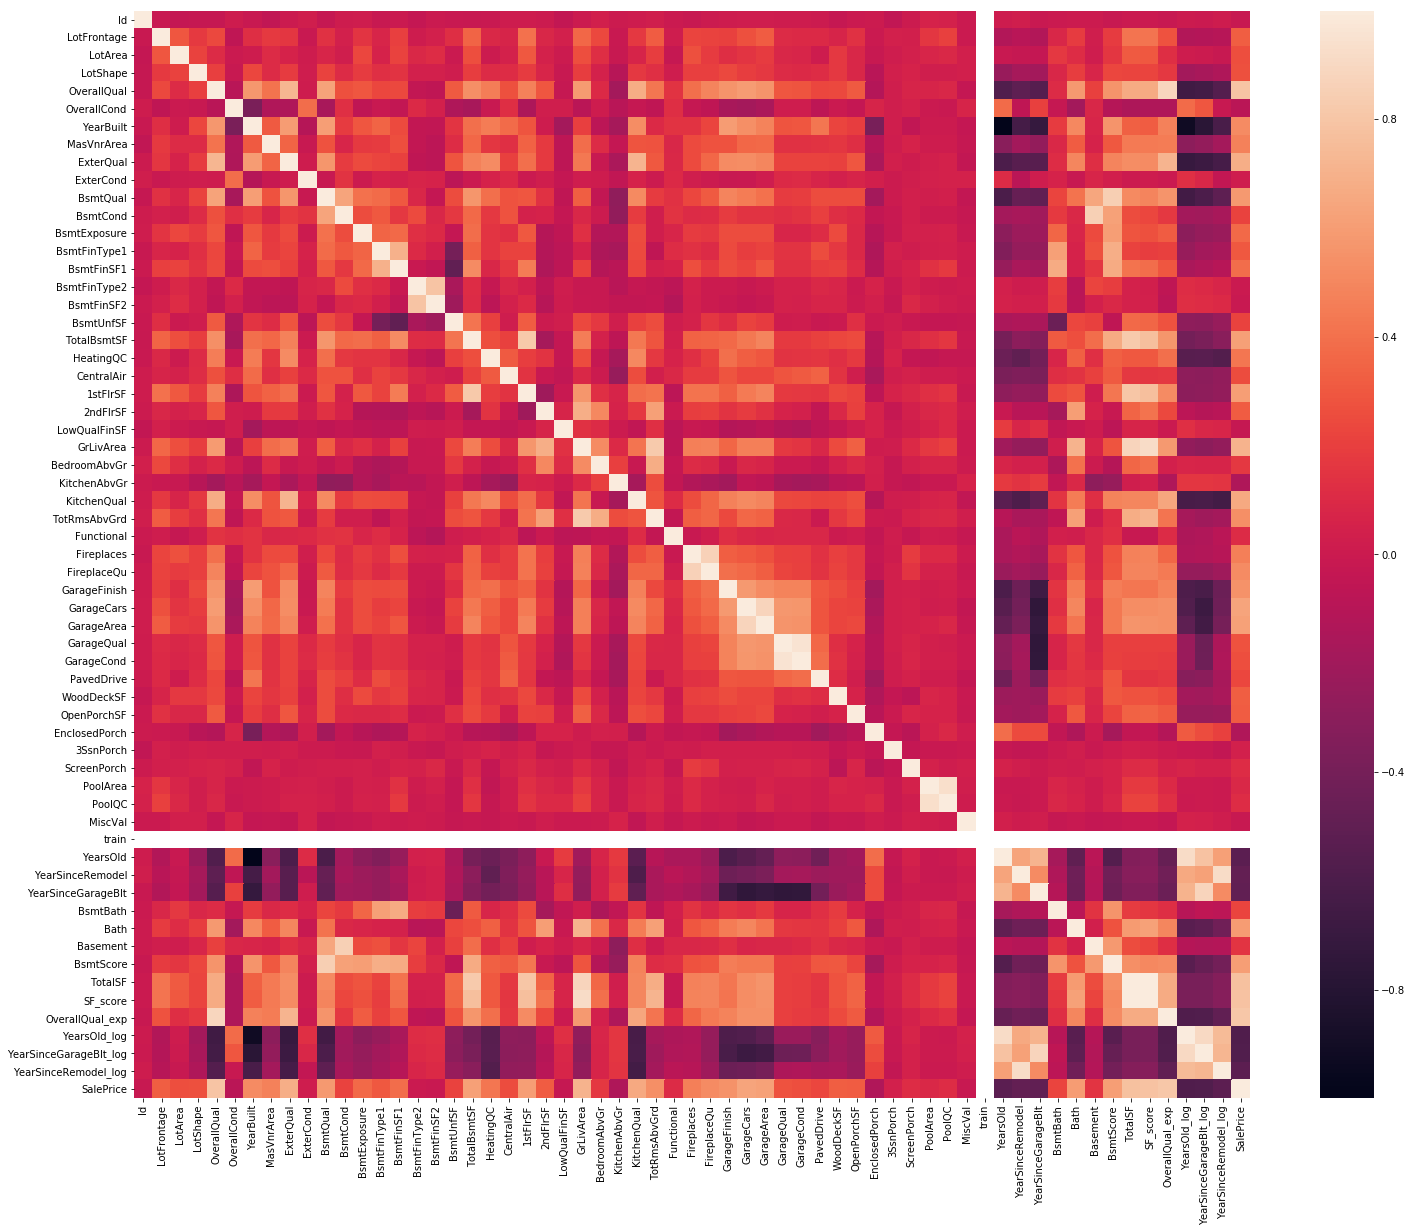

In [1683]:
temp = x_train
temp['SalePrice'] = list(y_train)
plt.figure(figsize=(25,20))
corr = temp.corr(method="pearson")
g = sns.heatmap(corr)
plt.show()

In [1685]:
temp = x_train_encoded
temp['SalePrice'] = list(y_train)
temp,temp2 = normalizeDf(temp,temp)

corr = temp.corr(method="pearson")
corrLot = corr['SalePrice'][1:]
corrLot.sort_values(ascending=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


SalePrice                     1.000000
OverallQual_exp               0.808125
OverallQual                   0.790982
SF_score                      0.781613
TotalSF                       0.778959
GrLivArea                     0.708624
ExterQual                     0.682639
KitchenQual                   0.659600
GarageCars                    0.640409
GarageArea                    0.623431
TotalBsmtSF                   0.613581
BsmtScore                     0.608153
1stFlrSF                      0.605852
Bath                          0.597966
BsmtQual                      0.585207
GarageFinish                  0.549247
TotRmsAbvGrd                  0.533723
YearBuilt                     0.522897
FireplaceQu                   0.520438
Foundation_PConc              0.497734
MasVnrArea                    0.472614
Fireplaces                    0.466929
HeatingQC                     0.427649
Neighborhood_NridgHt          0.402149
BsmtFinSF1                    0.386420
MSSubClass_60            

In [1686]:
temp = x_train_encoded
temp['SalePrice'] = list(map(np.log,y_train))
temp,temp2 = normalizeDf(temp,temp)

corr = temp.corr(method="pearson")
corrLot = corr['SalePrice'][1:]
corrLot.sort_values(ascending=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


SalePrice                     1.000000
OverallQual                   0.817184
SF_score                      0.775667
TotalSF                       0.773277
OverallQual_exp               0.741451
GrLivArea                     0.700927
GarageCars                    0.680625
ExterQual                     0.678840
KitchenQual                   0.667893
GarageArea                    0.650888
Bath                          0.639320
BsmtScore                     0.633640
BsmtQual                      0.615804
TotalBsmtSF                   0.612134
GarageFinish                  0.604878
1stFlrSF                      0.596981
YearBuilt                     0.586570
FireplaceQu                   0.546362
TotRmsAbvGrd                  0.534422
Foundation_PConc              0.530840
Fireplaces                    0.489449
HeatingQC                     0.473762
MasVnrArea                    0.426775
GarageType_Attchd             0.415787
MSSubClass_60                 0.401500
BsmtFinSF1               

"----------------------------------------------MSZoning-------------------------------------------------
         SalePrice               
             count           mean
MSZoning                         
C (all)         10   74528.000000
FV              65  214014.061538
RH              16  131558.375000
RL            1151  191004.994787
RM             218  126316.830275


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


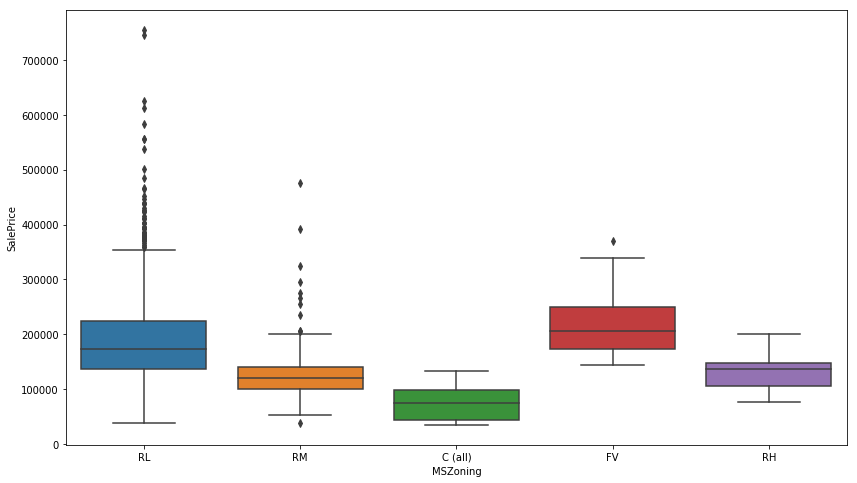

"----------------------------------------------LotFrontage-------------------------------------------------


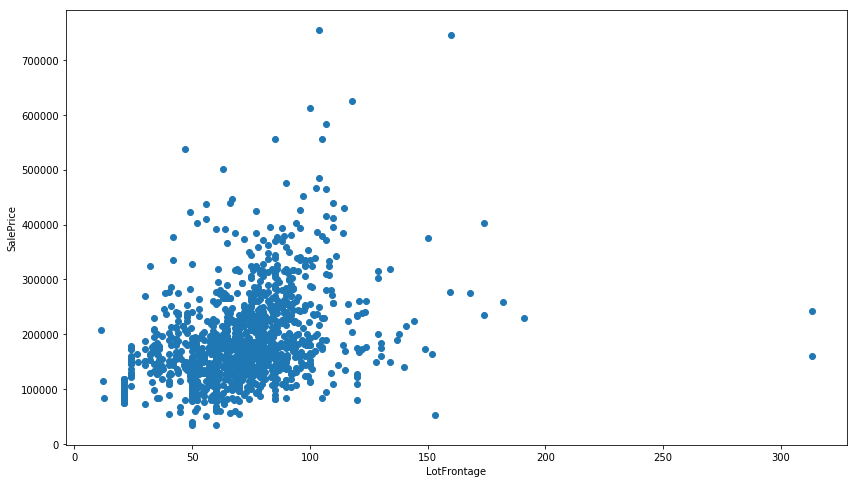

"----------------------------------------------LotArea-------------------------------------------------


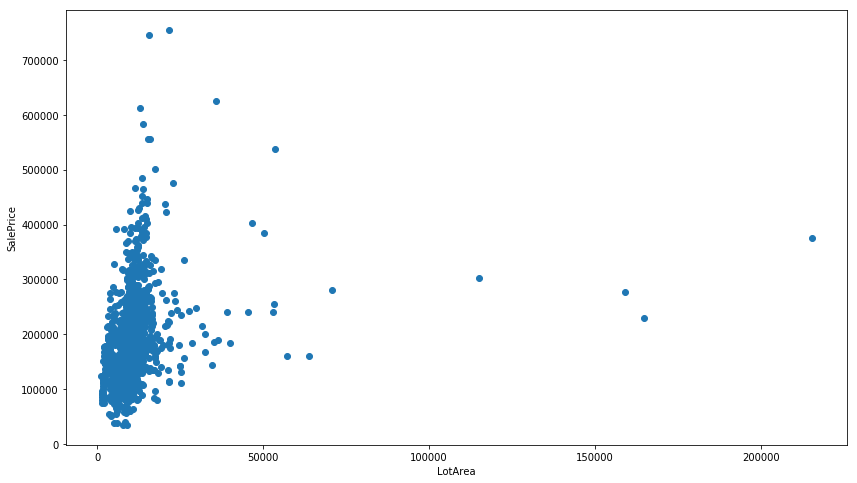

"----------------------------------------------Street-------------------------------------------------
       SalePrice               
           count           mean
Street                         
Grvl           6  130190.500000
Pave        1454  181130.538514


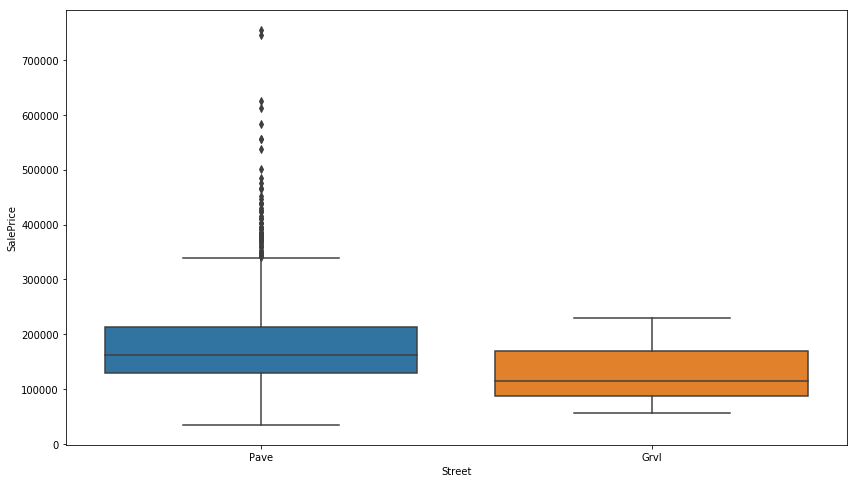

"----------------------------------------------Alley-------------------------------------------------
         SalePrice               
             count           mean
Alley                            
Grvl            50  122219.080000
No_alley      1369  183452.131483
Pave            41  168000.585366


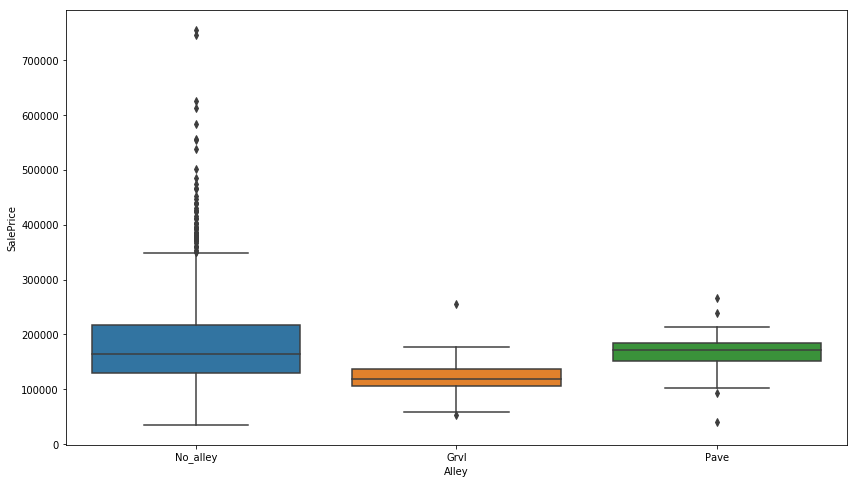

"----------------------------------------------LotShape-------------------------------------------------


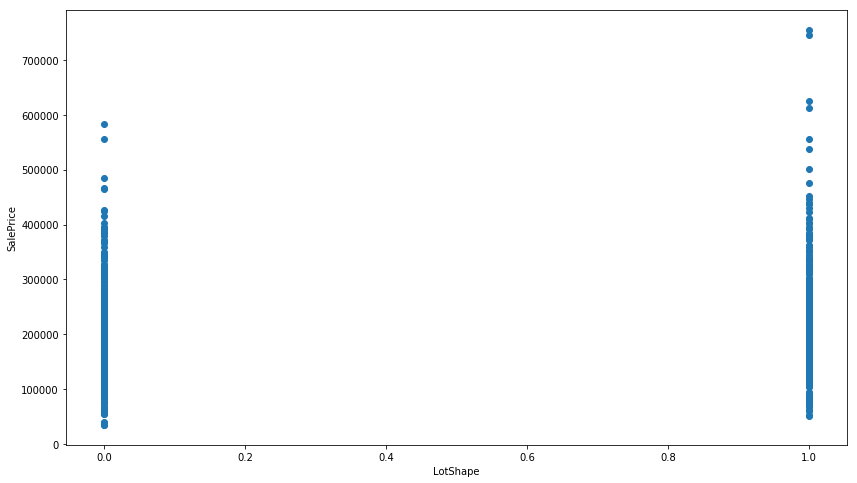

"----------------------------------------------LandContour-------------------------------------------------
            SalePrice               
                count           mean
LandContour                         
Bnk                63  143104.079365
HLS                50  231533.940000
Low                36  203661.111111
Lvl              1311  180183.746758


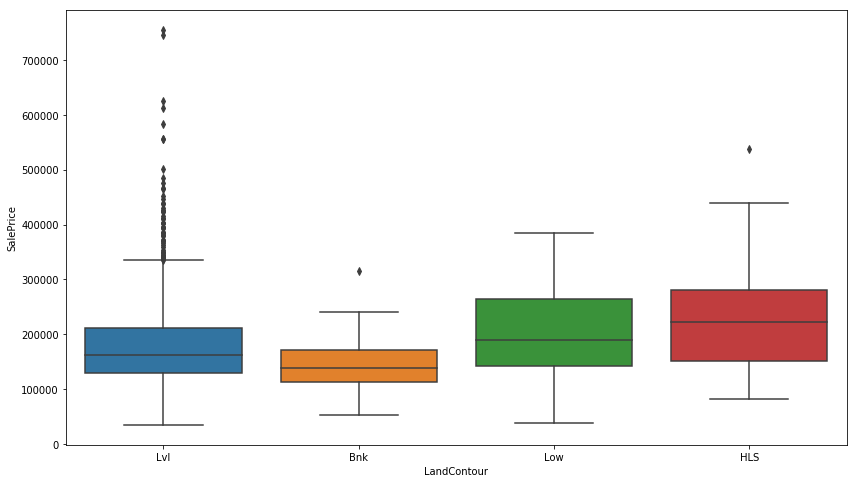

"----------------------------------------------Utilities-------------------------------------------------
          SalePrice              
              count          mean
Utilities                        
AllPub         1459  180950.95682
NoSeWa            1  137500.00000


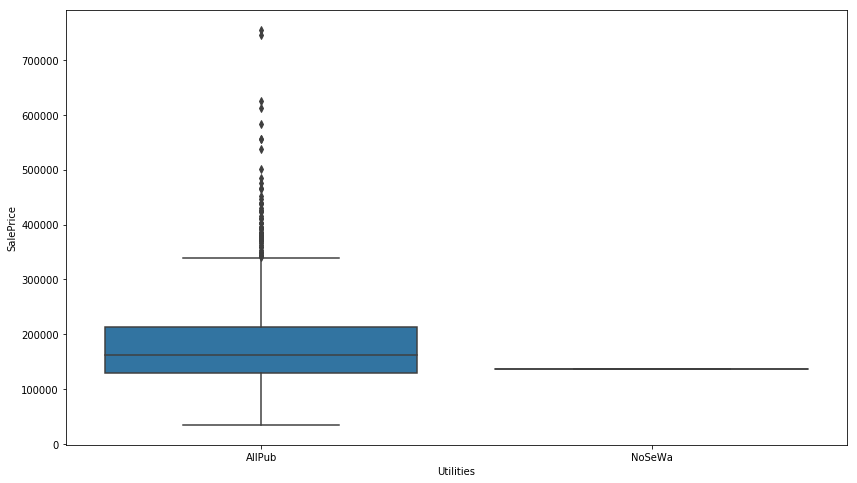

"----------------------------------------------LotConfig-------------------------------------------------
          SalePrice               
              count           mean
LotConfig                         
Corner          263  181623.425856
CulDSac          94  223854.617021
FR2              47  177934.574468
FR3               4  208475.000000
Inside         1052  176938.047529


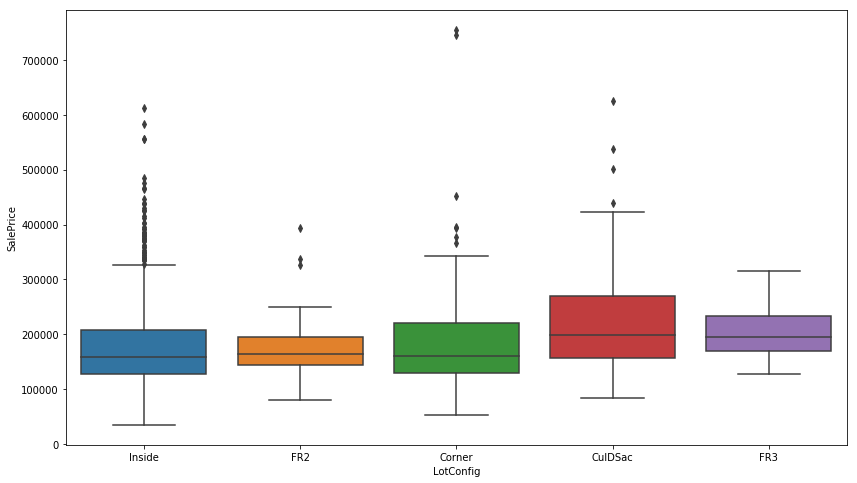

"----------------------------------------------LandSlope-------------------------------------------------
          SalePrice               
              count           mean
LandSlope                         
Gtl            1382  179956.799566
Mod              65  196734.138462
Sev              13  204379.230769


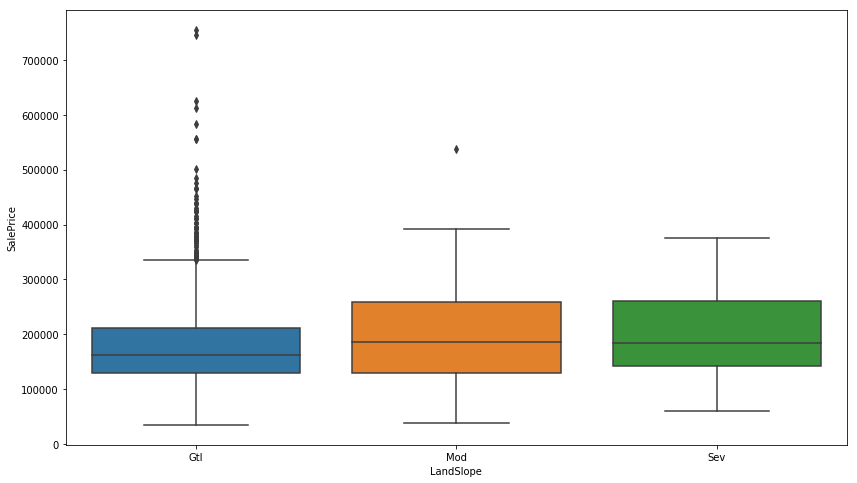

"----------------------------------------------Neighborhood-------------------------------------------------
             SalePrice               
                 count           mean
Neighborhood                         
Blmngtn             17  194870.882353
Blueste              2  137500.000000
BrDale              16  104493.750000
BrkSide             58  124834.051724
ClearCr             28  212565.428571
CollgCr            150  197965.773333
Crawfor             51  210624.725490
Edwards            100  128219.700000
Gilbert             79  192854.506329
IDOTRR              37  100123.783784
MeadowV             17   98576.470588
Mitchel             49  156270.122449
NAmes              225  145847.080000
NPkVill              9  142694.444444
NWAmes              73  189050.068493
NoRidge             41  335295.317073
NridgHt             77  316270.623377
OldTown            113  128225.300885
SWISU               25  142591.360000
Sawyer              74  136793.135135
SawyerW          

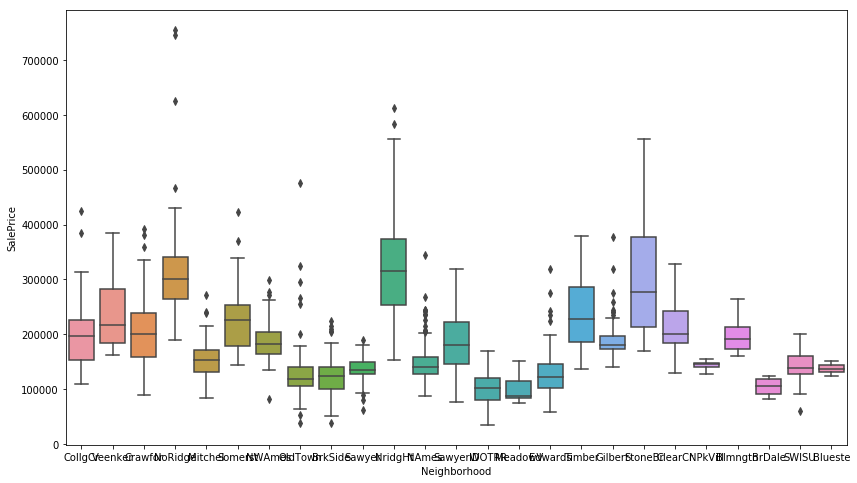

"----------------------------------------------Condition1-------------------------------------------------
           SalePrice               
               count           mean
Condition1                         
Artery            48  135091.666667
Feedr             81  142475.481481
Norm            1260  184495.492063
PosA               8  225875.000000
PosN              19  215184.210526
RRAe              11  138400.000000
RRAn              26  184396.615385
RRNe               2  190750.000000
RRNn               5  212400.000000


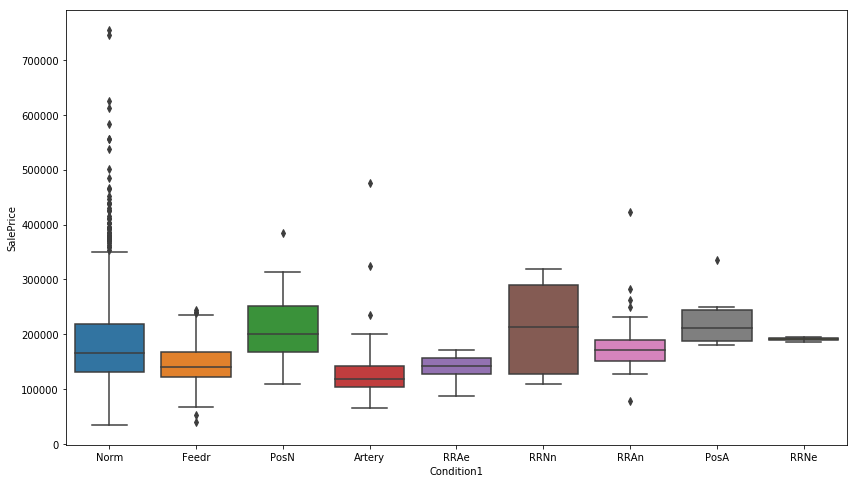

"----------------------------------------------Condition2-------------------------------------------------
           SalePrice               
               count           mean
Condition2                         
Artery             2  106500.000000
Feedr              6  121166.666667
Norm            1445  181169.405536
PosA               1  325000.000000
PosN               2  284875.000000
RRAe               1  190000.000000
RRAn               1  136905.000000
RRNn               2   96750.000000


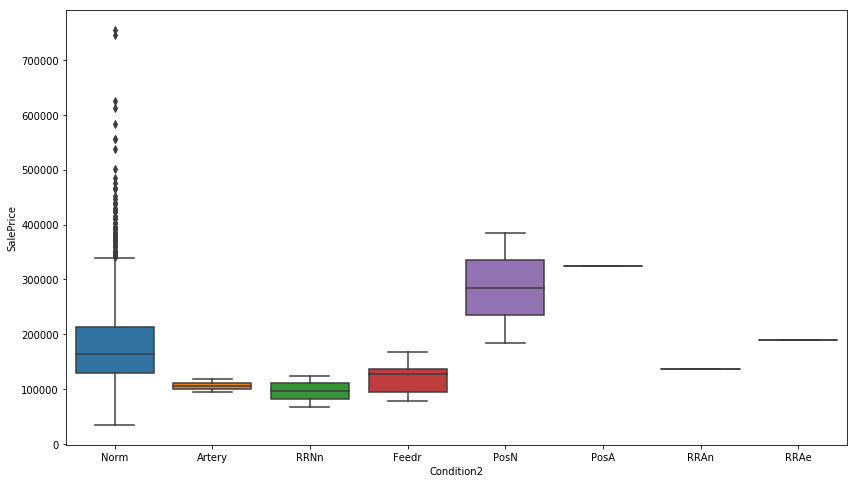

"----------------------------------------------BldgType-------------------------------------------------
         SalePrice               
             count           mean
BldgType                         
1Fam          1220  185763.807377
2fmCon          31  128432.258065
Duplex          52  133541.076923
Twnhs           43  135911.627907
TwnhsE         114  181959.342105


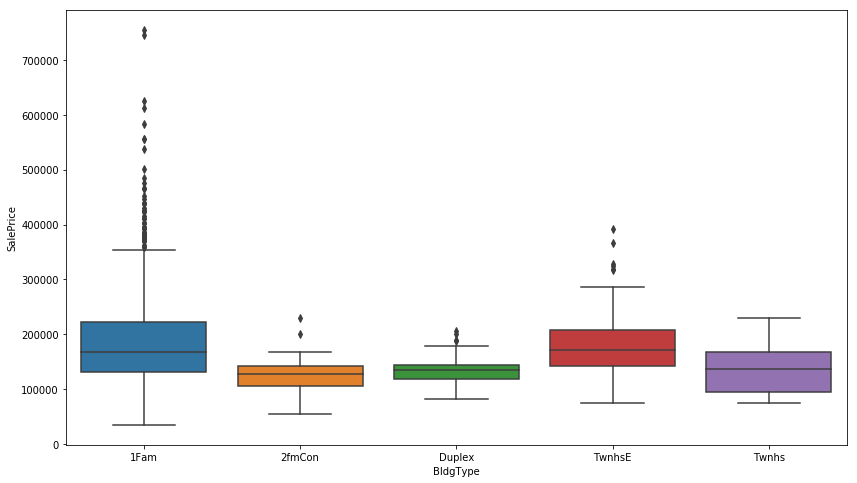

"----------------------------------------------HouseStyle-------------------------------------------------
           SalePrice               
               count           mean
HouseStyle                         
1.5Fin           154  143116.740260
1.5Unf            14  110150.000000
1Story           726  175985.477961
2.5Fin             8  220000.000000
2.5Unf            11  157354.545455
2Story           445  210051.764045
SFoyer            37  135074.486486
SLvl              65  166703.384615


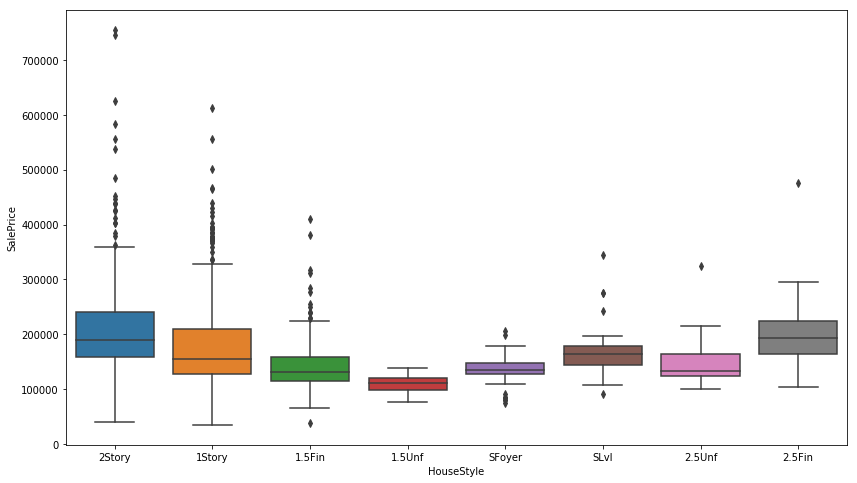

"----------------------------------------------OverallQual-------------------------------------------------


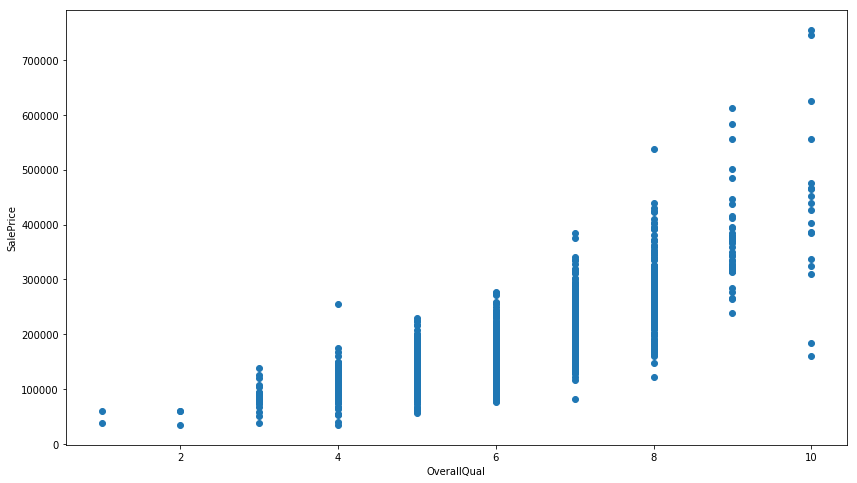

"----------------------------------------------OverallCond-------------------------------------------------


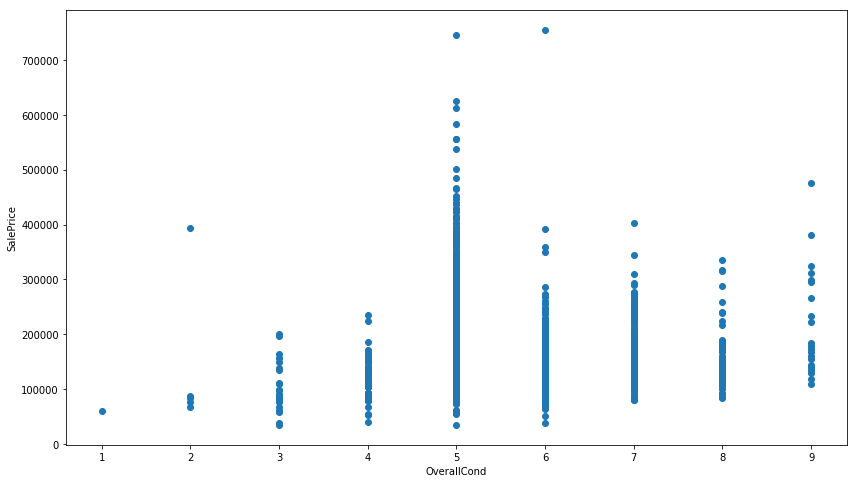

"----------------------------------------------RoofStyle-------------------------------------------------
          SalePrice               
              count           mean
RoofStyle                         
Flat             13  194690.000000
Gable          1141  171483.956179
Gambrel          11  148909.090909
Hip             286  218876.933566
Mansard           7  180568.428571
Shed              2  225000.000000


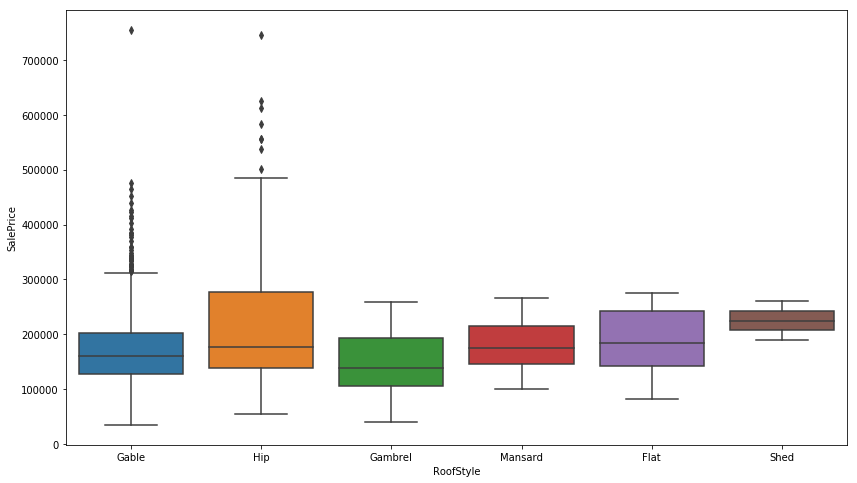

"----------------------------------------------RoofMatl-------------------------------------------------
         SalePrice               
             count           mean
RoofMatl                         
ClyTile          1  160000.000000
CompShg       1434  179803.679219
Membran          1  241500.000000
Metal            1  180000.000000
Roll             1  137000.000000
Tar&Grv         11  185406.363636
WdShake          5  241400.000000
WdShngl          6  390250.000000


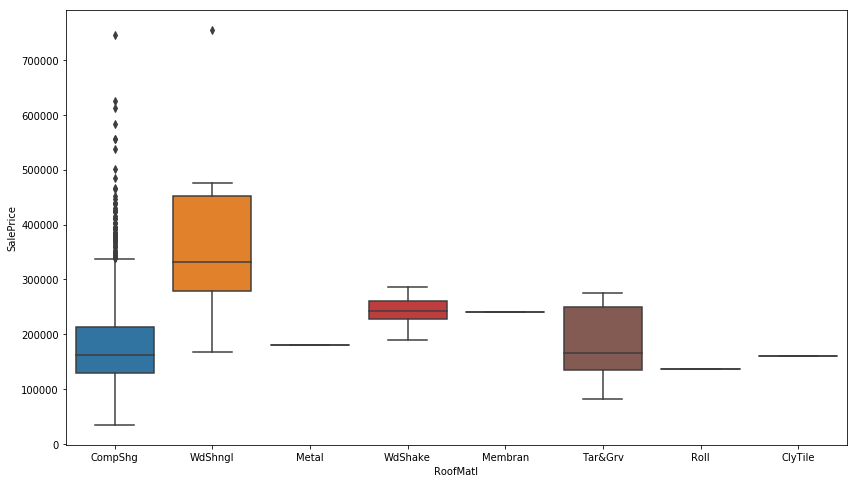

"----------------------------------------------Exterior1st-------------------------------------------------
            SalePrice               
                count           mean
Exterior1st                         
AsbShng            20  107385.550000
AsphShn             1  100000.000000
BrkComm             2   71000.000000
BrkFace            50  194573.000000
CBlock              1  105000.000000
CemntBd            61  231690.655738
HdBoard           222  163077.450450
ImStucc             1  262000.000000
MetalSd           220  149422.177273
Plywood           108  175942.379630
Stone               2  258500.000000
Stucco             25  162990.000000
VinylSd           515  213732.900971
Wd Sdng           206  149841.645631
WdShing            26  150655.076923


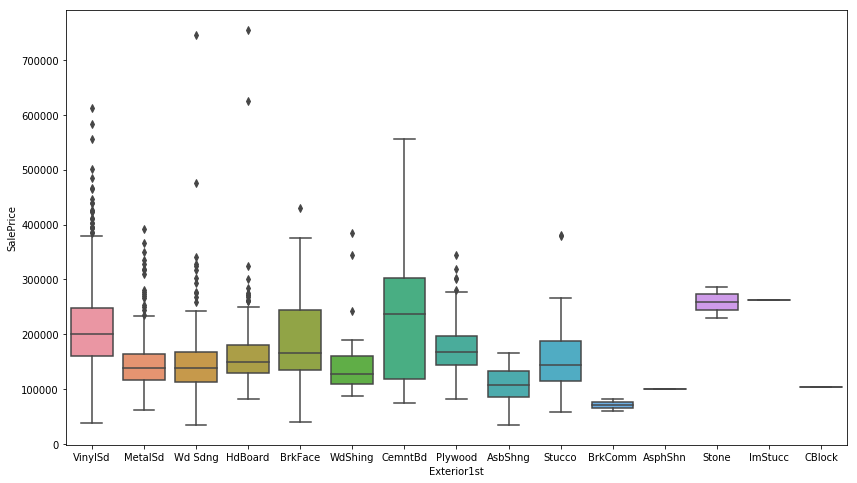

"----------------------------------------------Exterior2nd-------------------------------------------------
            SalePrice               
                count           mean
Exterior2nd                         
AsbShng            20  114060.550000
AsphShn             3  138000.000000
Brk Cmn             7  126714.285714
BrkFace            25  195818.000000
CBlock              1  105000.000000
CmentBd            60  230093.833333
HdBoard           207  167661.565217
ImStucc            10  252070.000000
MetalSd           214  149803.172897
Other               1  319000.000000
Plywood           142  168112.387324
Stone               5  158224.800000
Stucco             26  155905.153846
VinylSd           504  214432.460317
Wd Sdng           197  148386.065990
Wd Shng            38  161328.947368


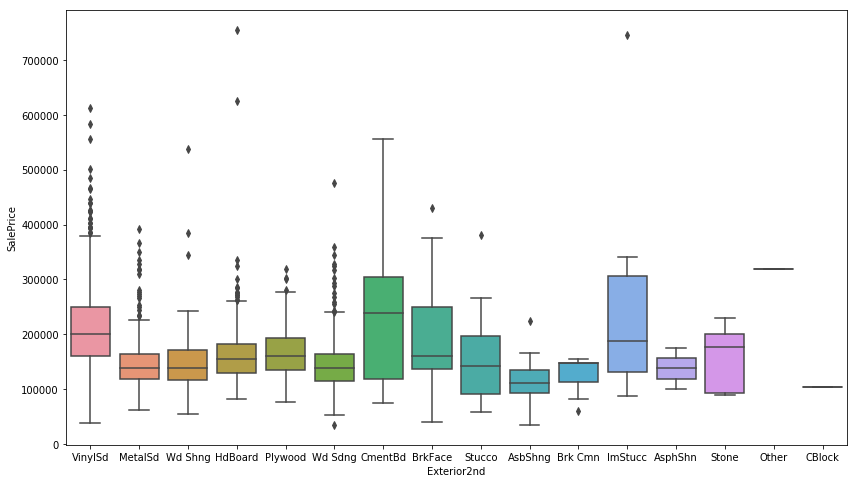

"----------------------------------------------MasVnrType-------------------------------------------------
           SalePrice               
               count           mean
MasVnrType                         
BrkCmn            15  146318.066667
BrkFace          445  204691.871910
None             872  156958.243119
Stone            128  265583.625000


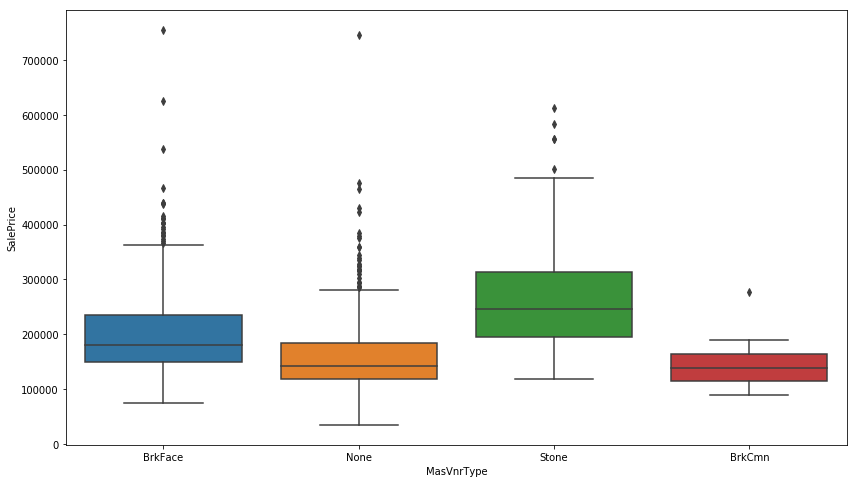

"----------------------------------------------MasVnrArea-------------------------------------------------


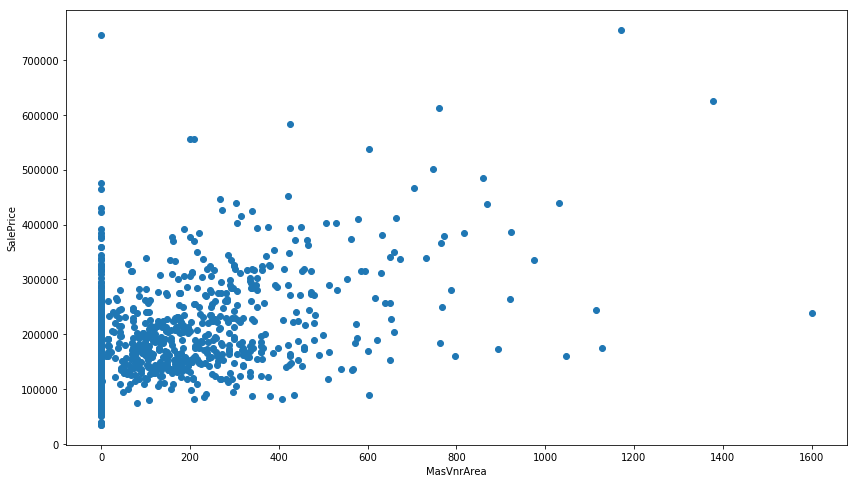

"----------------------------------------------ExterQual-------------------------------------------------


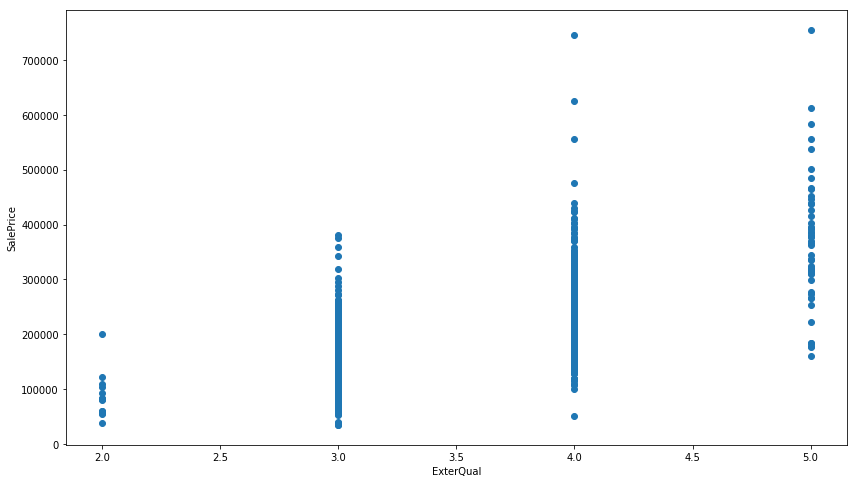

"----------------------------------------------ExterCond-------------------------------------------------


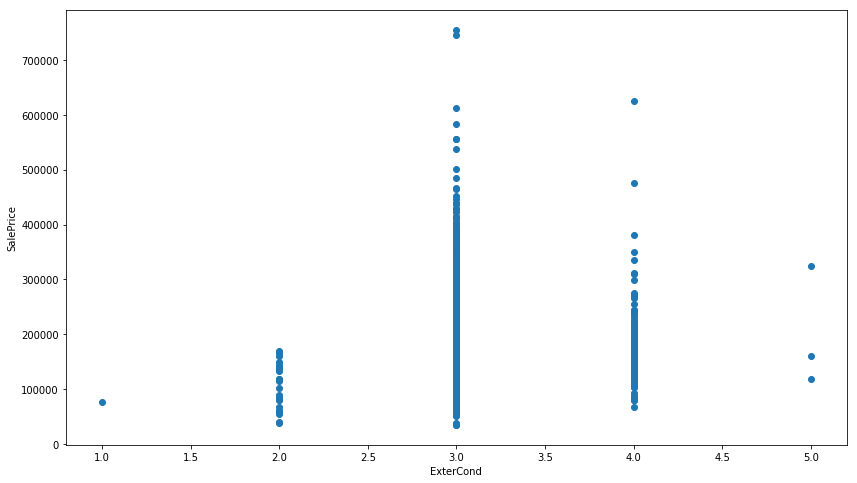

"----------------------------------------------Foundation-------------------------------------------------
           SalePrice               
               count           mean
Foundation                         
BrkTil           146  132291.075342
CBlock           634  149805.714511
PConc            647  225230.442040
Slab              24  107365.625000
Stone              6  165959.166667
Wood               3  185666.666667


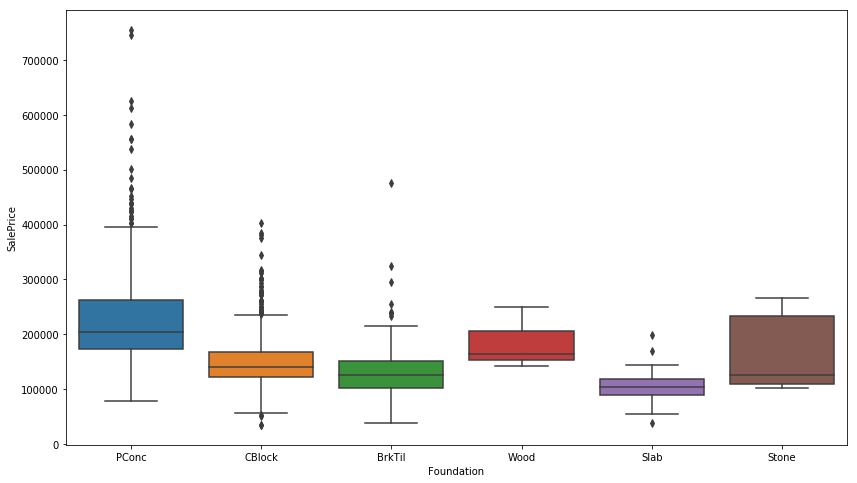

"----------------------------------------------BsmtQual-------------------------------------------------


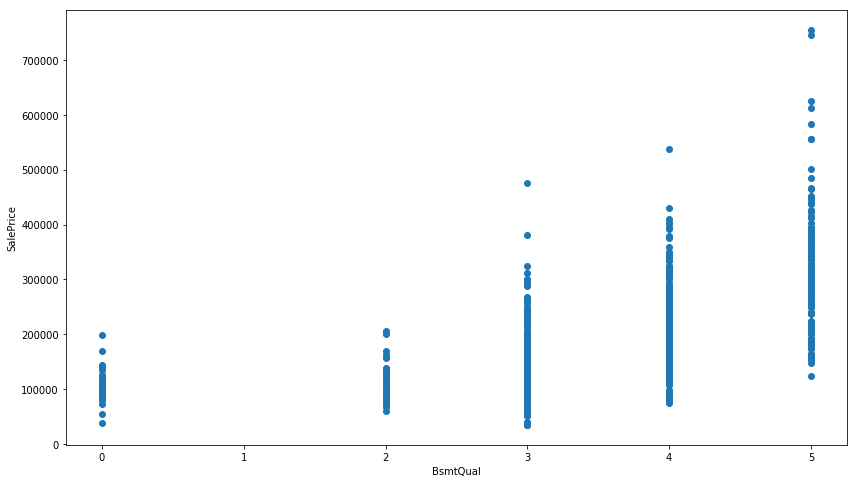

"----------------------------------------------BsmtCond-------------------------------------------------


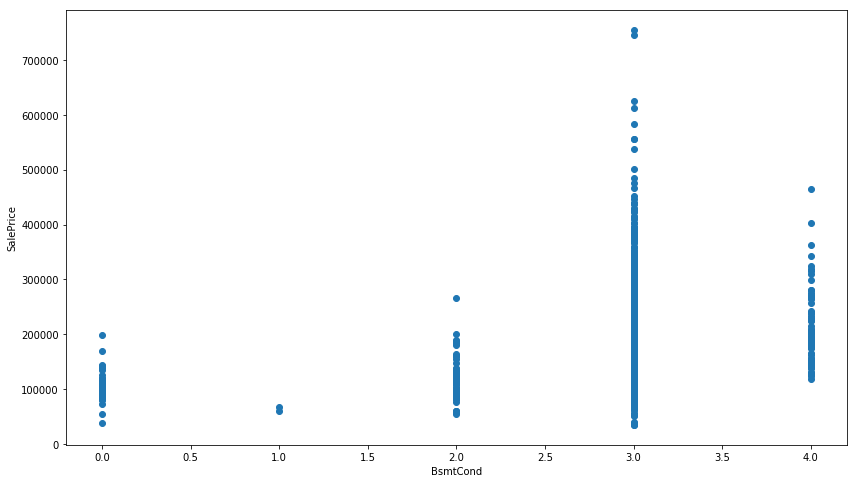

"----------------------------------------------BsmtExposure-------------------------------------------------


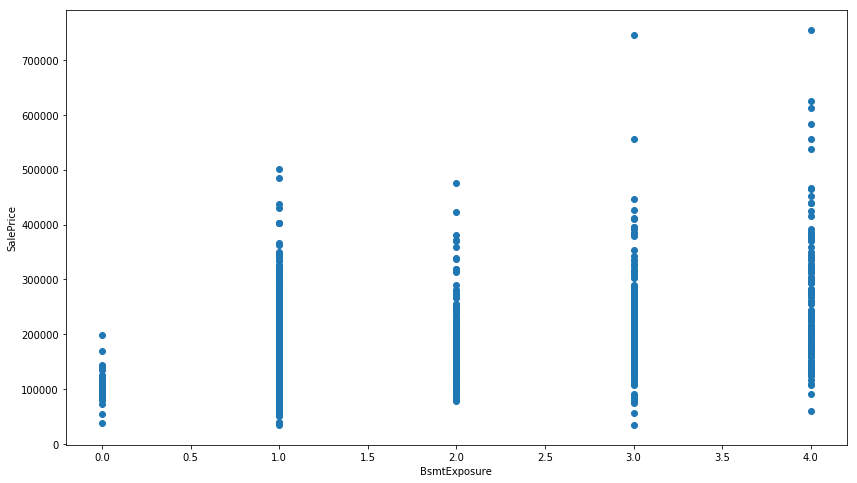

"----------------------------------------------BsmtFinType1-------------------------------------------------


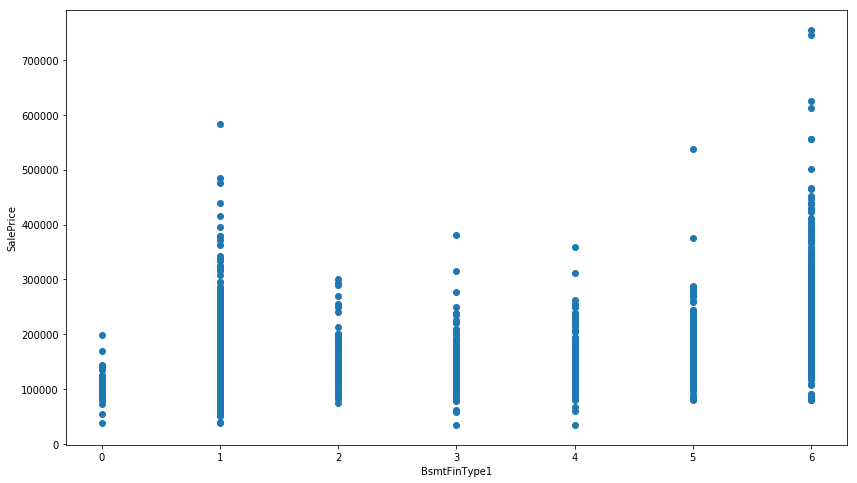

"----------------------------------------------BsmtFinSF1-------------------------------------------------


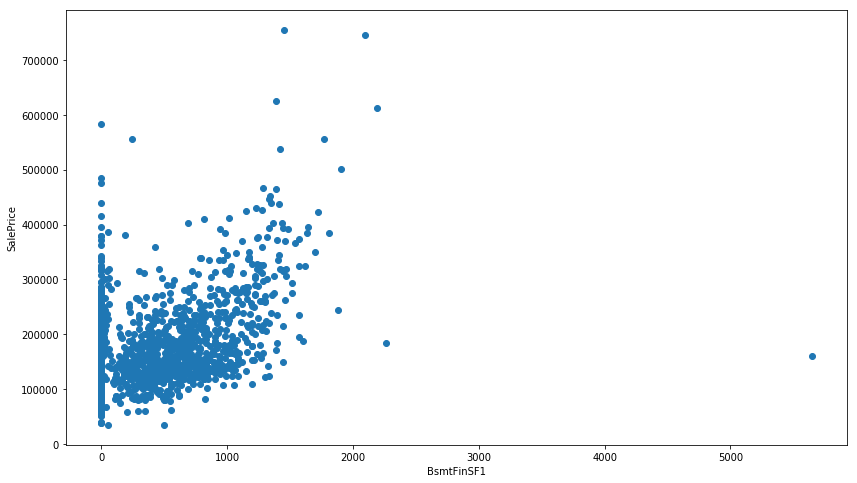

"----------------------------------------------BsmtFinType2-------------------------------------------------


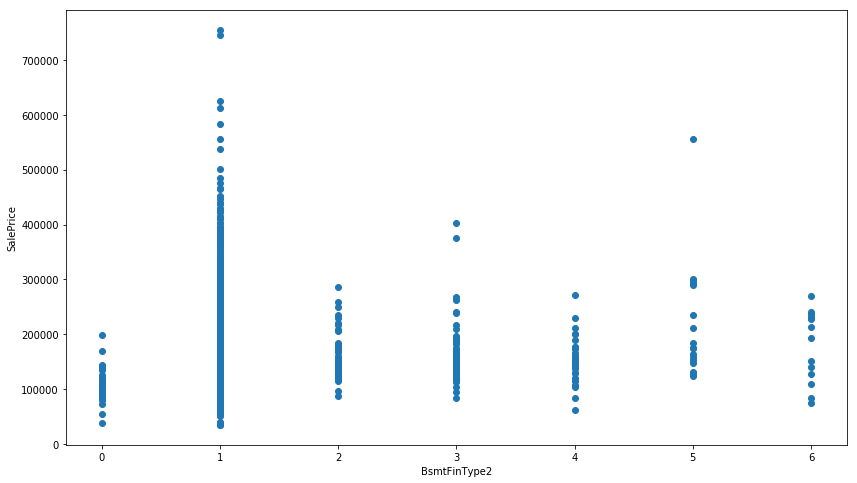

"----------------------------------------------BsmtFinSF2-------------------------------------------------


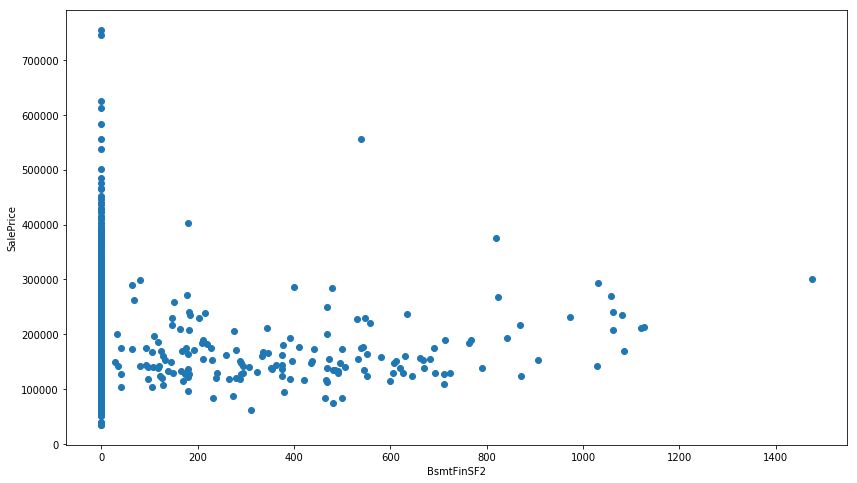

"----------------------------------------------BsmtUnfSF-------------------------------------------------


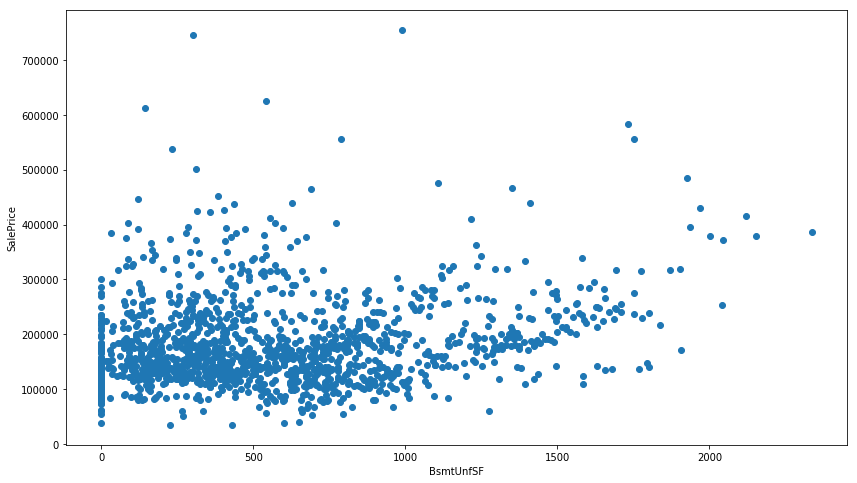

"----------------------------------------------TotalBsmtSF-------------------------------------------------


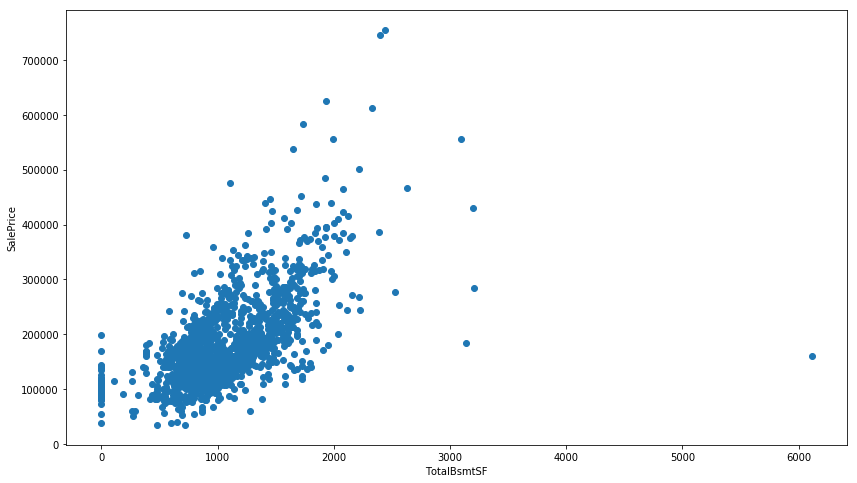

"----------------------------------------------Heating-------------------------------------------------
        SalePrice               
            count           mean
Heating                         
Floor           1   72500.000000
GasA         1428  182021.195378
GasW           18  166632.166667
Grav            7   75271.428571
OthW            2  125750.000000
Wall            4   92100.000000


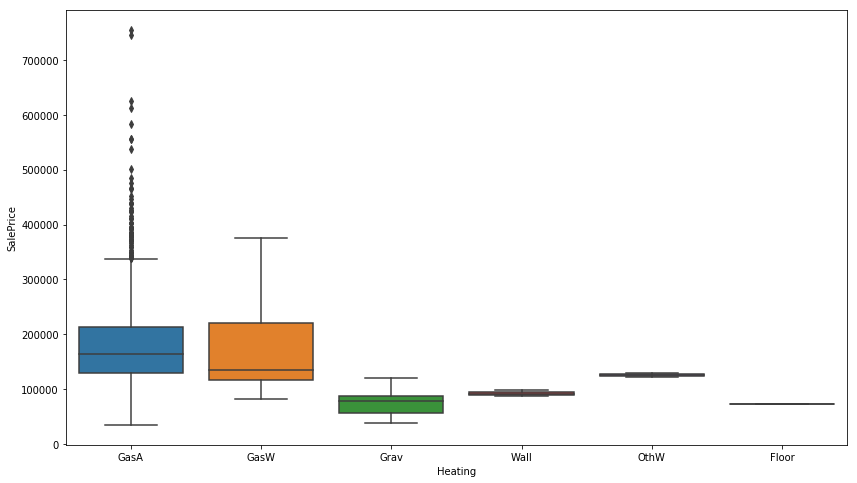

"----------------------------------------------HeatingQC-------------------------------------------------


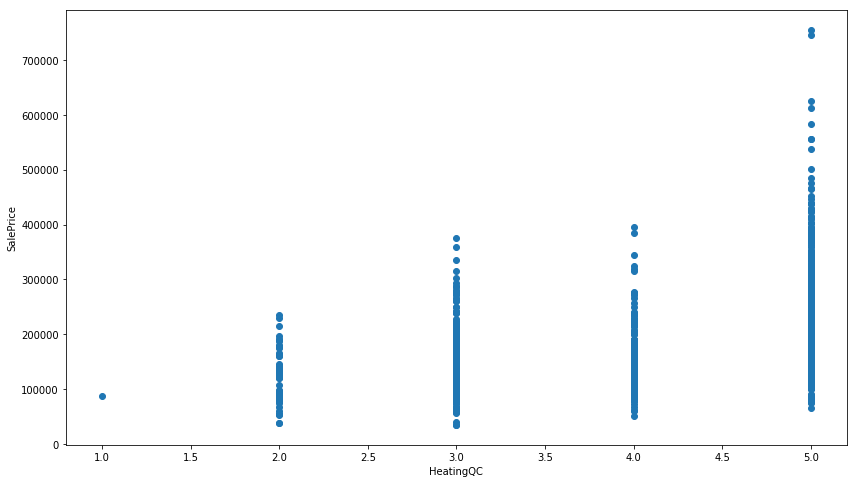

"----------------------------------------------CentralAir-------------------------------------------------


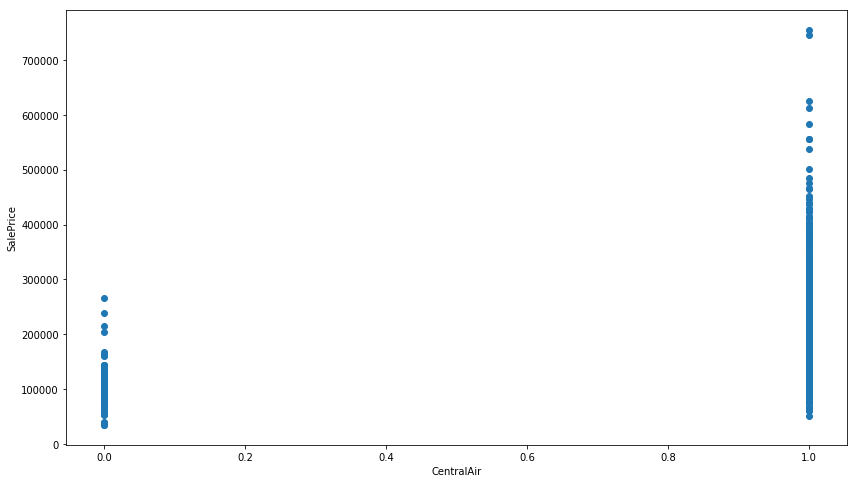

"----------------------------------------------Electrical-------------------------------------------------
           SalePrice               
               count           mean
Electrical                         
FuseA             94  122196.893617
FuseF             27  107675.444444
FuseP              3   97333.333333
Mix                1   67000.000000
SBrkr           1335  186810.637453


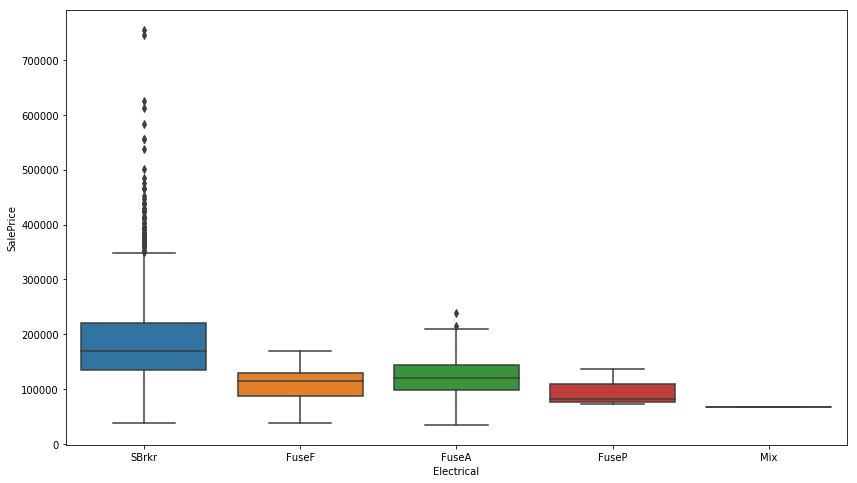

"----------------------------------------------1stFlrSF-------------------------------------------------


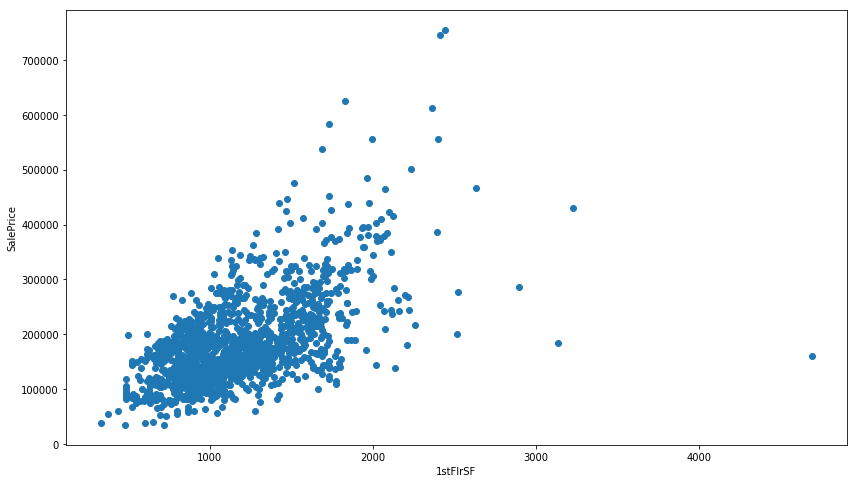

"----------------------------------------------2ndFlrSF-------------------------------------------------


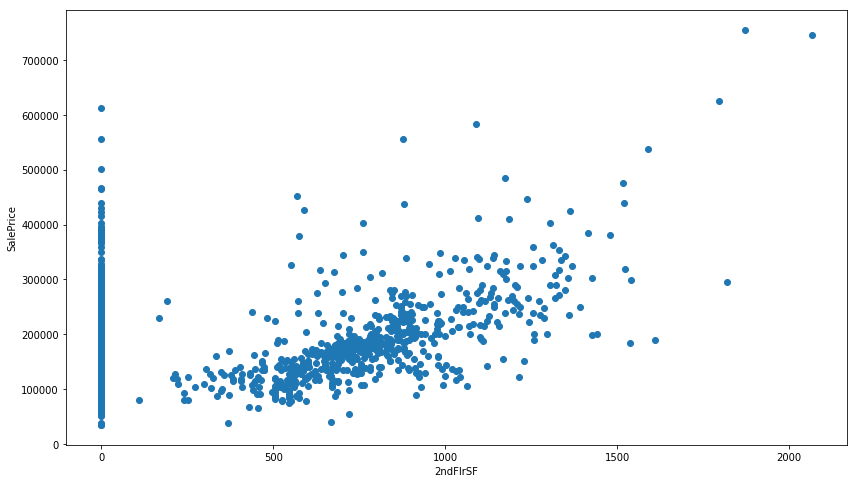

"----------------------------------------------LowQualFinSF-------------------------------------------------


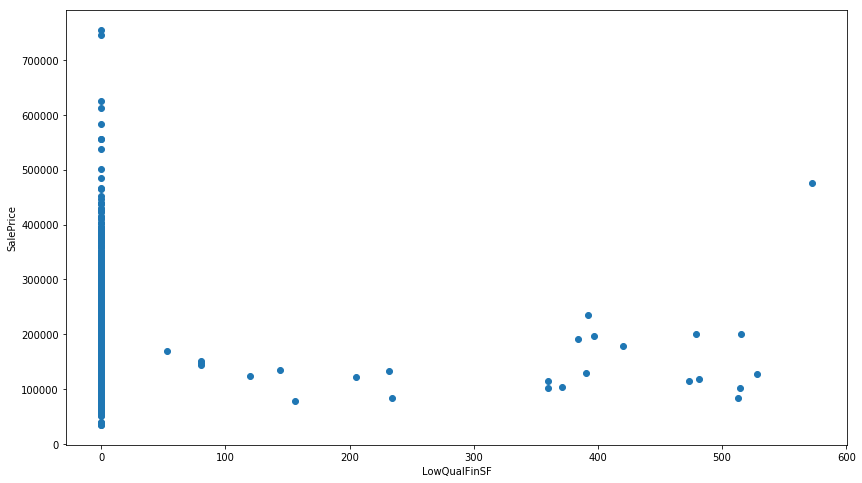

"----------------------------------------------GrLivArea-------------------------------------------------


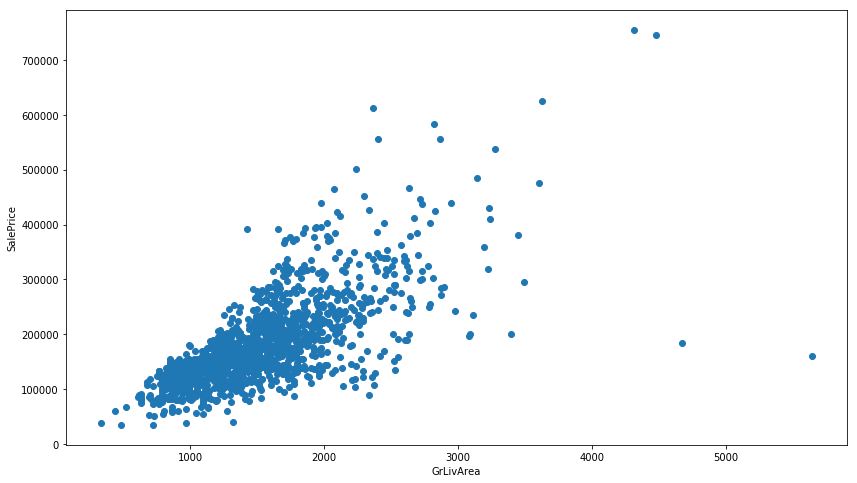

"----------------------------------------------BedroomAbvGr-------------------------------------------------


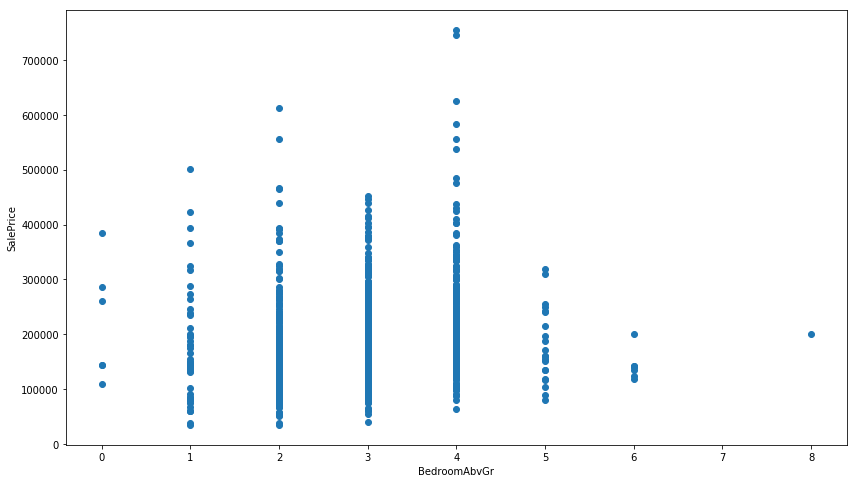

"----------------------------------------------KitchenAbvGr-------------------------------------------------


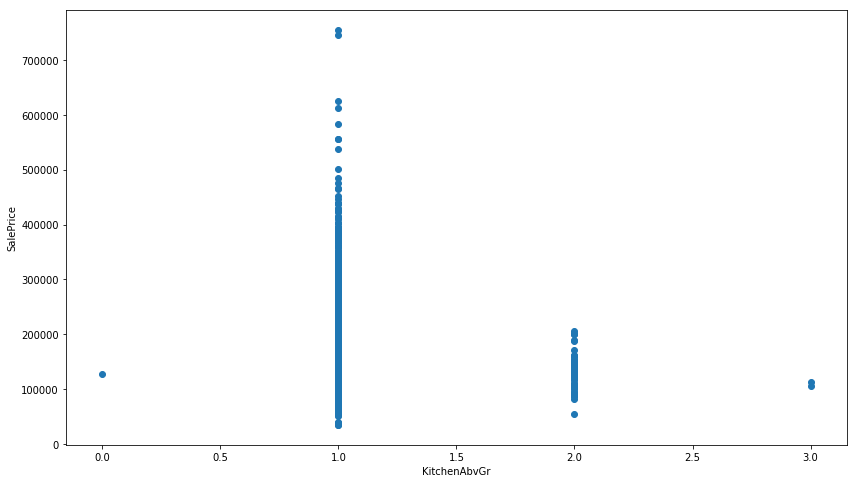

"----------------------------------------------KitchenQual-------------------------------------------------


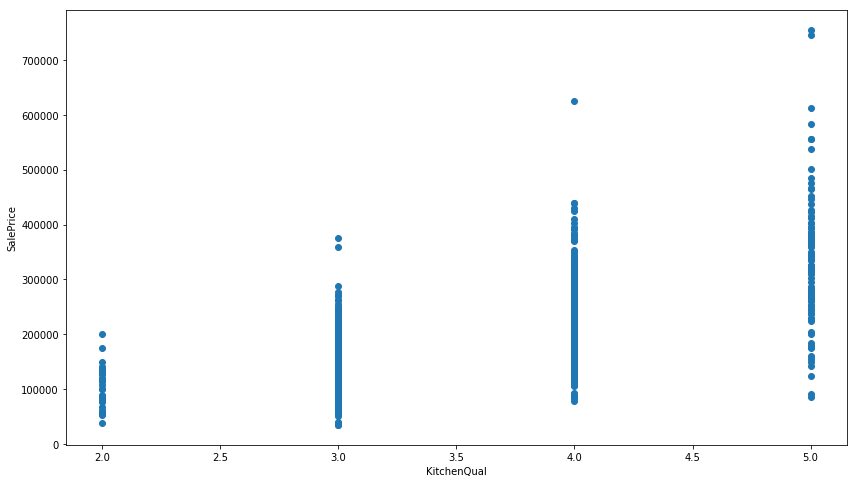

"----------------------------------------------TotRmsAbvGrd-------------------------------------------------


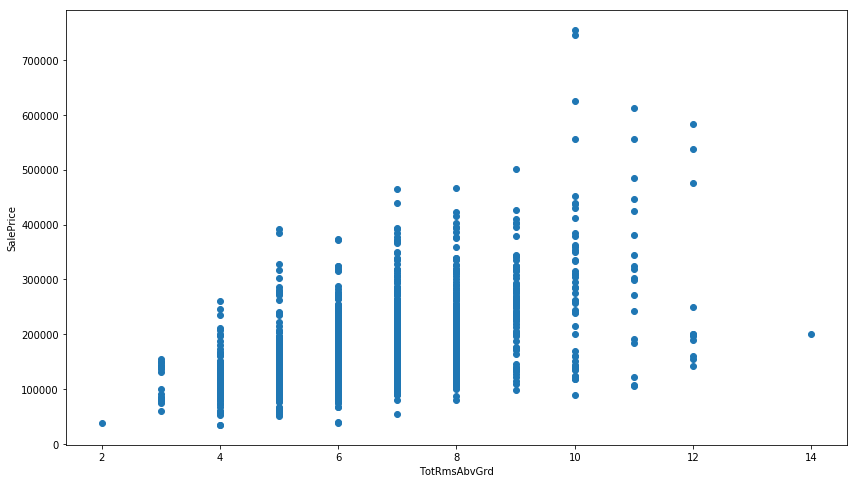

"----------------------------------------------Functional-------------------------------------------------


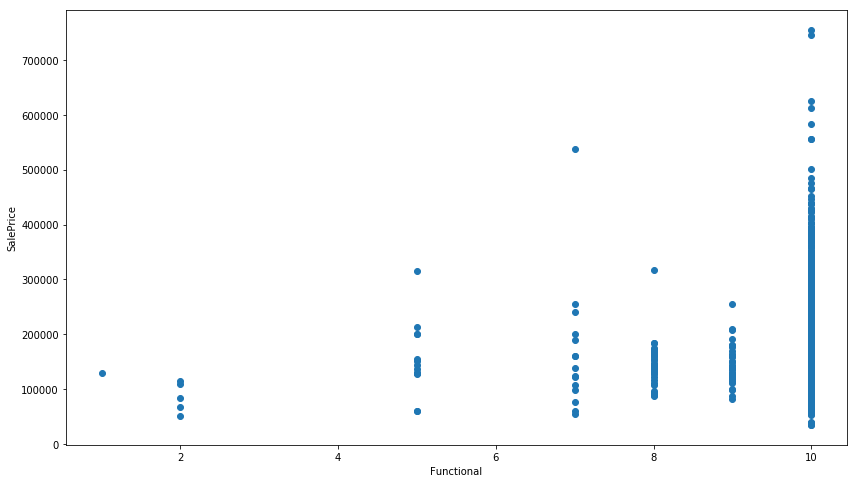

"----------------------------------------------Fireplaces-------------------------------------------------


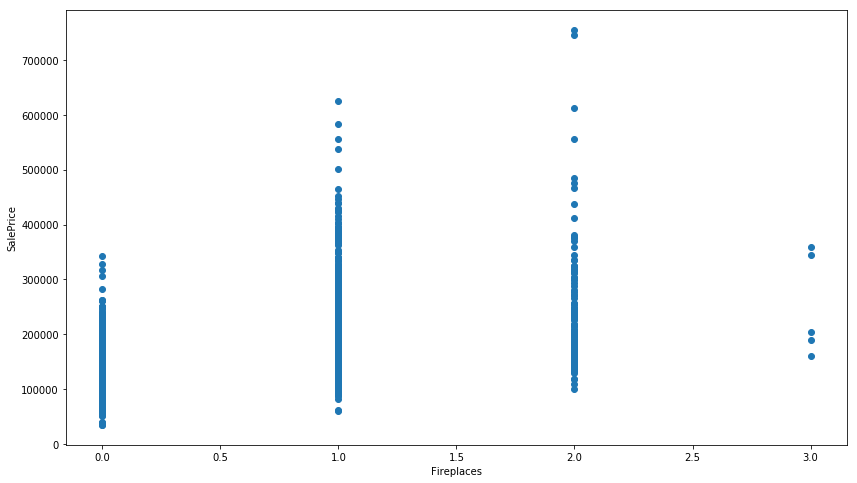

"----------------------------------------------FireplaceQu-------------------------------------------------


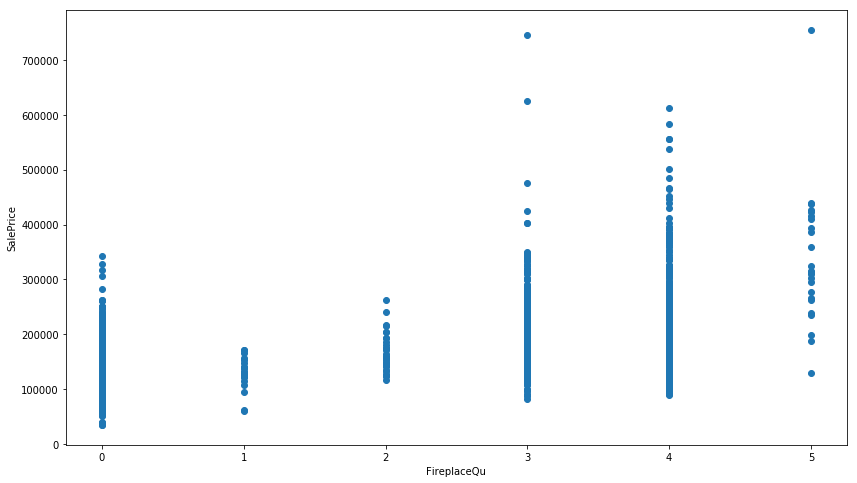

"----------------------------------------------GarageType-------------------------------------------------
           SalePrice               
               count           mean
GarageType                         
2Types             6  151283.333333
Attchd           870  202892.656322
Basment           19  160570.684211
BuiltIn           88  254751.738636
CarPort            9  109962.111111
Detchd           387  134091.162791
No_garage         81  103317.283951


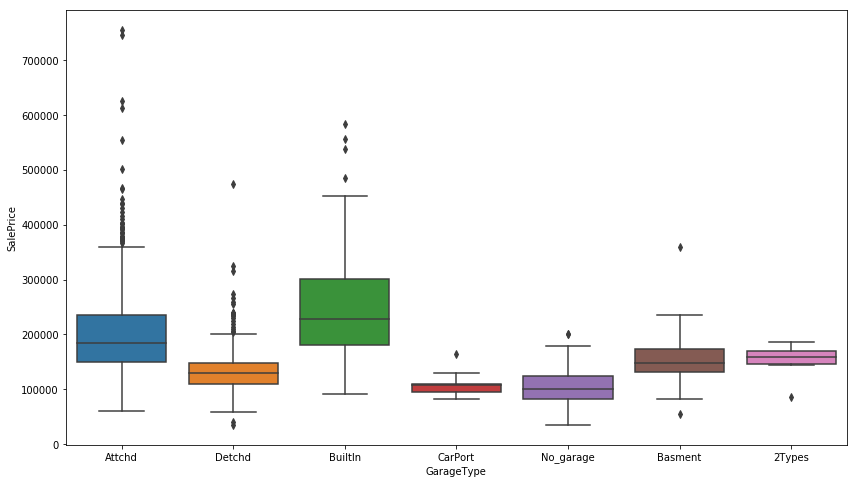

"----------------------------------------------GarageFinish-------------------------------------------------


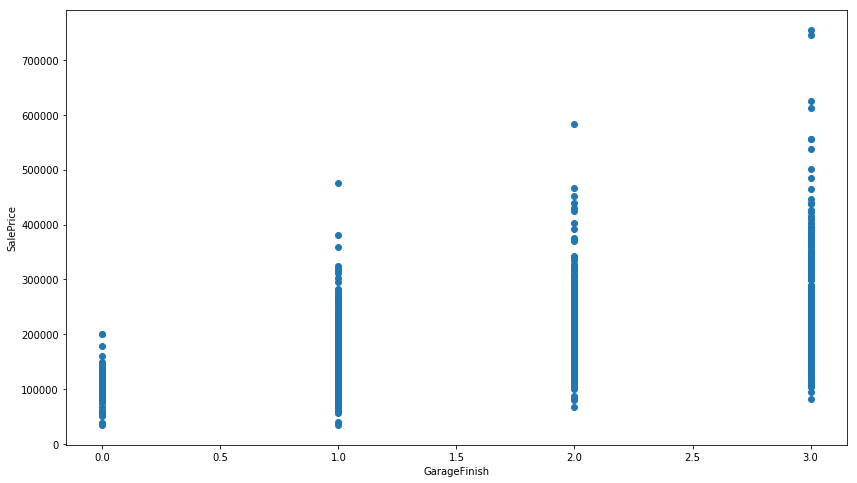

"----------------------------------------------GarageCars-------------------------------------------------


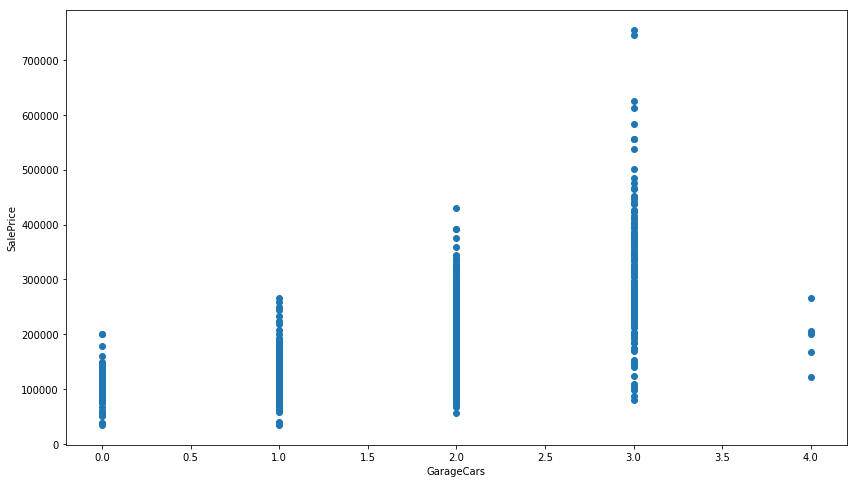

"----------------------------------------------GarageArea-------------------------------------------------


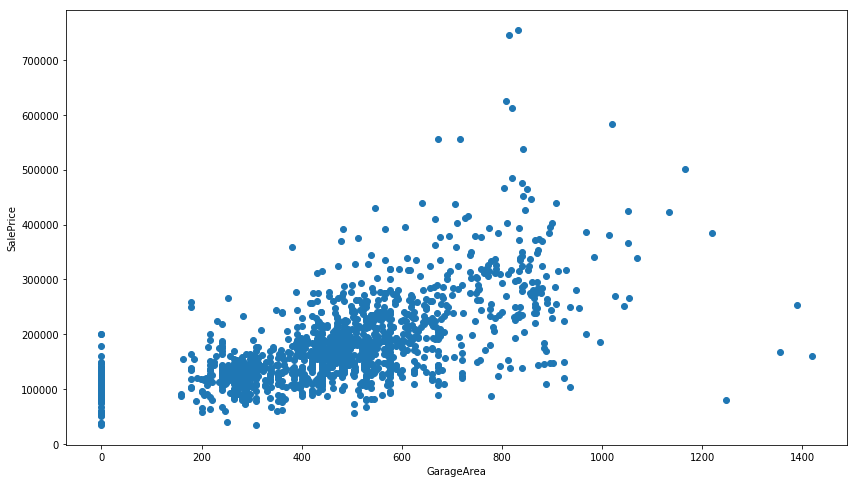

"----------------------------------------------GarageQual-------------------------------------------------


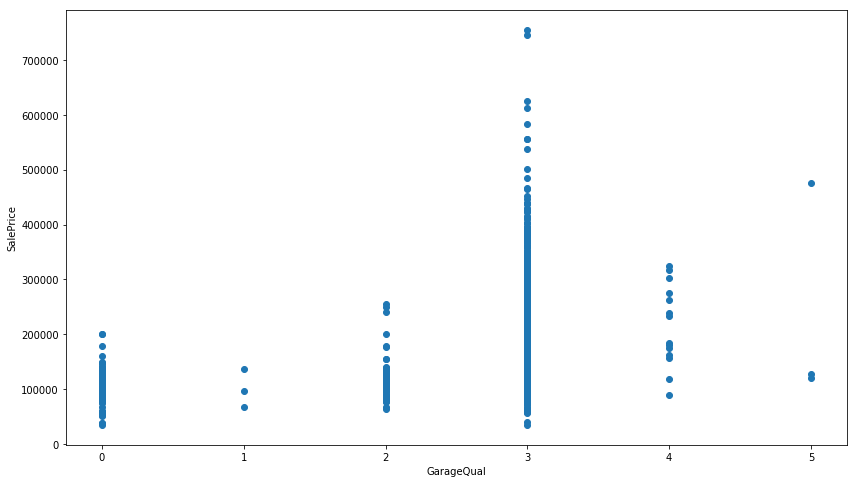

"----------------------------------------------GarageCond-------------------------------------------------


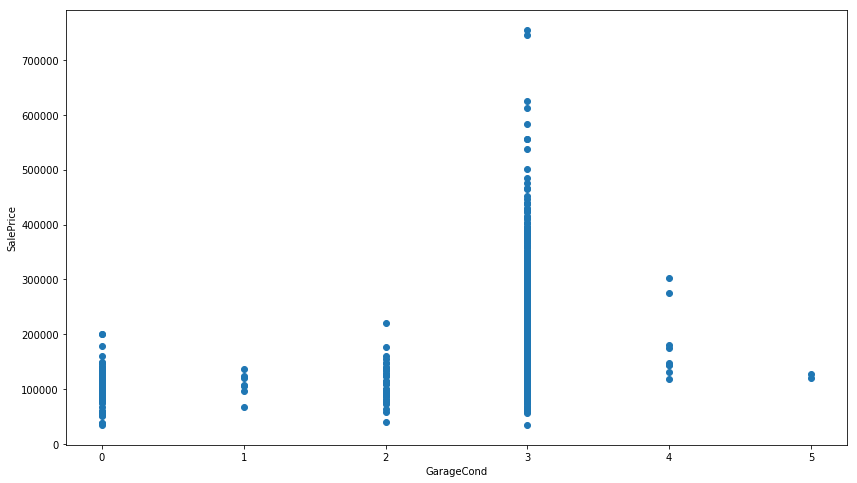

"----------------------------------------------PavedDrive-------------------------------------------------


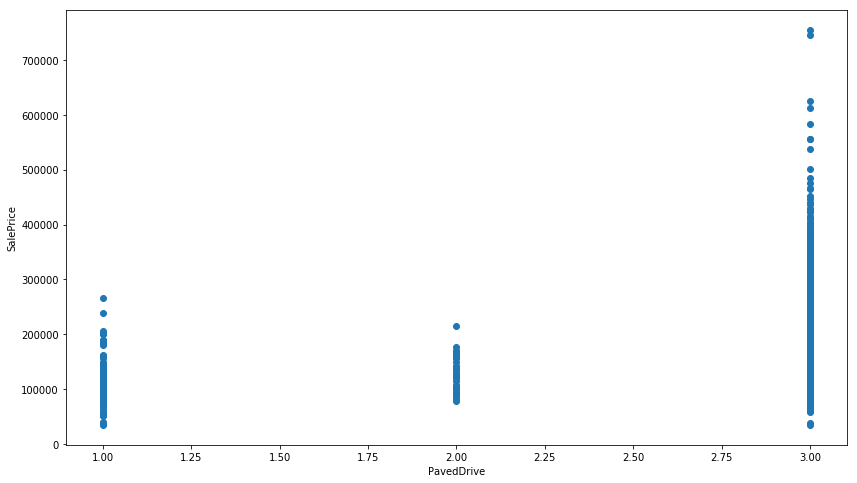

"----------------------------------------------WoodDeckSF-------------------------------------------------


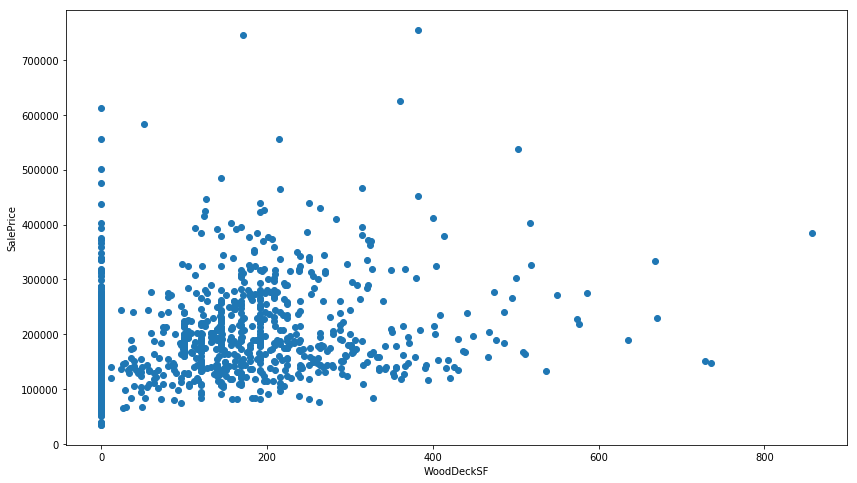

"----------------------------------------------OpenPorchSF-------------------------------------------------


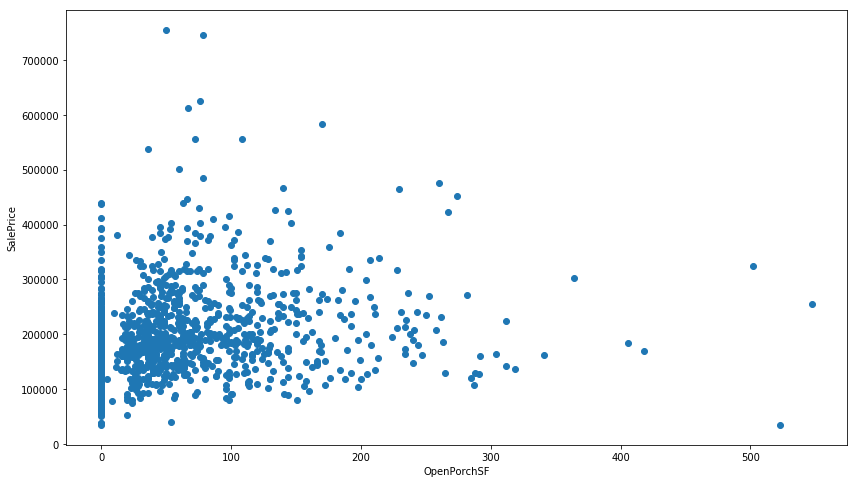

"----------------------------------------------EnclosedPorch-------------------------------------------------


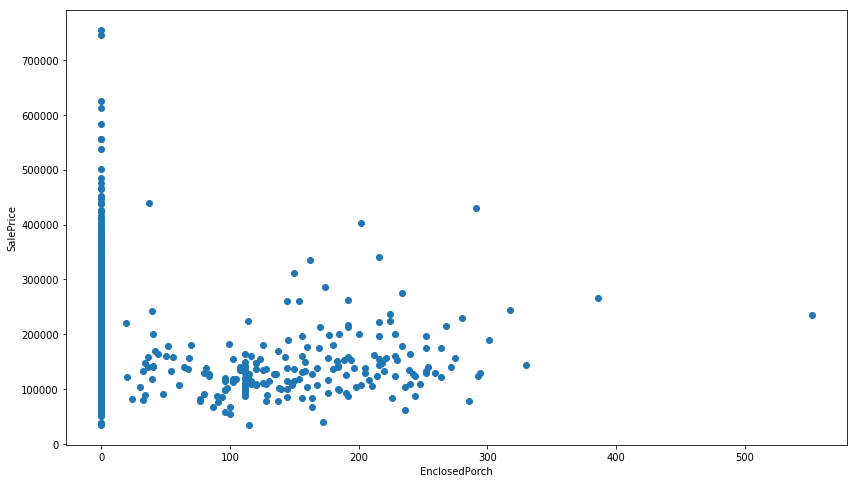

"----------------------------------------------3SsnPorch-------------------------------------------------


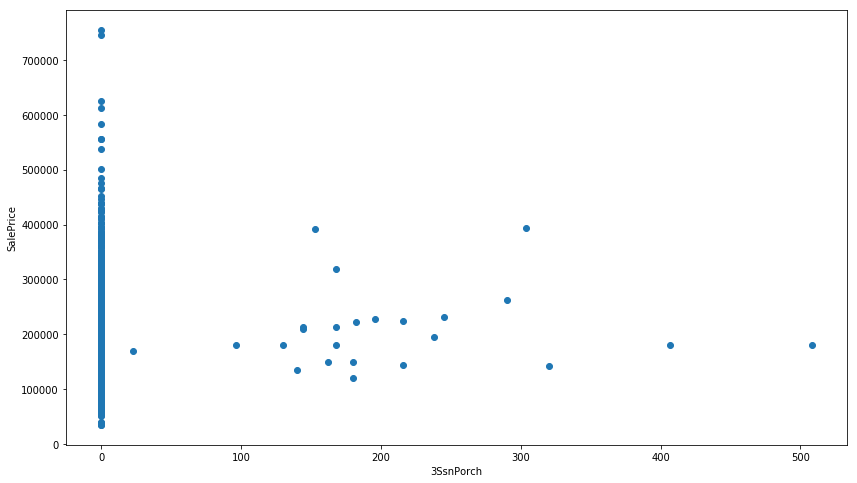

"----------------------------------------------ScreenPorch-------------------------------------------------


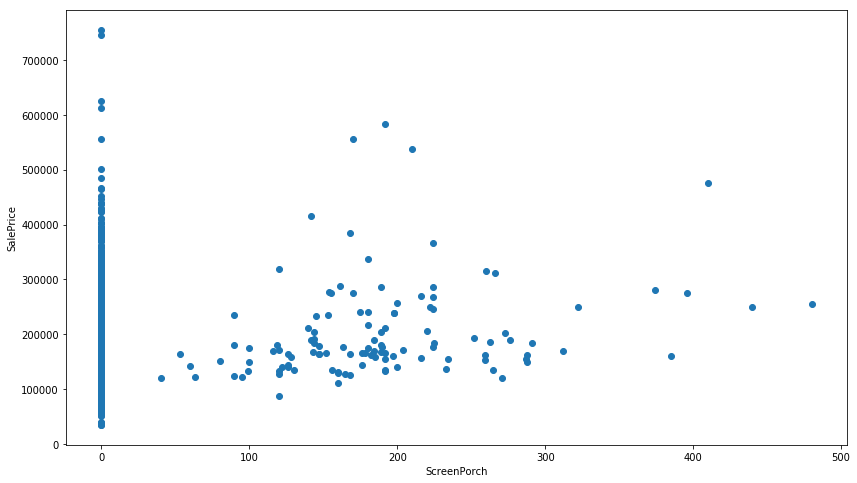

"----------------------------------------------PoolArea-------------------------------------------------


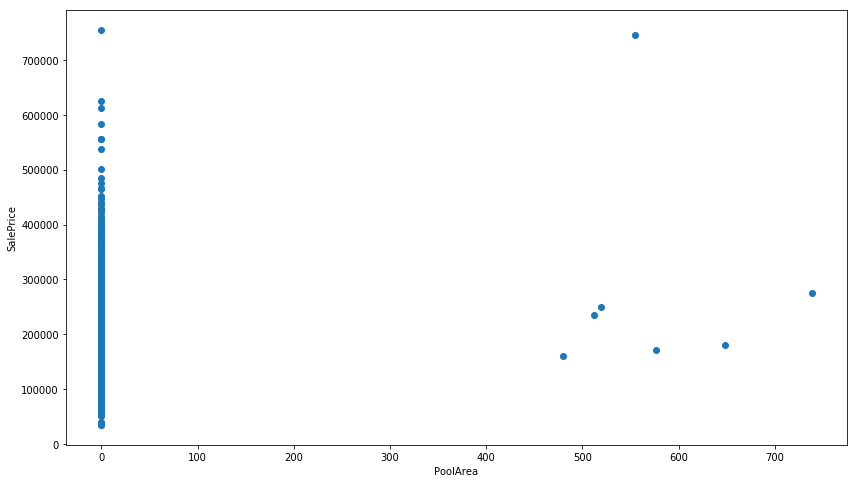

"----------------------------------------------PoolQC-------------------------------------------------


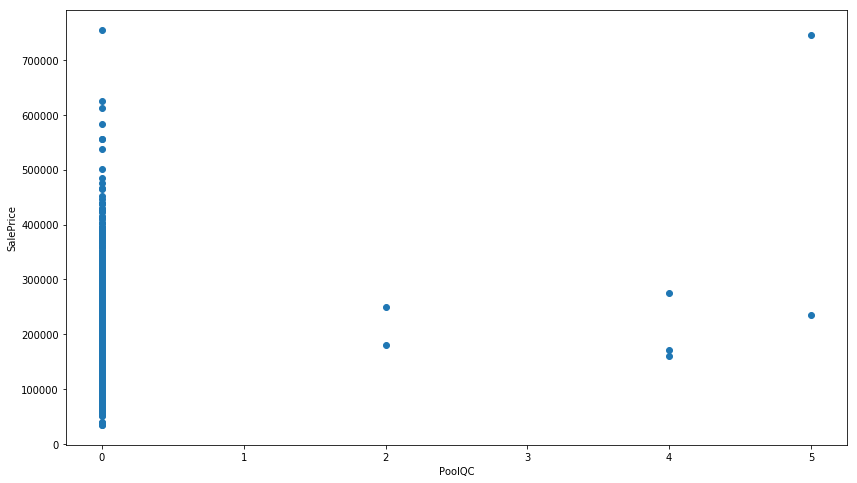

"----------------------------------------------Fence-------------------------------------------------
         SalePrice               
             count           mean
Fence                            
GdPrv           59  178927.457627
GdWo            54  140379.314815
MnPrv          157  148751.089172
MnWw            11  134286.363636
No_fence      1179  187596.837998


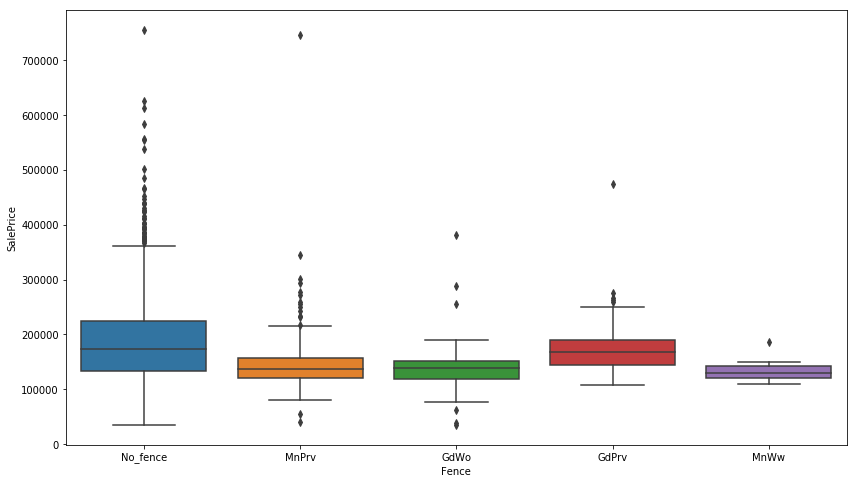

"----------------------------------------------MiscFeature-------------------------------------------------
               SalePrice               
                   count           mean
MiscFeature                            
Gar2                   2  170750.000000
No_miscFeature      1406  182046.410384
Othr                   2   94000.000000
Shed                  49  151187.612245
TenC                   1  250000.000000


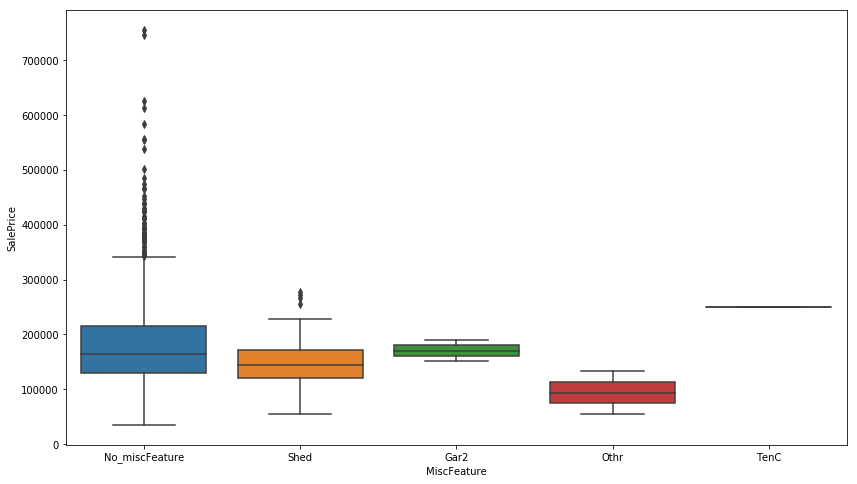

"----------------------------------------------MiscVal-------------------------------------------------


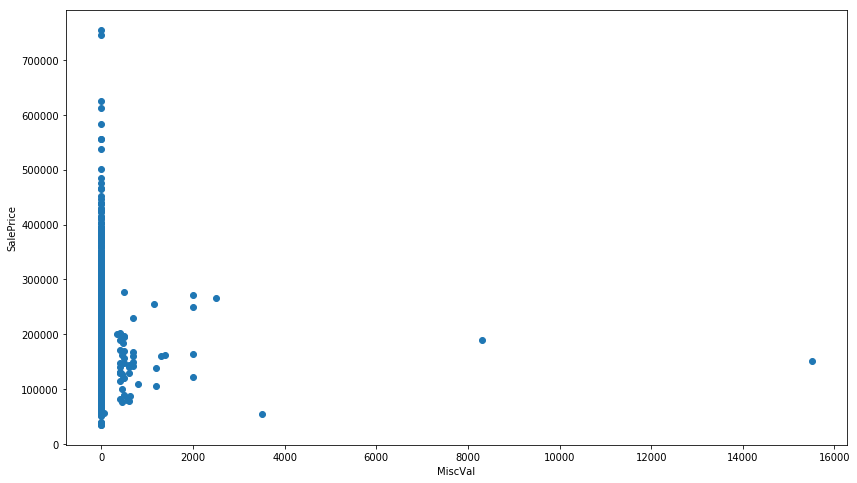

"----------------------------------------------MoSold-------------------------------------------------
       SalePrice               
           count           mean
MoSold                         
m1            58  183256.258621
m10           89  179563.977528
m11           79  192210.911392
m12           59  186518.966102
m2            52  177882.000000
m3           106  183253.924528
m4           141  171503.262411
m5           204  172307.269608
m6           253  177395.735178
m7           234  186331.192308
m8           122  184651.827869
m9            63  195683.206349


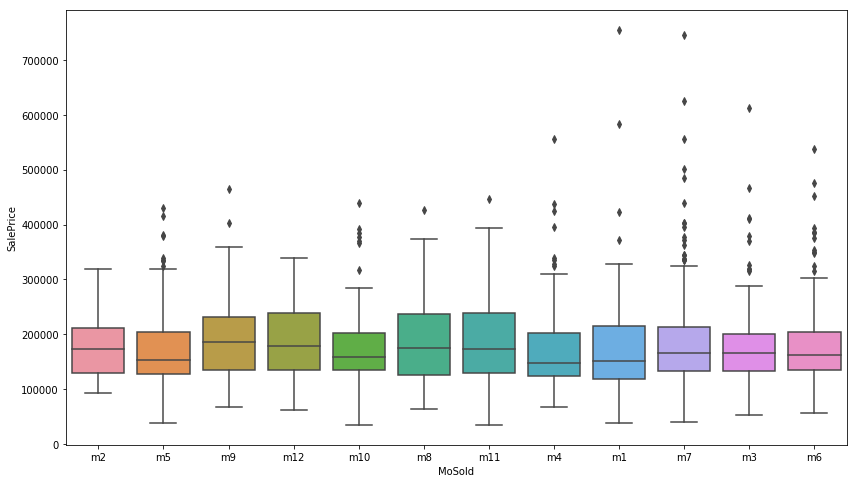

"----------------------------------------------YrSold-------------------------------------------------
       SalePrice               
           count           mean
YrSold                         
y2006        314  182549.458599
y2007        329  186063.151976
y2008        304  177360.838816
y2009        338  179432.103550
y2010        175  177393.674286


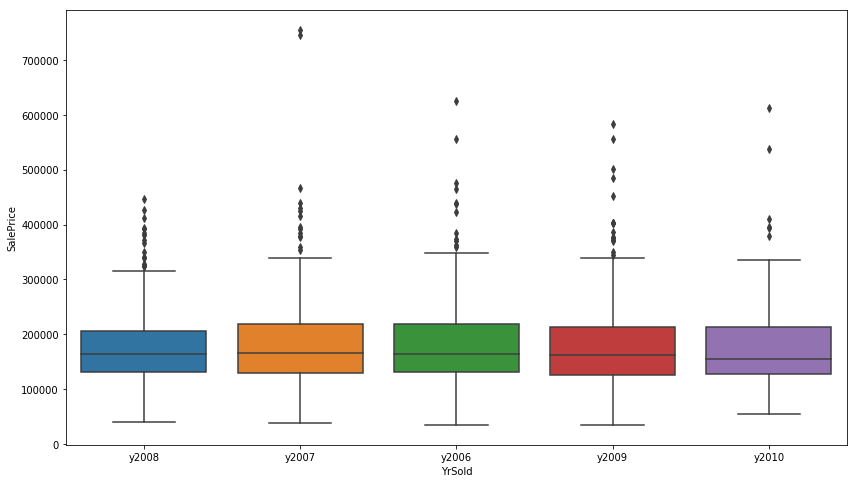

"----------------------------------------------SaleType-------------------------------------------------
         SalePrice               
             count           mean
SaleType                         
COD             43  143973.255814
CWD              4  210600.000000
Con              2  269600.000000
ConLD            9  138780.888889
ConLI            5  200390.000000
ConLw            5  143700.000000
New            122  274945.418033
Oth              3  119850.000000
WD            1267  173401.836622


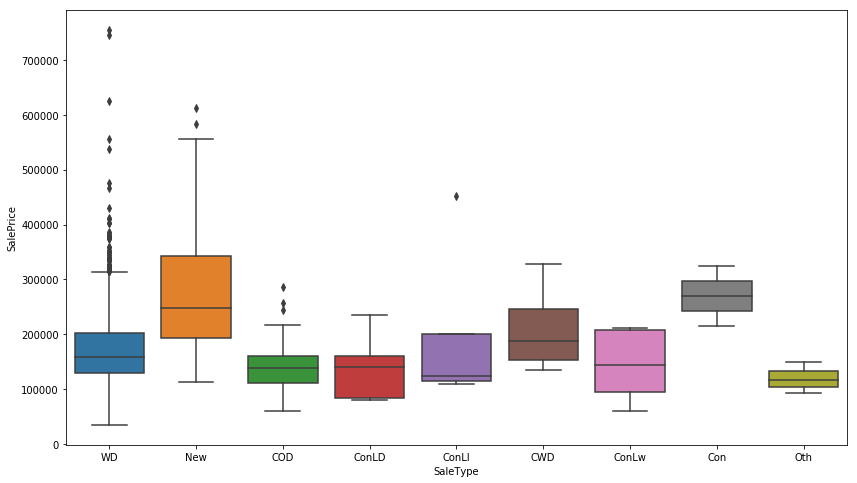

"----------------------------------------------SaleCondition-------------------------------------------------
              SalePrice               
                  count           mean
SaleCondition                         
Abnorml             101  146526.623762
AdjLand               4  104125.000000
Alloca               12  167377.416667
Family               20  149600.000000
Normal             1198  175202.219533
Partial             125  272291.752000


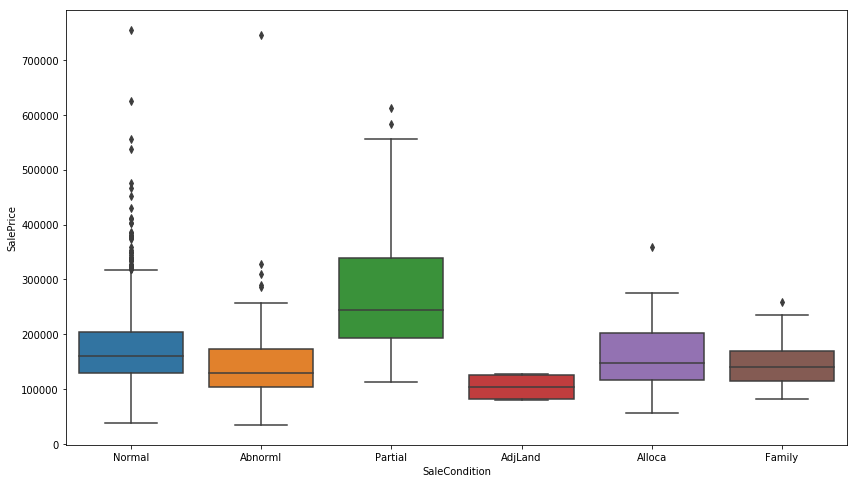

"----------------------------------------------train-------------------------------------------------


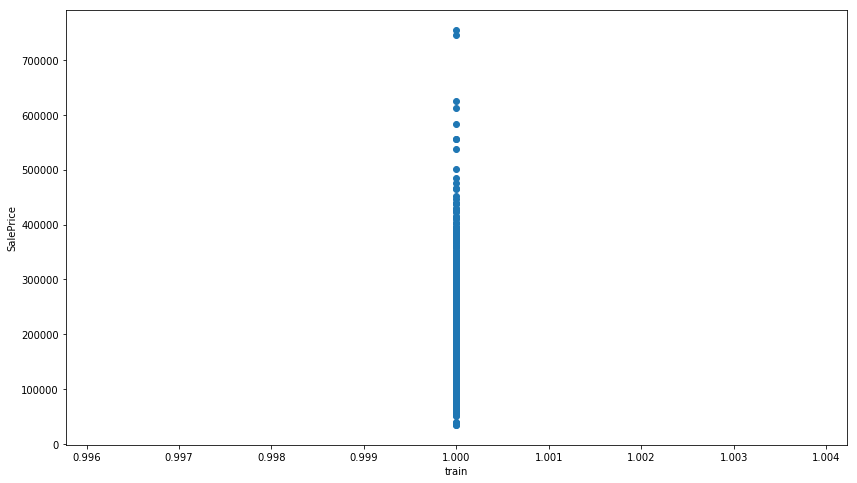

"----------------------------------------------YearsOld-------------------------------------------------


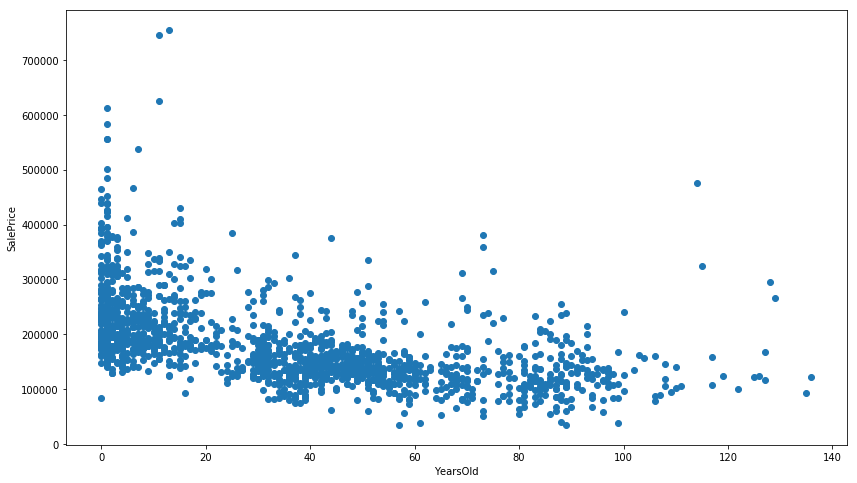

"----------------------------------------------YearSinceRemodel-------------------------------------------------


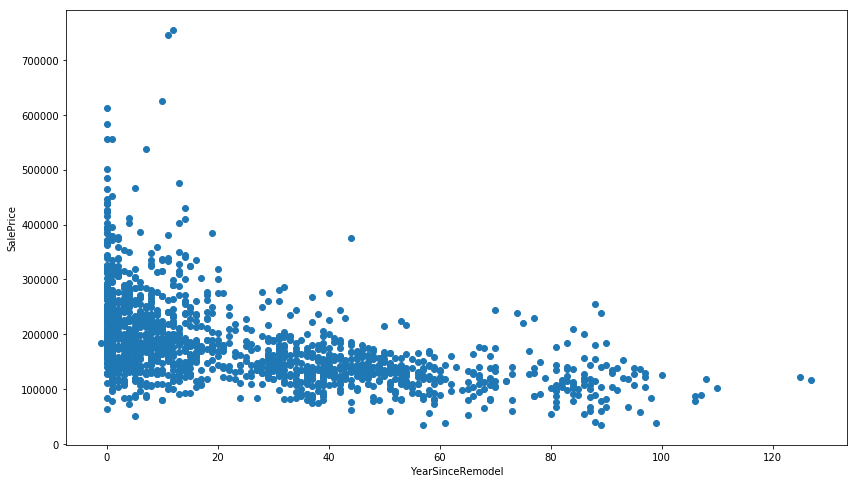

"----------------------------------------------YearBuiltAdj-------------------------------------------------


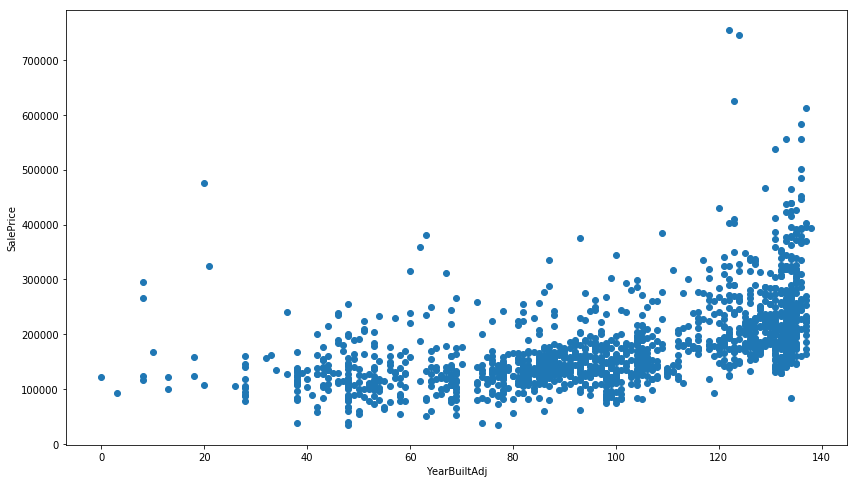

"----------------------------------------------YearRemodAddAdj-------------------------------------------------


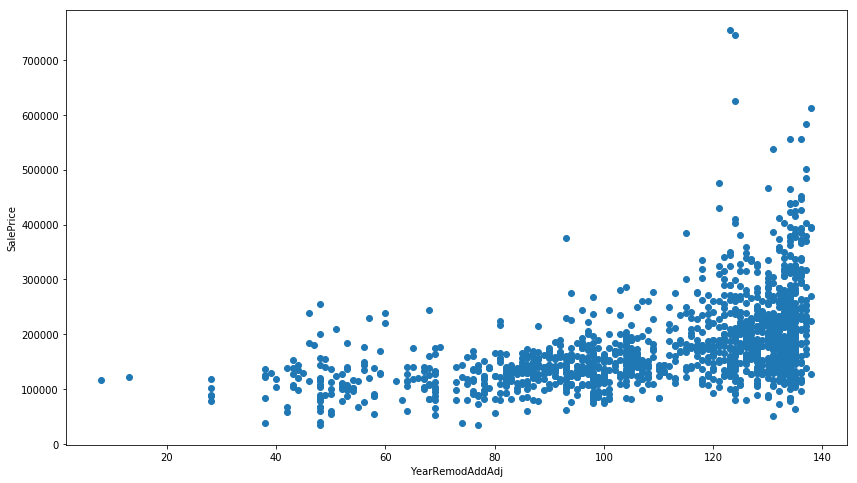

"----------------------------------------------YearSinceGarageBlt-------------------------------------------------


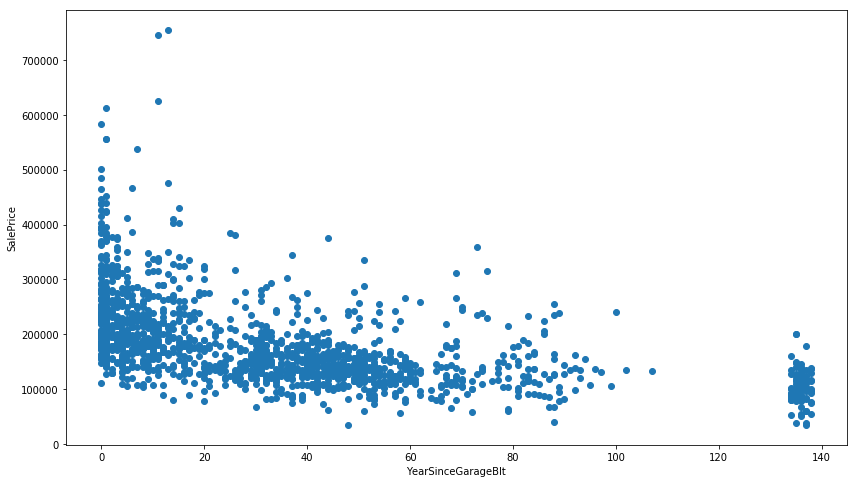

"----------------------------------------------GarageYrBltAdj-------------------------------------------------


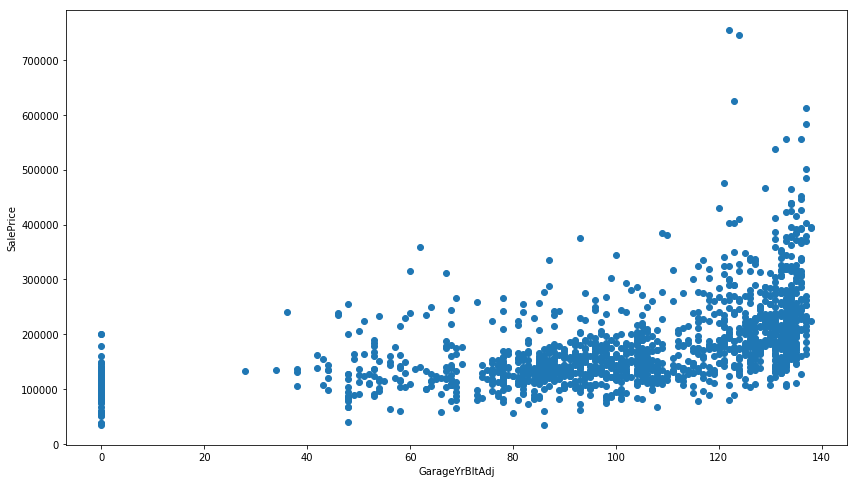

"----------------------------------------------YrSold-Month-------------------------------------------------
             SalePrice               
                 count           mean
YrSold-Month                         
2006-1              10  201090.000000
2006-10             24  172356.708333
2006-11             16  213285.000000
2006-12             12  185545.000000
2006-2               9  194322.222222
2006-3              25  184982.200000
2006-4              27  174312.814815
2006-5              38  158928.289474
2006-6              48  172283.333333
2006-7              67  183211.059701
2006-8              23  196239.956522
2006-9              15  223768.866667
2007-1              13  183234.615385
2007-10             16  215428.812500
2007-11             24  197709.333333
2007-12             18  214414.500000
2007-2               8  176301.750000
2007-3              23  176567.782609
2007-4              23  170772.608696
2007-5              43  169873.511628
2007-6           

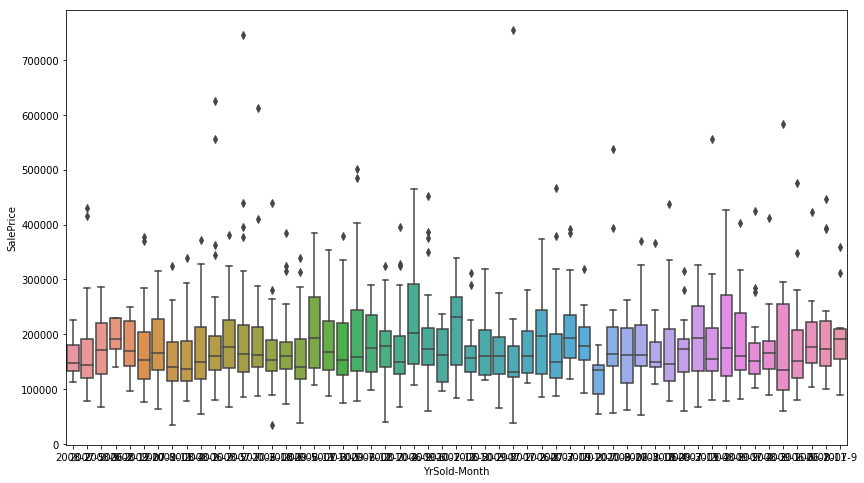

"----------------------------------------------BsmtBath-------------------------------------------------


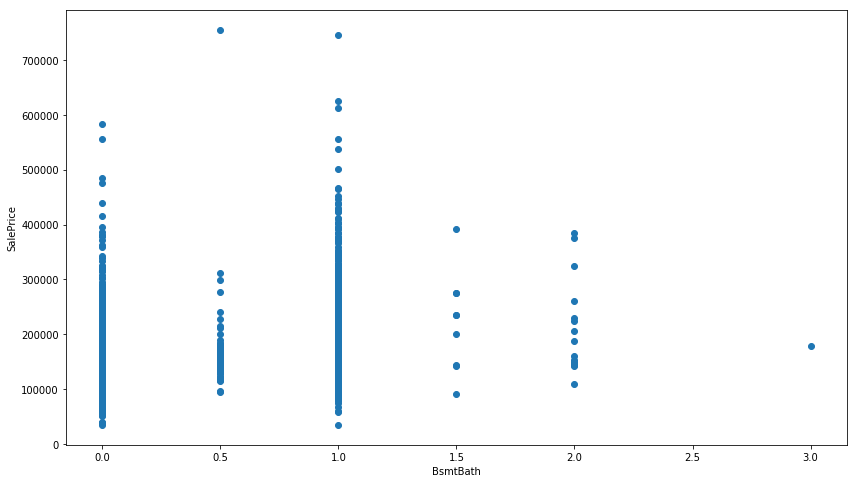

"----------------------------------------------Bath-------------------------------------------------


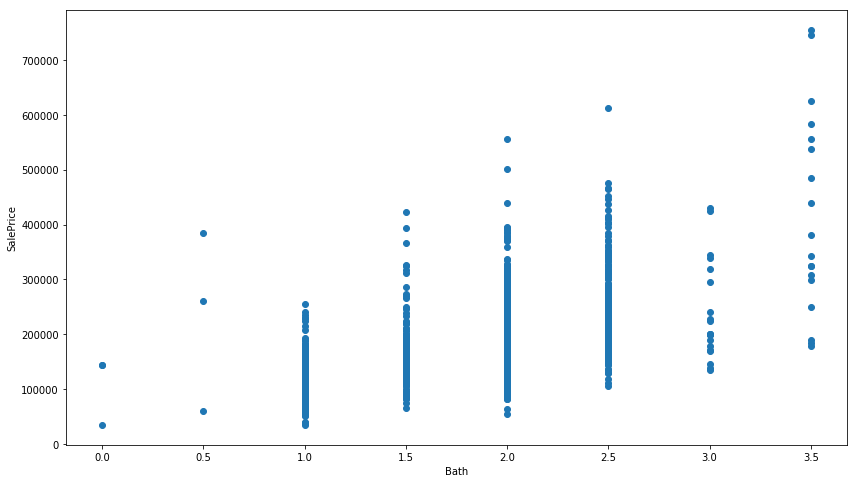

"----------------------------------------------Basement-------------------------------------------------


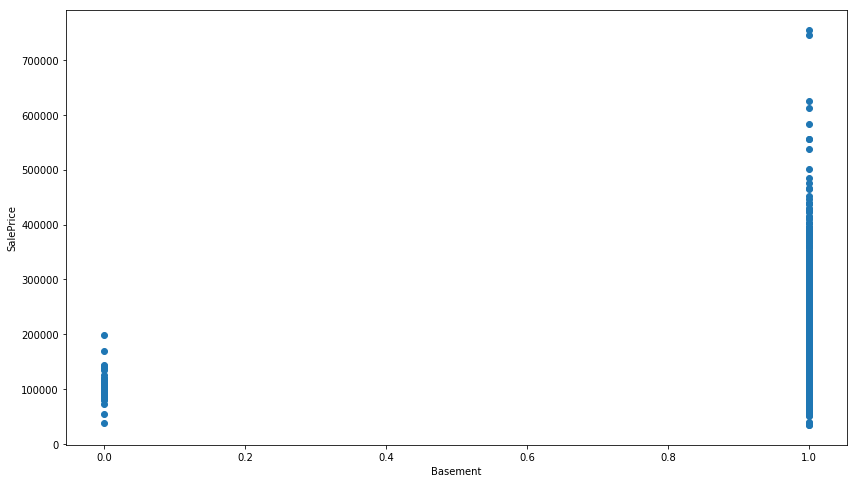

"----------------------------------------------BsmtScore-------------------------------------------------


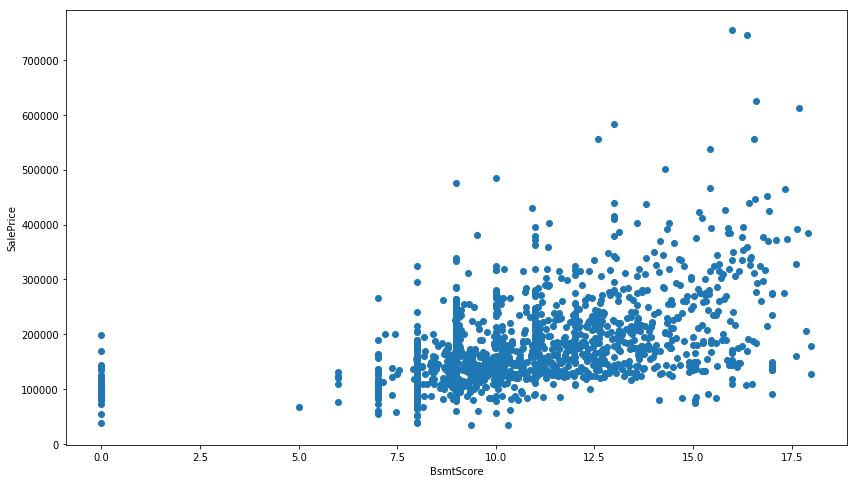

"----------------------------------------------TotalSF-------------------------------------------------


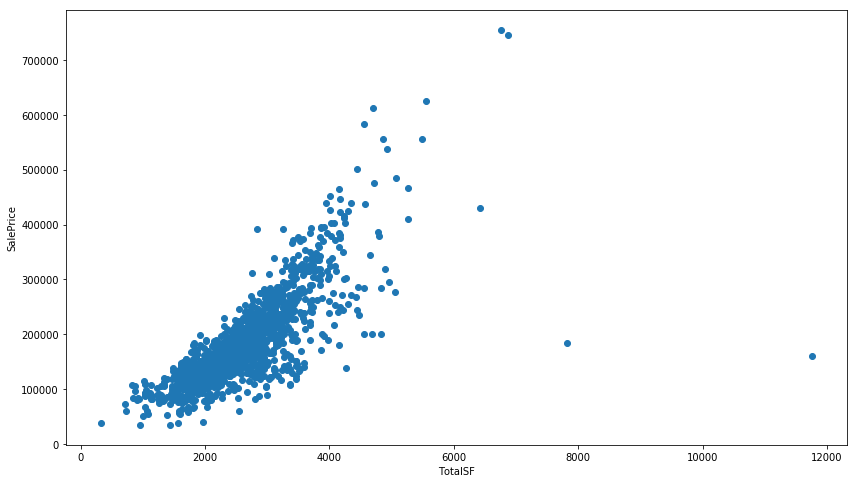

"----------------------------------------------SF_score-------------------------------------------------


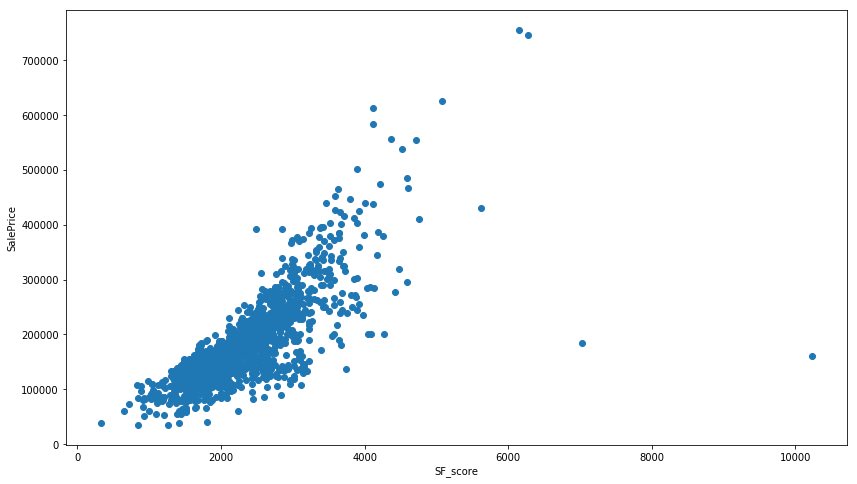

"----------------------------------------------OverallQual_exp-------------------------------------------------


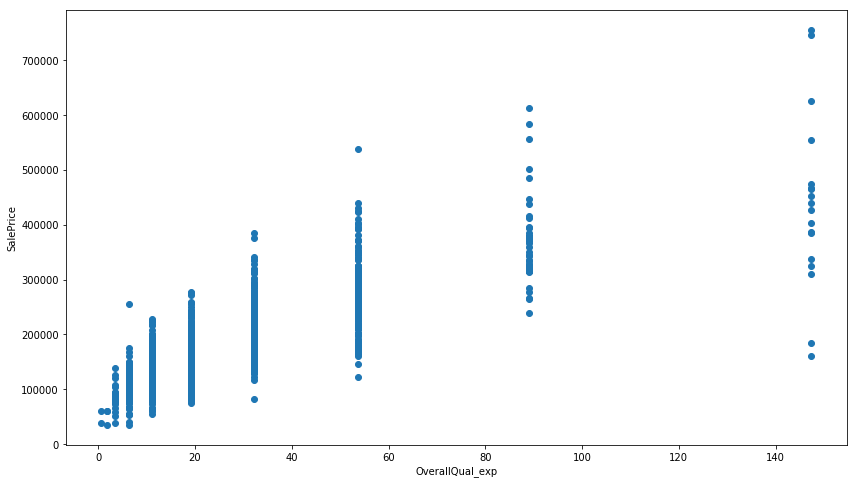

"----------------------------------------------YearsOld_log-------------------------------------------------


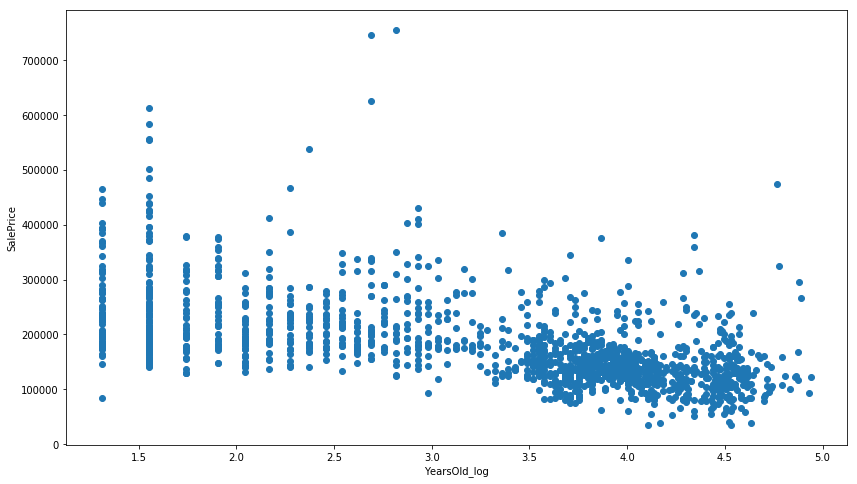

"----------------------------------------------YearSinceGarageBlt_log-------------------------------------------------


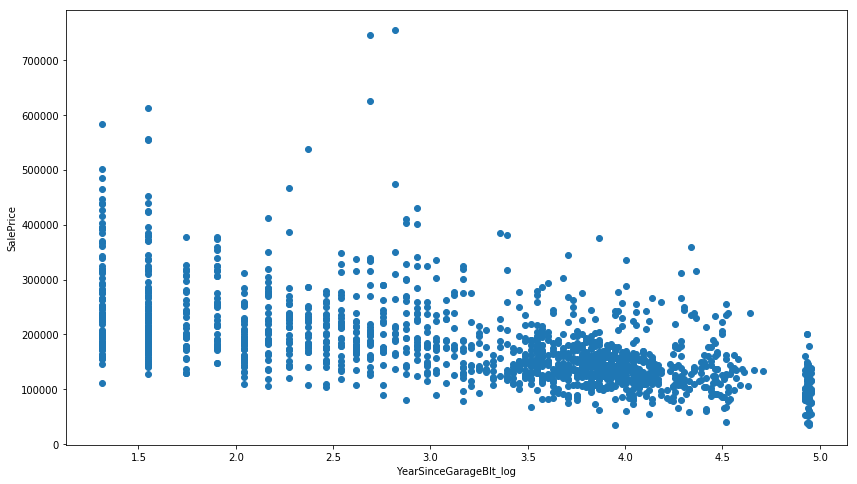

"----------------------------------------------YearSinceRemodel_log-------------------------------------------------


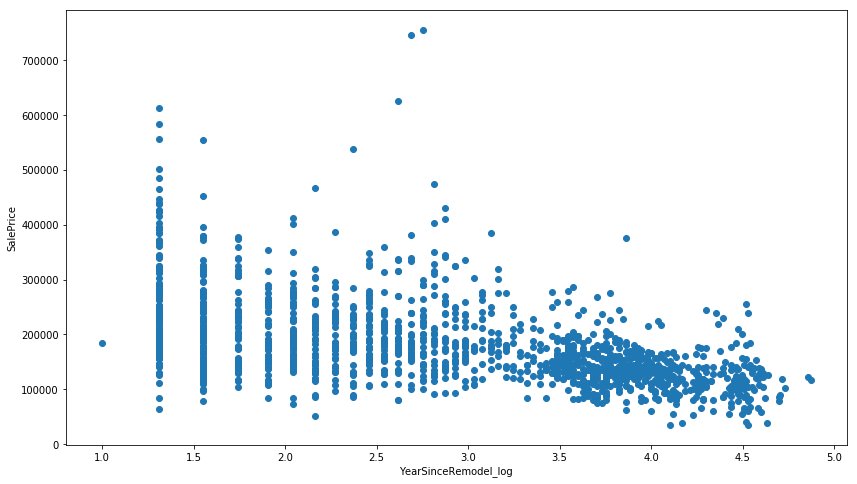

"----------------------------------------------SalePrice-------------------------------------------------


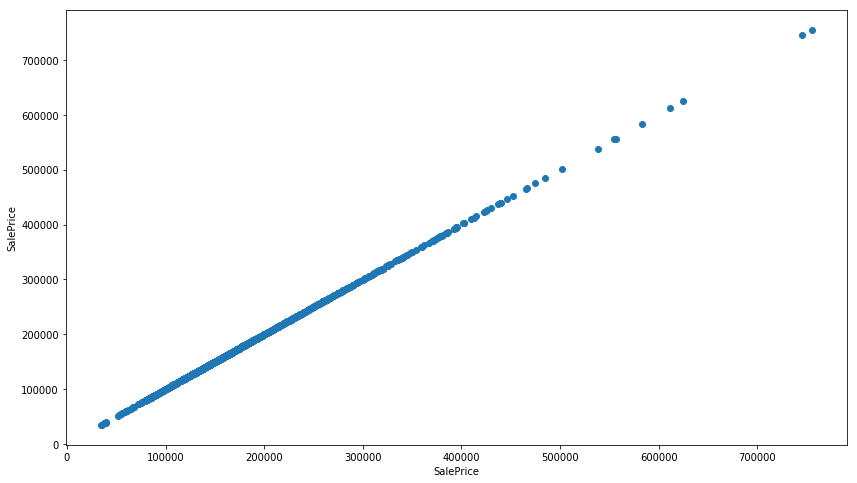

In [1412]:
target='SalePrice'
temp = x_train
temp['SalePrice'] = list(y_train)
for col in list(temp.columns.values)[1:len(temp.columns)]:
    try:
        if np.issubdtype(x_train[col].dtype, np.number) == True:
            print("\x1b[31m\"----------------------------------------------" + col  + "-------------------------------------------------""\x1b[0m")
            plt.figure(figsize=(14,8))
            matplotlib.pyplot.scatter(temp[col],temp[target])
        else:
            print("\x1b[31m\"----------------------------------------------" + col  + "-------------------------------------------------""\x1b[0m")
            plt.figure(figsize=(14,8))
            sns.boxplot(x=temp[col], y=temp[target])
            print(temp.groupby(col).agg({target:['count','mean']})) 
        plt.xlabel(col)
        plt.ylabel(target)
        plt.show()
    except:
        pass

del temp

           SalePrice               
               count           mean
MSSubClass                         
s120              87  200779.080460
s160              63  138647.380952
s180              10  102300.000000
s190              30  129613.333333
s20              536  185224.811567
s30               69   95829.724638
s40                4  156125.000000
s45               12  108591.666667
s50              144  143302.972222
s60              299  239948.501672
s70               60  166772.416667
s75               16  192437.500000
s80               58  169736.551724
s85               20  147810.000000
s90               52  133541.076923


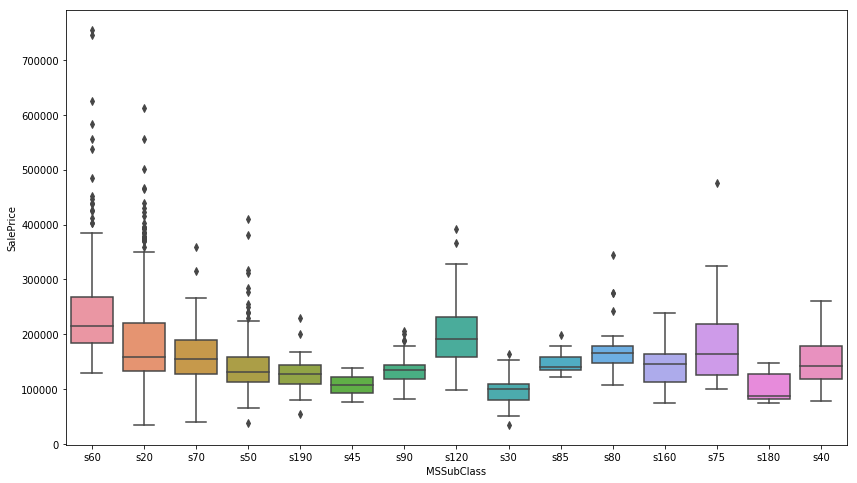

         SalePrice               
             count           mean
MSZoning                         
C (all)         10   74528.000000
FV              65  214014.061538
RH              16  131558.375000
RL            1151  191004.994787
RM             218  126316.830275


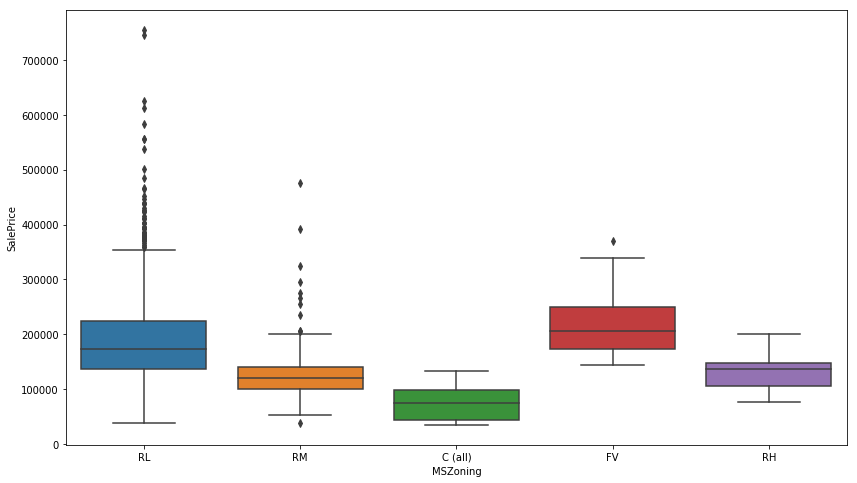

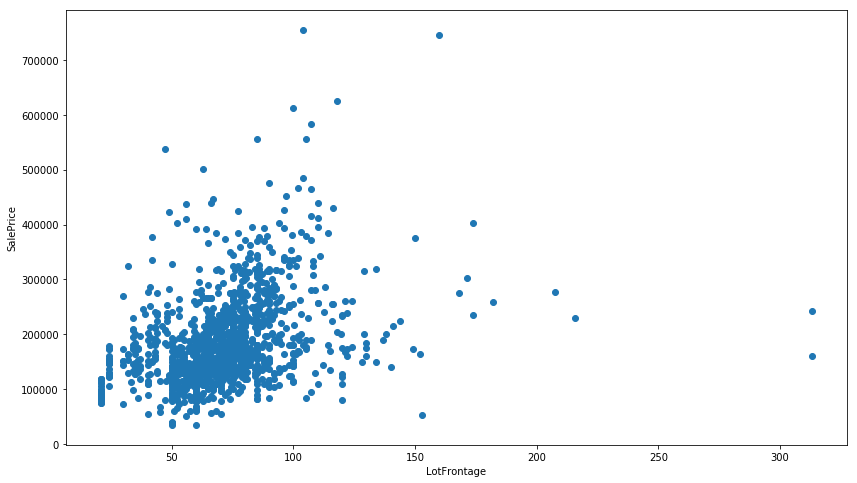

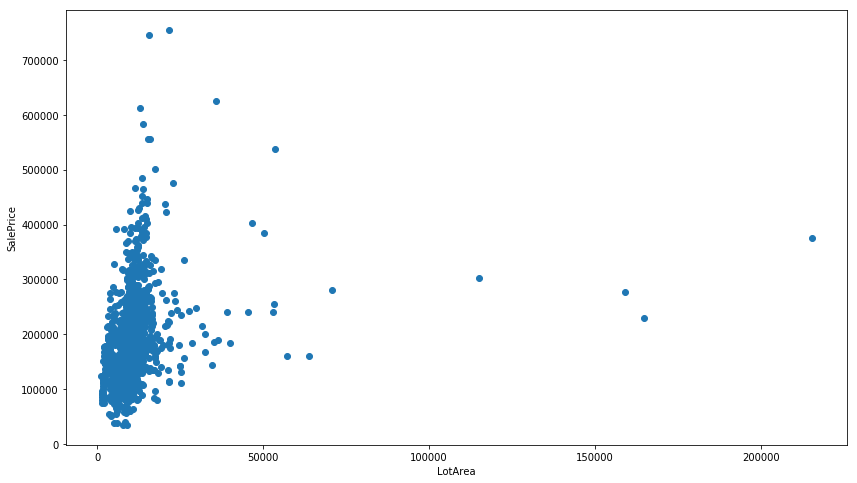

       SalePrice               
           count           mean
Street                         
Grvl           6  130190.500000
Pave        1454  181130.538514


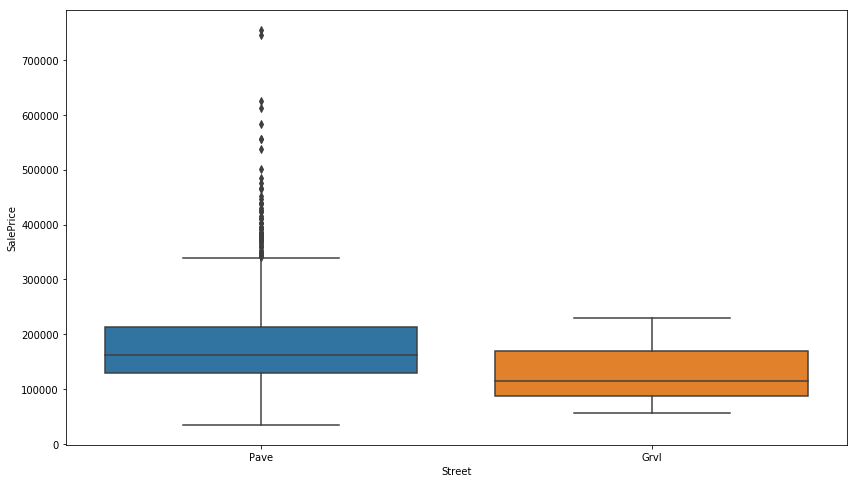

         SalePrice               
             count           mean
Alley                            
Grvl            50  122219.080000
No_alley      1369  183452.131483
Pave            41  168000.585366


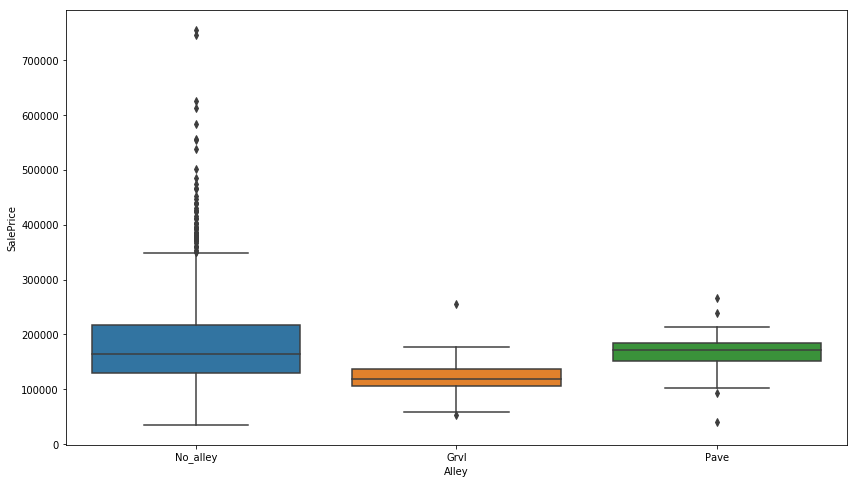

         SalePrice               
             count           mean
LotShape                         
IR1            484  206101.665289
IR2             41  239833.365854
IR3             10  216036.500000
Reg            925  164754.818378


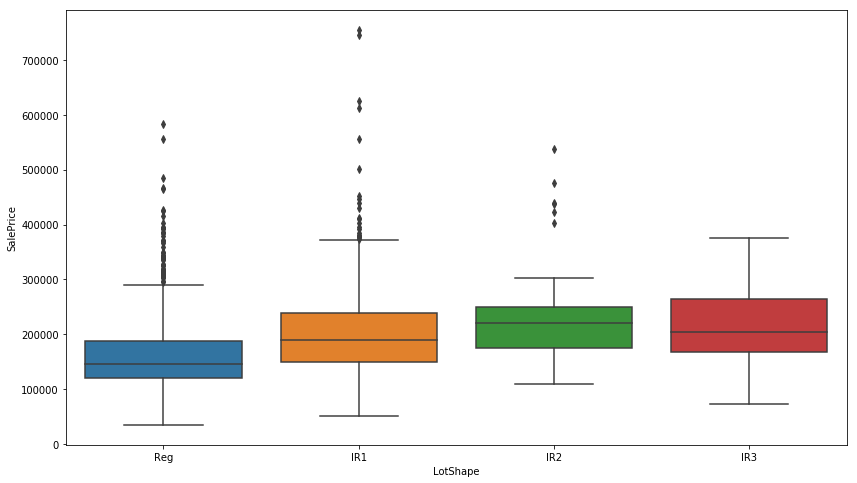

            SalePrice               
                count           mean
LandContour                         
Bnk                63  143104.079365
HLS                50  231533.940000
Low                36  203661.111111
Lvl              1311  180183.746758


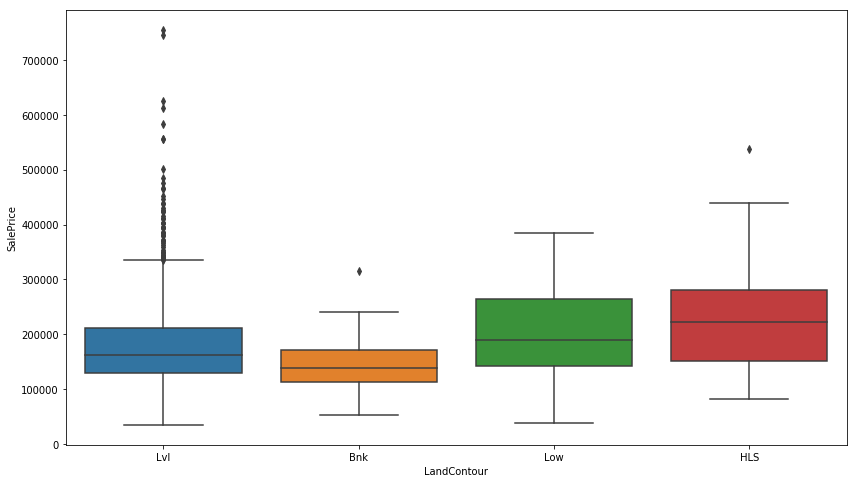

          SalePrice              
              count          mean
Utilities                        
AllPub         1459  180950.95682
NoSeWa            1  137500.00000


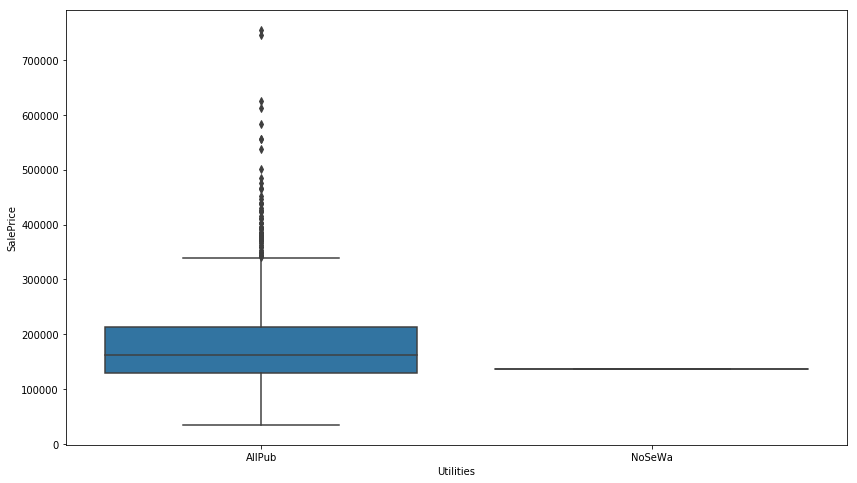

          SalePrice               
              count           mean
LotConfig                         
Corner          263  181623.425856
CulDSac          94  223854.617021
FR2              47  177934.574468
FR3               4  208475.000000
Inside         1052  176938.047529


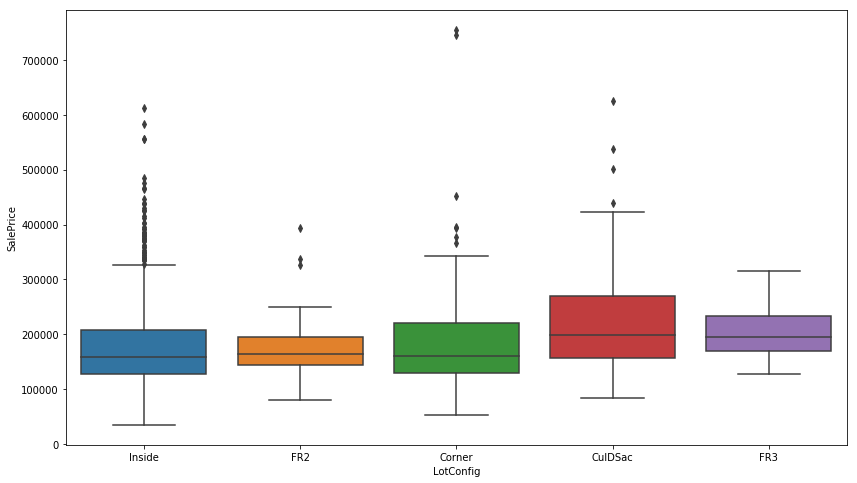

          SalePrice               
              count           mean
LandSlope                         
Gtl            1382  179956.799566
Mod              65  196734.138462
Sev              13  204379.230769


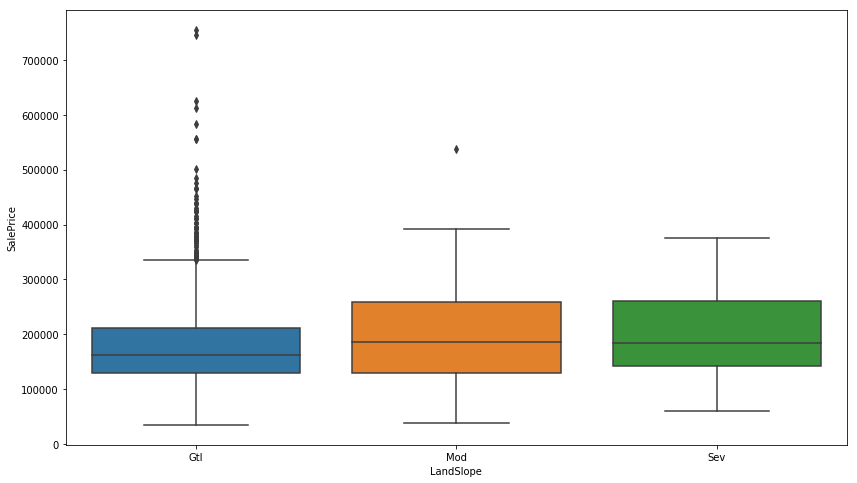

             SalePrice               
                 count           mean
Neighborhood                         
Blmngtn             17  194870.882353
Blueste              2  137500.000000
BrDale              16  104493.750000
BrkSide             58  124834.051724
ClearCr             28  212565.428571
CollgCr            150  197965.773333
Crawfor             51  210624.725490
Edwards            100  128219.700000
Gilbert             79  192854.506329
IDOTRR              37  100123.783784
MeadowV             17   98576.470588
Mitchel             49  156270.122449
NAmes              225  145847.080000
NPkVill              9  142694.444444
NWAmes              73  189050.068493
NoRidge             41  335295.317073
NridgHt             77  316270.623377
OldTown            113  128225.300885
SWISU               25  142591.360000
Sawyer              74  136793.135135
SawyerW             59  186555.796610
Somerst             86  225379.837209
StoneBr             25  310499.000000
Timber      

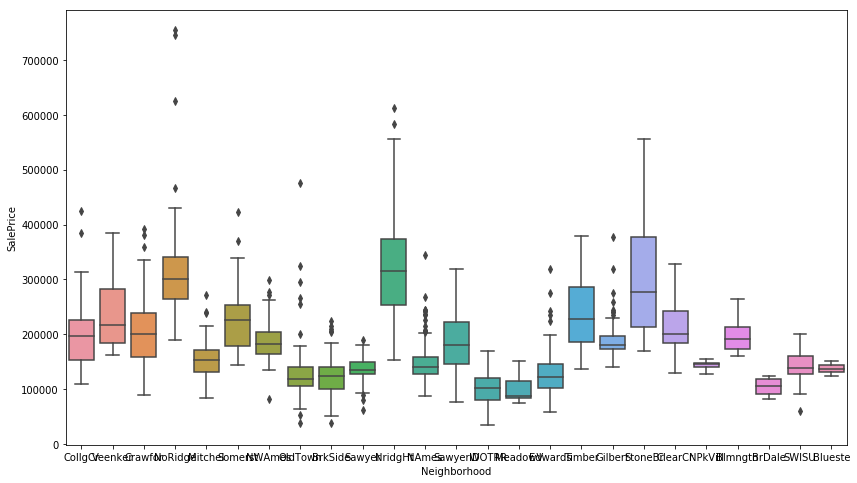

           SalePrice               
               count           mean
Condition1                         
Artery            48  135091.666667
Feedr             81  142475.481481
Norm            1260  184495.492063
PosA               8  225875.000000
PosN              19  215184.210526
RRAe              11  138400.000000
RRAn              26  184396.615385
RRNe               2  190750.000000
RRNn               5  212400.000000


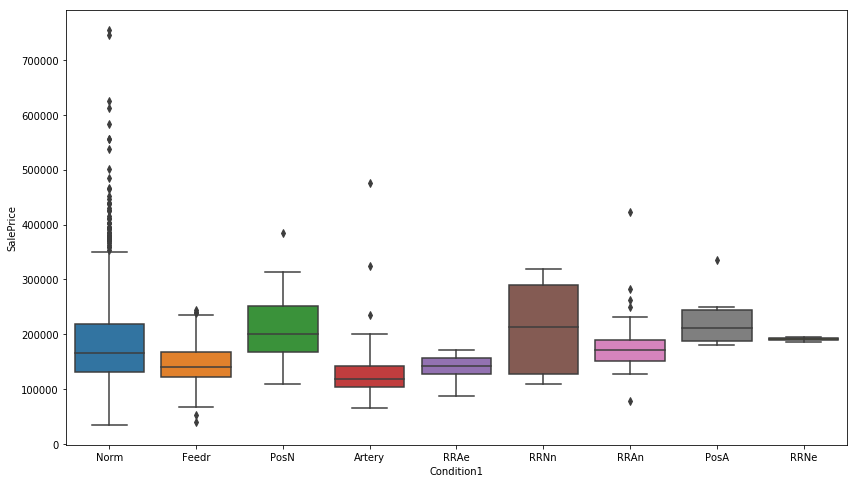

           SalePrice               
               count           mean
Condition2                         
Artery             2  106500.000000
Feedr              6  121166.666667
Norm            1445  181169.405536
PosA               1  325000.000000
PosN               2  284875.000000
RRAe               1  190000.000000
RRAn               1  136905.000000
RRNn               2   96750.000000


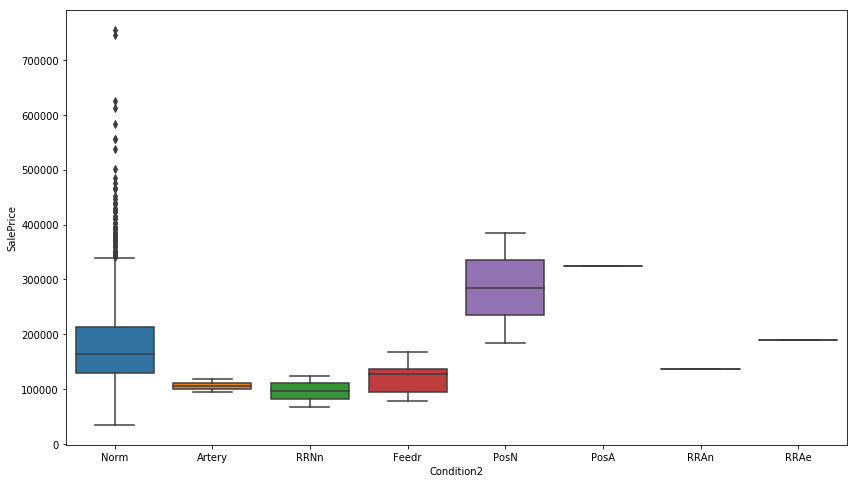

         SalePrice               
             count           mean
BldgType                         
1Fam          1220  185763.807377
2fmCon          31  128432.258065
Duplex          52  133541.076923
Twnhs           43  135911.627907
TwnhsE         114  181959.342105


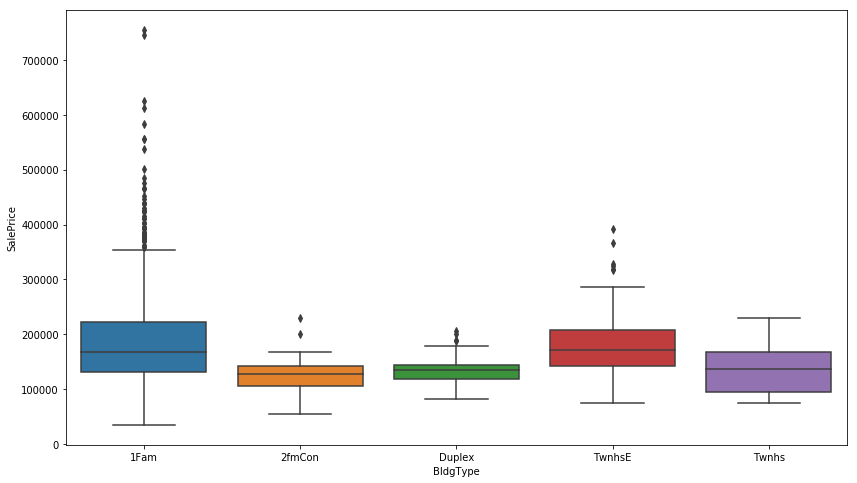

           SalePrice               
               count           mean
HouseStyle                         
1.5Fin           154  143116.740260
1.5Unf            14  110150.000000
1Story           726  175985.477961
2.5Fin             8  220000.000000
2.5Unf            11  157354.545455
2Story           445  210051.764045
SFoyer            37  135074.486486
SLvl              65  166703.384615


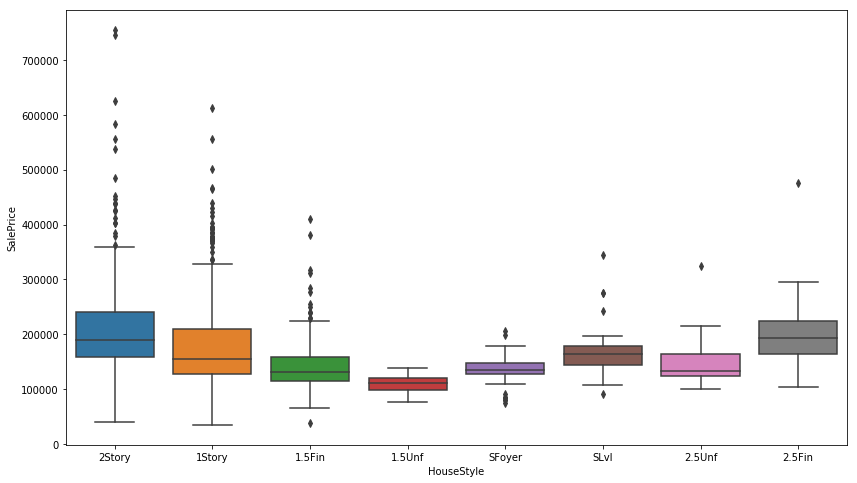

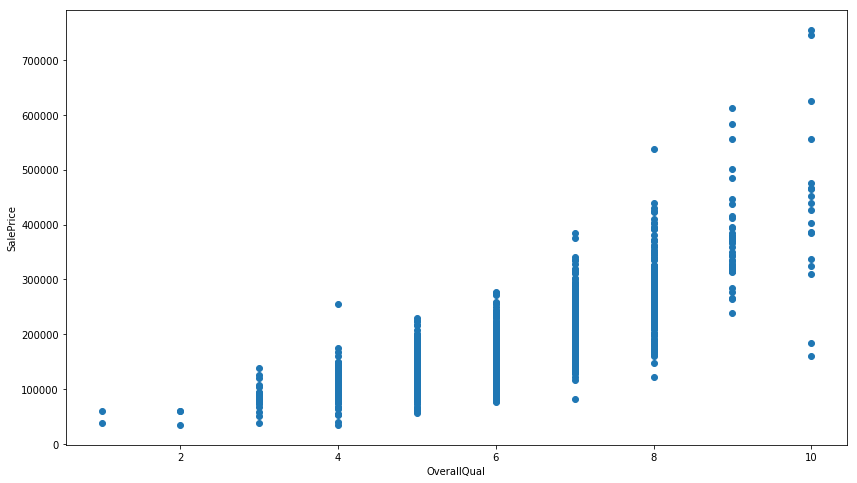

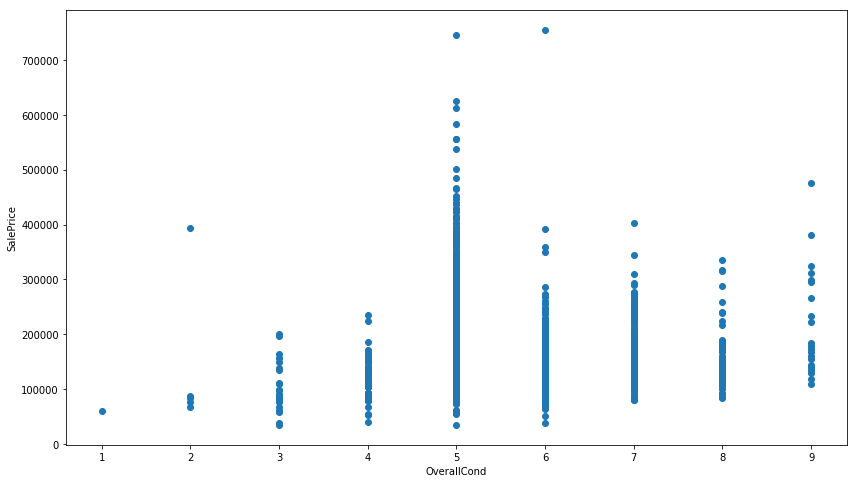

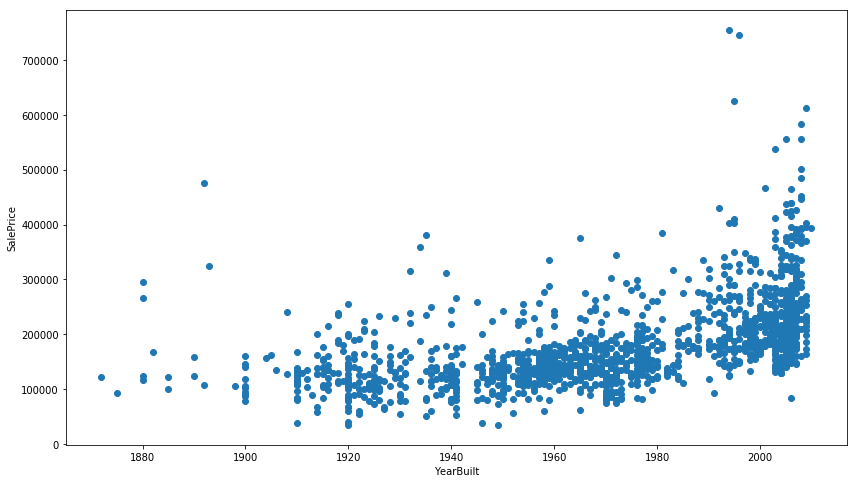

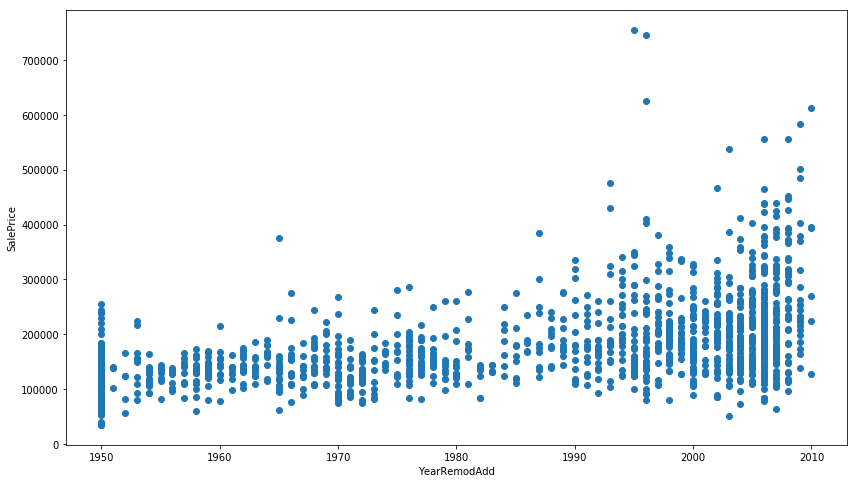

          SalePrice               
              count           mean
RoofStyle                         
Flat             13  194690.000000
Gable          1141  171483.956179
Gambrel          11  148909.090909
Hip             286  218876.933566
Mansard           7  180568.428571
Shed              2  225000.000000


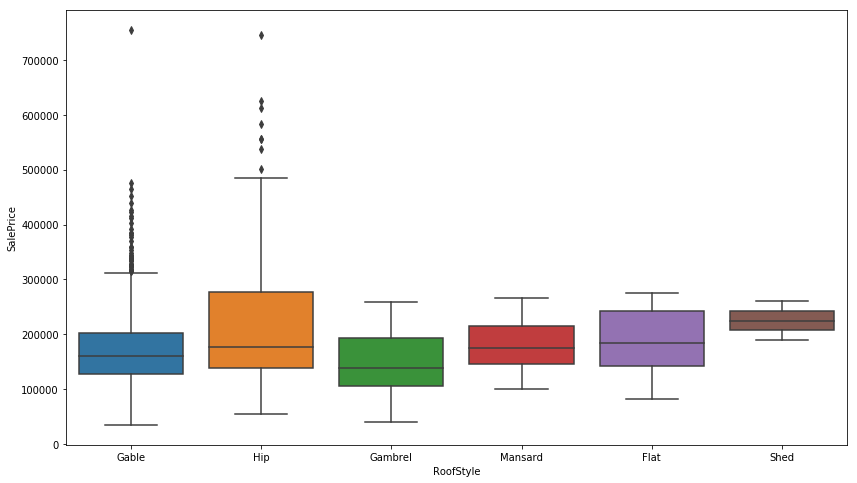

         SalePrice               
             count           mean
RoofMatl                         
ClyTile          1  160000.000000
CompShg       1434  179803.679219
Membran          1  241500.000000
Metal            1  180000.000000
Roll             1  137000.000000
Tar&Grv         11  185406.363636
WdShake          5  241400.000000
WdShngl          6  390250.000000


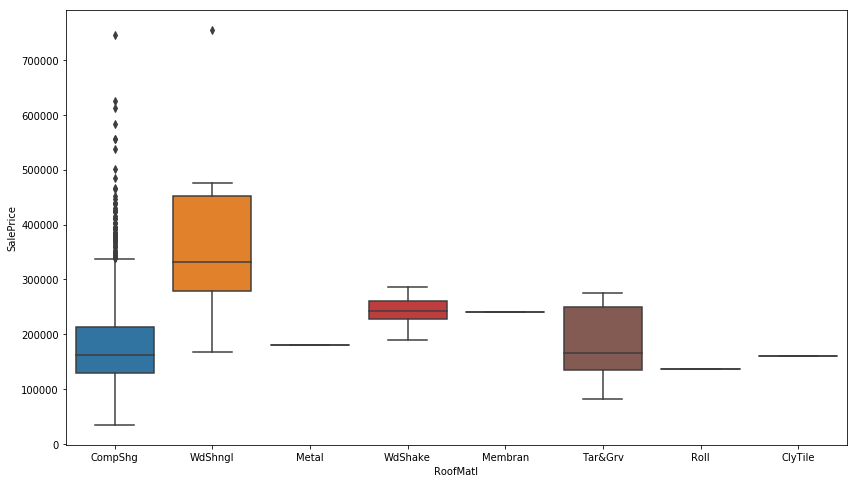

            SalePrice               
                count           mean
Exterior1st                         
AsbShng            20  107385.550000
AsphShn             1  100000.000000
BrkComm             2   71000.000000
BrkFace            50  194573.000000
CBlock              1  105000.000000
CemntBd            61  231690.655738
HdBoard           222  163077.450450
ImStucc             1  262000.000000
MetalSd           220  149422.177273
Plywood           108  175942.379630
Stone               2  258500.000000
Stucco             25  162990.000000
VinylSd           515  213732.900971
Wd Sdng           206  149841.645631
WdShing            26  150655.076923


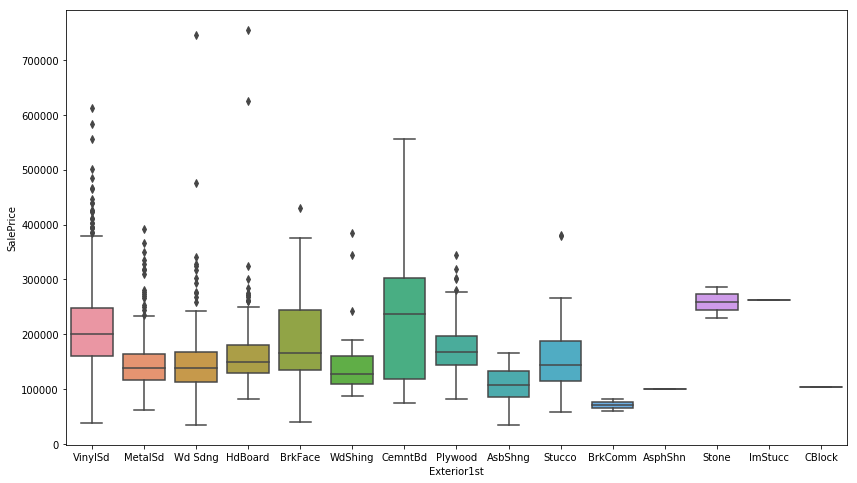

            SalePrice               
                count           mean
Exterior2nd                         
AsbShng            20  114060.550000
AsphShn             3  138000.000000
Brk Cmn             7  126714.285714
BrkFace            25  195818.000000
CBlock              1  105000.000000
CmentBd            60  230093.833333
HdBoard           207  167661.565217
ImStucc            10  252070.000000
MetalSd           214  149803.172897
Other               1  319000.000000
Plywood           142  168112.387324
Stone               5  158224.800000
Stucco             26  155905.153846
VinylSd           504  214432.460317
Wd Sdng           197  148386.065990
Wd Shng            38  161328.947368


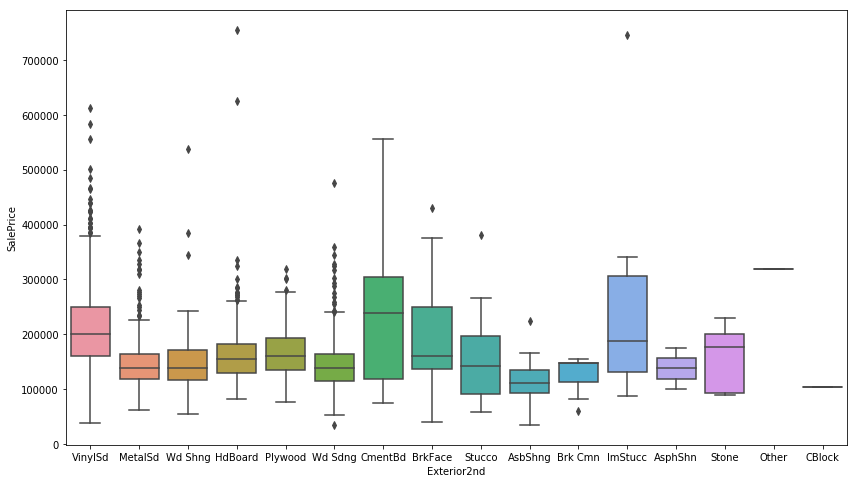

           SalePrice               
               count           mean
MasVnrType                         
BrkCmn            15  146318.066667
BrkFace          445  204691.871910
None             872  156958.243119
Stone            128  265583.625000


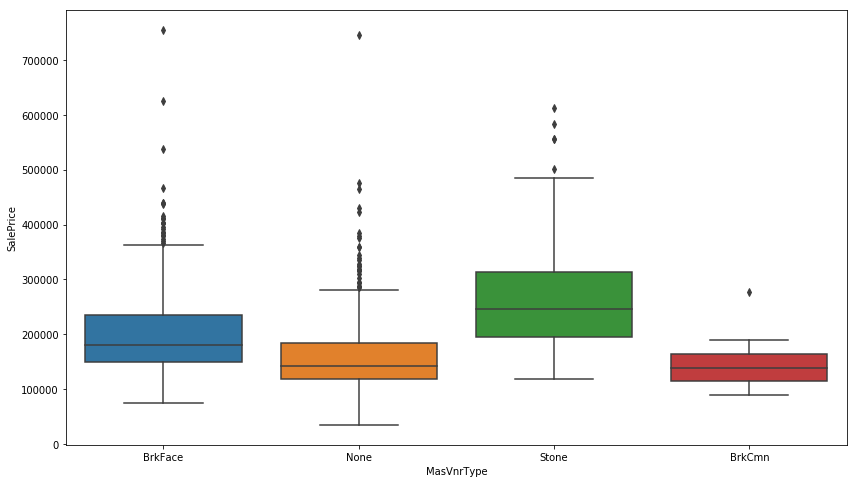

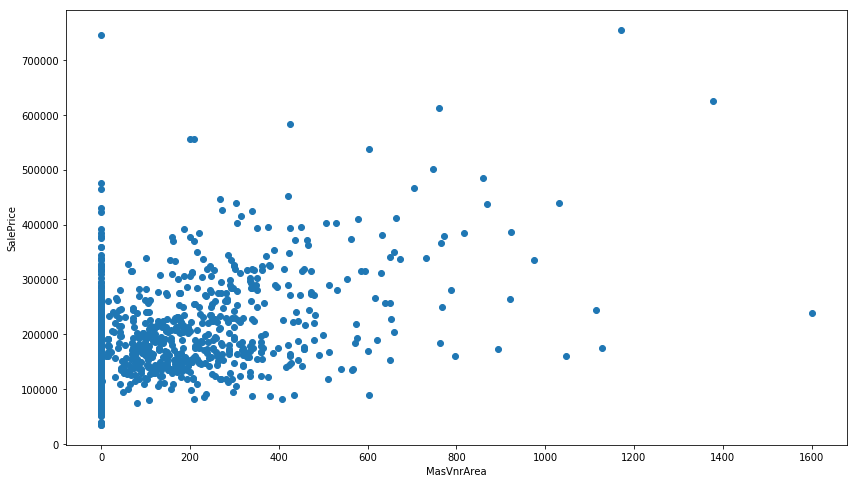

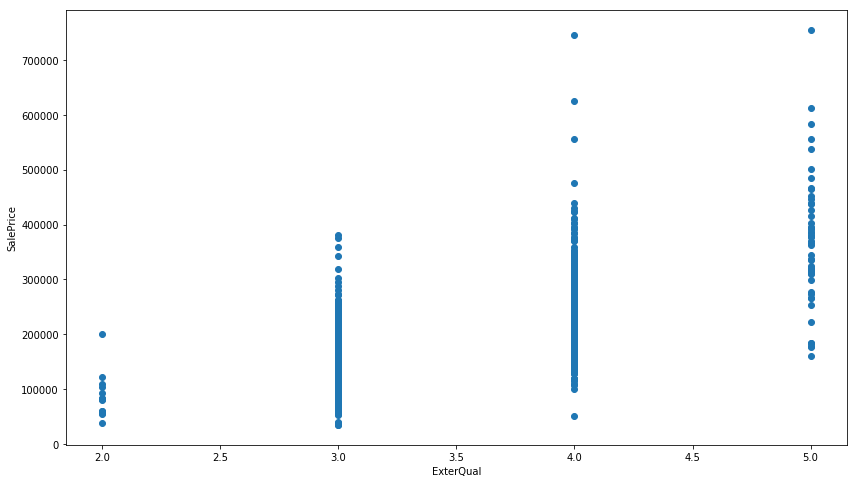

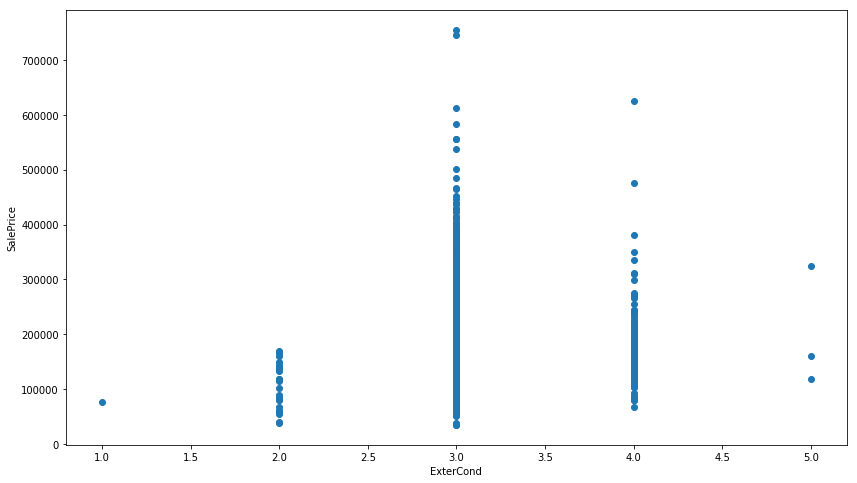

           SalePrice               
               count           mean
Foundation                         
BrkTil           146  132291.075342
CBlock           634  149805.714511
PConc            647  225230.442040
Slab              24  107365.625000
Stone              6  165959.166667
Wood               3  185666.666667


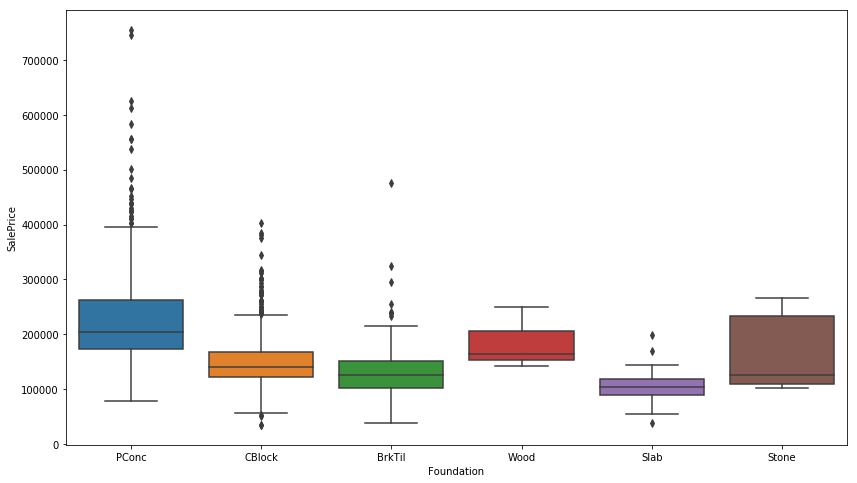

         SalePrice               
             count           mean
BsmtQual                         
Ex             121  327041.041322
Fa              35  115692.028571
Gd             618  202688.478964
TA             649  140759.818182


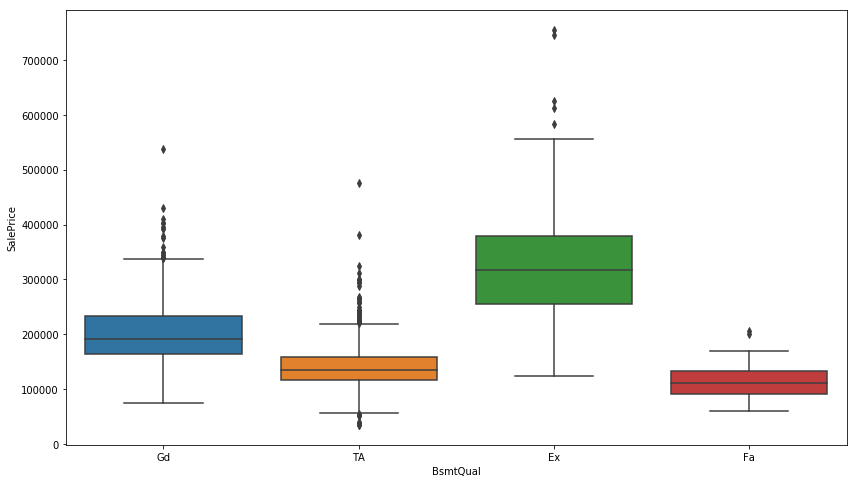

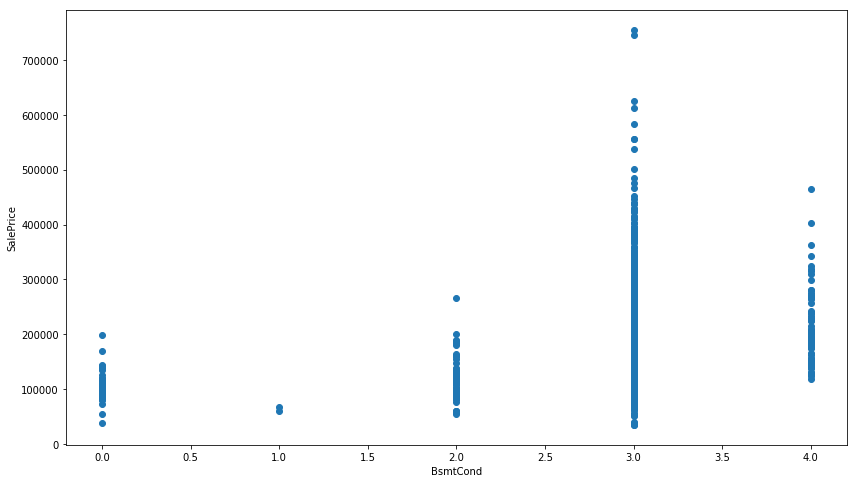

             SalePrice               
                 count           mean
BsmtExposure                         
Av                 221  206643.420814
Gd                 134  257689.805970
Mn                 114  192789.657895
No                 953  165652.295908


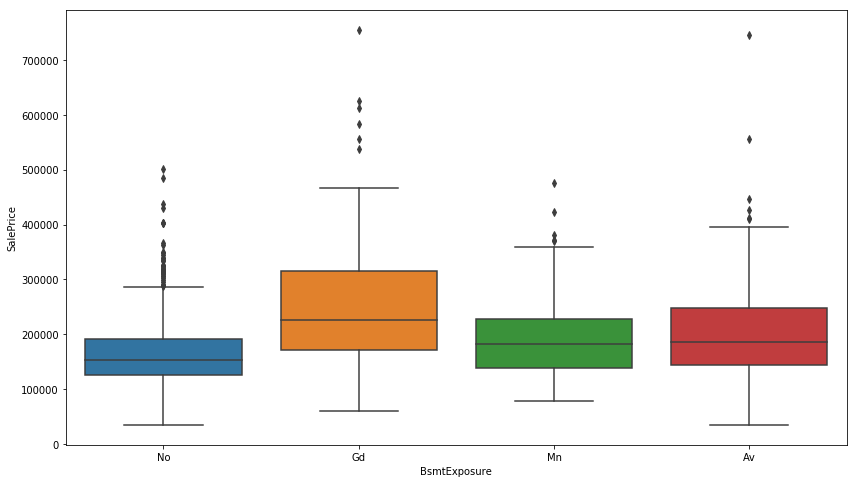

             SalePrice               
                 count           mean
BsmtFinType1                         
ALQ                220  161573.068182
BLQ                148  149493.655405
GLQ                418  235413.720096
LwQ                 74  151852.702703
Rec                133  146889.248120
Unf                430  170670.576744


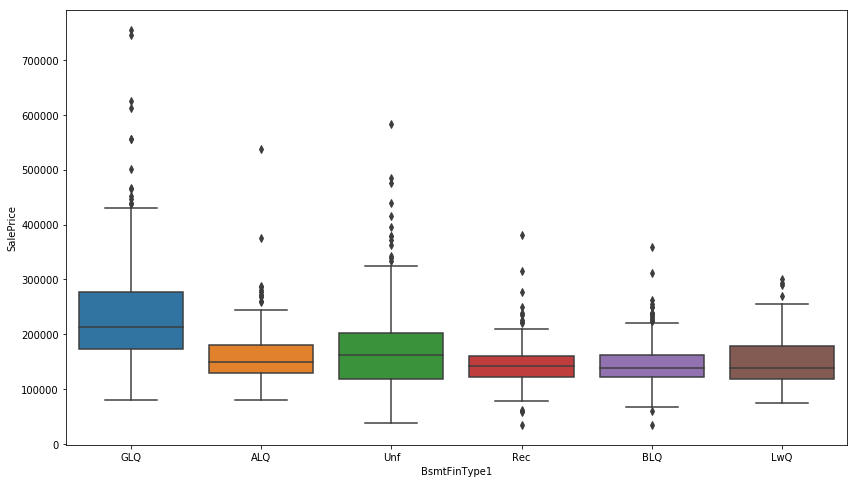

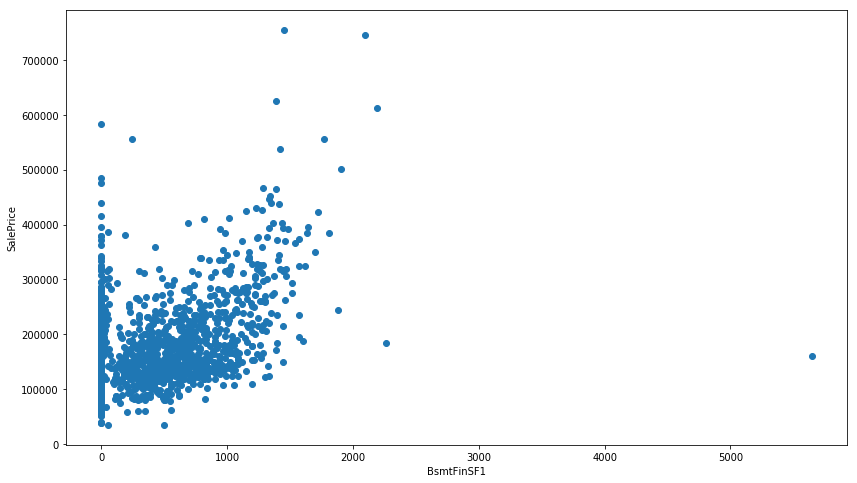

             SalePrice               
                 count           mean
BsmtFinType2                         
ALQ                 19  209942.105263
BLQ                 33  151101.000000
GLQ                 14  180982.142857
LwQ                 46  164364.130435
Rec                 54  164917.129630
Unf               1256  184694.690287


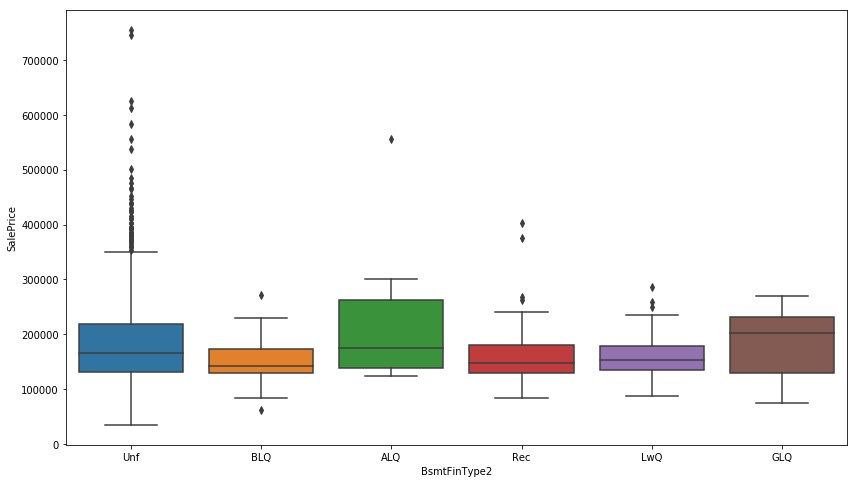

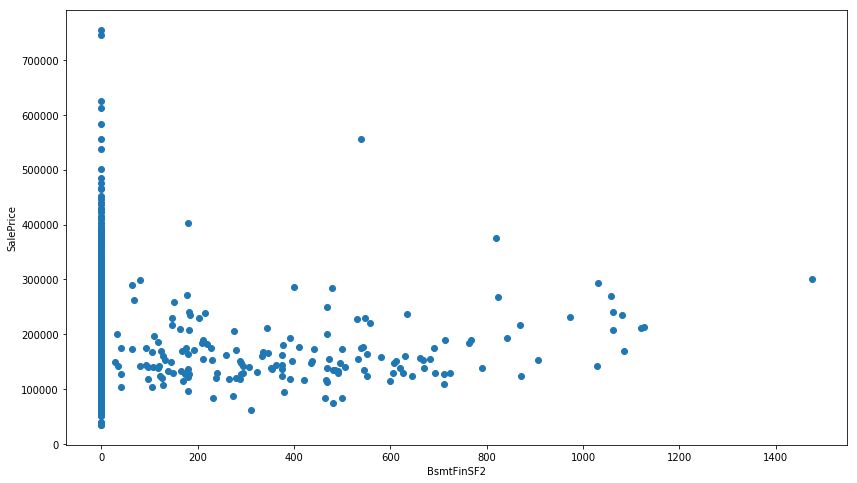

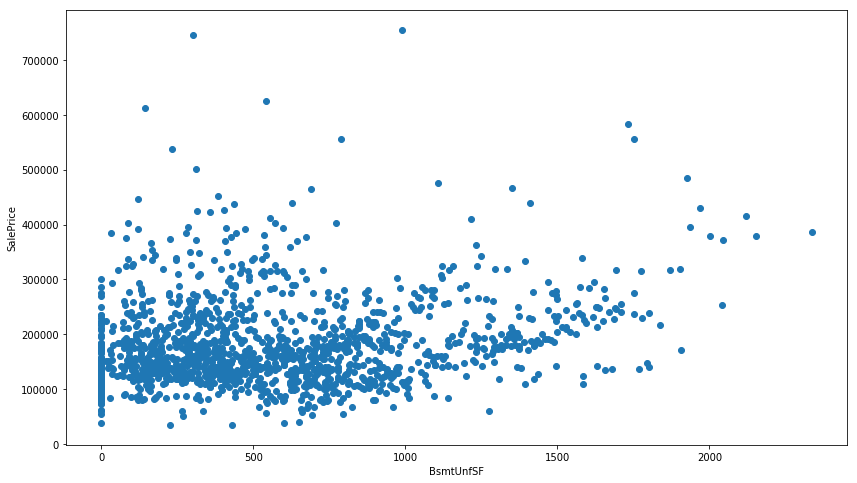

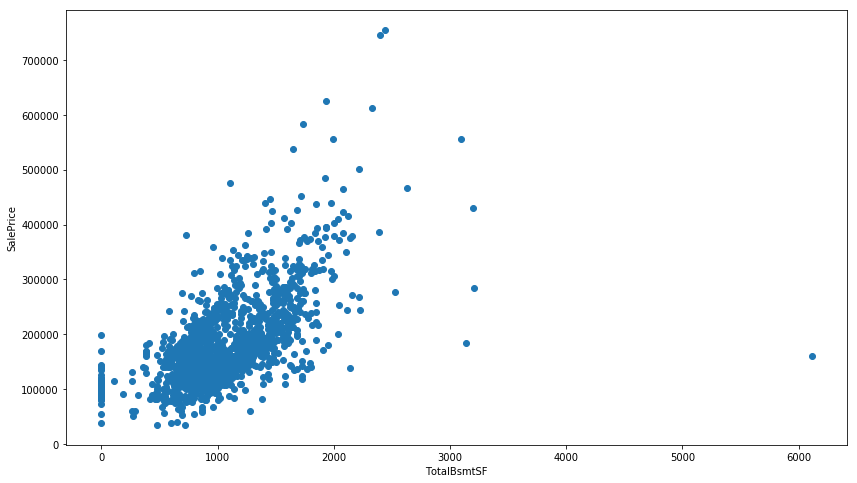

        SalePrice               
            count           mean
Heating                         
Floor           1   72500.000000
GasA         1428  182021.195378
GasW           18  166632.166667
Grav            7   75271.428571
OthW            2  125750.000000
Wall            4   92100.000000


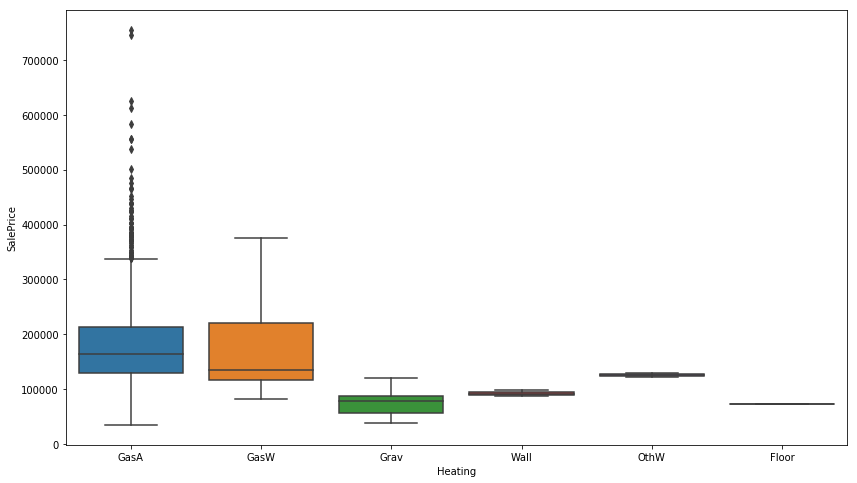

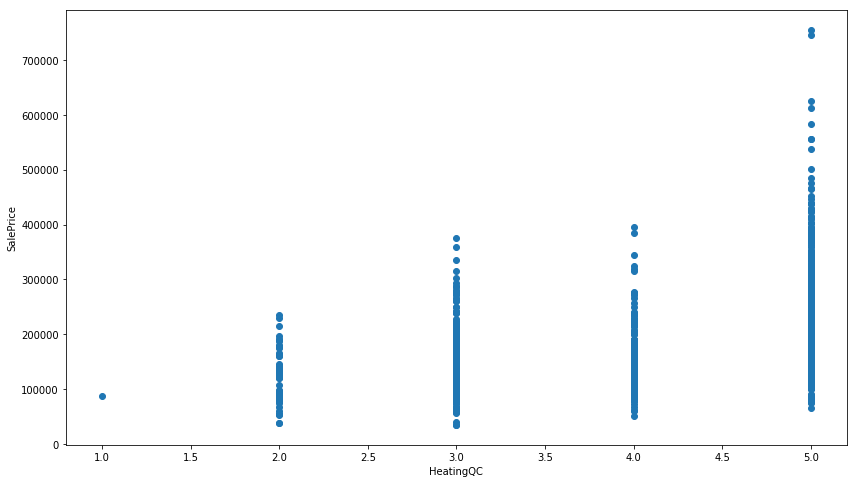

           SalePrice               
               count           mean
CentralAir                         
N                 95  105264.073684
Y               1365  186186.709890


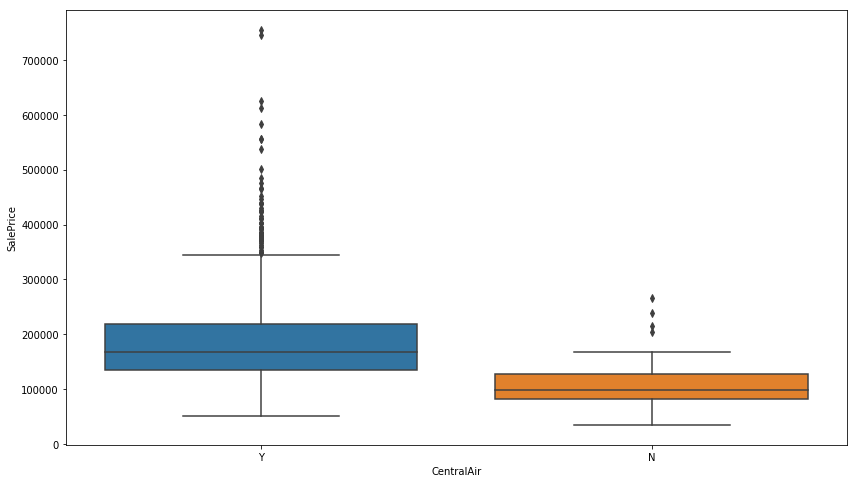

           SalePrice               
               count           mean
Electrical                         
FuseA             94  122196.893617
FuseF             27  107675.444444
FuseP              3   97333.333333
Mix                1   67000.000000
SBrkr           1335  186810.637453


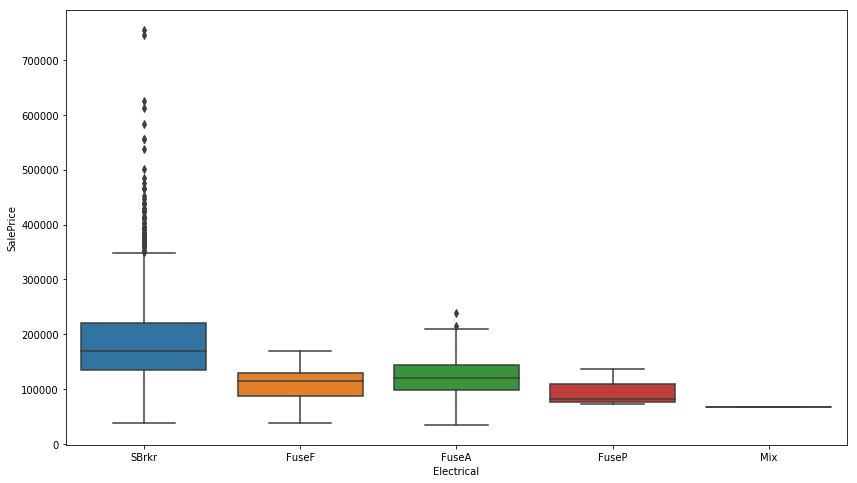

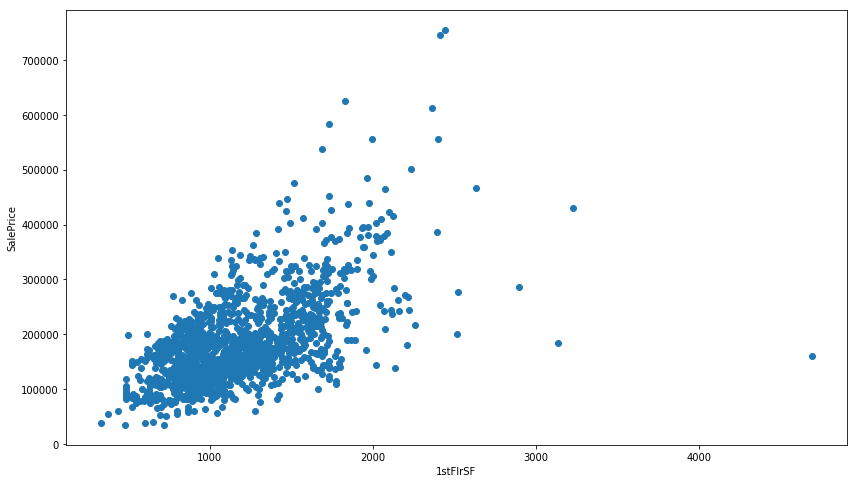

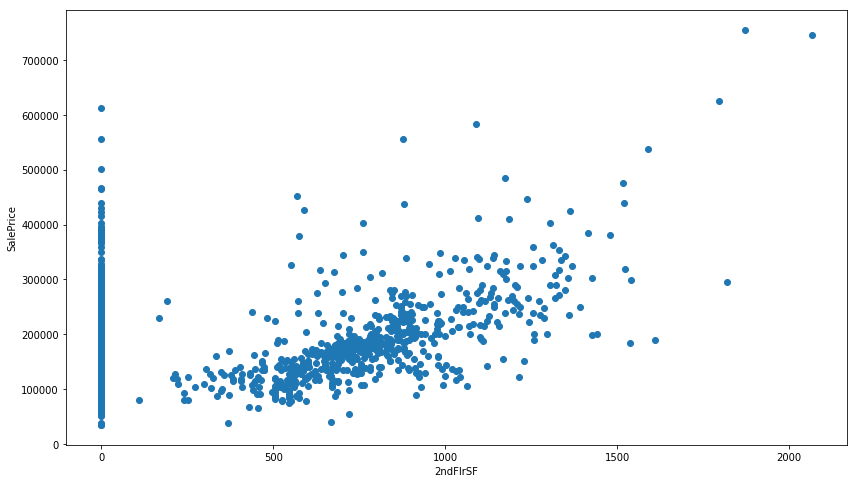

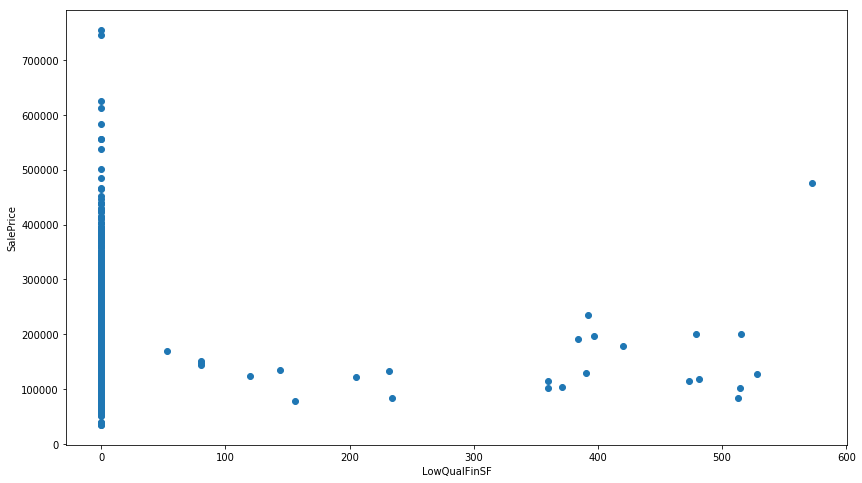

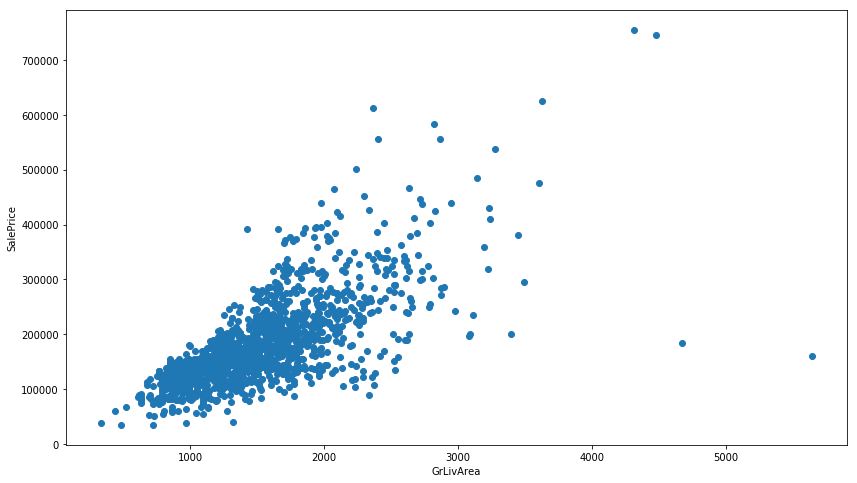

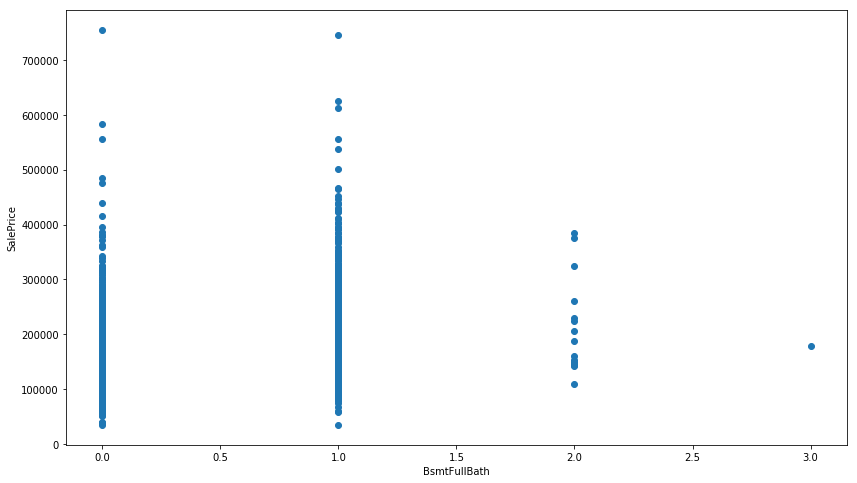

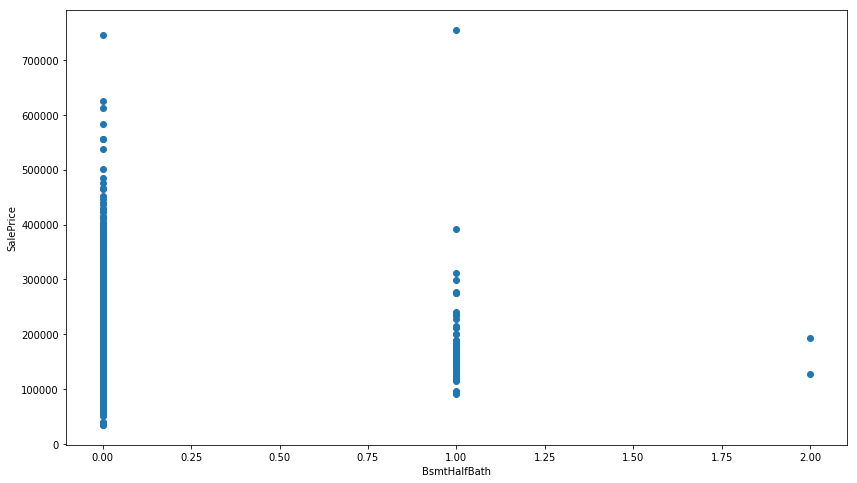

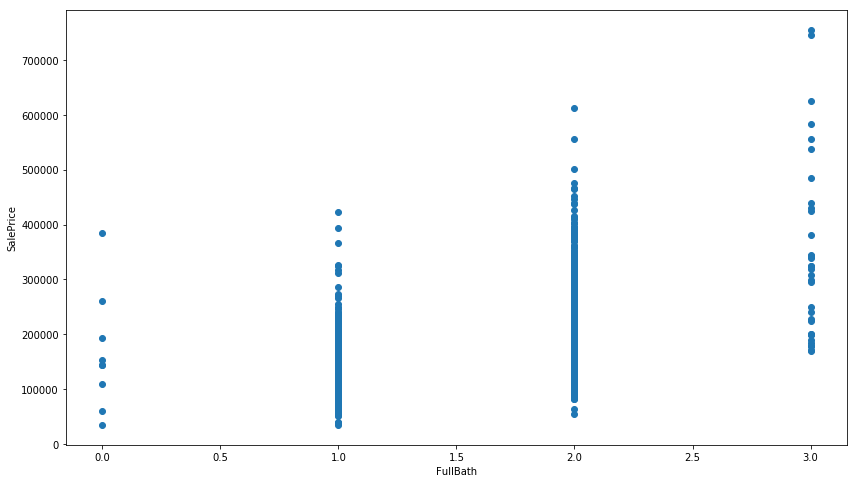

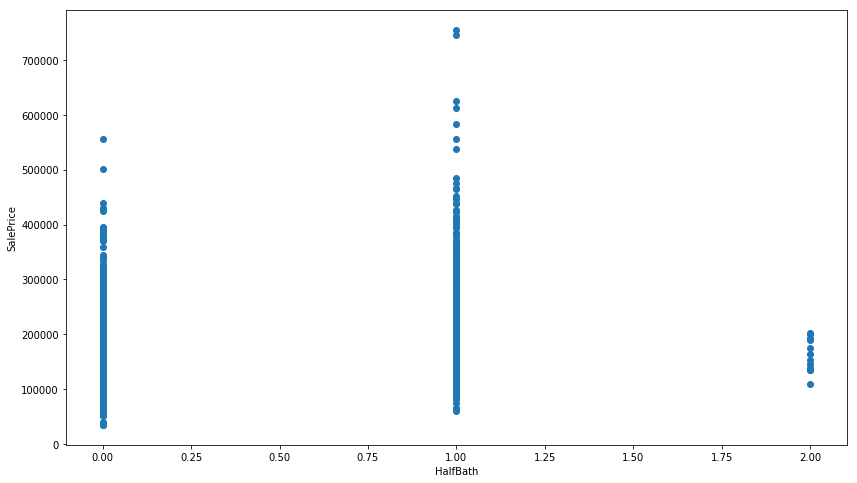

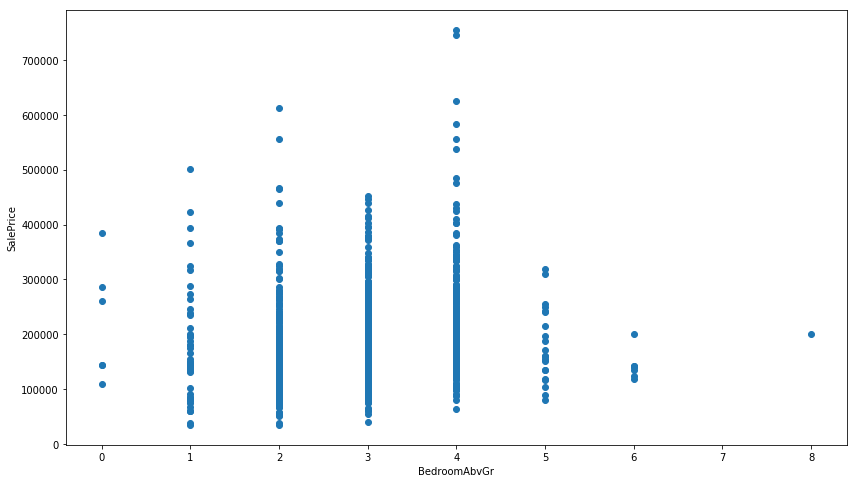

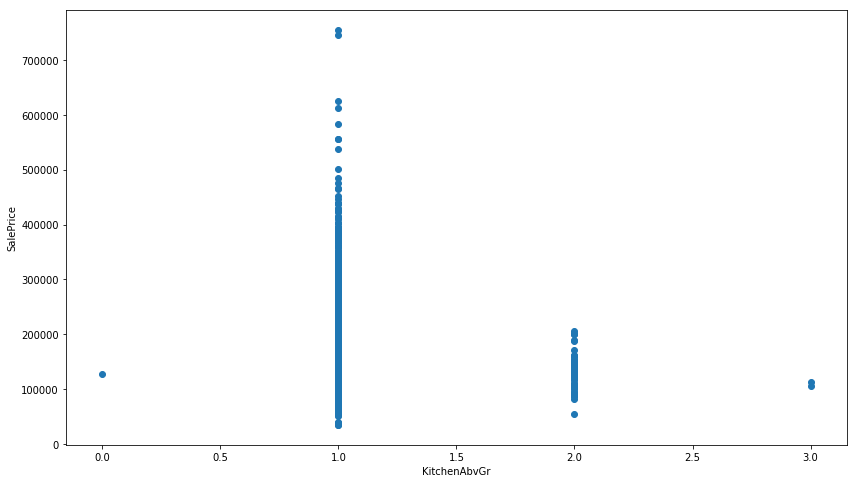

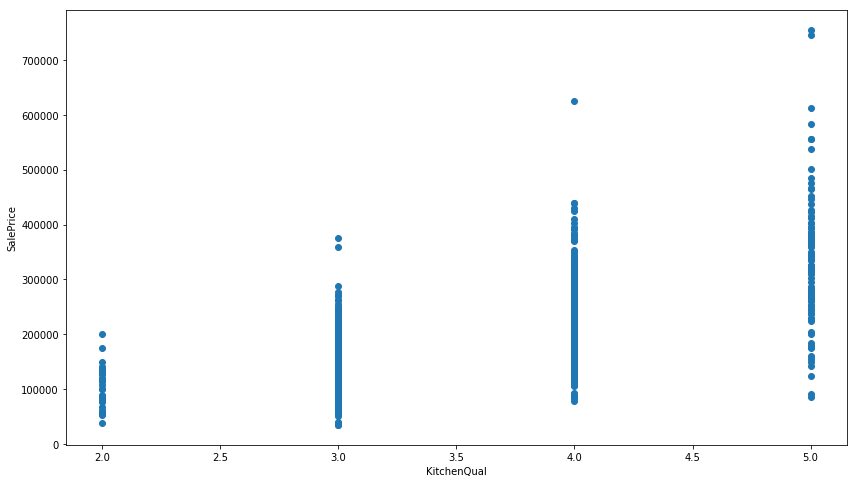

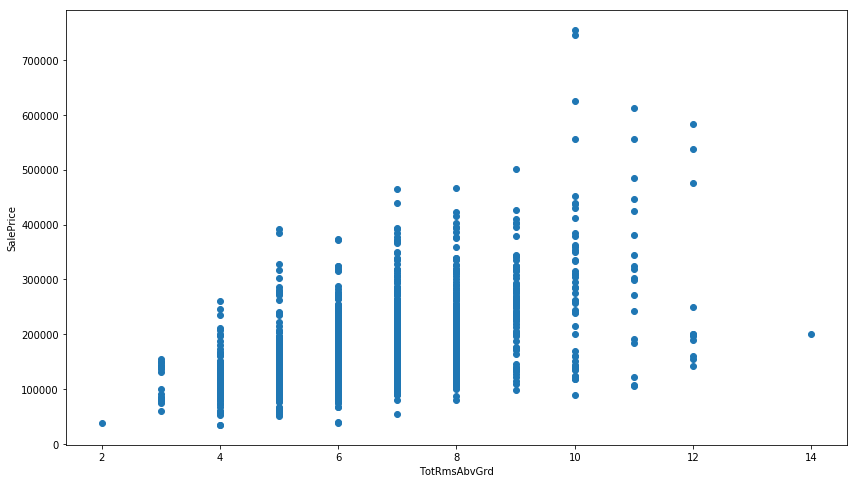

           SalePrice               
               count           mean
Functional                         
Maj1              14  153948.142857
Maj2               5   85800.000000
Min1              31  146385.483871
Min2              34  144240.647059
Mod               15  168393.333333
Sev                1  129000.000000
Typ             1360  183429.147059


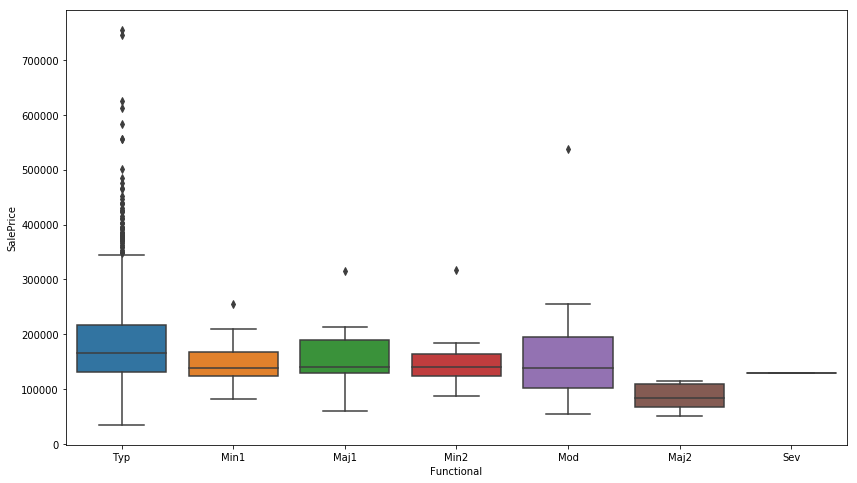

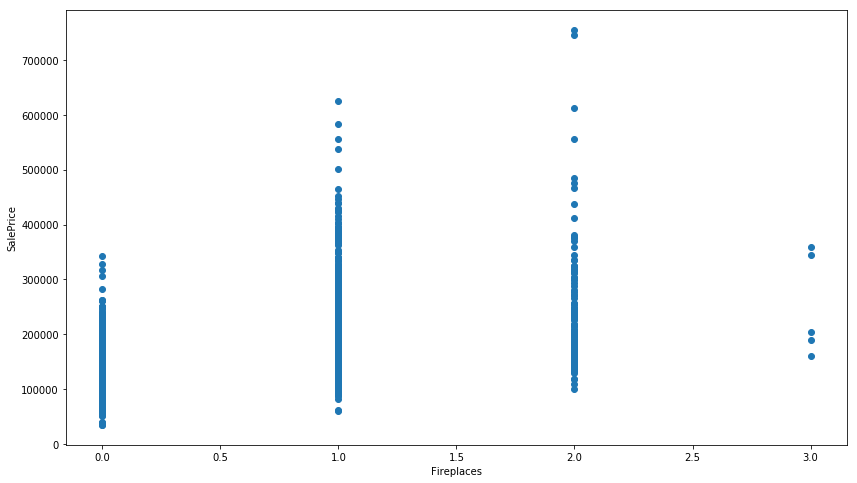

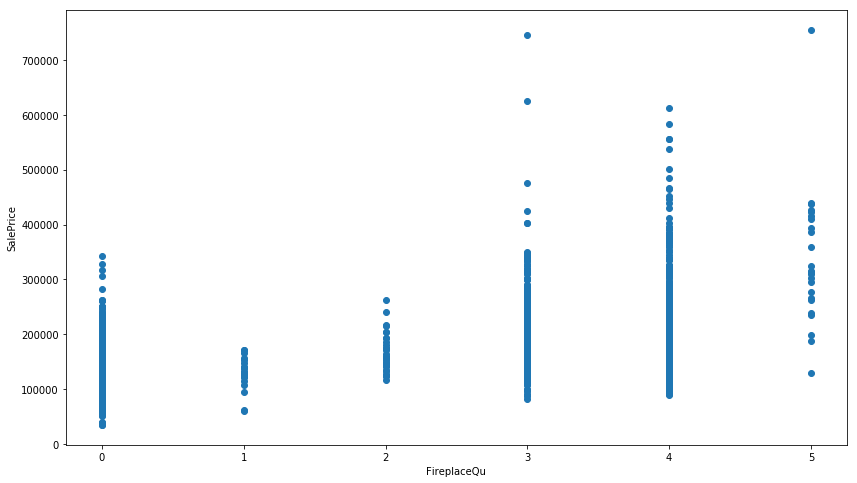

           SalePrice               
               count           mean
GarageType                         
2Types             6  151283.333333
Attchd           870  202892.656322
Basment           19  160570.684211
BuiltIn           88  254751.738636
CarPort            9  109962.111111
Detchd           387  134091.162791


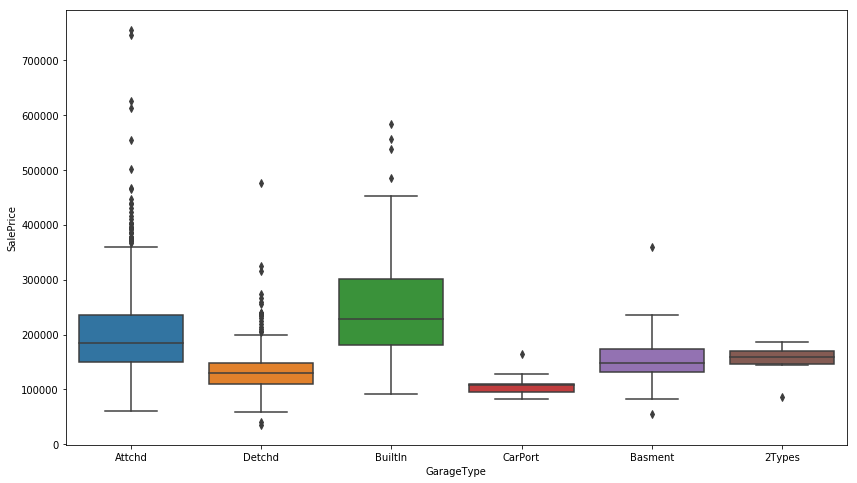

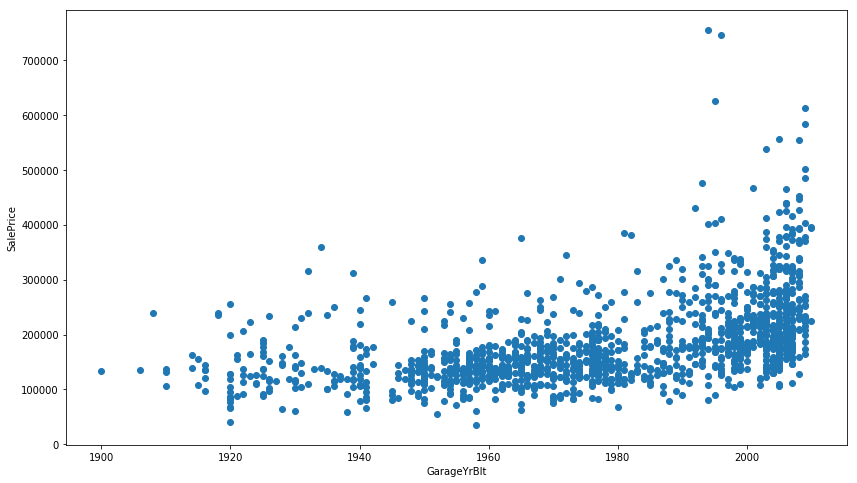

             SalePrice               
                 count           mean
GarageFinish                         
Fin                352  240052.690341
RFn                422  202068.869668
Unf                605  142156.423140


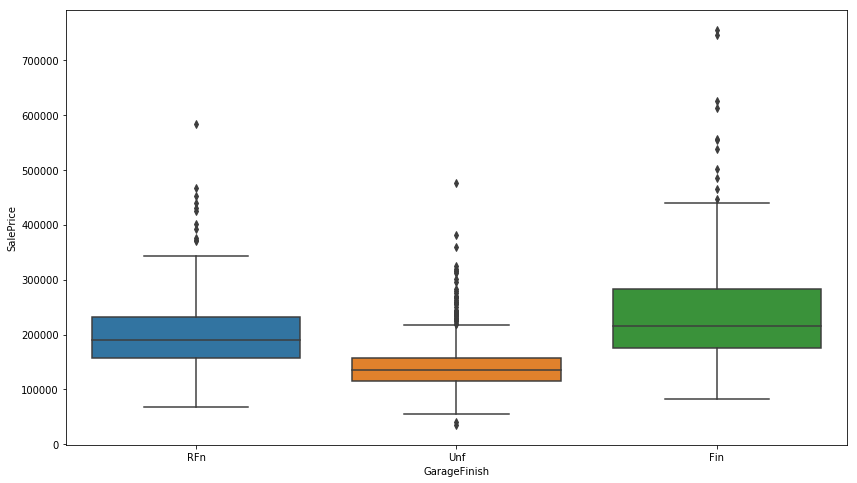

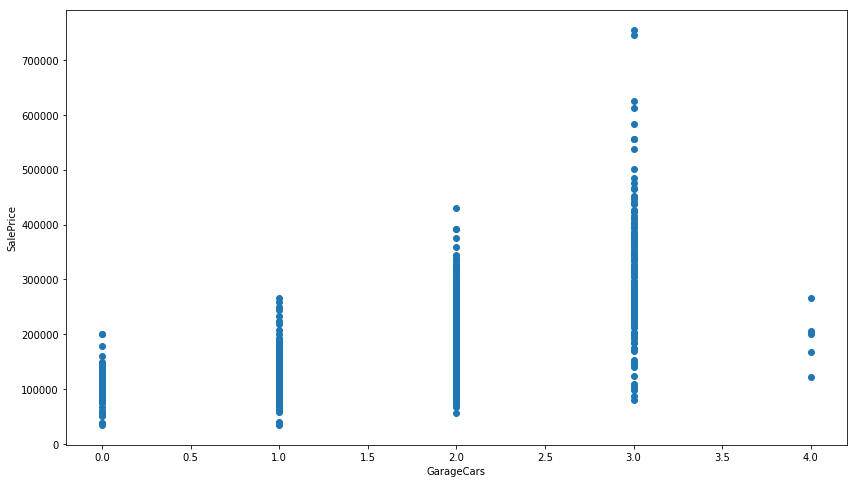

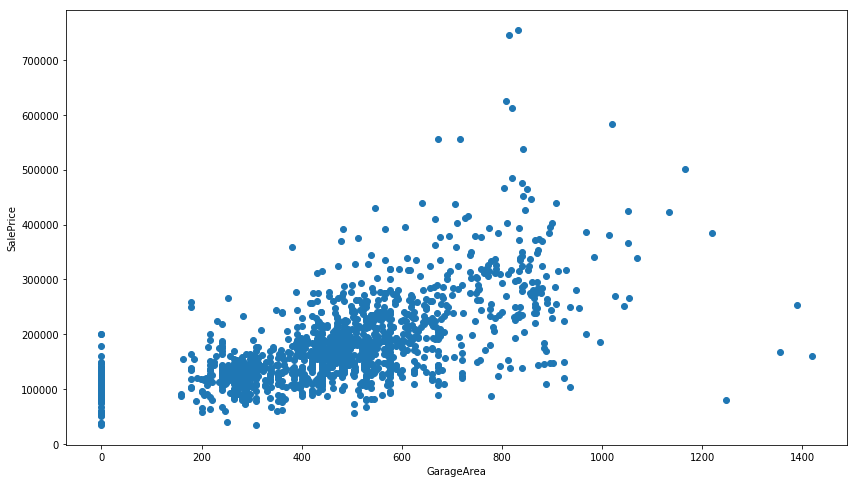

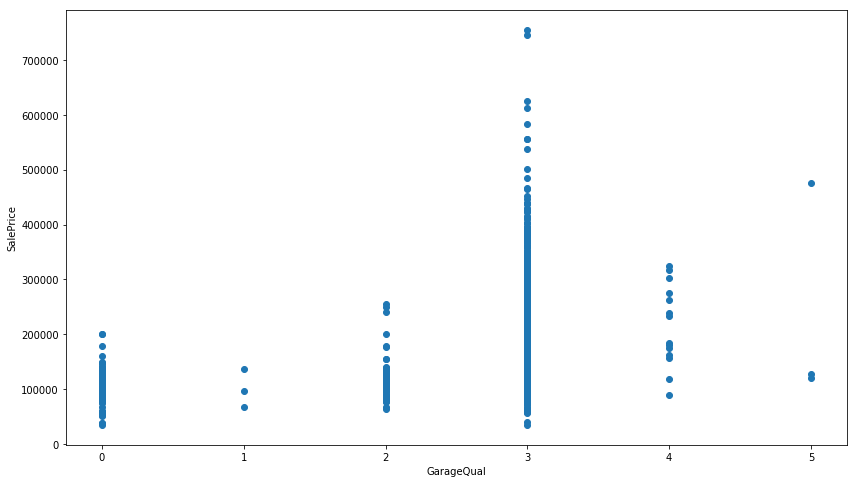

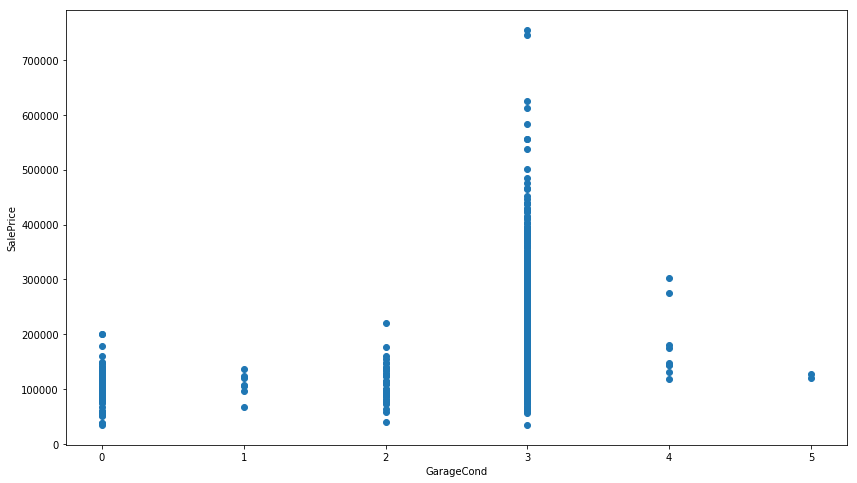

           SalePrice               
               count           mean
PavedDrive                         
N                 90  115039.122222
P                 30  132330.000000
Y               1340  186433.973881


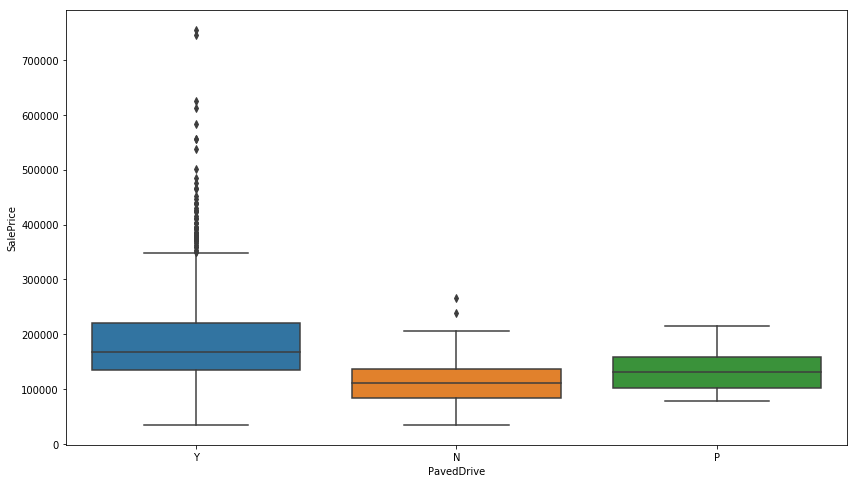

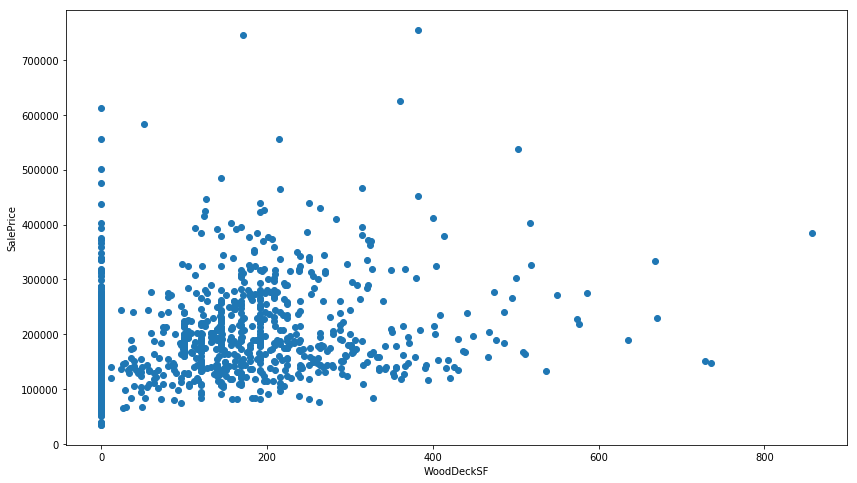

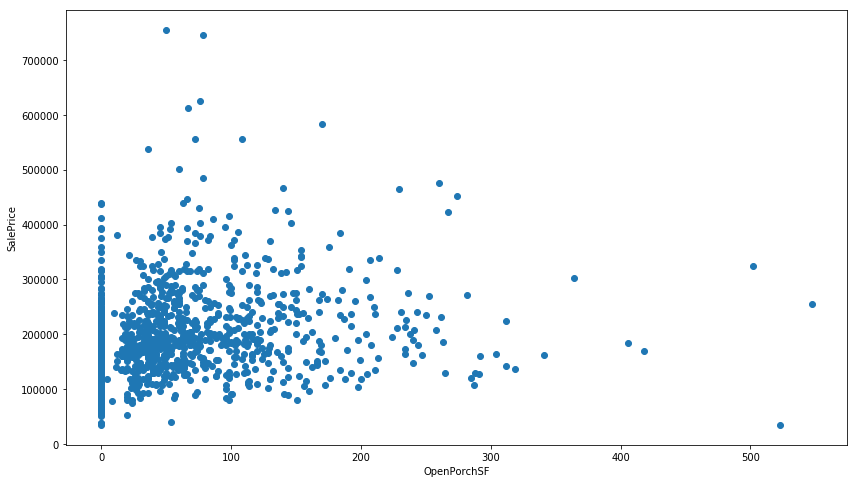

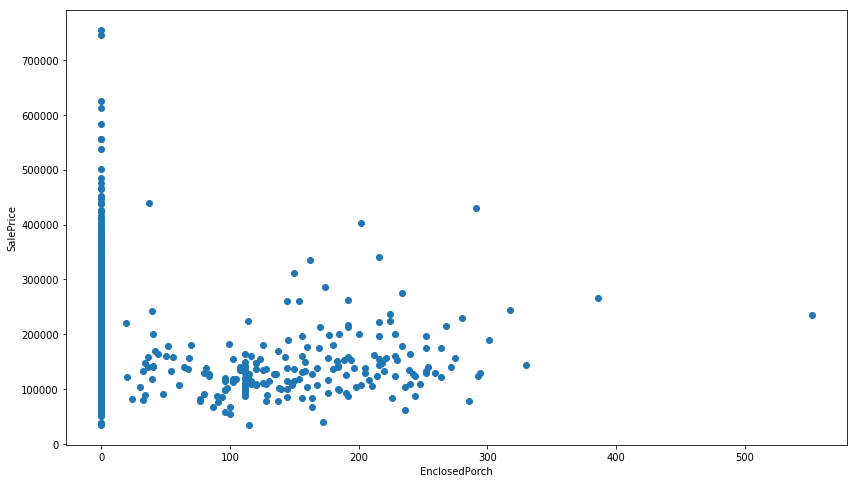

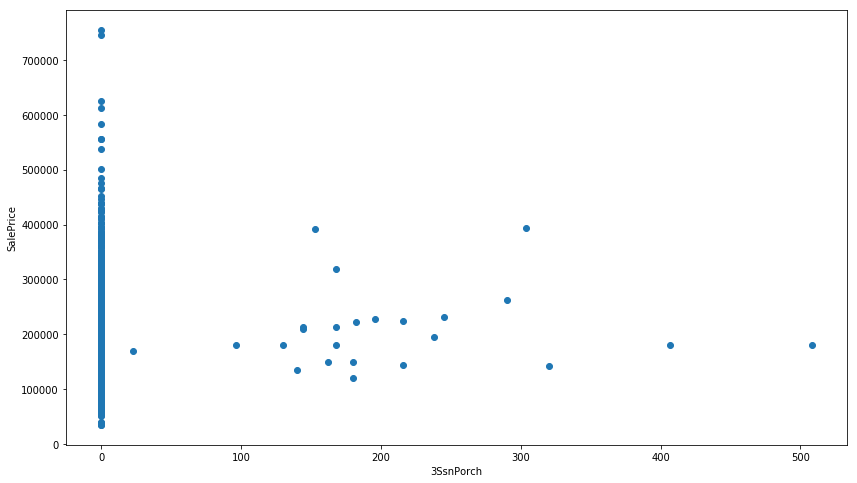

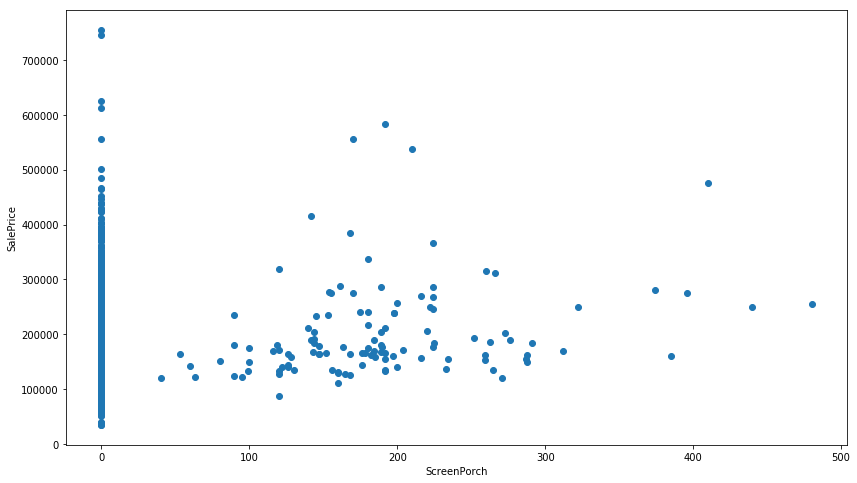

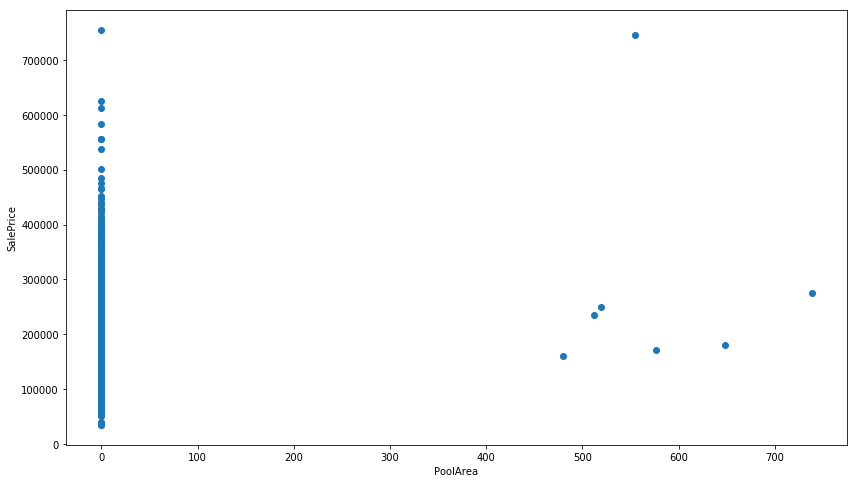

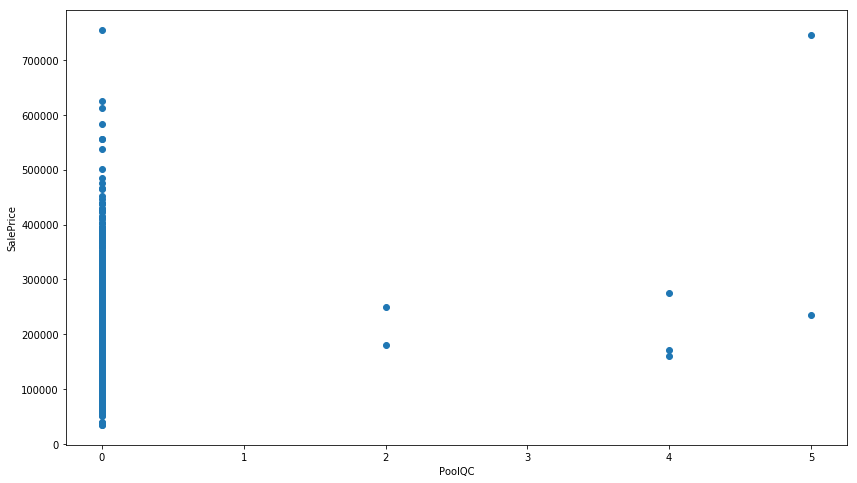

         SalePrice               
             count           mean
Fence                            
GdPrv           59  178927.457627
GdWo            54  140379.314815
MnPrv          157  148751.089172
MnWw            11  134286.363636
No_fence      1179  187596.837998


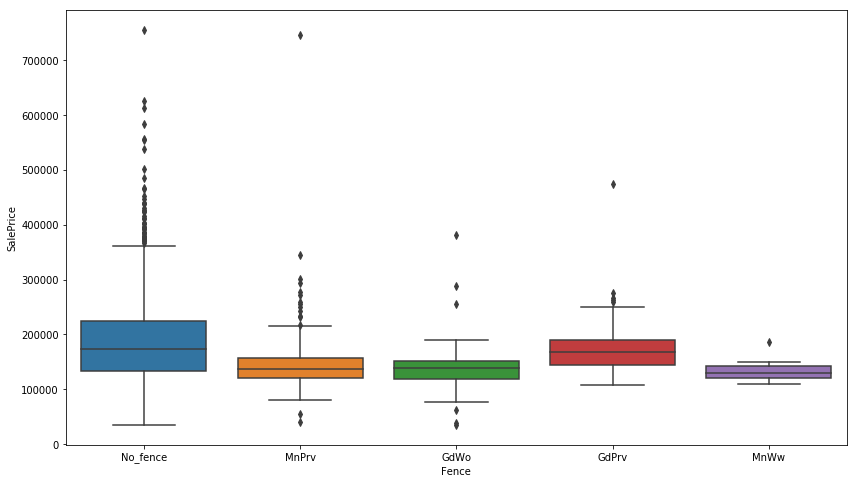

               SalePrice               
                   count           mean
MiscFeature                            
Gar2                   2  170750.000000
No_miscFeature      1406  182046.410384
Othr                   2   94000.000000
Shed                  49  151187.612245
TenC                   1  250000.000000


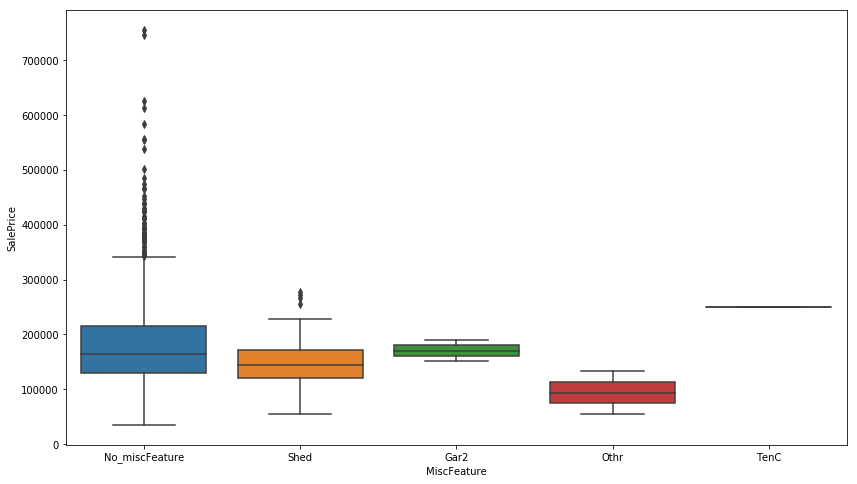

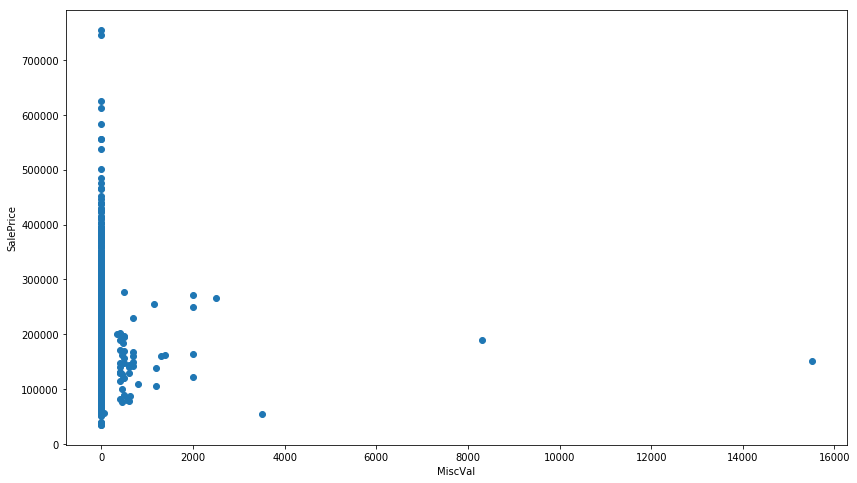

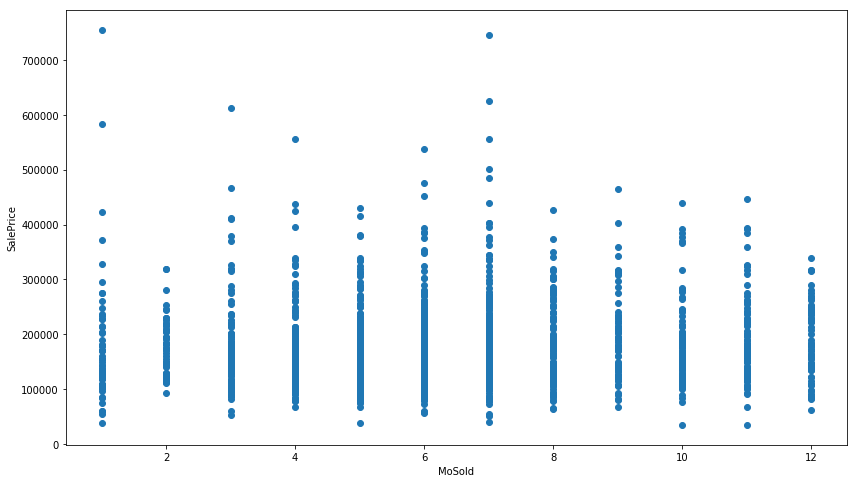

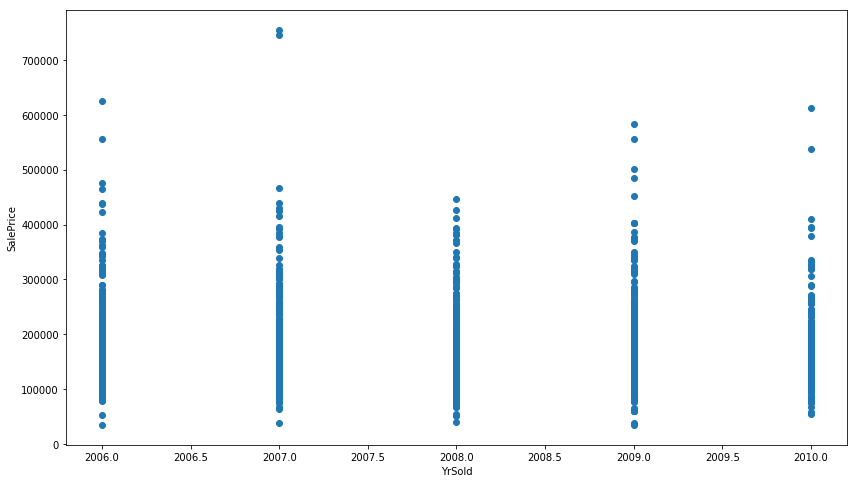

         SalePrice               
             count           mean
SaleType                         
COD             43  143973.255814
CWD              4  210600.000000
Con              2  269600.000000
ConLD            9  138780.888889
ConLI            5  200390.000000
ConLw            5  143700.000000
New            122  274945.418033
Oth              3  119850.000000
WD            1267  173401.836622


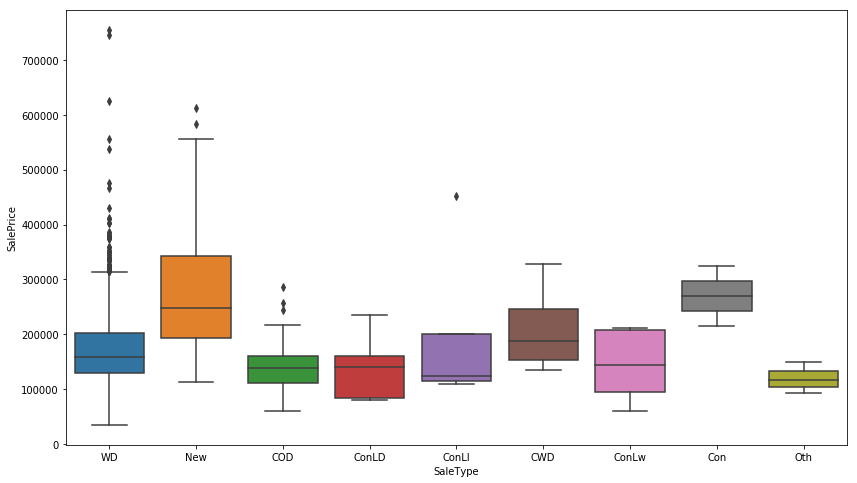

              SalePrice               
                  count           mean
SaleCondition                         
Abnorml             101  146526.623762
AdjLand               4  104125.000000
Alloca               12  167377.416667
Family               20  149600.000000
Normal             1198  175202.219533
Partial             125  272291.752000


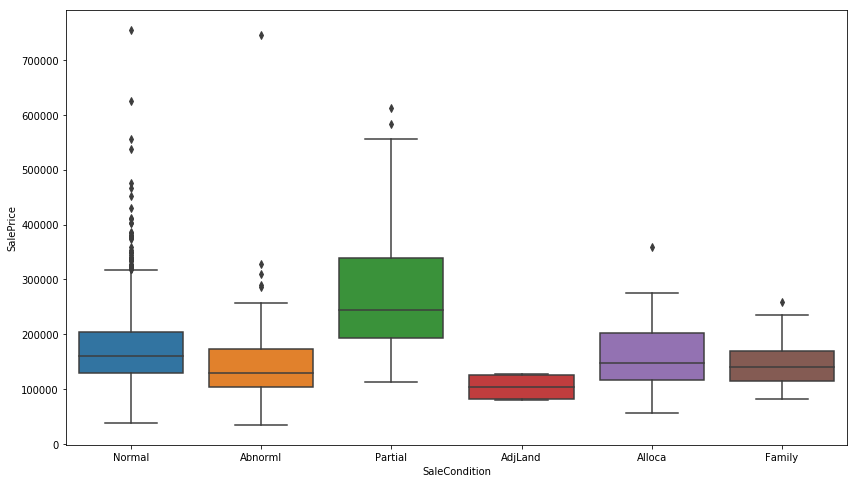

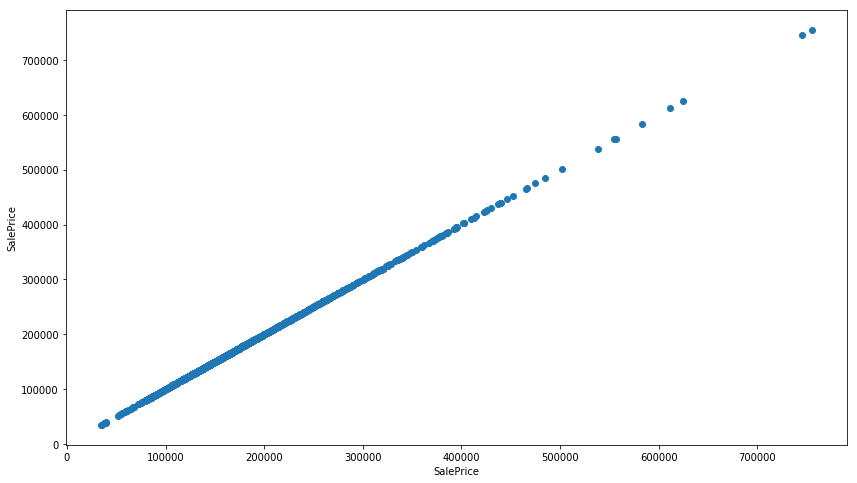

In [480]:
DO NOT RUN#### unaffected train against salePrice

"----------------------------------------------MSZoning-------------------------------------------------
         SalePriceLog           
                count       mean
MSZoning                        
C (all)            10  11.118259
FV                 65  12.246616
RH                 16  11.749840
RL               1151  12.085885
RM                218  11.692893


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


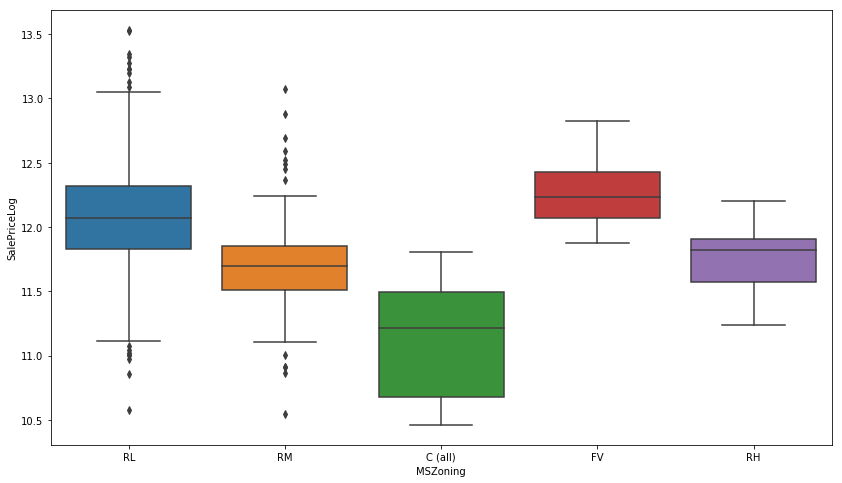

"----------------------------------------------LotFrontage-------------------------------------------------


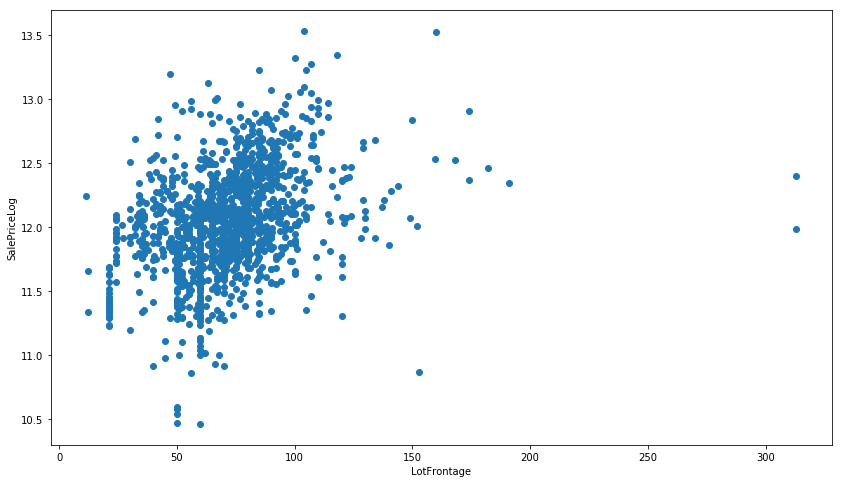

"----------------------------------------------LotArea-------------------------------------------------


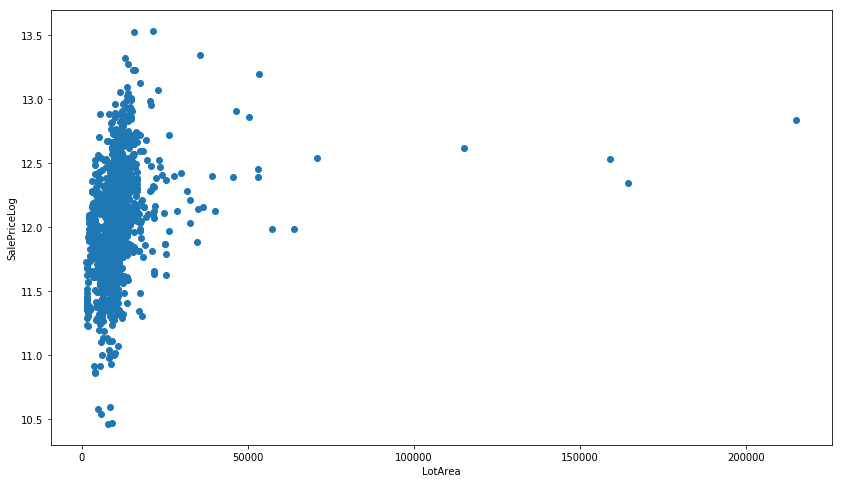

"----------------------------------------------Street-------------------------------------------------
       SalePriceLog           
              count       mean
Street                        
Grvl              6  11.667435
Pave           1454  12.025522


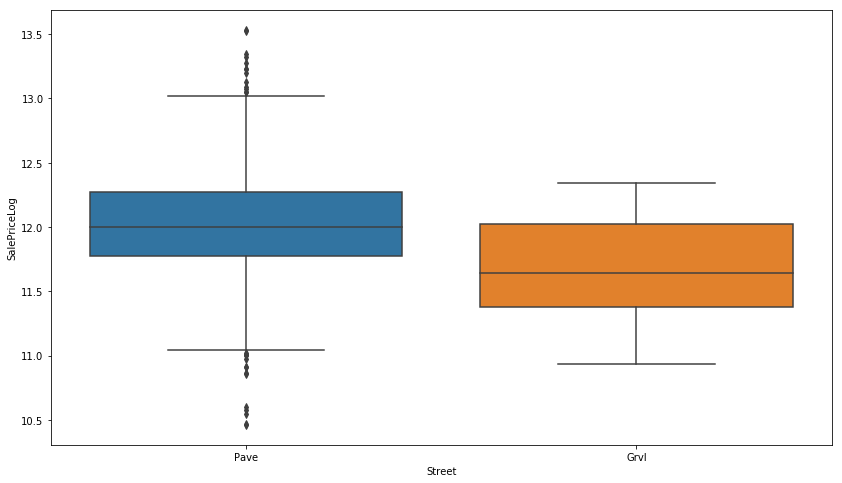

"----------------------------------------------Alley-------------------------------------------------
         SalePriceLog           
                count       mean
Alley                           
Grvl               50  11.673354
No_alley         1369  12.037675
Pave               41  11.996812


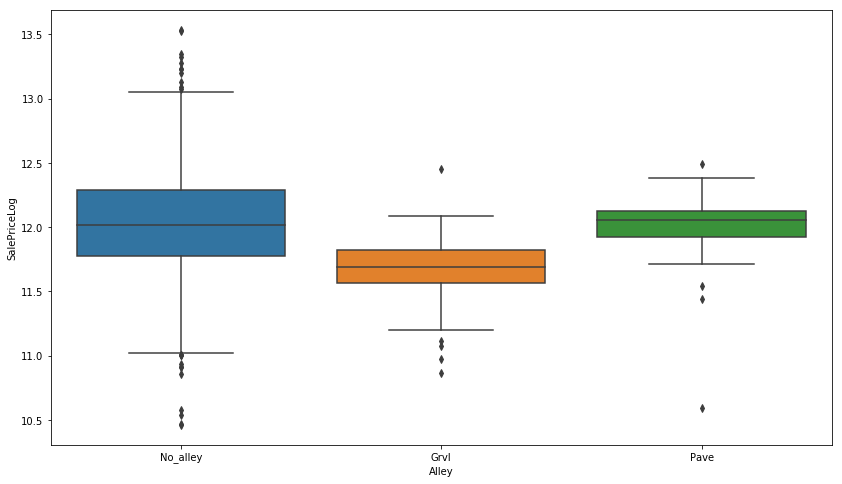

"----------------------------------------------LotShape-------------------------------------------------


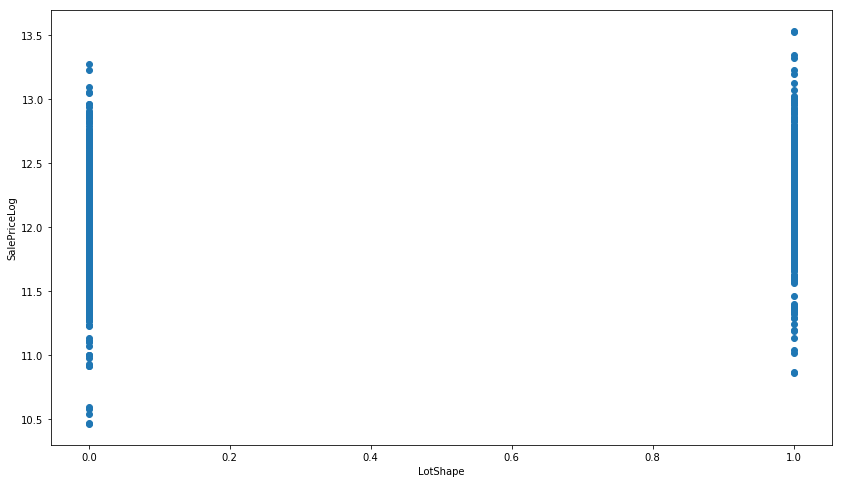

"----------------------------------------------LandContour-------------------------------------------------
            SalePriceLog           
                   count       mean
LandContour                        
Bnk                   63  11.810740
HLS                   50  12.259257
Low                   36  12.120086
Lvl                 1311  12.022694


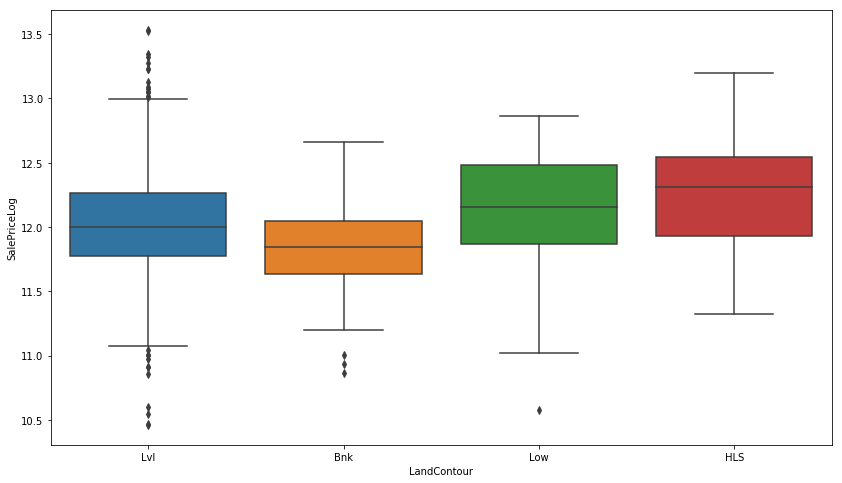

"----------------------------------------------Utilities-------------------------------------------------
          SalePriceLog           
                 count       mean
Utilities                        
AllPub            1459  12.024183
NoSeWa               1  11.831379


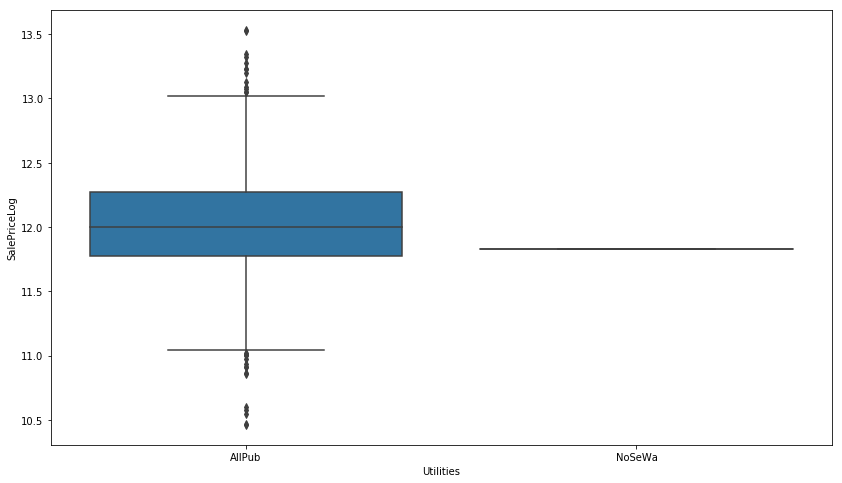

"----------------------------------------------LotConfig-------------------------------------------------
          SalePriceLog           
                 count       mean
LotConfig                        
Corner             263  12.027446
CulDSac             94  12.249810
FR2                 47  12.034741
FR3                  4  12.195684
Inside            1052  12.001900


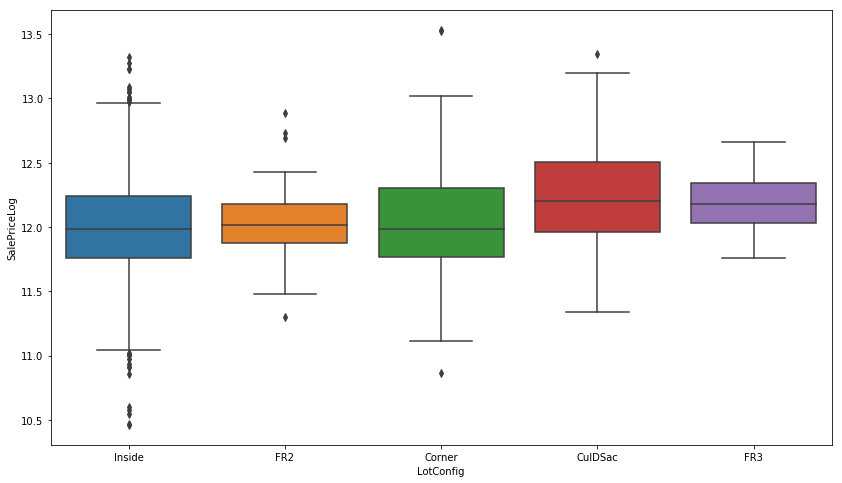

"----------------------------------------------LandSlope-------------------------------------------------
          SalePriceLog           
                 count       mean
LandSlope                        
Gtl               1382  12.020565
Mod                 65  12.076866
Sev                 13  12.130561


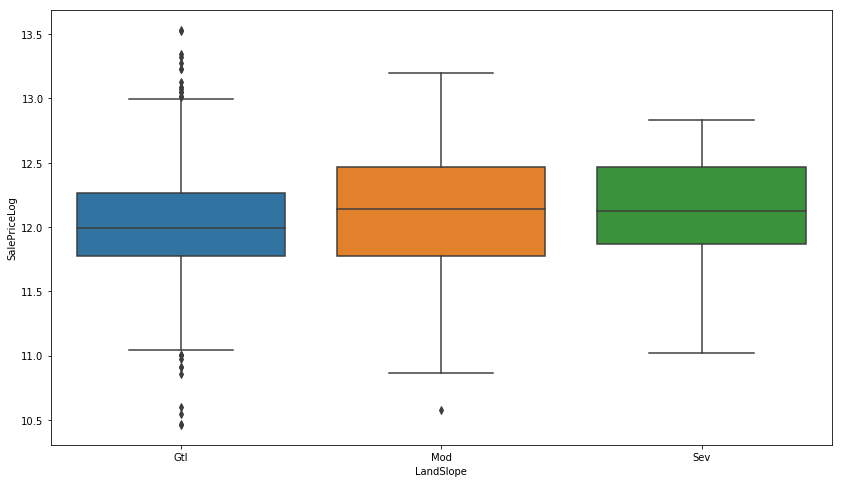

"----------------------------------------------Neighborhood-------------------------------------------------
             SalePriceLog           
                    count       mean
Neighborhood                        
Blmngtn                17  12.169416
Blueste                 2  11.826536
BrDale                 16  11.547864
BrkSide                58  11.679727
ClearCr                28  12.239900
CollgCr               150  12.163641
Crawfor                51  12.206659
Edwards               100  11.712312
Gilbert                79  12.155803
IDOTRR                 37  11.446889
MeadowV                17  11.474522
Mitchel                49  11.933948
NAmes                 225  11.868045
NPkVill                 9  11.866477
NWAmes                 73  12.130609
NoRidge                41  12.676000
NridgHt                77  12.619411
OldTown               113  11.703865
SWISU                  25  11.838435
Sawyer                 74  11.811468
SawyerW                59  12.090689
Som

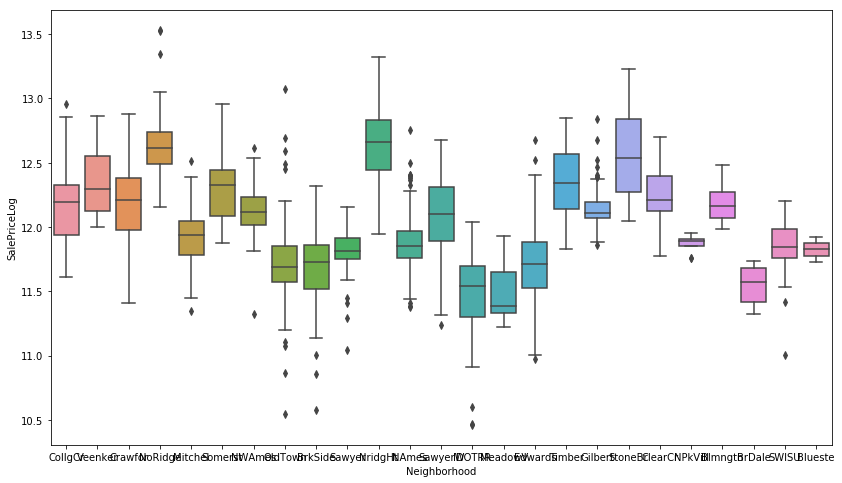

"----------------------------------------------Condition1-------------------------------------------------
           SalePriceLog           
                  count       mean
Condition1                        
Artery               48  11.741750
Feedr                81  11.818334
Norm               1260  12.042916
PosA                  8  12.306690
PosN                 19  12.237989
RRAe                 11  11.822302
RRAn                 26  12.073762
RRNe                  2  12.158526
RRNn                  5  12.179093


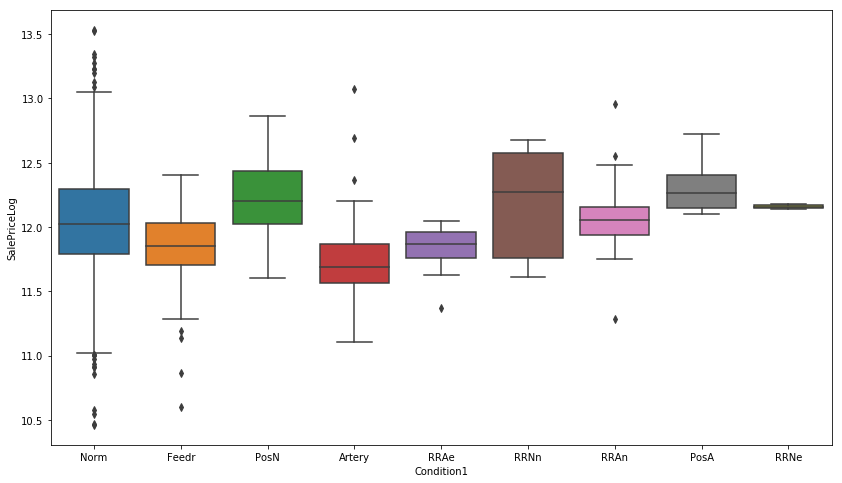

"----------------------------------------------Condition2-------------------------------------------------
           SalePriceLog           
                  count       mean
Condition2                        
Artery                2  11.570036
Feedr                 6  11.670631
Norm               1445  12.025895
PosA                  1  12.691580
PosN                  2  12.493879
RRAe                  1  12.154779
RRAn                  1  11.827043
RRNn                  2  11.435329


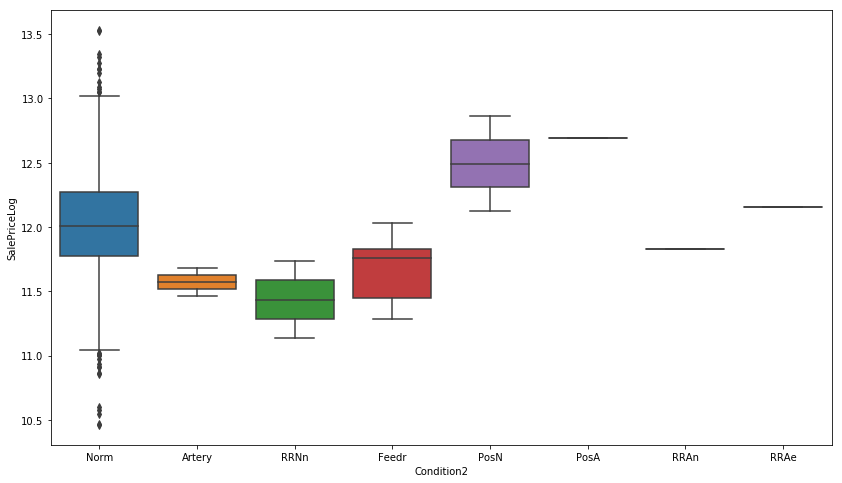

"----------------------------------------------BldgType-------------------------------------------------
         SalePriceLog           
                count       mean
BldgType                        
1Fam             1220  12.047512
2fmCon             31  11.725353
Duplex             52  11.780920
Twnhs              43  11.773906
TwnhsE            114  12.059451


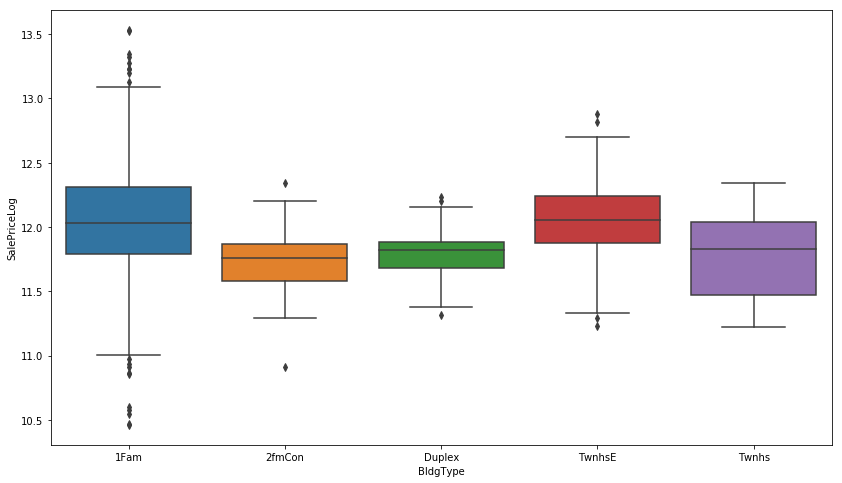

"----------------------------------------------HouseStyle-------------------------------------------------
           SalePriceLog           
                  count       mean
HouseStyle                        
1.5Fin              154  11.813528
1.5Unf               14  11.595027
1Story              726  11.993683
2.5Fin                8  12.194451
2.5Unf               11  11.908751
2Story              445  12.182686
SFoyer               37  11.786479
SLvl                 65  12.002153


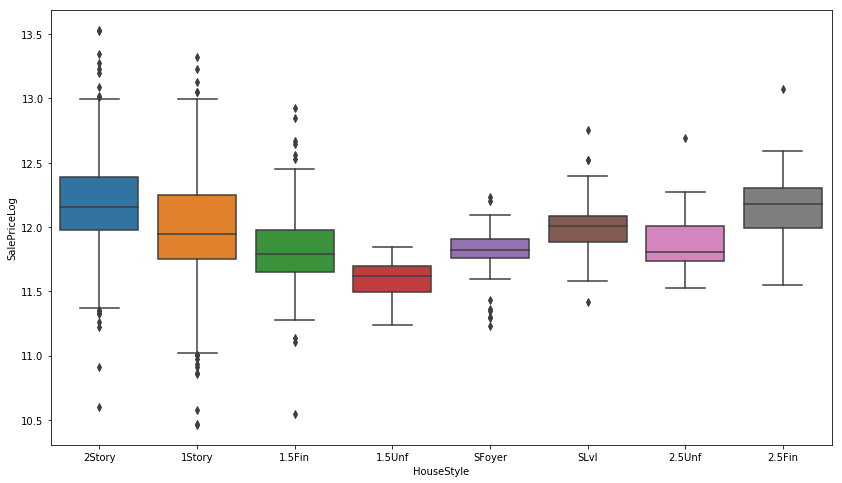

"----------------------------------------------OverallQual-------------------------------------------------


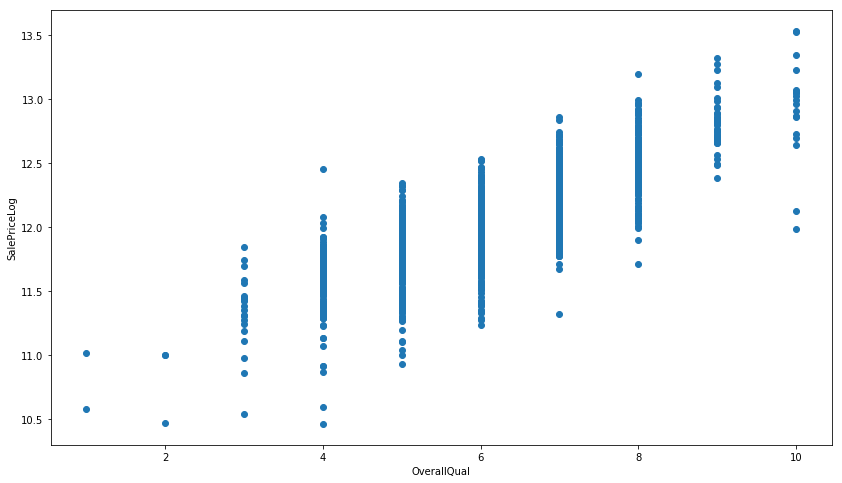

"----------------------------------------------OverallCond-------------------------------------------------


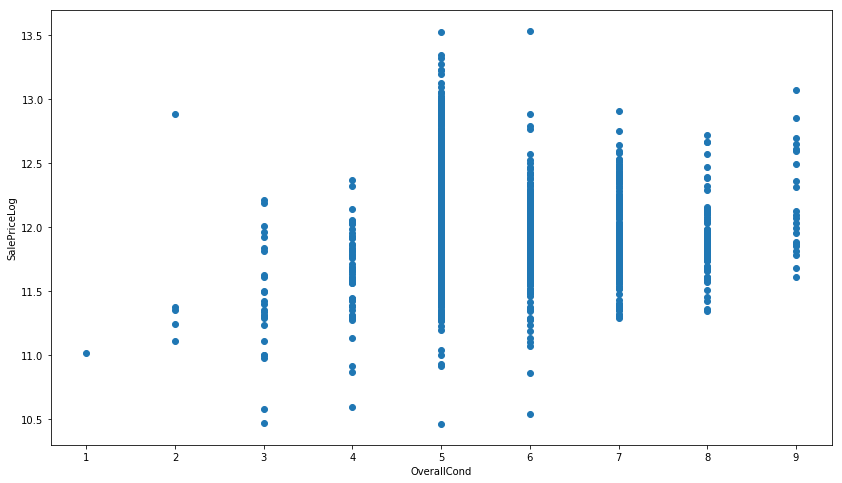

"----------------------------------------------RoofStyle-------------------------------------------------
          SalePriceLog           
                 count       mean
RoofStyle                        
Flat                13  12.122911
Gable             1141  11.984200
Gambrel             11  11.797496
Hip                286  12.184430
Mansard              7  12.057425
Shed                 2  12.311608


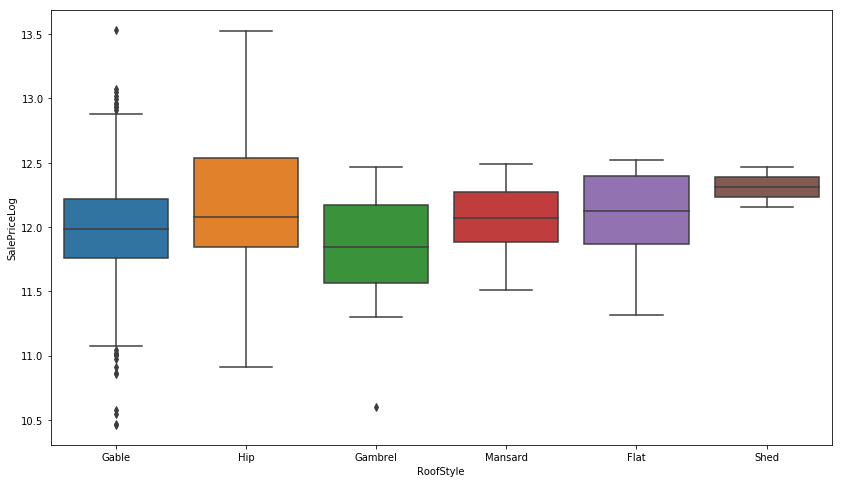

"----------------------------------------------RoofMatl-------------------------------------------------
         SalePriceLog           
                count       mean
RoofMatl                        
ClyTile             1  11.982929
CompShg          1434  12.019216
Membran             1  12.394625
Metal               1  12.100712
Roll                1  11.827736
Tar&Grv            11  12.068078
WdShake             5  12.384850
WdShngl             6  12.763192


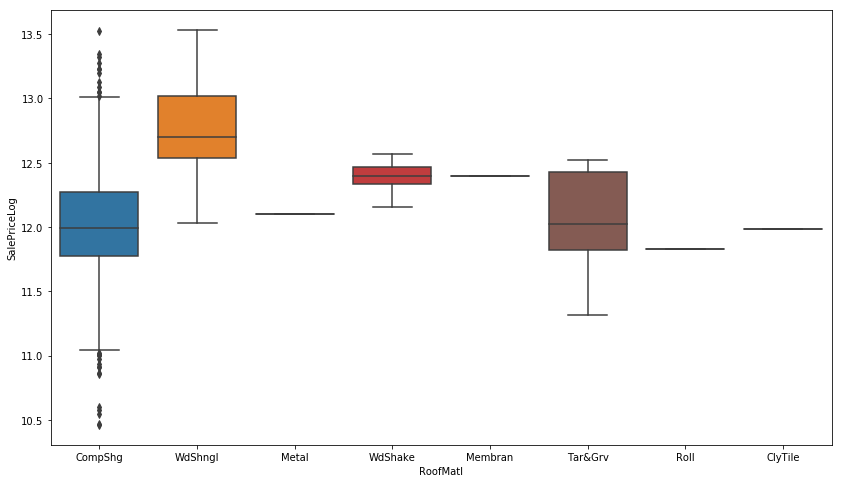

"----------------------------------------------Exterior1st-------------------------------------------------
            SalePriceLog           
                   count       mean
Exterior1st                        
AsbShng               20  11.524514
AsphShn                1  11.512925
BrkComm                2  11.158287
BrkFace               50  12.088140
CBlock                 1  11.561716
CemntBd               61  12.204922
HdBoard              222  11.951899
ImStucc                1  12.476100
MetalSd              220  11.859767
Plywood              108  12.041218
Stone                  2  12.456536
Stucco                25  11.891991
VinylSd              515  12.205873
Wd Sdng              206  11.838506
WdShing               26  11.844542


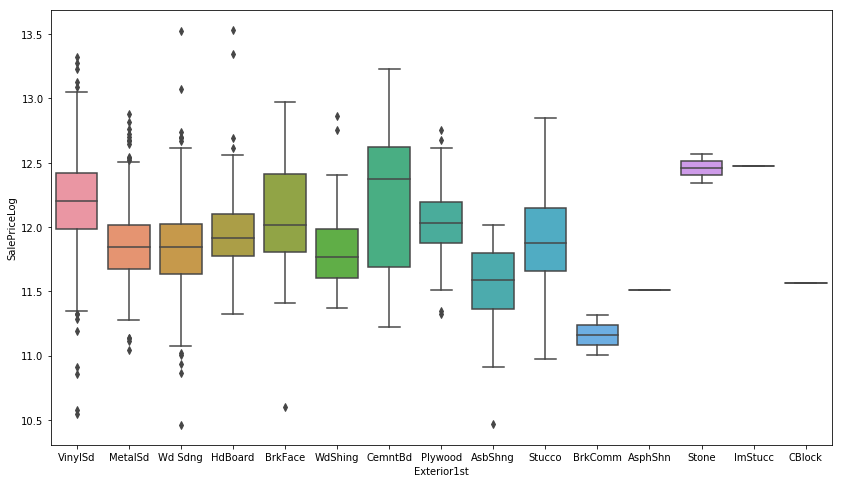

"----------------------------------------------Exterior2nd-------------------------------------------------
            SalePriceLog           
                   count       mean
Exterior2nd                        
AsbShng               20  11.570220
AsphShn                3  11.809232
Brk Cmn                7  11.696284
BrkFace               25  12.066067
CBlock                 1  11.561716
CmentBd               60  12.201948
HdBoard              207  11.974933
ImStucc               10  12.240055
MetalSd              214  11.862286
Other                  1  12.672946
Plywood              142  11.994743
Stone                  5  11.898442
Stucco                26  11.853035
VinylSd              504  12.209631
Wd Sdng              197  11.838480
Wd Shng               38  11.892242


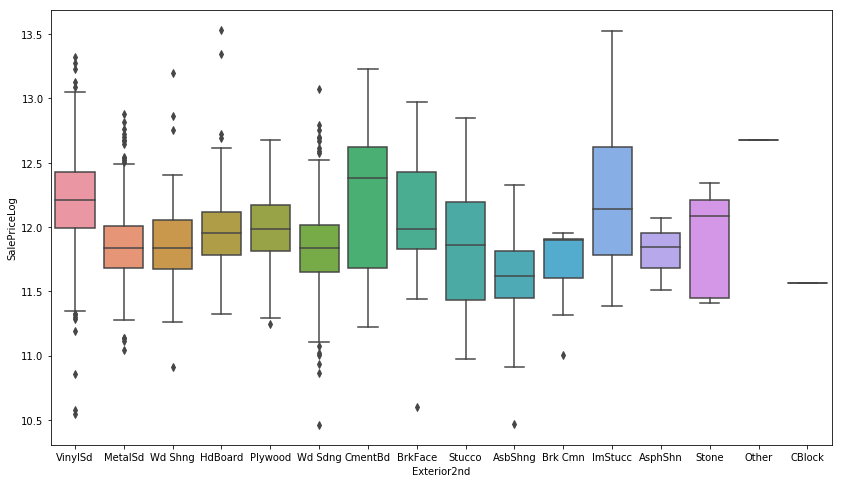

"----------------------------------------------MasVnrType-------------------------------------------------
           SalePriceLog           
                  count       mean
MasVnrType                        
BrkCmn               15  11.853239
BrkFace             445  12.163630
None                872  11.896884
Stone               128  12.425138


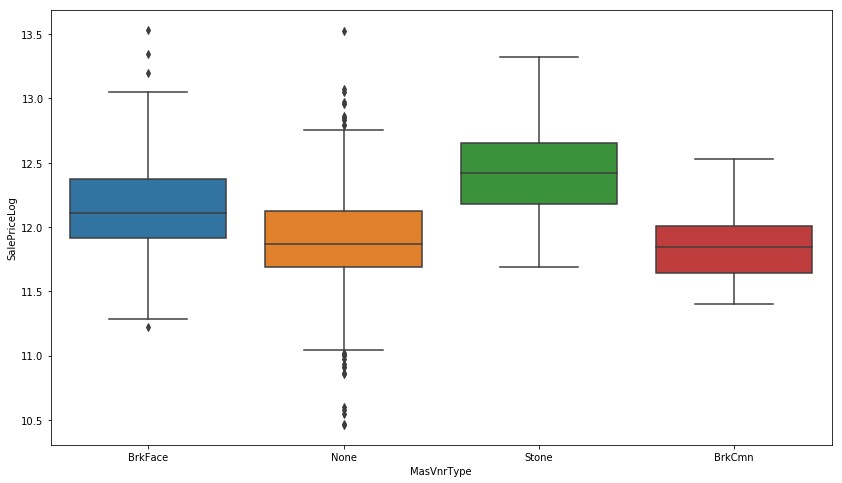

"----------------------------------------------MasVnrArea-------------------------------------------------


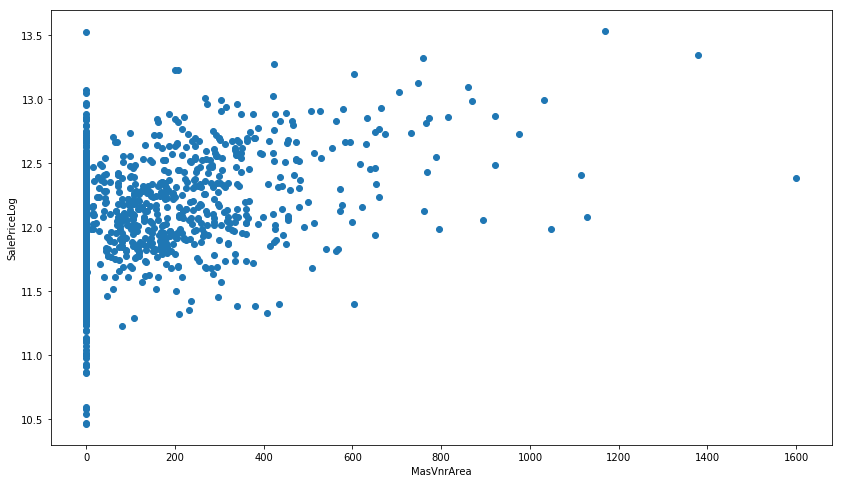

"----------------------------------------------ExterQual-------------------------------------------------


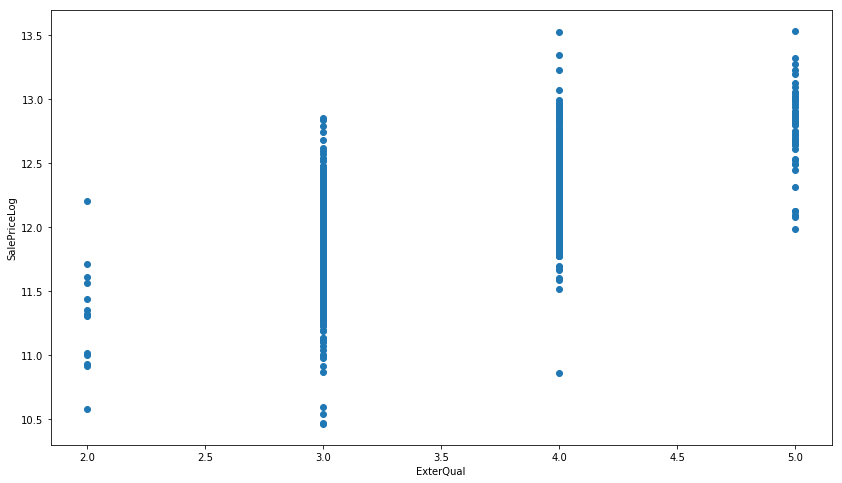

"----------------------------------------------ExterCond-------------------------------------------------


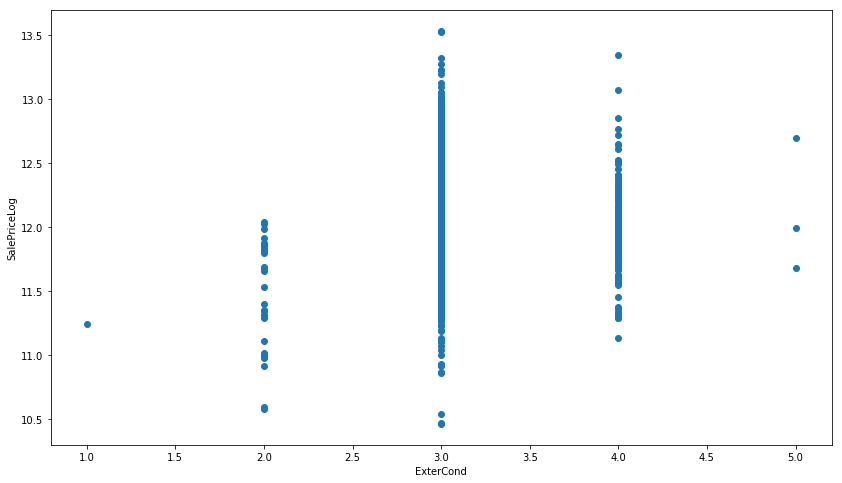

"----------------------------------------------Foundation-------------------------------------------------
           SalePriceLog           
                  count       mean
Foundation                        
BrkTil              146  11.722528
CBlock              634  11.870080
PConc               647  12.261665
Slab                 24  11.532959
Stone                 6  11.933156
Wood                  3  12.102479


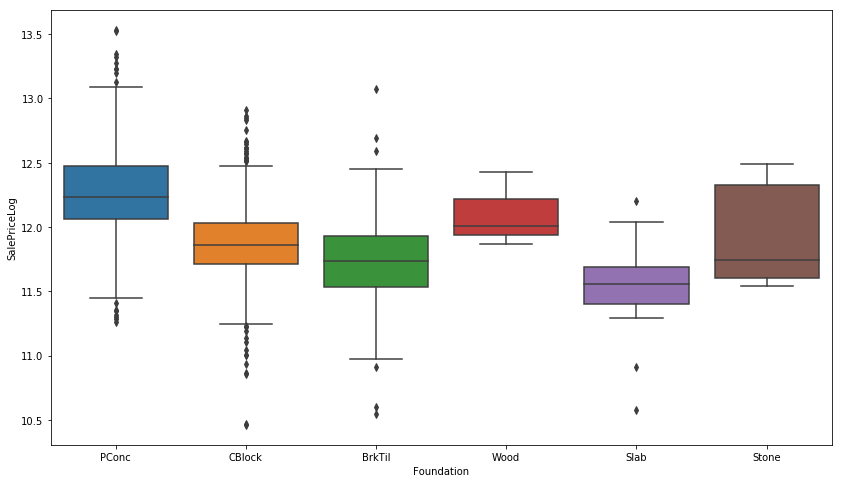

"----------------------------------------------BsmtQual-------------------------------------------------


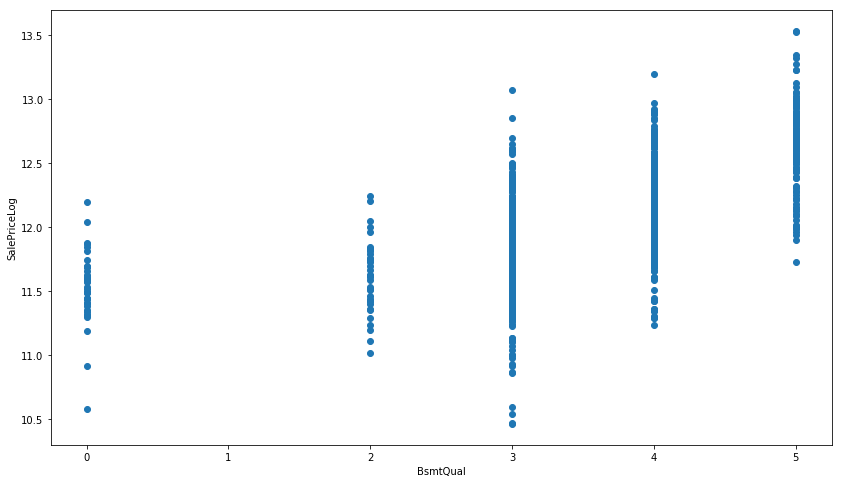

"----------------------------------------------BsmtCond-------------------------------------------------


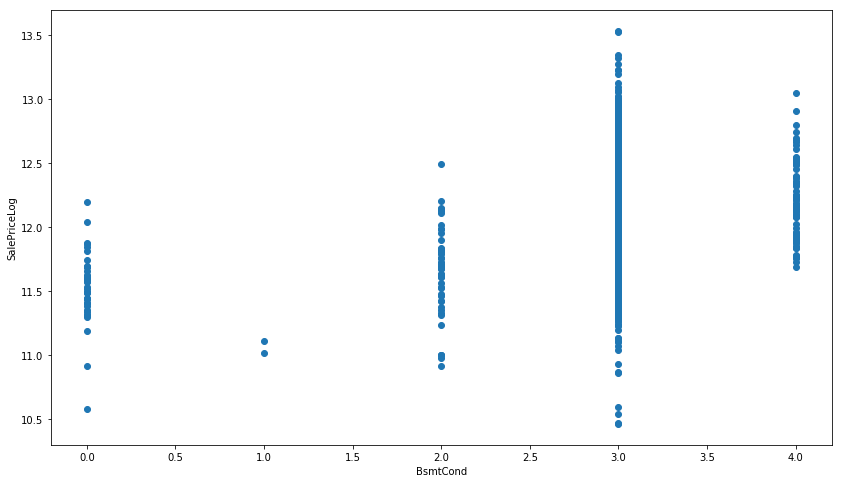

"----------------------------------------------BsmtExposure-------------------------------------------------


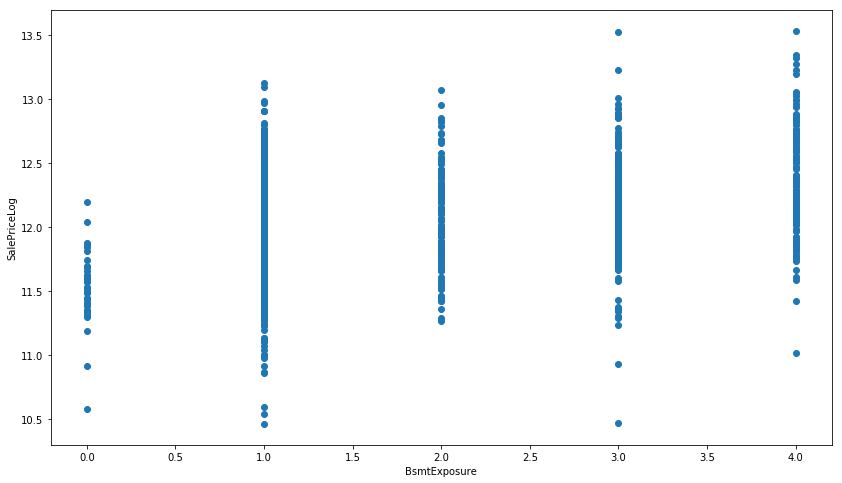

"----------------------------------------------BsmtFinType1-------------------------------------------------


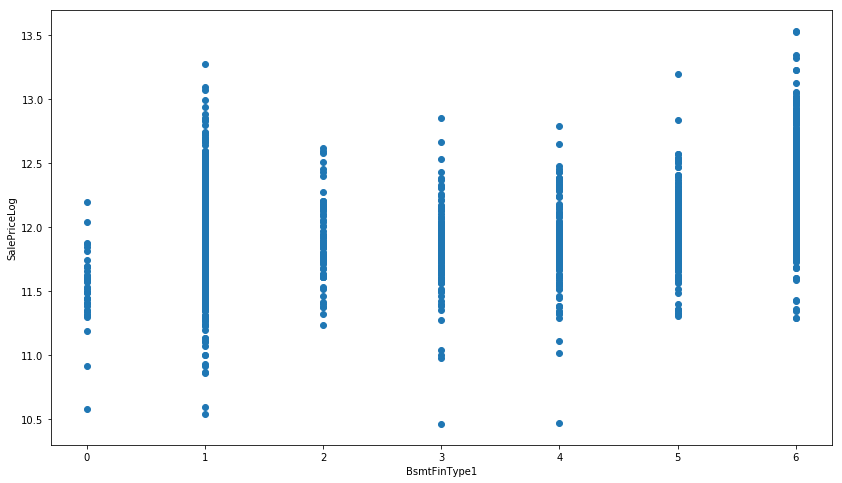

"----------------------------------------------BsmtFinSF1-------------------------------------------------


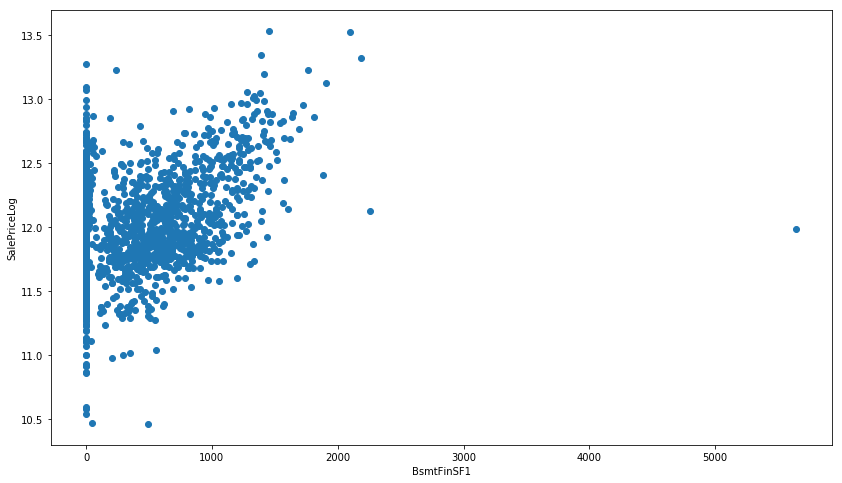

"----------------------------------------------BsmtFinType2-------------------------------------------------


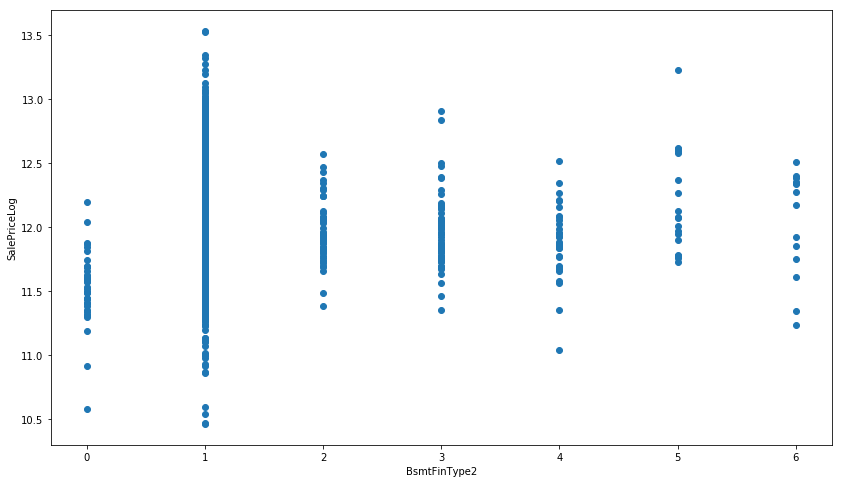

"----------------------------------------------BsmtFinSF2-------------------------------------------------


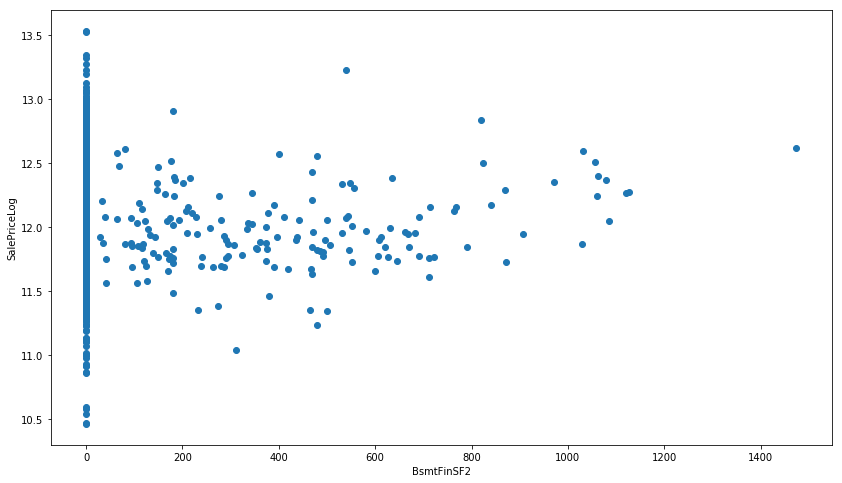

"----------------------------------------------BsmtUnfSF-------------------------------------------------


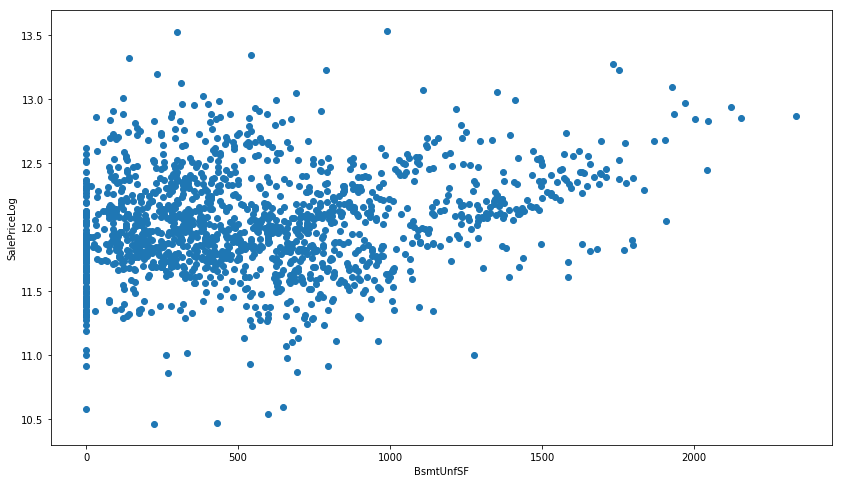

"----------------------------------------------TotalBsmtSF-------------------------------------------------


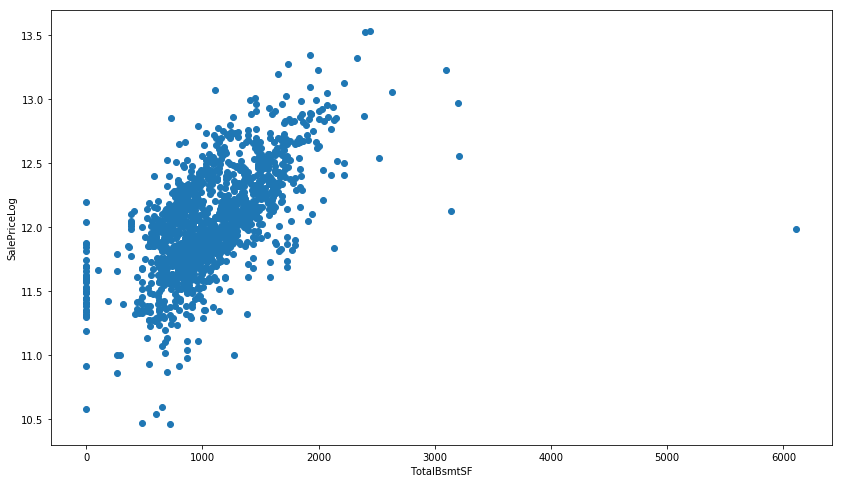

"----------------------------------------------Heating-------------------------------------------------
        SalePriceLog           
               count       mean
Heating                        
Floor              1  11.191342
GasA            1428  12.032078
GasW              18  11.930687
Grav               7  11.165886
OthW               2  11.741606
Wall               4  11.429740


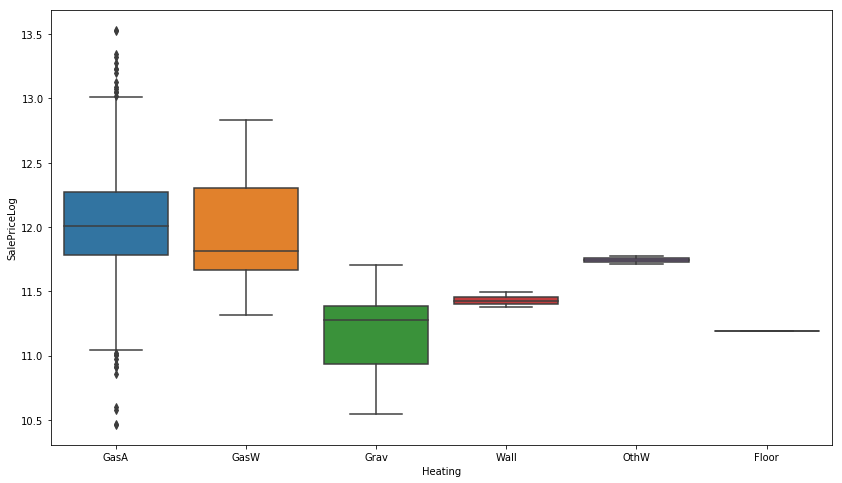

"----------------------------------------------HeatingQC-------------------------------------------------


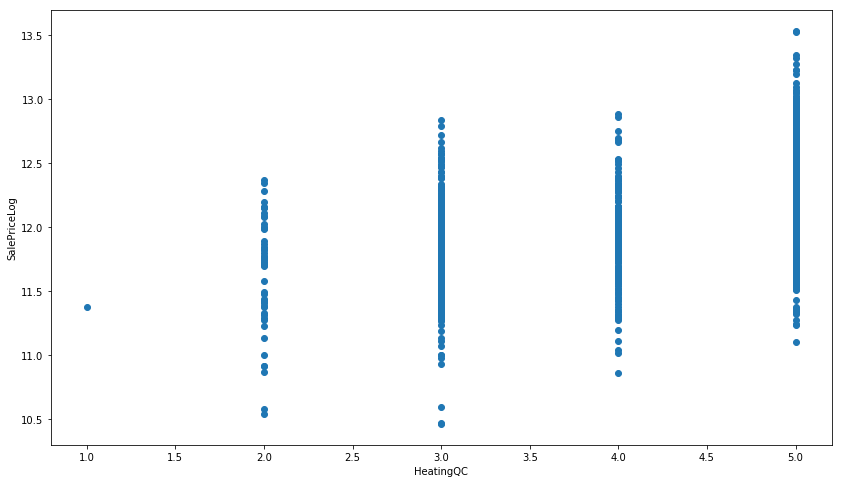

"----------------------------------------------CentralAir-------------------------------------------------


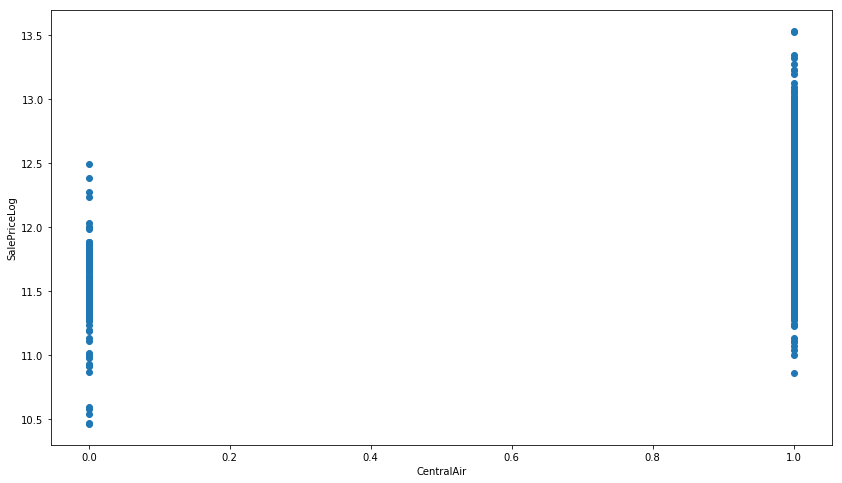

"----------------------------------------------Electrical-------------------------------------------------
           SalePriceLog           
                  count       mean
Electrical                        
FuseA                94  11.660315
FuseF                27  11.539624
FuseP                 3  11.446808
Mix                   1  11.112448
SBrkr              1335  12.061440


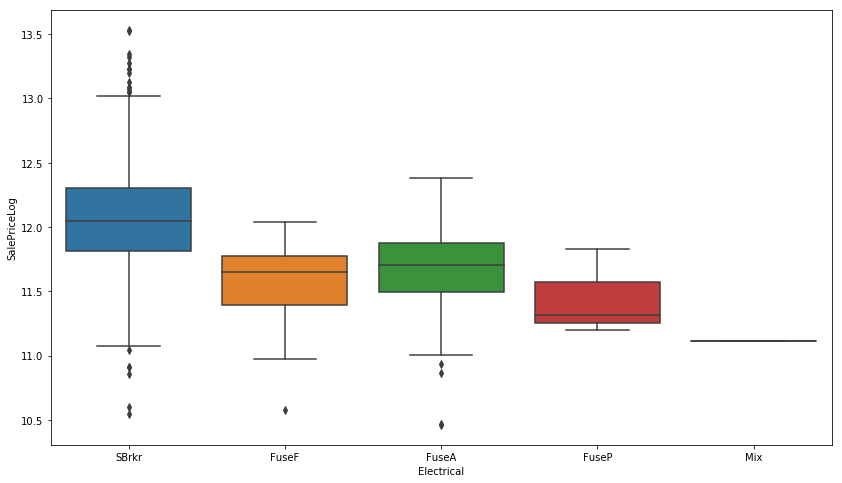

"----------------------------------------------1stFlrSF-------------------------------------------------


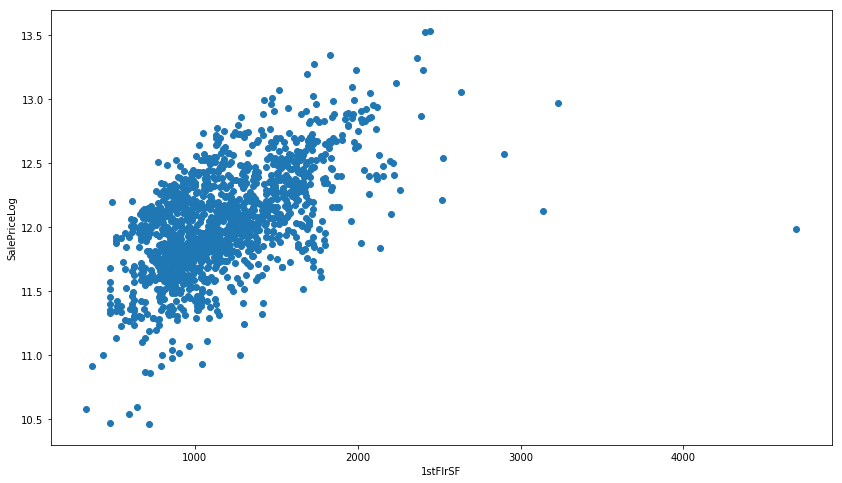

"----------------------------------------------2ndFlrSF-------------------------------------------------


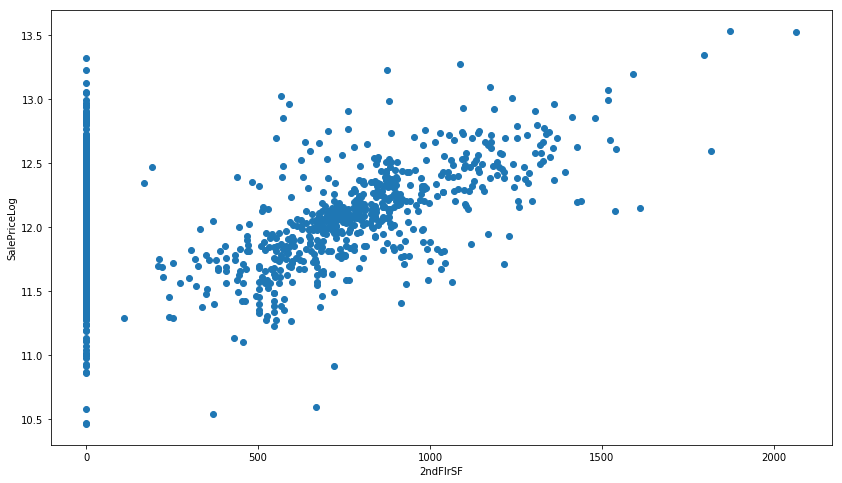

"----------------------------------------------LowQualFinSF-------------------------------------------------


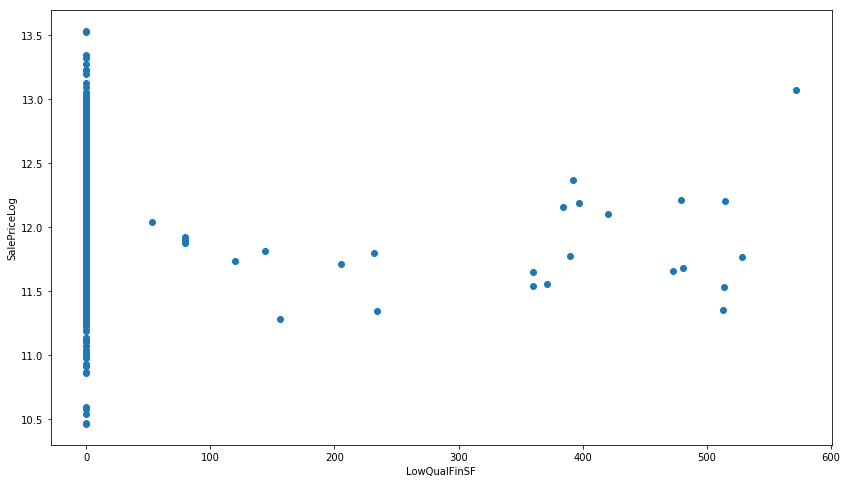

"----------------------------------------------GrLivArea-------------------------------------------------


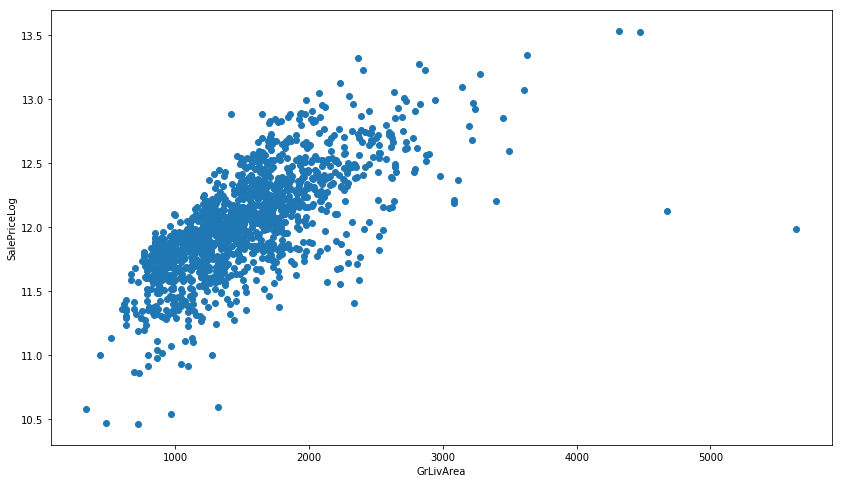

"----------------------------------------------BedroomAbvGr-------------------------------------------------


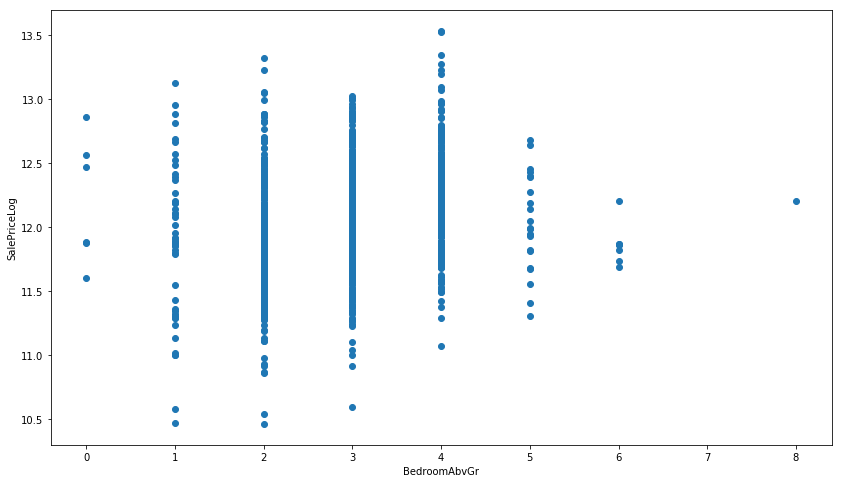

"----------------------------------------------KitchenAbvGr-------------------------------------------------


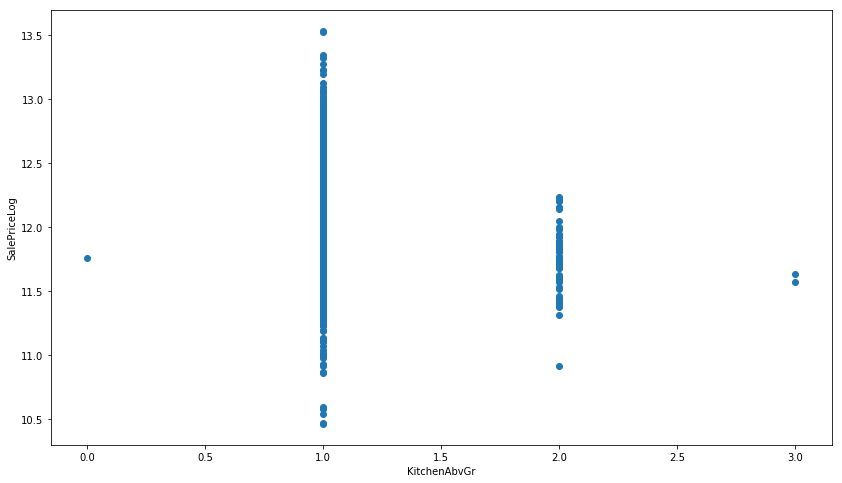

"----------------------------------------------KitchenQual-------------------------------------------------


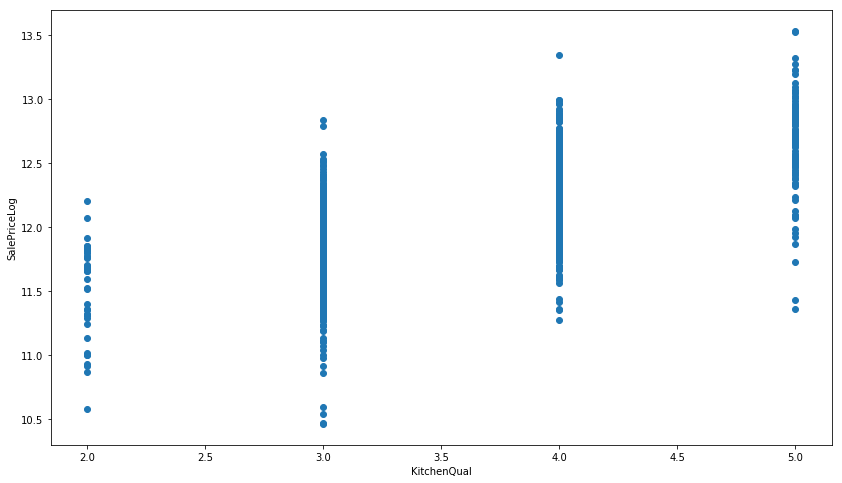

"----------------------------------------------TotRmsAbvGrd-------------------------------------------------


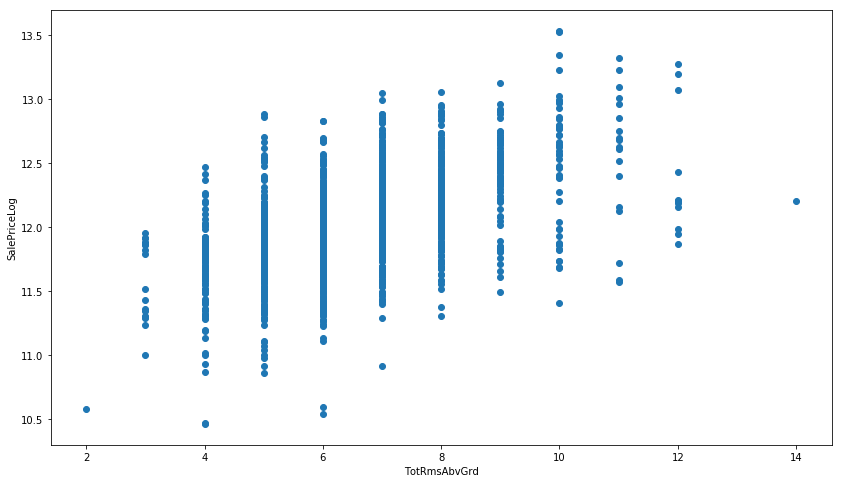

"----------------------------------------------Functional-------------------------------------------------


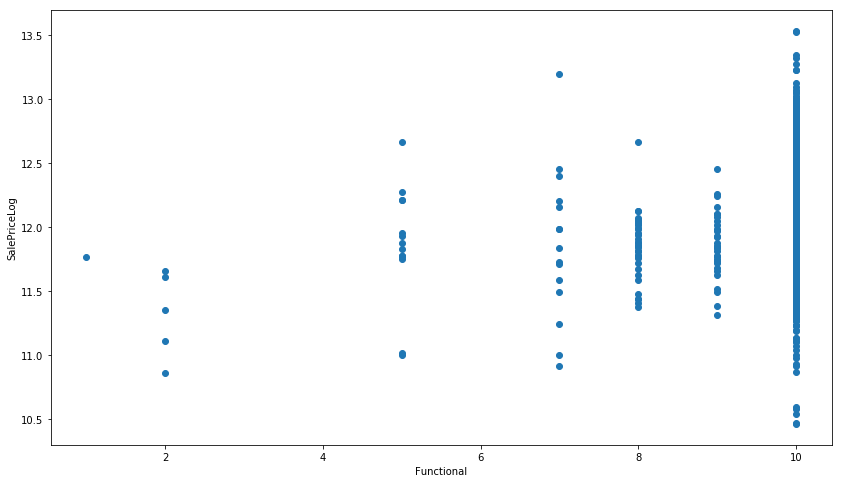

"----------------------------------------------Fireplaces-------------------------------------------------


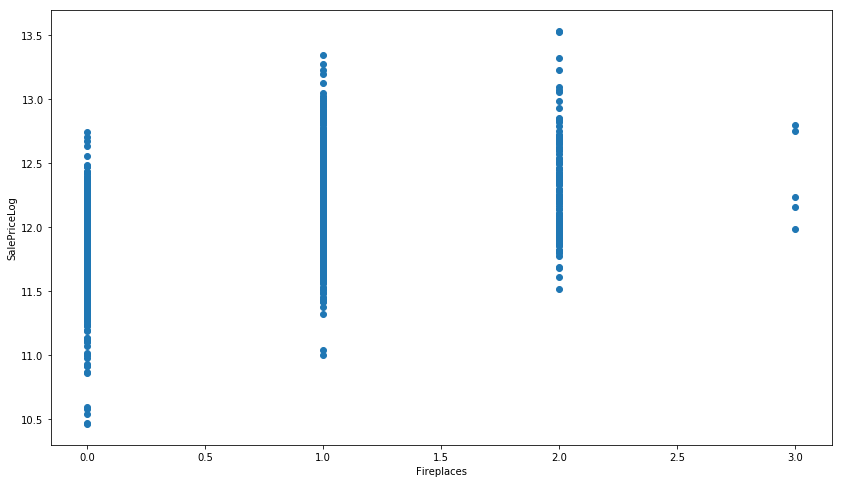

"----------------------------------------------FireplaceQu-------------------------------------------------


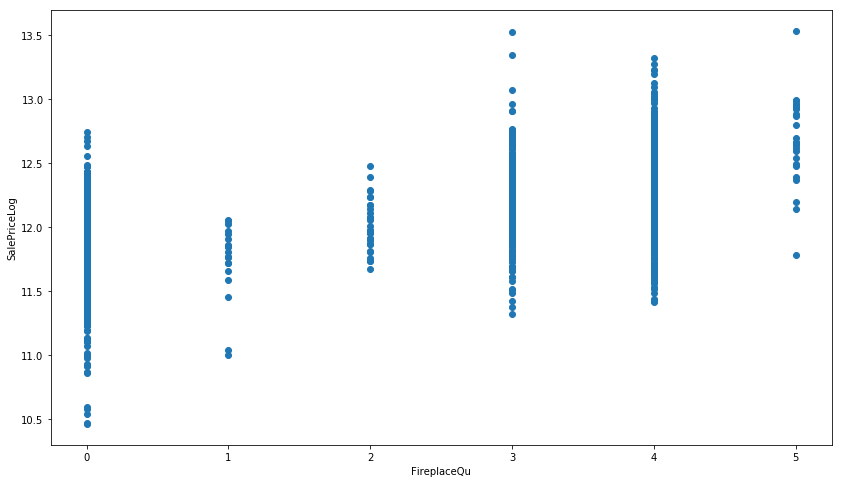

"----------------------------------------------GarageType-------------------------------------------------
           SalePriceLog           
                  count       mean
GarageType                        
2Types                6  11.899157
Attchd              870  12.160778
Basment              19  11.916440
BuiltIn              88  12.374919
CarPort               9  11.587994
Detchd              387  11.765643
No_garage            81  11.491874


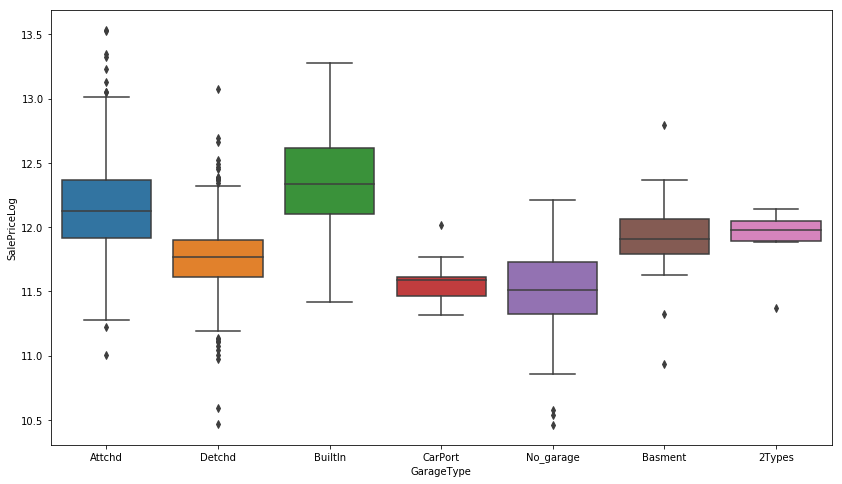

"----------------------------------------------GarageFinish-------------------------------------------------


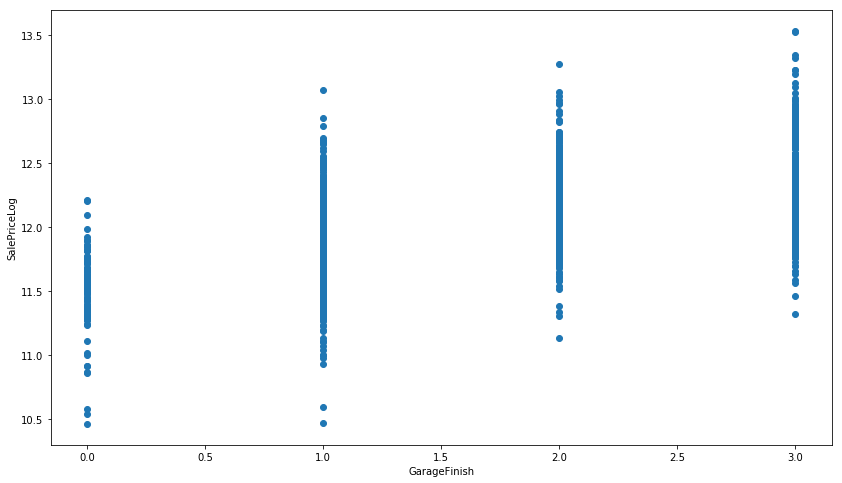

"----------------------------------------------GarageCars-------------------------------------------------


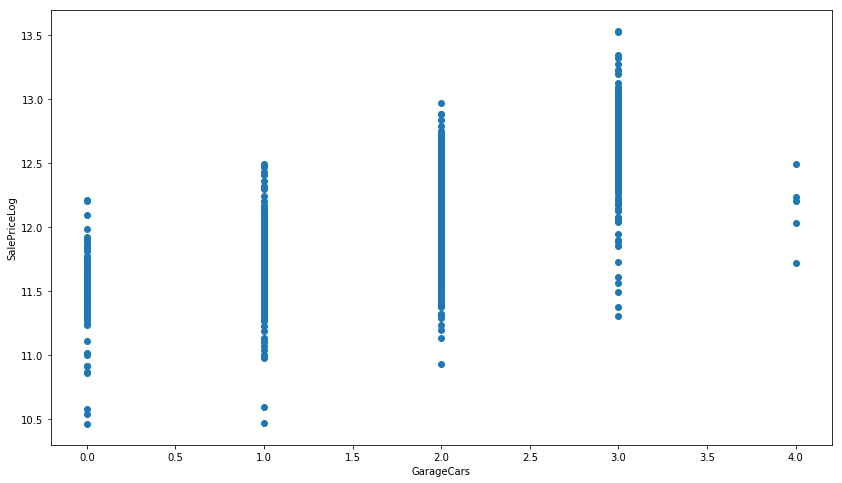

"----------------------------------------------GarageArea-------------------------------------------------


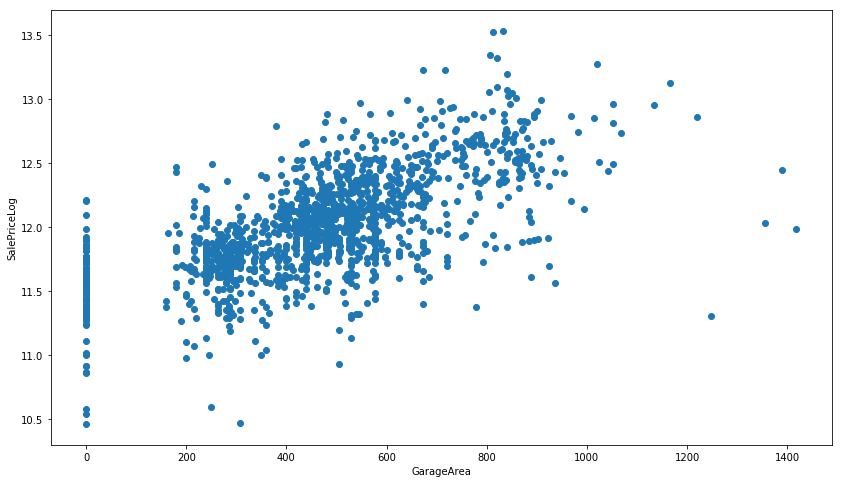

"----------------------------------------------GarageQual-------------------------------------------------


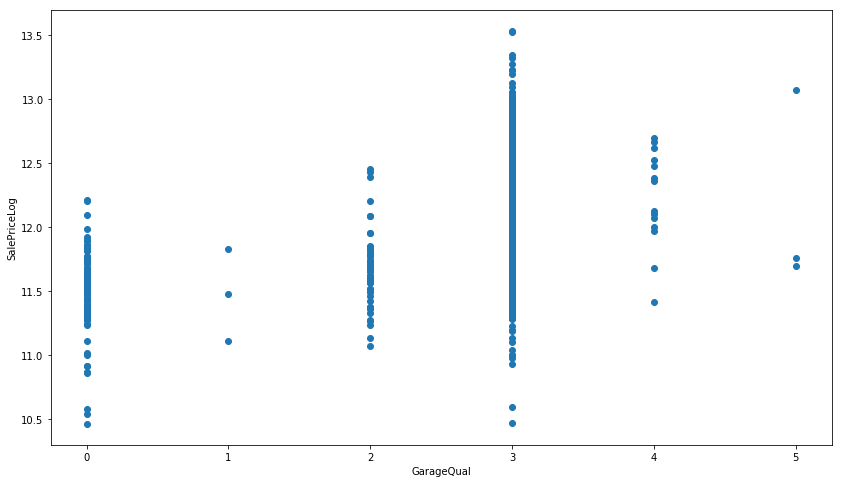

"----------------------------------------------GarageCond-------------------------------------------------


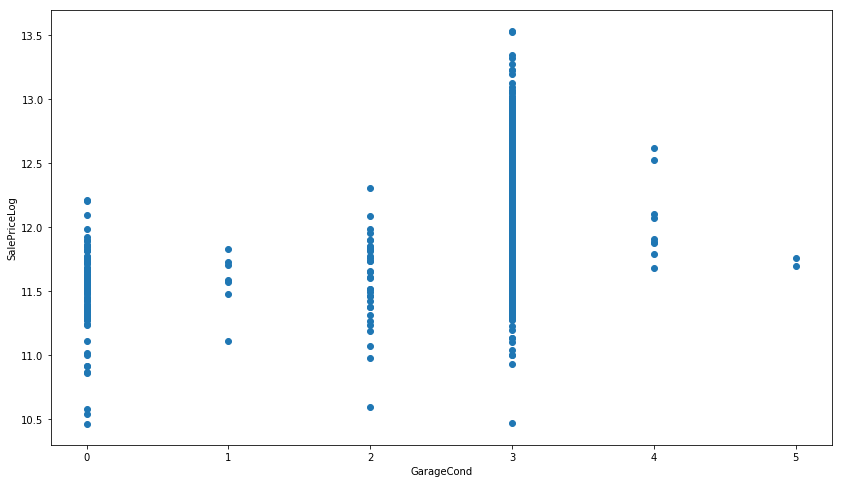

"----------------------------------------------PavedDrive-------------------------------------------------


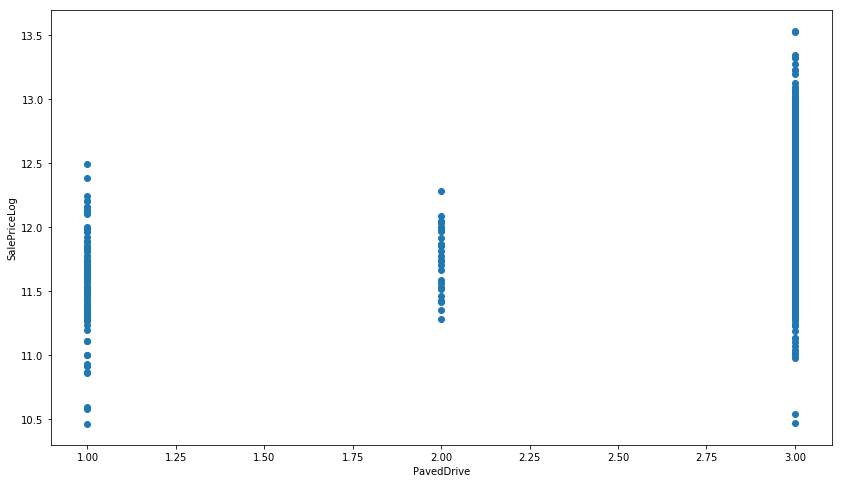

"----------------------------------------------WoodDeckSF-------------------------------------------------


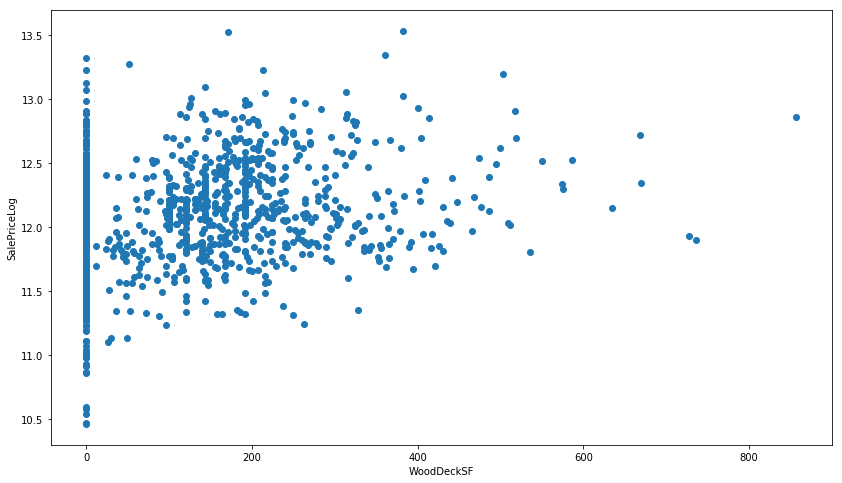

"----------------------------------------------OpenPorchSF-------------------------------------------------


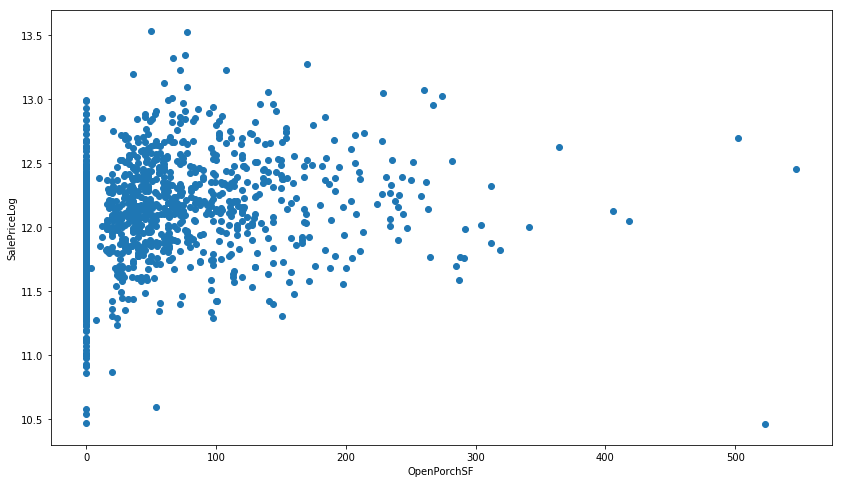

"----------------------------------------------EnclosedPorch-------------------------------------------------


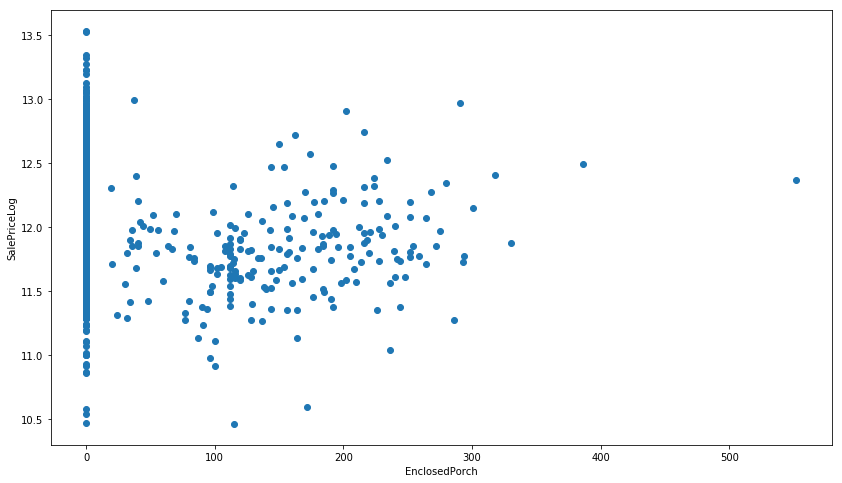

"----------------------------------------------3SsnPorch-------------------------------------------------


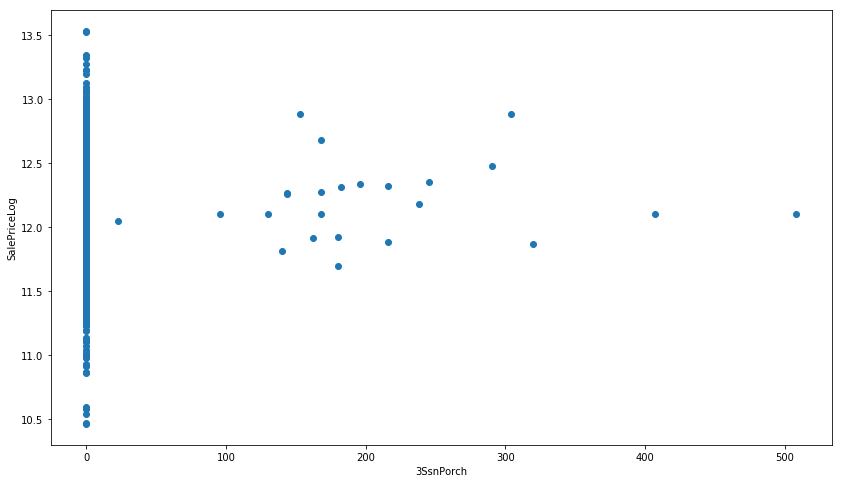

"----------------------------------------------ScreenPorch-------------------------------------------------


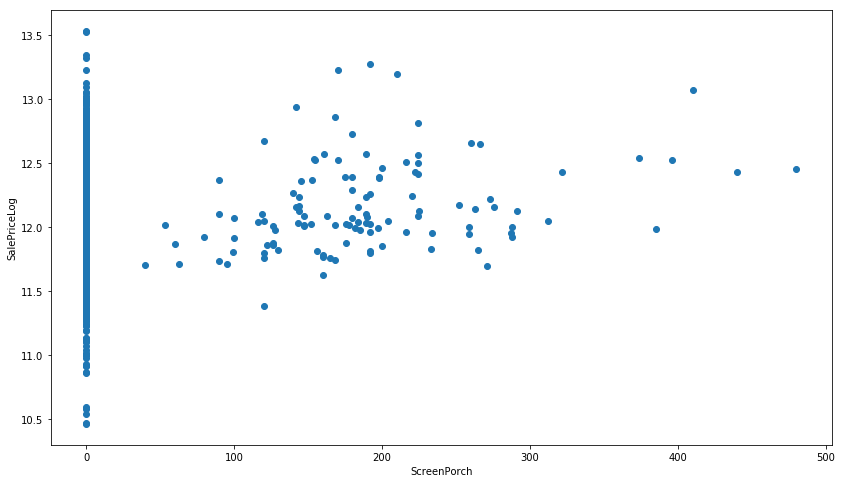

"----------------------------------------------PoolArea-------------------------------------------------


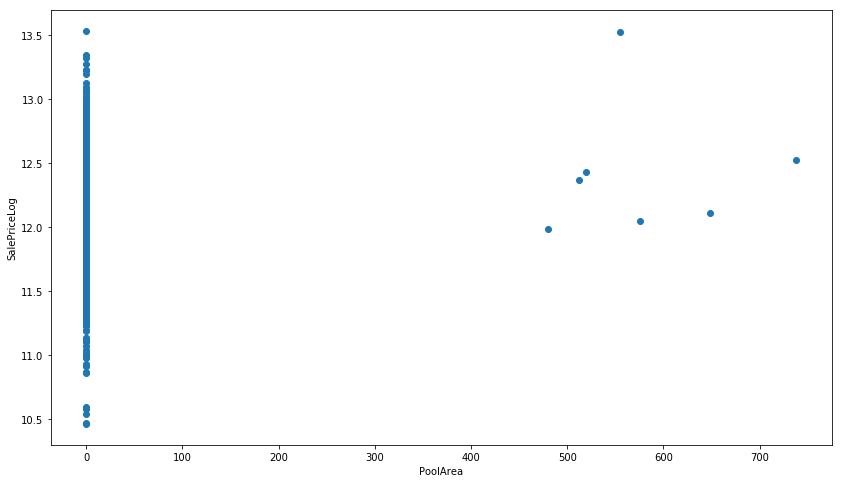

"----------------------------------------------PoolQC-------------------------------------------------


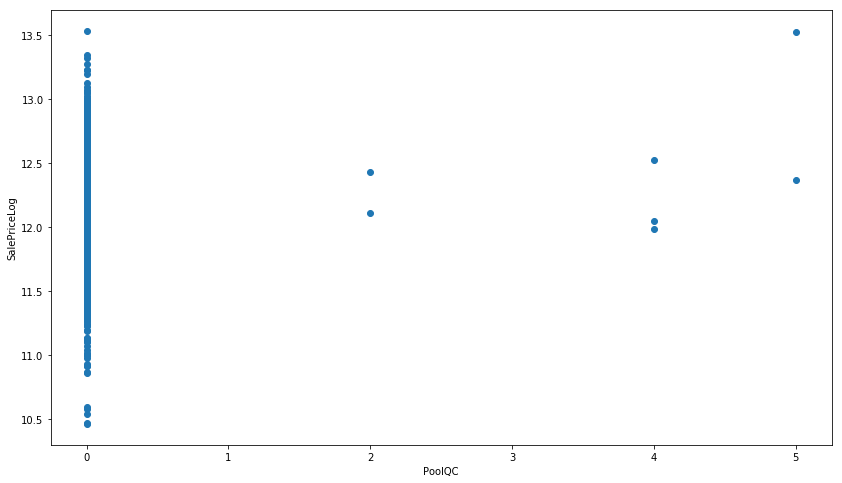

"----------------------------------------------Fence-------------------------------------------------
         SalePriceLog           
                count       mean
Fence                           
GdPrv              59  12.057113
GdWo               54  11.784233
MnPrv             157  11.850596
MnWw               11  11.796800
No_fence         1179  12.058599


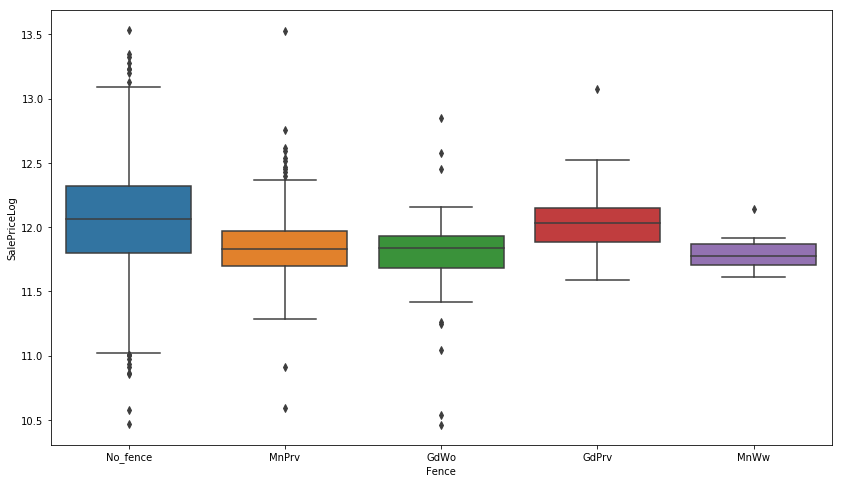

"----------------------------------------------MiscFeature-------------------------------------------------
               SalePriceLog           
                      count       mean
MiscFeature                           
Gar2                      2  12.041560
No_miscFeature         1406  12.030112
Othr                      2  11.356596
Shed                     49  11.868387
TenC                      1  12.429216


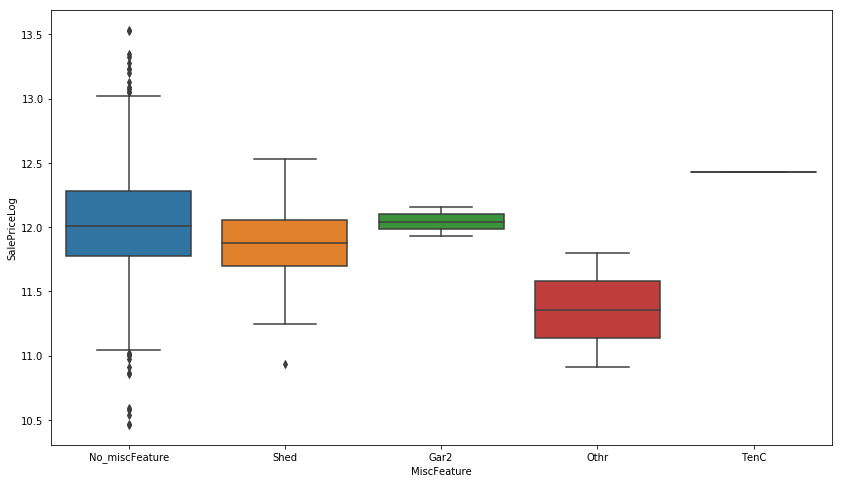

"----------------------------------------------MiscVal-------------------------------------------------


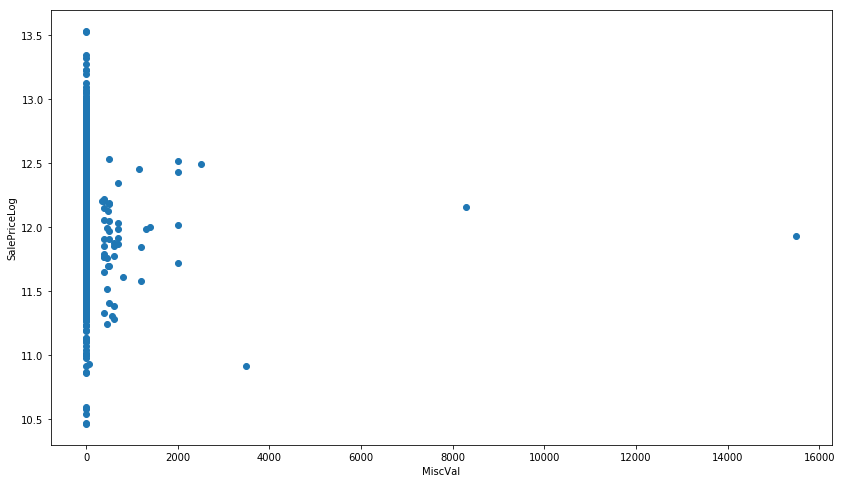

"----------------------------------------------MoSold-------------------------------------------------
       SalePriceLog           
              count       mean
MoSold                        
m1               58  11.963300
m10              89  12.020135
m11              79  12.074846
m12              59  12.062260
m2               52  12.047052
m3              106  12.030134
m4              141  11.972056
m5              204  11.984846
m6              253  12.019938
m7              234  12.042791
m8              122  12.049088
m9               63  12.098561


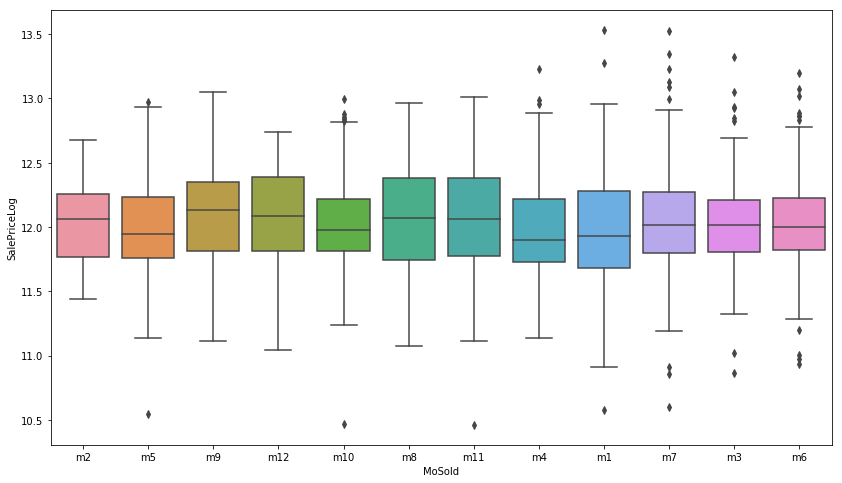

"----------------------------------------------YrSold-------------------------------------------------
       SalePriceLog           
              count       mean
YrSold                        
y2006           314  12.034985
y2007           329  12.050668
y2008           304  12.014205
y2009           338  12.008737
y2010           175  12.001072


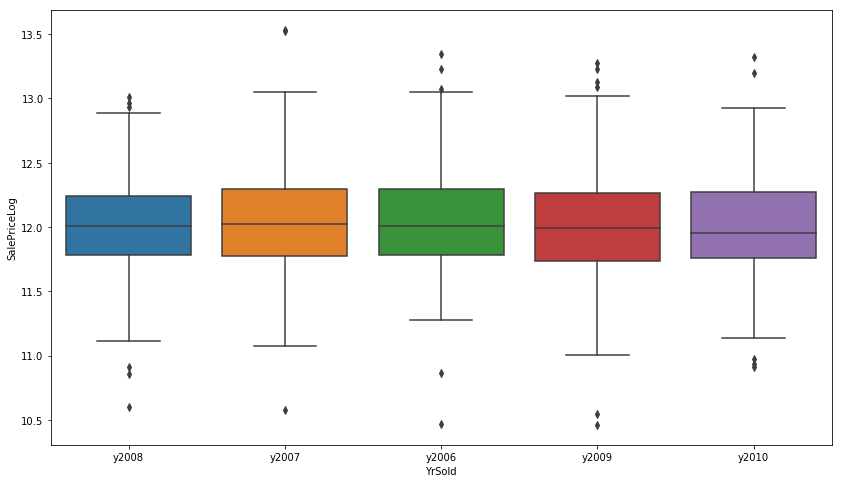

"----------------------------------------------SaleType-------------------------------------------------
         SalePriceLog           
                count       mean
SaleType                        
COD                43  11.827437
CWD                 4  12.198344
Con                 2  12.483911
ConLD               9  11.773000
ConLI               5  12.044878
ConLw               5  11.769706
New               122  12.459372
Oth                 3  11.675295
WD               1267  11.991061


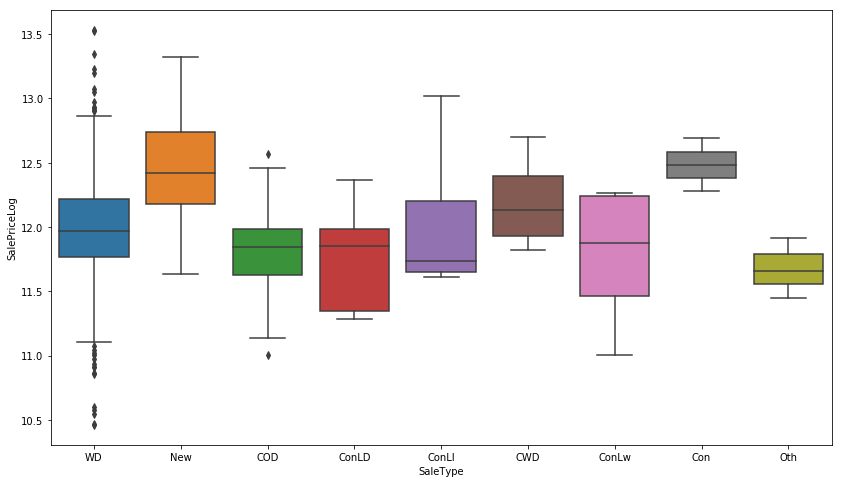

"----------------------------------------------SaleCondition-------------------------------------------------
              SalePriceLog           
                     count       mean
SaleCondition                        
Abnorml                101  11.788774
AdjLand                  4  11.529147
Alloca                  12  11.914458
Family                  20  11.869655
Normal                1198  12.005034
Partial                125  12.447477


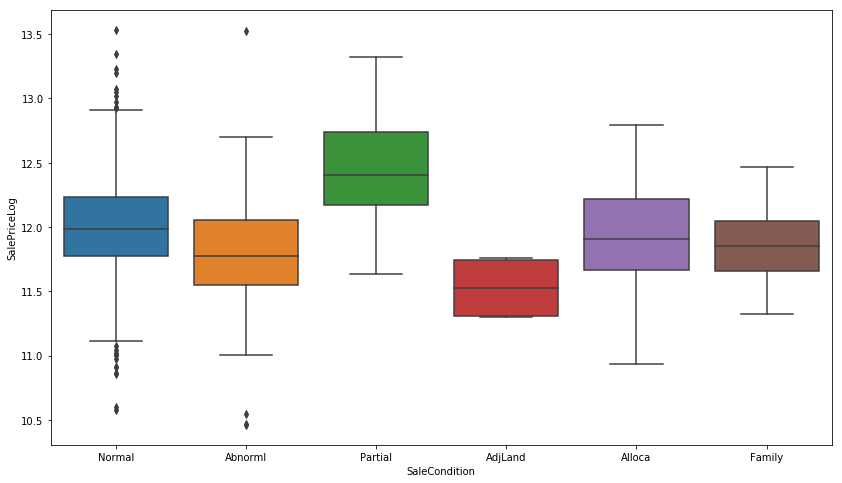

"----------------------------------------------train-------------------------------------------------


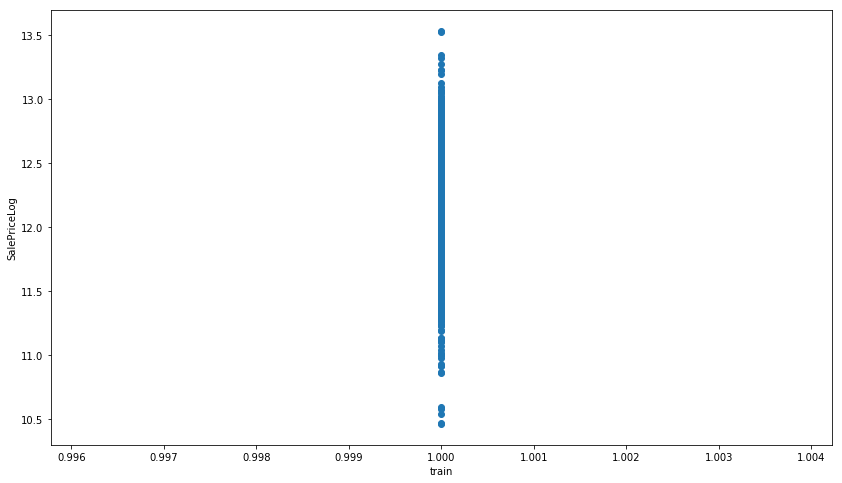

"----------------------------------------------YearsOld-------------------------------------------------


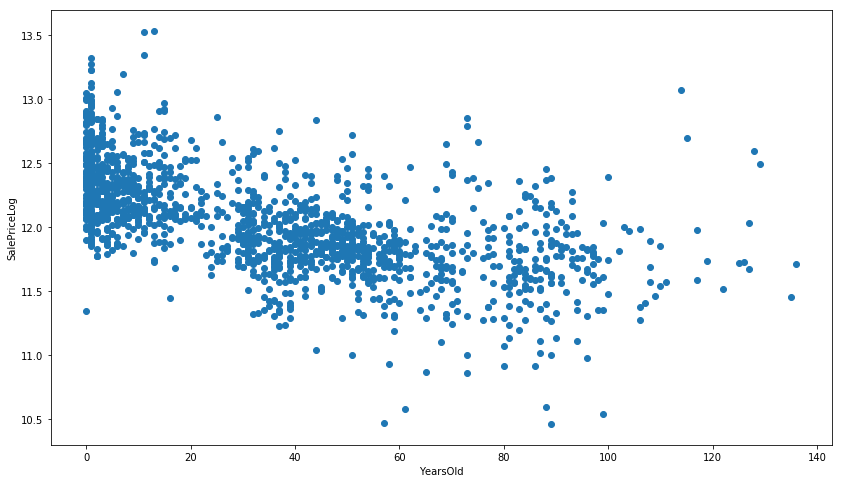

"----------------------------------------------YearSinceRemodel-------------------------------------------------


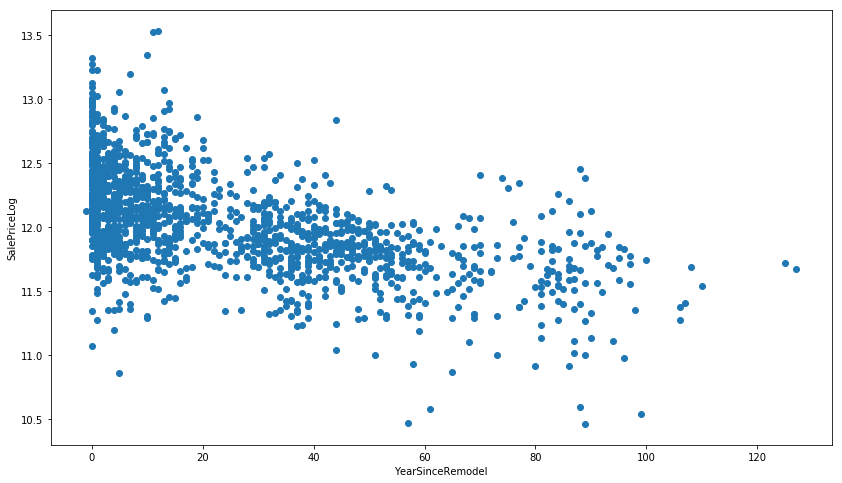

"----------------------------------------------YearBuiltAdj-------------------------------------------------


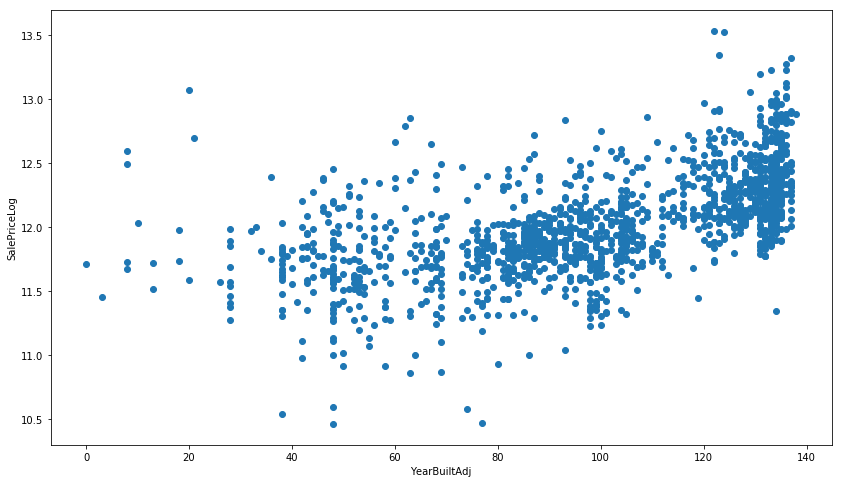

"----------------------------------------------YearRemodAddAdj-------------------------------------------------


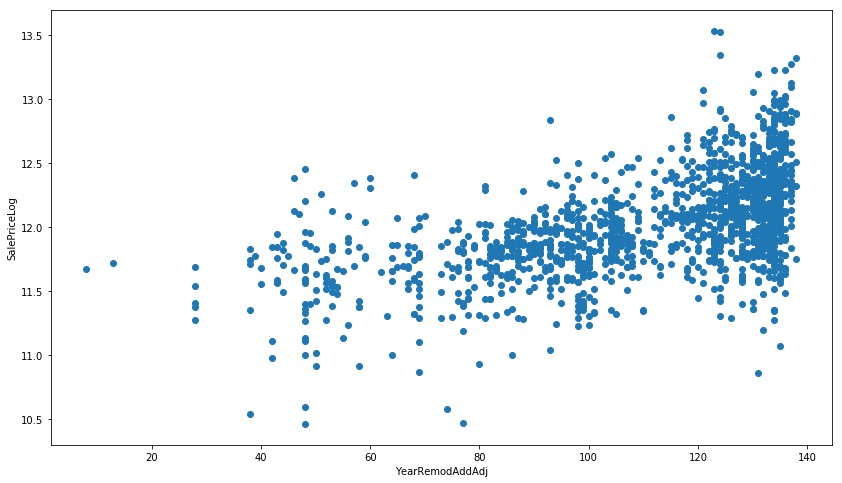

"----------------------------------------------YearSinceGarageBlt-------------------------------------------------


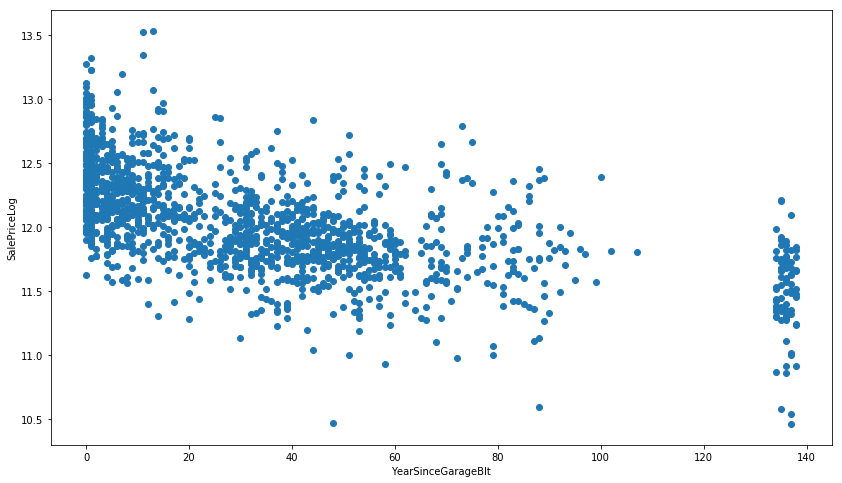

"----------------------------------------------GarageYrBltAdj-------------------------------------------------


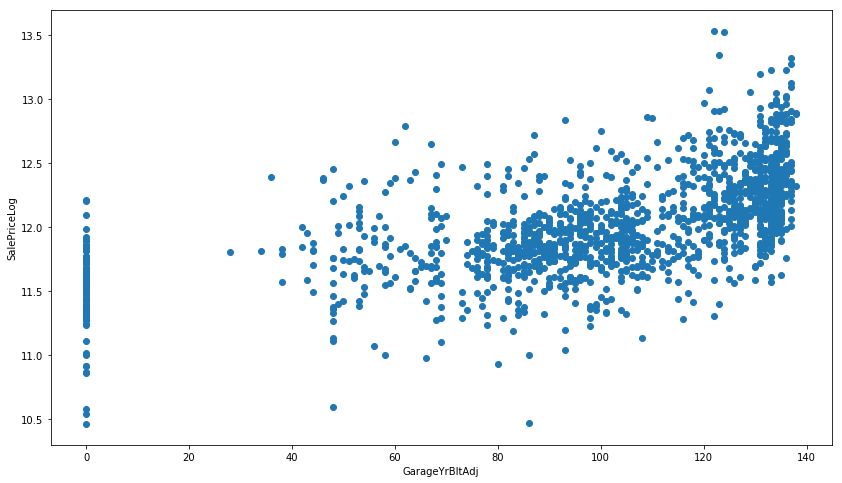

"----------------------------------------------YrSold-Month-------------------------------------------------
             SalePriceLog           
                    count       mean
YrSold-Month                        
2006-1                 10  12.137672
2006-10                24  11.959605
2006-11                16  12.187293
2006-12                12  12.065539
2006-2                  9  12.162326
2006-3                 25  12.051388
2006-4                 27  11.977148
2006-5                 38  11.932637
2006-6                 48  11.974558
2006-7                 67  12.039383
2006-8                 23  12.106922
2006-9                 15  12.223291
2007-1                 13  11.864504
2007-10                16  12.216754
2007-11                24  12.127205
2007-12                18  12.196551
2007-2                  8  12.031441
2007-3                 23  11.975770
2007-4                 23  11.981913
2007-5                 43  11.967814
2007-6                 59  12.049251
200

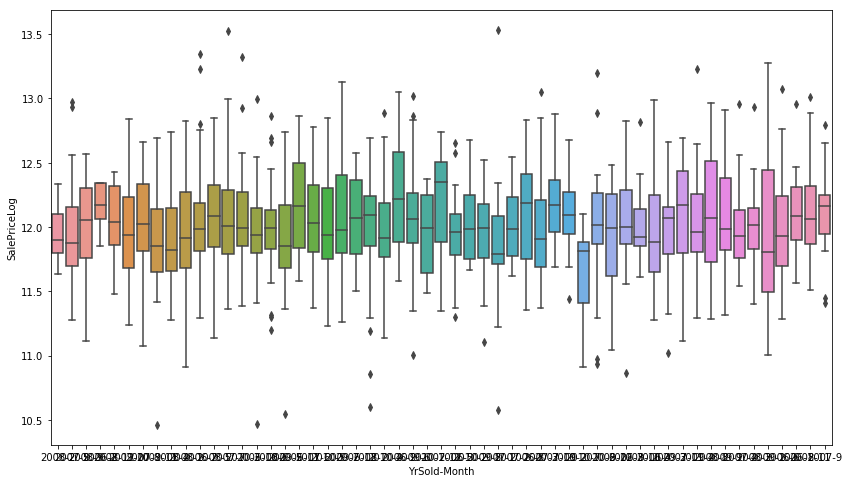

"----------------------------------------------BsmtBath-------------------------------------------------


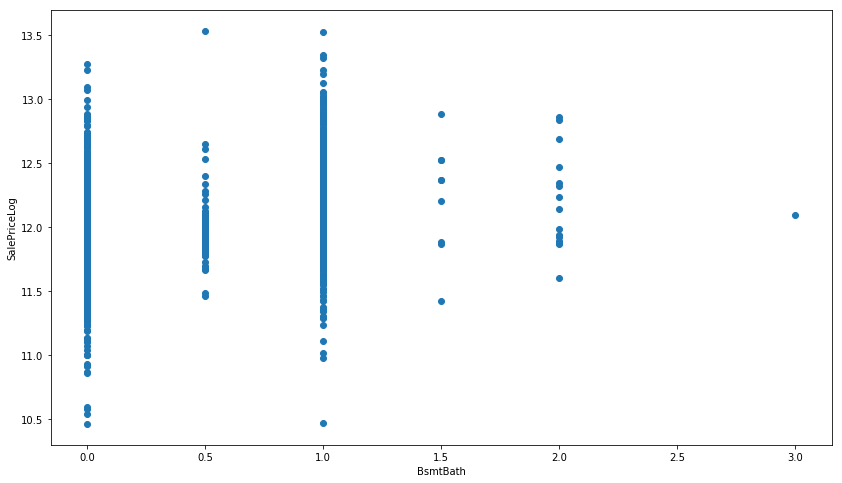

"----------------------------------------------Bath-------------------------------------------------


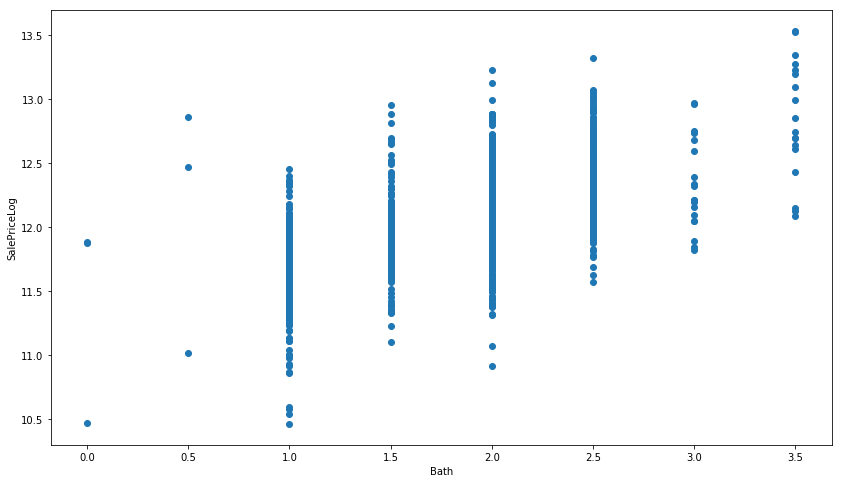

"----------------------------------------------Basement-------------------------------------------------


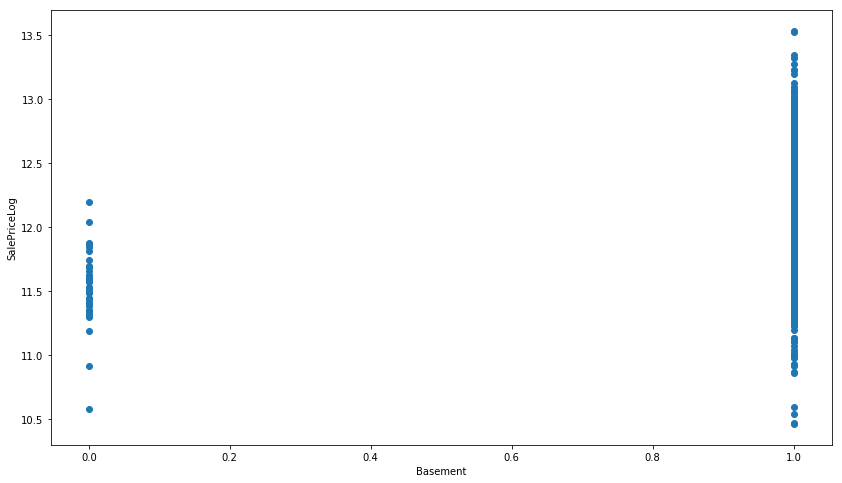

"----------------------------------------------BsmtScore-------------------------------------------------


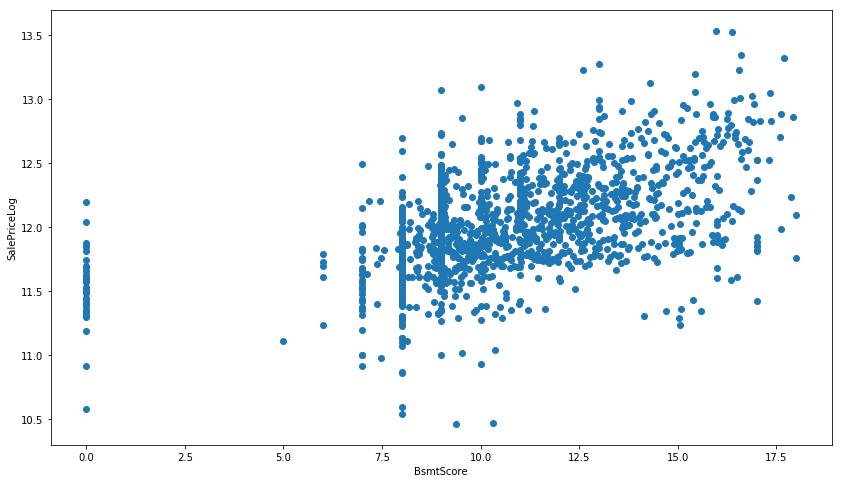

"----------------------------------------------TotalSF-------------------------------------------------


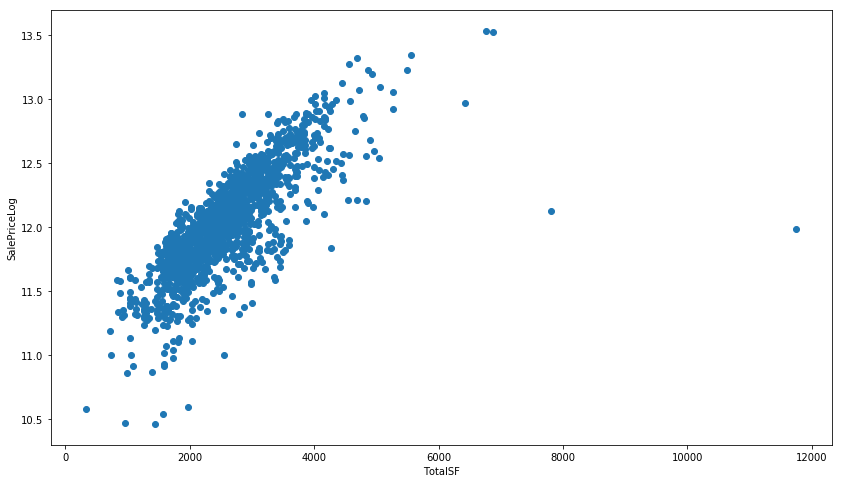

"----------------------------------------------SF_score-------------------------------------------------


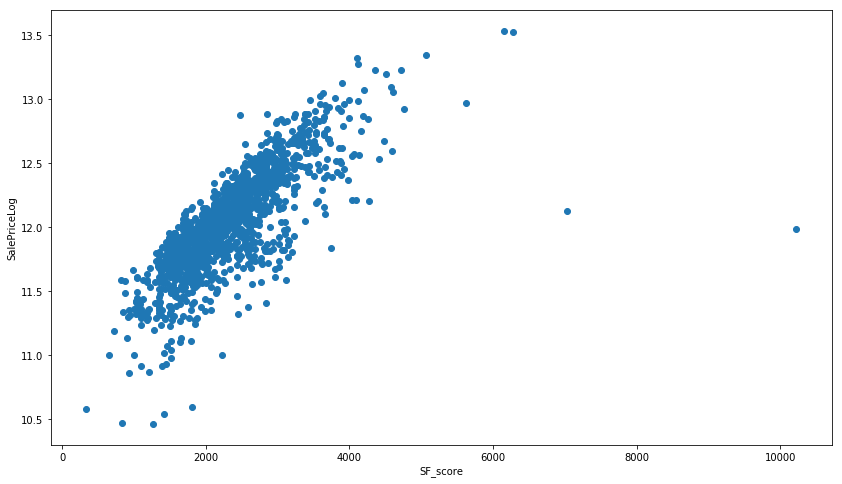

"----------------------------------------------OverallQual_exp-------------------------------------------------


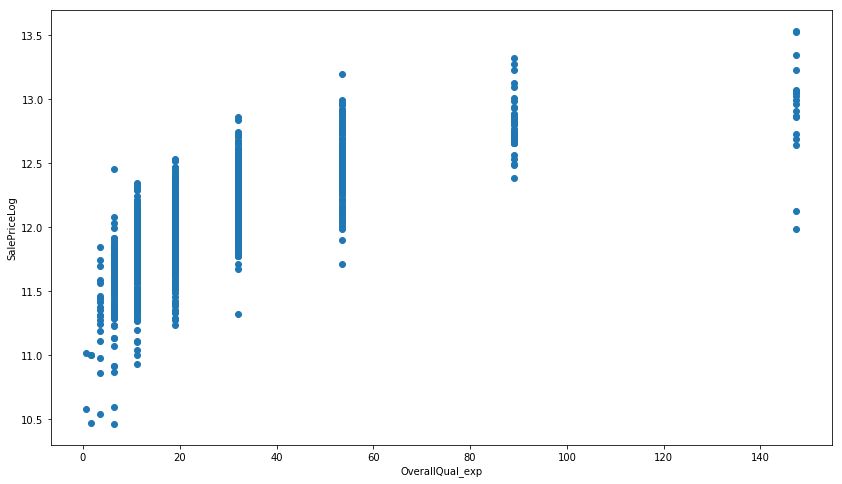

"----------------------------------------------YearsOld_log-------------------------------------------------


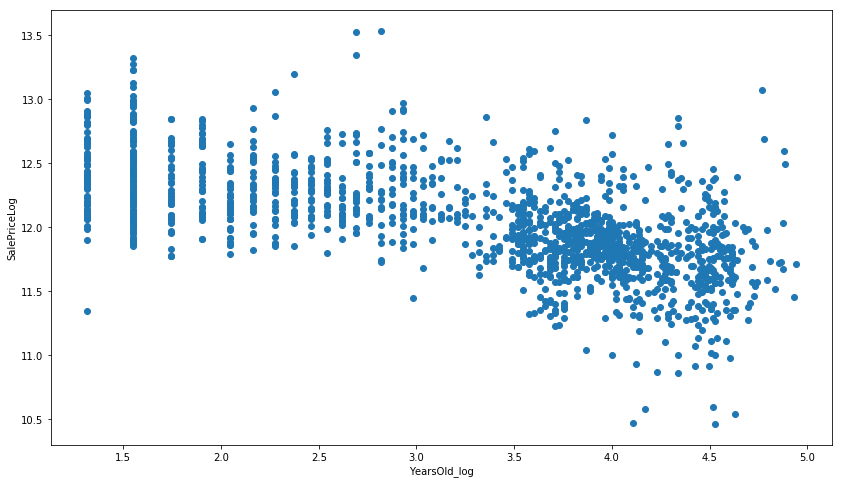

"----------------------------------------------YearSinceGarageBlt_log-------------------------------------------------


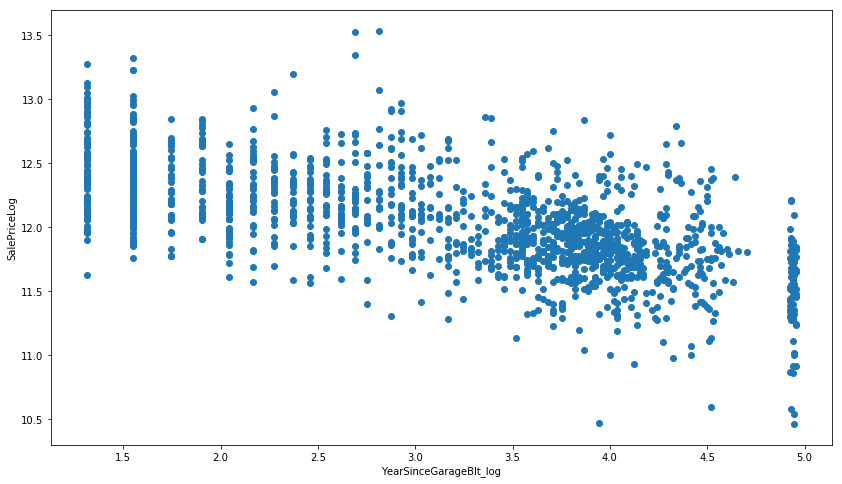

"----------------------------------------------YearSinceRemodel_log-------------------------------------------------


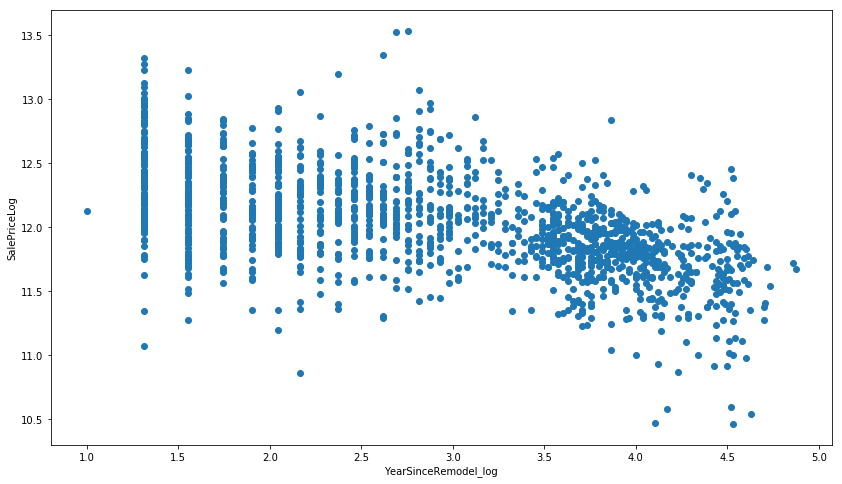

"----------------------------------------------SalePrice-------------------------------------------------


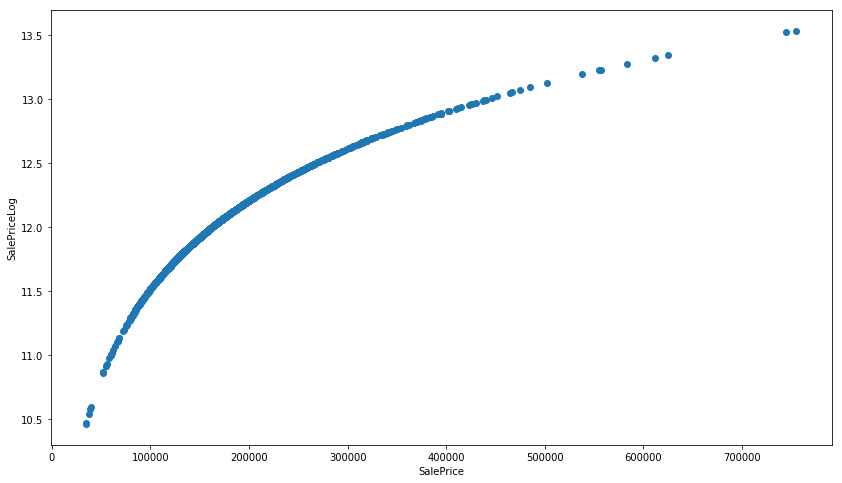

"----------------------------------------------SalePriceLog-------------------------------------------------


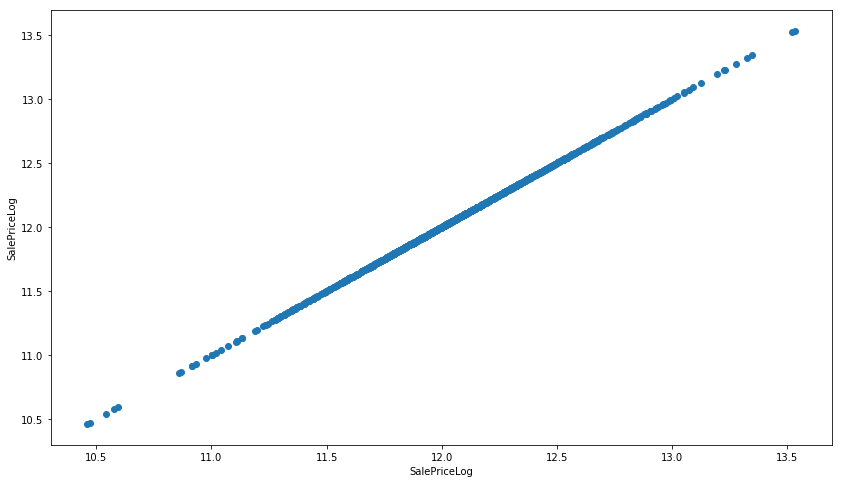

In [1413]:
#Change y to log(y)
target='SalePriceLog'
temp = x_train
temp['SalePriceLog'] = list(map(np.log,y_train))
for col in list(temp.columns.values)[1:len(temp.columns)]:
    try:
        if np.issubdtype(x_train[col].dtype, np.number) == True:
            print("\x1b[31m\"----------------------------------------------" + col  + "-------------------------------------------------""\x1b[0m")
            plt.figure(figsize=(14,8))
            matplotlib.pyplot.scatter(temp[col],temp[target])
        else:
            print("\x1b[31m\"----------------------------------------------" + col  + "-------------------------------------------------""\x1b[0m")
            plt.figure(figsize=(14,8))
            sns.boxplot(x=temp[col], y=temp[target])
            print(temp.groupby(col).agg({target:['count','mean']})) 
        plt.xlabel(col)
        plt.ylabel(target)
        plt.show()
    except:
        pass

del temp

In [1608]:
len(list(y_train))
y_pred[0]

208500.00000000003

Coefficients: 
 [ -1.36135932e-11   5.55330115e-10   1.63579251e-10   1.22869643e-11
  -1.98556388e-10   3.21433668e-11  -6.06358020e-11   6.28043802e-11
  -8.34179117e-12  -1.07548913e-10  -4.84837987e-11  -8.39154360e-12
  -1.93589222e-11  -7.88559946e-11  -3.19607912e-11  -1.13906851e-11
  -3.95800591e-11  -9.07221147e-11  -6.60793455e-12   8.27476306e-13
   1.66893752e-10  -1.97446793e-10   2.66470314e-11   6.30816590e-11
   2.16111590e-11   4.47348127e-11  -2.25100481e-11  -3.86332939e-11
  -4.92451672e-11   6.78508528e-12  -1.10587801e-11   1.14584367e-11
  -8.07407578e-12   7.43249243e-12   5.36486361e-11  -3.95742241e-11
   4.54220385e-12  -1.11084495e-11  -1.31282579e-12   4.02306594e-12
  -7.75227114e-12   1.31207194e-11  -2.61455990e-11  -5.29174786e-11
   1.66820786e-10   6.35274710e-22   8.90097711e-12  -9.99036672e-13
  -9.30712012e-12   4.15592334e-13   1.95694759e-11  -2.01046186e-11
   4.32386390e-12  -1.91240498e-12   9.56688642e-11   1.49496442e-10
  -1.92218142e-11 

ValueError: x and y must be the same size

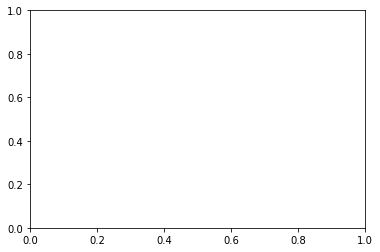

In [1609]:
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

x_train_encoded_temp  = normalizeDf(x_train_encoded)
x_train_encoded_temp['SalePrice'] = list(y_train)
y = x_train_encoded_temp['SalePrice']

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train_encoded_temp, y)

# Make predictions using the testing set
y_pred = regr.predict(x_train_encoded_temp)


# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, y_pred))

# Plot outputs
plt.scatter(x_train_encoded_temp, y, color='black')
plt.plot(x_train_encoded_temp, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

del x_train_encoded_temp

plt.show()

YrSold  MoSold
2006    1         201090.000000
        2         194322.222222
        3         184982.200000
        4         174312.814815
        5         158928.289474
        6         172283.333333
        7         183211.059701
        8         196239.956522
        9         223768.866667
        10        172356.708333
        11        213285.000000
        12        185545.000000
2007    1         183234.615385
        2         176301.750000
        3         176567.782609
        4         170772.608696
        5         169873.511628
        6         179725.813559
        7         195396.843137
        8         183941.075000
        9         195533.818182
        10        215428.812500
        11        197709.333333
        12        214414.500000
2008    1         178504.692308
        2         159370.000000
        3         178505.277778
        4         159293.346154
        5         188334.473684
        6         169730.941176
        7         174562.

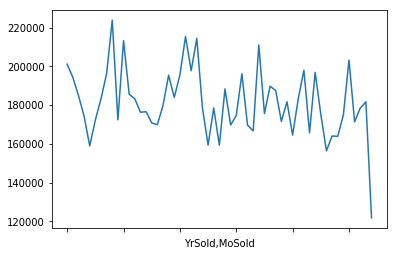

In [149]:
a = x_train.groupby(['YrSold','MoSold']).mean()
print(a['SalePrice'])
(a['SalePrice']).plot()

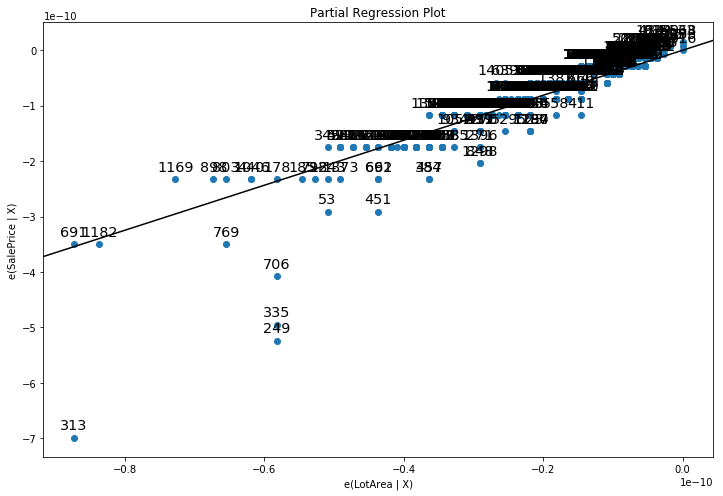

In [207]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.plot_partregress("SalePrice", 'LotArea', ['LotArea','SalePrice'], data=housing, ax=ax)

In [1429]:
temp = x_train.copy(deep=True)
temp['SalePrice'] = list(y_train)
housing2 = temp

housing2['firstFlrSF'] = list(housing2['1stFlrSF'])
housing2['secondFlrSF'] = list(housing2['2ndFlrSF'])
housing2['threeFlrSF'] = list(housing2['3SsnPorch'])
#housing2['Exteriorfirst_Wd_Sdng'] = list(housing2['Exterior1st_Wd Sdng'])

housing2.drop(['1stFlrSF','2ndFlrSF','3SsnPorch'],axis=1,inplace=True)

housing2 = housing2.replace(np.nan, 0, regex=True)
all_columns = " + ".join(housing2.columns[1:]) #replace 5 with -1
all_columns = all_columns.replace('SalePrice + ','')
my_formula = "SalePrice~" + all_columns
my_formula
housing_model = ols(my_formula, data=housing2).fit()
print(housing_model.summary())

del Temp


   MSSubClass MSZoning  LotFrontage  LotArea Street     Alley  LotShape  \
Id                                                                        
1         s60       RL         65.0     8450   Pave  No_alley         0   
2         s20       RL         80.0     9600   Pave  No_alley         0   
3         s60       RL         68.0    11250   Pave  No_alley         1   
4         s70       RL         60.0     9550   Pave  No_alley         1   
5         s60       RL         84.0    14260   Pave  No_alley         1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5          Lvl    AllPub       FR2       G

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyError: '1stFlrSF'

In [1427]:
temp = x_train
temp['SalePriceLog'] = list(map(np.log,y_train))
housing2= temp

housing2['firstFlrSF'] = list(housing2['1stFlrSF'])
housing2['secondFlrSF'] = list(housing2['2ndFlrSF'])
housing2['threeFlrSF'] = list(housing2['3SsnPorch'])
#housing2['Exteriorfirst_Wd_Sdng'] = list(housing2['Exterior1st_Wd Sdng'])

housing2.drop(['1stFlrSF','2ndFlrSF','3SsnPorch'],axis=1,inplace=True)

housing2 = housing2.replace(np.nan, 0, regex=True)
all_columns = " + ".join(housing2.columns[1:]) #replace 5 with -1
all_columns = all_columns.replace('SalePriceLog + ','')
my_formula = "SalePriceLog~" + all_columns
housing_model = ols(my_formula, data=housing2).fit()
print(housing_model.summary())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyError: '1stFlrSF'

In [1417]:
# fig = plt.figure(figsize=(8,5))
# fig = sm.graphics.plot_partregress_grid(housing_model, fig=fig)
# fig.subplots_adjust(left=None, bottom=2.0, right=None, top=5.0, wspace=None, hspace=None)